Question: can the effects of cannabis be predicted based on how it smells?

kaggle dataset (link)

biases due to user reported data, etc

so really, it is given the (undoubtedly imperfect) data we have, can we predict cannabis effects based on reported smell/taste (reported as 'flavor' in the data)

Rationale behind this: Cannabis has lots of natural products, more than just cannabinoids are biologically active (causing effects in patients) e.g. terpenes (check out the work of Dr. Russo)

Terpenes in plants, foods, essential oils; smells!

Use smell/taste as a proxy for terpene content

In [67]:
import kaggle
from collections import Counter
from collections import defaultdict
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from random import choices
from random import seed

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import AllKNN
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek



In [4]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('nvisagan/cannabis-strains-features', path='./cannabis-strains-features', unzip=True)

data = pd.read_csv('./cannabis-strains-features/Cannabis_Strains_Features.csv')

data

Strain    Type  Rating  \
0             100-Og  hybrid     4.0   
1     98-White-Widow  hybrid     4.7   
2               1024  sativa     4.4   
3           13-Dawgs  hybrid     4.2   
4           24K-Gold  hybrid     4.6   
...              ...     ...     ...   
2346         Zeus-Og  hybrid     4.7   
2347        Zkittlez  indica     4.6   
2348     Zombie-Kush  indica     5.0   
2349       Zombie-Og  indica     4.4   
2350        Zoom-Pie  indica     4.6   

                                         Effects                     Flavor  \
0     Creative,Energetic,Tingly,Euphoric,Relaxed        Earthy,Sweet,Citrus   
1       Relaxed,Aroused,Creative,Happy,Energetic      Flowery,Violet,Diesel   
2      Uplifted,Happy,Relaxed,Energetic,Creative    Spicy/Herbal,Sage,Woody   
3        Tingly,Creative,Hungry,Relaxed,Uplifted  Apricot,Citrus,Grapefruit   
4      Happy,Relaxed,Euphoric,Uplifted,Talkative       Citrus,Earthy,Orange   
...                                          ...                        ...   
2346   Happy,Uplifted,Relaxed,Euphoric,Energetic          Earthy,Woody,Pine   
2347      Relaxed,Happy,Euphoric,Uplifted,Sleepy          Sweet,Berry,Grape   
2348     Relaxed,Sleepy,Talkative,Euphoric,Happy  Earthy,Sweet,Spicy/Herbal   
2349        Relaxed,Sleepy,Euphoric,Happy,Hungry       Sweet,Earthy,Pungent   
2350        Hungry,Relaxed,Uplifted,Happy,Sleepy       Berry,Earthy,Pungent   

                                            Description  
0     $100 OG is a 50/50 hybrid strain that packs a ...  
1     The ‘98 Aloha White Widow is an especially pot...  
2     1024 is a sativa-dominant hybrid bred in Spain...  
3     13 Dawgs is a hybrid of G13 and Chemdawg genet...  
4     Also known as Kosher Tangie, 24k Gold is a 60%...  
...                                                 ...  
2346  Zeus OG is a hybrid cross between Pineapple OG...  
2347  Zkittlez is an indica-dominant mix of Grape Ap...  
2348  Zombie Kush by Ripper Seeds comes from two dif...  
2349  If you’re looking to transform into a flesh-ea...  
2350  Zoom Pie (also known as Zombie Pie) is a heavy...  

[2351 rows x 6 columns]

description of data

see that for both effects, and flavor, we have strings essentially reporting a list of effects and flavors. 

create a function to seperate out into coulns for each position in list to explore data more

In [90]:
def cols_for_ranks(df, col_name):
    ranked_cols_appended = pd.concat([df, df[col_name].str.split(',', expand = True).add_prefix(col_name + '_')], axis = 1)
    return ranked_cols_appended

In [91]:
cols_for_ranks(data, 'Flavor')

Strain    Type  Rating  \
0             100-Og  hybrid     4.0   
1     98-White-Widow  hybrid     4.7   
2               1024  sativa     4.4   
3           13-Dawgs  hybrid     4.2   
4           24K-Gold  hybrid     4.6   
...              ...     ...     ...   
2346         Zeus-Og  hybrid     4.7   
2347        Zkittlez  indica     4.6   
2348     Zombie-Kush  indica     5.0   
2349       Zombie-Og  indica     4.4   
2350        Zoom-Pie  indica     4.6   

                                         Effects                     Flavor  \
0     Creative,Energetic,Tingly,Euphoric,Relaxed        Earthy,Sweet,Citrus   
1       Relaxed,Aroused,Creative,Happy,Energetic      Flowery,Violet,Diesel   
2      Uplifted,Happy,Relaxed,Energetic,Creative    Spicy/Herbal,Sage,Woody   
3        Tingly,Creative,Hungry,Relaxed,Uplifted  Apricot,Citrus,Grapefruit   
4      Happy,Relaxed,Euphoric,Uplifted,Talkative       Citrus,Earthy,Orange   
...                                          ...                        ...   
2346   Happy,Uplifted,Relaxed,Euphoric,Energetic          Earthy,Woody,Pine   
2347      Relaxed,Happy,Euphoric,Uplifted,Sleepy          Sweet,Berry,Grape   
2348     Relaxed,Sleepy,Talkative,Euphoric,Happy  Earthy,Sweet,Spicy/Herbal   
2349        Relaxed,Sleepy,Euphoric,Happy,Hungry       Sweet,Earthy,Pungent   
2350        Hungry,Relaxed,Uplifted,Happy,Sleepy       Berry,Earthy,Pungent   

                                            Description      Flavor_0  \
0     $100 OG is a 50/50 hybrid strain that packs a ...        Earthy   
1     The ‘98 Aloha White Widow is an especially pot...       Flowery   
2     1024 is a sativa-dominant hybrid bred in Spain...  Spicy/Herbal   
3     13 Dawgs is a hybrid of G13 and Chemdawg genet...       Apricot   
4     Also known as Kosher Tangie, 24k Gold is a 60%...        Citrus   
...                                                 ...           ...   
2346  Zeus OG is a hybrid cross between Pineapple OG...        Earthy   
2347  Zkittlez is an indica-dominant mix of Grape Ap...         Sweet   
2348  Zombie Kush by Ripper Seeds comes from two dif...        Earthy   
2349  If you’re looking to transform into a flesh-ea...         Sweet   
2350  Zoom Pie (also known as Zombie Pie) is a heavy...         Berry   

     Flavor_1      Flavor_2  
0       Sweet        Citrus  
1      Violet        Diesel  
2        Sage         Woody  
3      Citrus    Grapefruit  
4      Earthy        Orange  
...       ...           ...  
2346    Woody          Pine  
2347    Berry         Grape  
2348    Sweet  Spicy/Herbal  
2349   Earthy       Pungent  
2350   Earthy       Pungent  

[2295 rows x 9 columns]

In [197]:
Counter(cols_for_ranks(data, 'Flavor')['Flavor_3']).most_common()

KeyError: 'Flavor_3'

In [ ]:
cols_for_ranks(data, 'Flavor')[cols_for_ranks(data, 'Flavor')['Flavor'].str.contains('Fruit')].head(5)

In [9]:
cols_for_ranks('Flavor')[cols_for_ranks('Flavor')['Flavor'].str.contains(' ')]

Strain    Type  Rating  \
5                   3-Bears-Og  indica     4.4   
32                  Acid-Dough  sativa     5.0   
106         Amnesia-Ganja-Haze  sativa     5.0   
1237  Las-Vegas-Purple-Kush-Bx  indica     5.0   

                                       Effects                      Flavor  \
5     Relaxed,Happy,Sleepy,Creative,Euphoric\n      Sweet, Pungent, Earthy   
32       Talkative,Giggly,Happy,Hungry,Relaxed     Earthy,Woody,Tree Fruit   
106                          Euphoric, Relaxed         Spicy/Herbal, Sweet   
1237     Sleepy,Happy,Relaxed,Aroused,Creative  Sweet, Berry, Spicy/Herbal   

                                            Description      Flavor_0  \
5     3 Bears OG by Mephisto Genetics is an autoflow...         Sweet   
32    Acid Dough by Ripper Seeds is a sativa-dominan...        Earthy   
106   Amnesia Ganja Haze is another award-winning st...  Spicy/Herbal   
1237  Las Vegas Purple Kush BX is a clone-only strai...         Sweet   

      Flavor_1       Flavor_2 Flavor_3  
5      Pungent         Earthy     None  
32       Woody     Tree Fruit     None  
106      Sweet           None     None  
1237     Berry   Spicy/Herbal     None

In [10]:
data['Flavor'] = data['Flavor'].str.replace(' ', '')
data['Flavor'] = data['Flavor'].str.replace('Tree,Fruit', 'TreeFruit')
cols_for_ranks('Flavor')

Strain    Type  Rating  \
0             100-Og  hybrid     4.0   
1     98-White-Widow  hybrid     4.7   
2               1024  sativa     4.4   
3           13-Dawgs  hybrid     4.2   
4           24K-Gold  hybrid     4.6   
...              ...     ...     ...   
2346         Zeus-Og  hybrid     4.7   
2347        Zkittlez  indica     4.6   
2348     Zombie-Kush  indica     5.0   
2349       Zombie-Og  indica     4.4   
2350        Zoom-Pie  indica     4.6   

                                         Effects                     Flavor  \
0     Creative,Energetic,Tingly,Euphoric,Relaxed        Earthy,Sweet,Citrus   
1       Relaxed,Aroused,Creative,Happy,Energetic      Flowery,Violet,Diesel   
2      Uplifted,Happy,Relaxed,Energetic,Creative    Spicy/Herbal,Sage,Woody   
3        Tingly,Creative,Hungry,Relaxed,Uplifted  Apricot,Citrus,Grapefruit   
4      Happy,Relaxed,Euphoric,Uplifted,Talkative       Citrus,Earthy,Orange   
...                                          ...                        ...   
2346   Happy,Uplifted,Relaxed,Euphoric,Energetic          Earthy,Woody,Pine   
2347      Relaxed,Happy,Euphoric,Uplifted,Sleepy          Sweet,Berry,Grape   
2348     Relaxed,Sleepy,Talkative,Euphoric,Happy  Earthy,Sweet,Spicy/Herbal   
2349        Relaxed,Sleepy,Euphoric,Happy,Hungry       Sweet,Earthy,Pungent   
2350        Hungry,Relaxed,Uplifted,Happy,Sleepy       Berry,Earthy,Pungent   

                                            Description      Flavor_0  \
0     $100 OG is a 50/50 hybrid strain that packs a ...        Earthy   
1     The ‘98 Aloha White Widow is an especially pot...       Flowery   
2     1024 is a sativa-dominant hybrid bred in Spain...  Spicy/Herbal   
3     13 Dawgs is a hybrid of G13 and Chemdawg genet...       Apricot   
4     Also known as Kosher Tangie, 24k Gold is a 60%...        Citrus   
...                                                 ...           ...   
2346  Zeus OG is a hybrid cross between Pineapple OG...        Earthy   
2347  Zkittlez is an indica-dominant mix of Grape Ap...         Sweet   
2348  Zombie Kush by Ripper Seeds comes from two dif...        Earthy   
2349  If you’re looking to transform into a flesh-ea...         Sweet   
2350  Zoom Pie (also known as Zombie Pie) is a heavy...         Berry   

     Flavor_1      Flavor_2 Flavor_3  
0       Sweet        Citrus     None  
1      Violet        Diesel     None  
2        Sage         Woody     None  
3      Citrus    Grapefruit     None  
4      Earthy        Orange     None  
...       ...           ...      ...  
2346    Woody          Pine     None  
2347    Berry         Grape     None  
2348    Sweet  Spicy/Herbal     None  
2349   Earthy       Pungent     None  
2350   Earthy       Pungent     None  

[2351 rows x 10 columns]

In [11]:
Counter(cols_for_ranks('Flavor')['Flavor_3']).most_common()

[(None, 2342),
 ('Cheese', 4),
 ('Earthy', 2),
 ('Chemical', 1),
 ('Blueberry', 1),
 ('Pungent', 1)]

In [12]:
cols_for_ranks('Flavor')[cols_for_ranks('Flavor')['Flavor_3'] == 'Cheese']

Strain    Type  Rating  \
195   Bettie-Page  hybrid     4.2   
466      Cat-Piss  sativa     3.9   
1141    Josh-D-Og  indica     3.7   
2330    X-Tra-Chz  hybrid     4.0   

                                           Effects  \
195   Creative,Uplifted,Energetic,Euphoric,Relaxed   
466      Happy,Uplifted,Euphoric,Relaxed,Talkative   
1141     Aroused,Tingly,Uplifted,Creative,Euphoric   
2330         Sleepy,Uplifted,Euphoric,Happy,Hungry   

                           Flavor  \
195      Earthy,Sweet,Blue,Cheese   
466      Earthy,Woody,Blue,Cheese   
1141  Berry,Blueberry,Blue,Cheese   
2330    Pungent,Skunk,Blue,Cheese   

                                            Description Flavor_0   Flavor_1  \
195   Bettie Page, grown by Liberty Reach Farms in W...   Earthy      Sweet   
466   Originally a clone-only phenotype of Super Sil...   Earthy      Woody   
1141  Josh D OG by Karma Genetics is a handcrafted O...    Berry  Blueberry   
2330  X-tra Chz, bred by MTG Seeds, is a hybrid cros...  Pungent      Skunk   

     Flavor_2 Flavor_3  
195      Blue   Cheese  
466      Blue   Cheese  
1141     Blue   Cheese  
2330     Blue   Cheese

In [13]:
data['Flavor'] = data['Flavor'].str.replace('Blue,Cheese', 'BlueCheese')
cols_for_ranks('Flavor')

Strain    Type  Rating  \
0             100-Og  hybrid     4.0   
1     98-White-Widow  hybrid     4.7   
2               1024  sativa     4.4   
3           13-Dawgs  hybrid     4.2   
4           24K-Gold  hybrid     4.6   
...              ...     ...     ...   
2346         Zeus-Og  hybrid     4.7   
2347        Zkittlez  indica     4.6   
2348     Zombie-Kush  indica     5.0   
2349       Zombie-Og  indica     4.4   
2350        Zoom-Pie  indica     4.6   

                                         Effects                     Flavor  \
0     Creative,Energetic,Tingly,Euphoric,Relaxed        Earthy,Sweet,Citrus   
1       Relaxed,Aroused,Creative,Happy,Energetic      Flowery,Violet,Diesel   
2      Uplifted,Happy,Relaxed,Energetic,Creative    Spicy/Herbal,Sage,Woody   
3        Tingly,Creative,Hungry,Relaxed,Uplifted  Apricot,Citrus,Grapefruit   
4      Happy,Relaxed,Euphoric,Uplifted,Talkative       Citrus,Earthy,Orange   
...                                          ...                        ...   
2346   Happy,Uplifted,Relaxed,Euphoric,Energetic          Earthy,Woody,Pine   
2347      Relaxed,Happy,Euphoric,Uplifted,Sleepy          Sweet,Berry,Grape   
2348     Relaxed,Sleepy,Talkative,Euphoric,Happy  Earthy,Sweet,Spicy/Herbal   
2349        Relaxed,Sleepy,Euphoric,Happy,Hungry       Sweet,Earthy,Pungent   
2350        Hungry,Relaxed,Uplifted,Happy,Sleepy       Berry,Earthy,Pungent   

                                            Description      Flavor_0  \
0     $100 OG is a 50/50 hybrid strain that packs a ...        Earthy   
1     The ‘98 Aloha White Widow is an especially pot...       Flowery   
2     1024 is a sativa-dominant hybrid bred in Spain...  Spicy/Herbal   
3     13 Dawgs is a hybrid of G13 and Chemdawg genet...       Apricot   
4     Also known as Kosher Tangie, 24k Gold is a 60%...        Citrus   
...                                                 ...           ...   
2346  Zeus OG is a hybrid cross between Pineapple OG...        Earthy   
2347  Zkittlez is an indica-dominant mix of Grape Ap...         Sweet   
2348  Zombie Kush by Ripper Seeds comes from two dif...        Earthy   
2349  If you’re looking to transform into a flesh-ea...         Sweet   
2350  Zoom Pie (also known as Zombie Pie) is a heavy...         Berry   

     Flavor_1      Flavor_2  
0       Sweet        Citrus  
1      Violet        Diesel  
2        Sage         Woody  
3      Citrus    Grapefruit  
4      Earthy        Orange  
...       ...           ...  
2346    Woody          Pine  
2347    Berry         Grape  
2348    Sweet  Spicy/Herbal  
2349   Earthy       Pungent  
2350   Earthy       Pungent  

[2351 rows x 9 columns]

In [14]:
set(cols_for_ranks('Flavor')['Flavor_1'])

{'Ammonia',
 'Apple',
 'Apricot',
 'Berry',
 'Berry\n',
 'Bluberry',
 'BlueCheese',
 'Blueberry',
 'Butter',
 'Cheese',
 'Chemical',
 'Chestnut',
 'Citrus',
 'Citrus\n',
 'Coffee',
 'Diesel',
 'Earthy',
 'Earthy\n',
 'Flowery',
 'Grape',
 'Grapefruit',
 'Honey',
 'Lavender',
 'Lemon',
 'Lime',
 'Mango',
 'Menthol',
 'Mint',
 'Minty',
 None,
 'Nutty',
 'Orange',
 'Pear',
 'Pepper',
 'Pine',
 'Pineapple',
 'Plum',
 'Pungent',
 'Rose',
 'Sage',
 'Skunk',
 'Spicy/Herbal',
 'Strawberry',
 'Sweet',
 'Sweet\n',
 'Tea',
 'Tobacco',
 'TreeFruit',
 'Tropical',
 'Vanilla',
 'Violet',
 'Woody'}

In [15]:
data['Flavor'] = data['Flavor'].str.replace('\n', '')
data['Flavor'] = data['Flavor'].str.replace('Bluberry', 'Blueberry')
data['Flavor'] = data['Flavor'].str.replace('Grapes', 'Grape')
data['Flavor'] = data['Flavor'].str.replace('Minty', 'Mint')
data.drop(data[data.Flavor.str.contains('None')].index, axis = 0, inplace = True)
cols_for_ranks('Flavor')

Strain    Type  Rating  \
0             100-Og  hybrid     4.0   
1     98-White-Widow  hybrid     4.7   
2               1024  sativa     4.4   
3           13-Dawgs  hybrid     4.2   
4           24K-Gold  hybrid     4.6   
...              ...     ...     ...   
2346         Zeus-Og  hybrid     4.7   
2347        Zkittlez  indica     4.6   
2348     Zombie-Kush  indica     5.0   
2349       Zombie-Og  indica     4.4   
2350        Zoom-Pie  indica     4.6   

                                         Effects                     Flavor  \
0     Creative,Energetic,Tingly,Euphoric,Relaxed        Earthy,Sweet,Citrus   
1       Relaxed,Aroused,Creative,Happy,Energetic      Flowery,Violet,Diesel   
2      Uplifted,Happy,Relaxed,Energetic,Creative    Spicy/Herbal,Sage,Woody   
3        Tingly,Creative,Hungry,Relaxed,Uplifted  Apricot,Citrus,Grapefruit   
4      Happy,Relaxed,Euphoric,Uplifted,Talkative       Citrus,Earthy,Orange   
...                                          ...                        ...   
2346   Happy,Uplifted,Relaxed,Euphoric,Energetic          Earthy,Woody,Pine   
2347      Relaxed,Happy,Euphoric,Uplifted,Sleepy          Sweet,Berry,Grape   
2348     Relaxed,Sleepy,Talkative,Euphoric,Happy  Earthy,Sweet,Spicy/Herbal   
2349        Relaxed,Sleepy,Euphoric,Happy,Hungry       Sweet,Earthy,Pungent   
2350        Hungry,Relaxed,Uplifted,Happy,Sleepy       Berry,Earthy,Pungent   

                                            Description      Flavor_0  \
0     $100 OG is a 50/50 hybrid strain that packs a ...        Earthy   
1     The ‘98 Aloha White Widow is an especially pot...       Flowery   
2     1024 is a sativa-dominant hybrid bred in Spain...  Spicy/Herbal   
3     13 Dawgs is a hybrid of G13 and Chemdawg genet...       Apricot   
4     Also known as Kosher Tangie, 24k Gold is a 60%...        Citrus   
...                                                 ...           ...   
2346  Zeus OG is a hybrid cross between Pineapple OG...        Earthy   
2347  Zkittlez is an indica-dominant mix of Grape Ap...         Sweet   
2348  Zombie Kush by Ripper Seeds comes from two dif...        Earthy   
2349  If you’re looking to transform into a flesh-ea...         Sweet   
2350  Zoom Pie (also known as Zombie Pie) is a heavy...         Berry   

     Flavor_1      Flavor_2  
0       Sweet        Citrus  
1      Violet        Diesel  
2        Sage         Woody  
3      Citrus    Grapefruit  
4      Earthy        Orange  
...       ...           ...  
2346    Woody          Pine  
2347    Berry         Grape  
2348    Sweet  Spicy/Herbal  
2349   Earthy       Pungent  
2350   Earthy       Pungent  

[2307 rows x 9 columns]

In [16]:
cols_for_ranks('Effects')

Strain    Type  Rating  \
0             100-Og  hybrid     4.0   
1     98-White-Widow  hybrid     4.7   
2               1024  sativa     4.4   
3           13-Dawgs  hybrid     4.2   
4           24K-Gold  hybrid     4.6   
...              ...     ...     ...   
2346         Zeus-Og  hybrid     4.7   
2347        Zkittlez  indica     4.6   
2348     Zombie-Kush  indica     5.0   
2349       Zombie-Og  indica     4.4   
2350        Zoom-Pie  indica     4.6   

                                         Effects                     Flavor  \
0     Creative,Energetic,Tingly,Euphoric,Relaxed        Earthy,Sweet,Citrus   
1       Relaxed,Aroused,Creative,Happy,Energetic      Flowery,Violet,Diesel   
2      Uplifted,Happy,Relaxed,Energetic,Creative    Spicy/Herbal,Sage,Woody   
3        Tingly,Creative,Hungry,Relaxed,Uplifted  Apricot,Citrus,Grapefruit   
4      Happy,Relaxed,Euphoric,Uplifted,Talkative       Citrus,Earthy,Orange   
...                                          ...                        ...   
2346   Happy,Uplifted,Relaxed,Euphoric,Energetic          Earthy,Woody,Pine   
2347      Relaxed,Happy,Euphoric,Uplifted,Sleepy          Sweet,Berry,Grape   
2348     Relaxed,Sleepy,Talkative,Euphoric,Happy  Earthy,Sweet,Spicy/Herbal   
2349        Relaxed,Sleepy,Euphoric,Happy,Hungry       Sweet,Earthy,Pungent   
2350        Hungry,Relaxed,Uplifted,Happy,Sleepy       Berry,Earthy,Pungent   

                                            Description Effects_0  Effects_1  \
0     $100 OG is a 50/50 hybrid strain that packs a ...  Creative  Energetic   
1     The ‘98 Aloha White Widow is an especially pot...   Relaxed    Aroused   
2     1024 is a sativa-dominant hybrid bred in Spain...  Uplifted      Happy   
3     13 Dawgs is a hybrid of G13 and Chemdawg genet...    Tingly   Creative   
4     Also known as Kosher Tangie, 24k Gold is a 60%...     Happy    Relaxed   
...                                                 ...       ...        ...   
2346  Zeus OG is a hybrid cross between Pineapple OG...     Happy   Uplifted   
2347  Zkittlez is an indica-dominant mix of Grape Ap...   Relaxed      Happy   
2348  Zombie Kush by Ripper Seeds comes from two dif...   Relaxed     Sleepy   
2349  If you’re looking to transform into a flesh-ea...   Relaxed     Sleepy   
2350  Zoom Pie (also known as Zombie Pie) is a heavy...    Hungry    Relaxed   

      Effects_2  Effects_3  Effects_4  
0        Tingly   Euphoric    Relaxed  
1      Creative      Happy  Energetic  
2       Relaxed  Energetic   Creative  
3        Hungry    Relaxed   Uplifted  
4      Euphoric   Uplifted  Talkative  
...         ...        ...        ...  
2346    Relaxed   Euphoric  Energetic  
2347   Euphoric   Uplifted     Sleepy  
2348  Talkative   Euphoric      Happy  
2349   Euphoric      Happy     Hungry  
2350   Uplifted      Happy     Sleepy  

[2307 rows x 11 columns]

In [17]:
data['Effects'] = data['Effects'].str.replace('\n', '')
data['Effects'] = data['Effects'].str.replace(' ', '')
data['Effects'] = data['Effects'].str.replace('Dry,Mouth', 'DryMouth')
data['Effects'] = data['Effects'].str.replace('Energentic', 'Energetic')

data.drop(data[data.Effects.str.contains('None')].index, axis = 0, inplace = True)

In [18]:
def binarize_data(col_name, var_type):
    binarizer = MultiLabelBinarizer()
    bin_data = pd.DataFrame(binarizer.fit_transform(data[col_name].str.split(',')), columns=binarizer.classes_, index=data.index).add_prefix(var_type + '_')
    return bin_data


In [198]:
features = binarize_data('Flavor', 'feature')
targets = binarize_data('Effects', 'target')
targets = targets.drop(['target_DryMouth'], axis = 1)

In [253]:
features_0 = features.copy(deep=True)

NEED TO SHOW THAT THEY ARE IMBALANCED, THAT IS WHY WE USE BALANCED ACCURACY

Question: Which features cooccur most often?

In [ ]:
#SINGLE-OUTPUT

In [25]:
def null_coin_flip(test_samp_size):
    preds = choices([1,0], cum_weights=[1, 2], k=test_samp_size)
    return preds

In [26]:
def null_common_class(test_samp_size, target_column):
    preds = [targets[target_column].value_counts().idxmax()]*test_samp_size
    return preds

In [27]:
def null_always_one(test_samp_size, target_column):
    preds = [1]*test_samp_size
    return preds

In [28]:
def null_rand_draw(test_samp_size, target_column):
    preds = choices([1,0], cum_weights=[targets[target_column].values.sum(), len(targets)], k=test_samp_size)
    return preds

In [34]:
def null_model(model, target_column, targets_test):
    if model == 'null_rand_draw':
        targets_test_pred = null_rand_draw(len(targets_test), target_column)
    elif model == 'null_coin_flip':
        targets_test_pred = null_coin_flip(len(targets_test))
    elif model == 'null_always_one':
        targets_test_pred = null_always_one(len(targets_test), target_column)
    elif model == 'null_common_class':
        targets_test_pred = null_common_class(len(targets_test), target_column)
    else:
        print('unsupported model, please try again.')
    
    accuracy = 100 * metrics.balanced_accuracy_score(list(targets_test), targets_test_pred)
    precision = 100 * metrics.precision_score(list(targets_test), targets_test_pred, zero_division=0)
    fB = 100 * metrics.fbeta_score(list(targets_test), targets_test_pred, beta=0.5, zero_division=0)
        
    return accuracy, precision, fB

In [35]:
def estimator_single(estimator, feats_train, targets_train, feats_test, targets_test):
    
    if estimator == 'ada boost':
        est = AdaBoostClassifier(random_state=10)
    
    elif estimator == 'bagging':
        est = BaggingClassifier(random_state=10)
    
    elif estimator == 'decision tree':
        est = DecisionTreeClassifier(random_state=10)
        
    elif estimator == 'balanced decision tree':
        est = DecisionTreeClassifier(class_weight='balanced', random_state=10)
    
    elif estimator == 'gaussian process':
        est = GaussianProcessClassifier(random_state=10)
    
    elif estimator == 'gradient boosting':
        est = GradientBoostingClassifier(random_state=10)
    
    elif estimator == 'k nearest neighbor':
        est = KNeighborsClassifier()
        
    elif estimator == 'linear discriminant analysis':
        est = LinearDiscriminantAnalysis()
        
    elif estimator == 'linear svm':
        est = SVC(kernel='linear', random_state=10)
        
    elif estimator == 'balanced linear svm':
        est = SVC(kernel='linear', class_weight='balanced', random_state=10)
        
    elif estimator == 'linear svm with sgd':
        est = SGDClassifier(random_state=10)
        
    elif estimator == 'balanced linear svm with sgd':
        est = SGDClassifier(class_weight='balanced', random_state=10)
        
    elif estimator == 'logistic regression':
        est = LogisticRegressionCV(max_iter=1000, random_state=10)
        
    elif estimator == 'balanced logistic regression':
        est = LogisticRegressionCV(max_iter=1000, class_weight='balanced', random_state=10)
        
    elif estimator == 'logistic regression with sgd':
        est = SGDClassifier(loss='log', random_state=10)
        
    elif estimator == 'balanced logistic regression with sgd':
        est = SGDClassifier(loss='log', class_weight='balanced', random_state=10)

    elif estimator == 'naive bayes':
        est = GaussianNB()
        
    elif estimator == 'neural net':
        est = MLPClassifier(random_state=10, max_iter=1000)
        
    elif estimator == 'radial basis function svm':
        est = SVC(random_state=10)
        
    elif estimator == 'balanced radial basis function svm':
        est = SVC(class_weight='balanced', random_state=10)
        
    elif estimator == 'random forest':
        est = RandomForestClassifier(random_state=10)
        
    elif estimator == 'balanced random forest':
        est = RandomForestClassifier(class_weight = 'balanced', random_state=10)
        
    elif estimator == 'quadratic discriminant analysis':
        est = QuadraticDiscriminantAnalysis()
     
    else:
        est = 0
        print('unsupported estimator, please try again')
    
    est.fit(feats_train, targets_train)
    targets_test_pred = est.predict(feats_test)
    accuracy = 100 * metrics.balanced_accuracy_score(targets_test, targets_test_pred)
    precision = 100 * metrics.precision_score(targets_test, targets_test_pred, zero_division=0)
    fB = 100 * metrics.fbeta_score(targets_test, targets_test_pred, beta=0.5, zero_division=0)
    
    return accuracy, precision, fB

In [80]:
feats_train, feats_final_test, targets_train, targets_final_test = train_test_split(features, targets, test_size=0.1, random_state=10)

In [43]:
estimators_to_try = ['ada boost', 'bagging', 'decision tree', 'balanced decision tree', 'gaussian process', 
                     'gradient boosting', 'k nearest neighbor', 'linear discriminant analysis', 
                     'linear svm', 'balanced linear svm', 'linear svm with sgd', 'balanced linear svm with sgd', 
                     'logistic regression', 'balanced logistic regression', 'logistic regression with sgd', 
                     'balanced logistic regression with sgd', 'naive bayes', 'neural net', 
                     'radial basis function svm', 'balanced radial basis function svm', 'random forest', 
                     'balanced random forest', 'quadratic discriminant analysis']

null_to_try = ['null_rand_draw', 'null_coin_flip', 'null_always_one', 'null_common_class']

number_of_folds = 5

######################################################################################################################

seed(10)
kf = KFold(n_splits=number_of_folds)
kf.get_n_splits(feats_train)

fold_num = 0
models = []
target_of_model = []
cv_results = pd.DataFrame()

for cvtrain_index, cvtest_index in kf.split(feats_train):
    fold_scores = []
    fold_num +=1
    print("fold " + str(fold_num))

    for target_column in targets.columns:
        feats_cvtrain, feats_cvtest = feats_train.iloc[cvtrain_index], feats_train.iloc[cvtest_index]
        targets_cvtrain, targets_cvtest = targets_train.iloc[cvtrain_index][target_column], targets_train.iloc[cvtest_index][target_column]
    
        for null in null_to_try:
            if fold_num == 1:
                models.append(null)
                target_of_model.append(target_column)
            fold_scores.extend(list(null_model(null, target_column, targets_cvtest)))
        
        for estimator in estimators_to_try:
            if fold_num == 1:
                models.append(estimator)
                target_of_model.append(target_column)
            fold_scores.extend(list(estimator_single(estimator, feats_cvtrain, targets_cvtrain, feats_cvtest, targets_cvtest)))
        
    cv_results['fold_' + str(fold_num)] = fold_scores

cv_results['models'] = [m for mods in models for m in 3*[mods]]
cv_results['measure'] = ['balanced_accuracy', 'precision', 'f-Beta'] * len(models)
cv_results['targets'] = [t for targs in target_of_model for t in 3*[targs]]
cv_results['mean'] = list(round(cv_results.T[cv_results.columns.str.contains('fold')].mean(),2))
cv_results['std'] = list(round(cv_results.T[cv_results.columns.str.contains('fold')].std(),2))
cv_results['se'] = cv_results['std']/np.sqrt(fold_num)

fold 1


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variab

fold 2


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variab

fold 3


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variab

fold 4


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variab

fold 5


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variab

In [52]:
cv_results.query('measure == "precision" and targets == "target_Relaxed"')

fold_1     fold_2     fold_3     fold_4     fold_5  \
649  78.395062  77.710843  73.125000  77.089783  78.115502   
652  75.000000  77.033493  70.873786  75.663717  77.339901   
655  77.966102  77.239709  72.639225  75.544794  76.997579   
658  77.966102  77.239709  72.639225  75.544794  76.997579   
661  78.271605  77.886978  72.704715  75.544794  77.149877   
664  80.116959  78.723404  74.926254  76.666667  79.022989   
667  78.678679  77.669903  76.132931  76.384840  78.386167   
670  81.300813  78.542510  77.500000  78.125000  79.166667   
673  78.155340  78.132678  72.972973  75.615764  77.506112   
676  78.553616  77.227723  73.433584  75.438596  77.205882   
679  78.688525  78.248588  74.400000  76.021798  77.197802   
682  79.795396  77.777778  74.358974  76.309227  77.833753   
685  77.966102  77.556110  72.639225  75.544794  77.128954   
688  83.018868  80.708661  77.372263  75.918367  79.411765   
691  79.448622  78.085642  74.378109  76.296296  77.750000   
694  76.712329  82.142857  75.945017  76.241135  77.358491   
697  77.966102  77.806122  73.105134  75.921376  77.073171   
700  83.333333  81.395349  78.333333  76.209677  79.166667   
703  80.706522  77.721519  73.580247  75.980392  77.833753   
706  80.952381  80.392157  77.209302  77.408638  80.874317   
709  71.428571  84.848485  73.667712  76.060606  73.684211   
712  79.942693  78.409091  76.454294  77.235772  78.551532   
715  79.064039  77.833753  72.926829  75.862069  78.109453   
718  80.888889  81.276596  78.455285  78.813559  78.823529   
721  79.608939  76.900585  75.346260  77.479893  78.746594   
724  79.513889  79.927007  76.751592  76.644737  79.384615   
727  75.000000  69.230769  76.051780  77.884615  82.142857   

                                    models    measure         targets   mean  \
649                         null_rand_draw  precision  target_Relaxed  76.89   
652                         null_coin_flip  precision  target_Relaxed  75.18   
655                        null_always_one  precision  target_Relaxed  76.08   
658                      null_common_class  precision  target_Relaxed  76.08   
661                              ada boost  precision  target_Relaxed  76.31   
664                                bagging  precision  target_Relaxed  77.89   
667                          decision tree  precision  target_Relaxed  77.45   
670                 balanced decision tree  precision  target_Relaxed  78.93   
673                       gaussian process  precision  target_Relaxed  76.48   
676                      gradient boosting  precision  target_Relaxed  76.37   
679                     k nearest neighbor  precision  target_Relaxed  76.91   
682           linear discriminant analysis  precision  target_Relaxed  77.22   
685                             linear svm  precision  target_Relaxed  76.17   
688                    balanced linear svm  precision  target_Relaxed  79.29   
691                    linear svm with sgd  precision  target_Relaxed  77.19   
694           balanced linear svm with sgd  precision  target_Relaxed  77.68   
697                    logistic regression  precision  target_Relaxed  76.37   
700           balanced logistic regression  precision  target_Relaxed  79.69   
703           logistic regression with sgd  precision  target_Relaxed  77.16   
706  balanced logistic regression with sgd  precision  target_Relaxed  79.37   
709                            naive bayes  precision  target_Relaxed  75.94   
712                             neural net  precision  target_Relaxed  78.12   
715              radial basis function svm  precision  target_Relaxed  76.76   
718     balanced radial basis function svm  precision  target_Relaxed  79.65   
721                          random forest  precision  target_Relaxed  77.62   
724                 balanced random forest  precision  target_Relaxed  78.44   
727        quadratic discriminant analysis  precision  target_Relaxed  76.06   

      std        se  
649  2.1

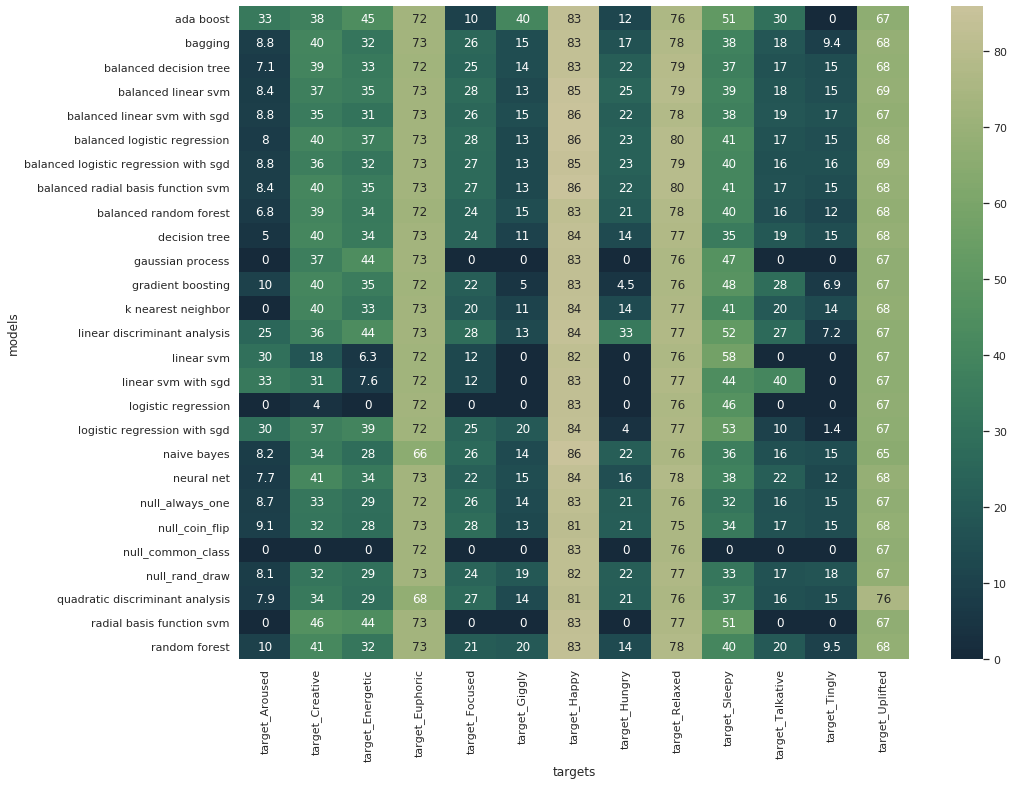

In [60]:
heat_map = pd.pivot_table(cv_results.query('measure == "precision"'), values='mean', index='models',
                    columns='targets', aggfunc=np.sum)

plot, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heat_map, annot=True, ax=ax, center=50, cmap=sns.cubehelix_palette(start=0, rot=-.70, reverse=True, as_cmap=True))

standardize to compare better, take variability into account

In [93]:
baseline = heat_map.loc['null_always_one']
baseline

targets
target_Aroused       8.72
target_Creative     32.88
target_Energetic    28.77
target_Euphoric     72.49
target_Focused      26.49
target_Giggly       13.80
target_Happy        82.52
target_Hungry       20.97
target_Relaxed      76.08
target_Sleepy       32.15
target_Talkative    16.13
target_Tingly       14.87
target_Uplifted     66.78
Name: null_always_one, dtype: float64

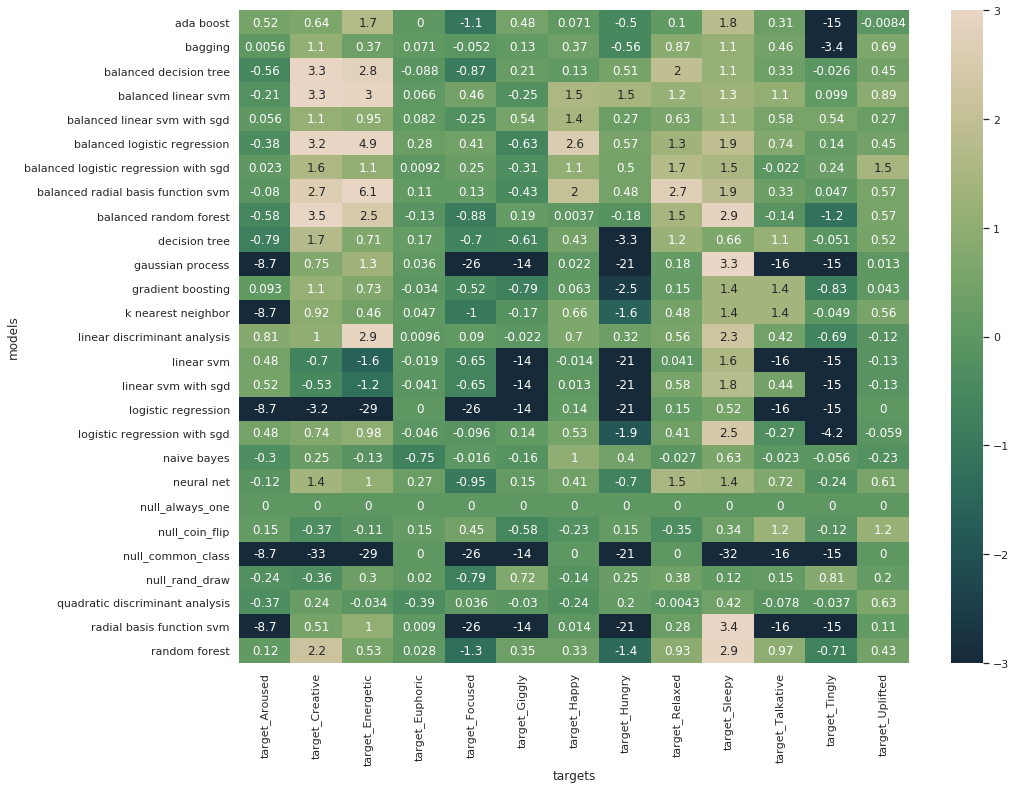

In [61]:
heat_map_standardize = (heat_map - baseline)/pd.pivot_table(cv_results.query('measure == "precision"'), 
                                                                            values='std', index='models', 
                                                                            columns='targets', aggfunc=np.sum).replace(0,1)

plot, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heat_map_standardize, annot=True, ax=ax, vmin=-3, center=0, vmax=3, cmap=sns.cubehelix_palette(start=0, rot=-.70, reverse=True, as_cmap=True))

Take_aways:
collinear variables -> PCA
unbalanced -> under sampling, oversampling


In [226]:
strings = ['pca2', 'pca55', 'nope', 'hi', 'pca100']
for s in strings:
    if 'pca' in s:
        print(s.split('pca')[1])

2
55
100


In [ ]:
# sampling trials

In [232]:
def sampler_regime(sampler, feats_cvtrain_input, feats_cvtest_input, targets_cvtrain_input, targets_cvtest_input):

    feats_cvtrain = feats_cvtrain_input 
    feats_cvtest = feats_cvtest_input
    targets_cvtrain = targets_cvtrain_input
    targets_cvtest = targets_cvtest_input

    if sampler == 'raw data':
        feats_cvtrain = feats_cvtrain_input 
        feats_cvtest = feats_cvtest_input
        targets_cvtrain = targets_cvtrain_input
        targets_cvtest = targets_cvtest_input
                
    elif 'pca' in sampler:
        n_comps = int(sampler.split('pca')[1])
        pca = PCA(n_components=n_comps)
        feats_cvtrain = pca.fit_transform(feats_cvtrain)
        feats_cvtest = pca.transform(feats_cvtest)

    elif sampler == 'random undersampling':
        rus = RandomUnderSampler(random_state=10, replacement=True)
        feats_cvtrain, targets_cvtrain = rus.fit_resample(feats_cvtrain, targets_cvtrain)
                
    elif sampler == 'tomek links':
        tlus = TomekLinks(n_jobs=-1)
        feats_cvtrain, targets_cvtrain = tlus.fit_resample(feats_cvtrain, targets_cvtrain)

    elif sampler == 'near miss':
        nmus = NearMiss(n_jobs=-1)
        feats_cvtrain, targets_cvtrain = nmus.fit_resample(feats_cvtrain, targets_cvtrain)

    elif sampler == 'all KNN undersampling':
        akus = AllKNN(n_jobs=-1)
        feats_cvtrain, targets_cvtrain = akus.fit_resample(feats_cvtrain, targets_cvtrain)
                          
    elif sampler == 'random oversampling':
        ros = RandomOverSampler(random_state=10)
        feats_cvtrain, targets_cvtrain = ros.fit_resample(feats_cvtrain, targets_cvtrain)

    elif sampler == 'adasyn':
        aos = ADASYN(random_state=10, n_jobs=-1)
        feats_cvtrain, targets_cvtrain = aos.fit_resample(feats_cvtrain, targets_cvtrain)

    elif sampler == 'smote':
        sos = SMOTE(random_state=10, n_jobs=-1)
        feats_cvtrain, targets_cvtrain = sos.fit_resample(feats_cvtrain, targets_cvtrain)

    elif sampler == 'borderline smote':
        bsos = BorderlineSMOTE(random_state=10, n_jobs=-1)
        feats_cvtrain, targets_cvtrain = bsos.fit_resample(feats_cvtrain, targets_cvtrain)

    elif sampler == 'smote enn':
        seos = SMOTEENN(random_state=10, n_jobs=-1)
        feats_cvtrain, targets_cvtrain = seos.fit_resample(feats_cvtrain, targets_cvtrain)

    elif sampler == 'smote tomek':
        stos = SMOTETomek(random_state=10, n_jobs=-1)
        feats_cvtrain, targets_cvtrain = stos.fit_resample(feats_cvtrain, targets_cvtrain)
                          
    else:
        print('unsupported sampler!')
        
    return feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest

In [83]:
estimators_to_try = ['ada boost', 'bagging', 'decision tree', 'balanced decision tree', 'gaussian process', 
                     'gradient boosting', 'k nearest neighbor', 'linear discriminant analysis', 
                     'linear svm', 'balanced linear svm', 'linear svm with sgd', 'balanced linear svm with sgd', 
                     'logistic regression', 'balanced logistic regression', 'logistic regression with sgd', 
                     'balanced logistic regression with sgd', 'naive bayes', 'neural net', 
                     'radial basis function svm', 'balanced radial basis function svm', 'random forest', 
                     'balanced random forest', 'quadratic discriminant analysis']

null_to_try = ['null_rand_draw', 'null_coin_flip', 'null_always_one', 'null_common_class']

samplers_to_try = ['raw data', 'pca42', 'pca36', 'pca30', 'random undersampling', 'tomek links', 'near miss', 
                   'all KNN undersampling', 'random oversampling', 'adasyn', 'smote', 'borderline smote', 
                   'smote enn', 'smote tomek']

number_of_folds = 5

######################################################################################################################

seed(10)
kf = KFold(n_splits=number_of_folds)
kf.get_n_splits(feats_train)

fold_num = 0
models = []
target_of_model = []
samplers = []
cv_results = pd.DataFrame()

for cvtrain_index, cvtest_index in kf.split(feats_train):
    fold_scores = []
    fold_num +=1
    print('*************************************')
    print("fold " + str(fold_num))
    print('*************************************')

    for target_column in targets.columns:
        print(target_column)
        feats_cvtrain_0, feats_cvtest_0 = feats_train.iloc[cvtrain_index], feats_train.iloc[cvtest_index]
        targets_cvtrain_0, targets_cvtest_0 = targets_train.iloc[cvtrain_index][target_column], targets_train.iloc[cvtest_index][target_column]
        
        for s in samplers_to_try:
            feats_cvtrain = feats_cvtrain_0.copy(deep=True)
            feats_cvtest = feats_cvtest_0.copy(deep=True)
            targets_cvtrain = targets_cvtrain_0.copy(deep=True)
            targets_cvtest = targets_cvtest_0.copy(deep=True)
            
            feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest = sampler_regime(s, feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest)
            
            
            for null in null_to_try:
                if fold_num == 1:
                    models.append(null)
                    samplers.append(s)
                    target_of_model.append(target_column)
                fold_scores.extend(list(null_model(null, target_column, targets_cvtest)))
        
    
            for estimator in estimators_to_try:
                if fold_num == 1:
                    models.append(estimator)
                    samplers.append(s)
                    target_of_model.append(target_column)
                fold_scores.extend(list(estimator_single(estimator, feats_cvtrain, targets_cvtrain, feats_cvtest, targets_cvtest)))
        
    cv_results['fold_' + str(fold_num)] = fold_scores

    
cv_results['models'] = [m for mods in models for m in 3*[mods]]
cv_results['measure'] = ['balanced_accuracy', 'precision', 'f-Beta'] * len(models)
cv_results['targets'] = [t for targs in target_of_model for t in 3*[targs]]
cv_results['samplers'] = [s for samps in samplers for s in 3*[samps]]
cv_results['mean'] = list(round(cv_results.T[cv_results.columns.str.contains('fold')].mean(),2))
cv_results['std'] = list(round(cv_results.T[cv_results.columns.str.contains('fold')].std(),2))
cv_results['se'] = cv_results['std']/np.sqrt(fold_num)

fold 1
target_Aroused
raw data
Resampled dataset shape Counter({0: 1509, 1: 143})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1509, 1: 143})
pca36
Resampled dataset shape Counter({0: 1509, 1: 143})
pca30
Resampled dataset shape Counter({0: 1509, 1: 143})
random undersampling
Resampled dataset shape Counter({0: 143, 1: 143})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1508, 1: 143})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 143, 1: 143})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1357, 1: 143})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1509, 1: 1509})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1534, 0: 1509})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1509, 1: 1509})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1509, 1: 1509})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 784, 1: 746})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1508, 1: 1508})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Creative
raw data
Resampled dataset shape Counter({0: 1116, 1: 536})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1116, 1: 536})
pca36
Resampled dataset shape Counter({0: 1116, 1: 536})
pca30
Resampled dataset shape Counter({0: 1116, 1: 536})
random undersampling
Resampled dataset shape Counter({0: 536, 1: 536})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1114, 1: 536})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 536, 1: 536})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 718, 1: 536})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1116, 1: 1116})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1116, 1: 1088})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1116, 1: 1116})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1116, 1: 1116})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 399, 1: 361})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1112, 1: 1112})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Energetic
raw data
Resampled dataset shape Counter({0: 1164, 1: 488})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1164, 1: 488})
pca36
Resampled dataset shape Counter({0: 1164, 1: 488})
pca30
Resampled dataset shape Counter({0: 1164, 1: 488})
random undersampling
Resampled dataset shape Counter({0: 488, 1: 488})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1163, 1: 488})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 488, 1: 488})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 680, 1: 488})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1164, 1: 1164})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1164, 1: 1148})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1164, 1: 1164})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1164, 1: 1164})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 429, 0: 403})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1162, 1: 1162})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Euphoric
raw data
Resampled dataset shape Counter({1: 1184, 0: 468})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1184, 0: 468})
pca36
Resampled dataset shape Counter({1: 1184, 0: 468})
pca30
Resampled dataset shape Counter({1: 1184, 0: 468})
random undersampling
Resampled dataset shape Counter({0: 468, 1: 468})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1181, 0: 468})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 468, 1: 468})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 468, 1: 121})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1184, 0: 1184})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1184, 0: 1103})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1184, 0: 1184})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1184, 0: 1184})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 431, 1: 362})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1184, 0: 1184})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Focused
raw data
Resampled dataset shape Counter({0: 1196, 1: 456})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1196, 1: 456})
pca36
Resampled dataset shape Counter({0: 1196, 1: 456})
pca30
Resampled dataset shape Counter({0: 1196, 1: 456})
random undersampling
Resampled dataset shape Counter({0: 456, 1: 456})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1196, 1: 456})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 456, 1: 456})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 813, 1: 456})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1196, 1: 1196})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1196, 1: 1161})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1196, 1: 1196})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1196, 1: 1196})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 363, 0: 338})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1194, 1: 1194})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Giggly
raw data
Resampled dataset shape Counter({0: 1421, 1: 231})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1421, 1: 231})
pca36
Resampled dataset shape Counter({0: 1421, 1: 231})
pca30
Resampled dataset shape Counter({0: 1421, 1: 231})
random undersampling
Resampled dataset shape Counter({0: 231, 1: 231})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1419, 1: 231})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 231, 1: 231})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1181, 1: 231})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1421, 1: 1421})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1421, 1: 1418})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1421, 1: 1421})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1421, 1: 1421})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 739, 1: 579})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1419, 1: 1419})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Happy
raw data
Resampled dataset shape Counter({1: 1364, 0: 288})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1364, 0: 288})
pca36
Resampled dataset shape Counter({1: 1364, 0: 288})
pca30
Resampled dataset shape Counter({1: 1364, 0: 288})
random undersampling
Resampled dataset shape Counter({0: 288, 1: 288})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1360, 0: 288})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 288, 1: 288})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 288, 1: 223})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1364, 0: 1364})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1364, 0: 1325})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1364, 0: 1364})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1364, 0: 1364})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 726, 1: 585})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1359, 0: 1359})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Hungry
raw data
Resampled dataset shape Counter({0: 1305, 1: 347})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1305, 1: 347})
pca36
Resampled dataset shape Counter({0: 1305, 1: 347})
pca30
Resampled dataset shape Counter({0: 1305, 1: 347})
random undersampling
Resampled dataset shape Counter({0: 347, 1: 347})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1303, 1: 347})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 347, 1: 347})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 940, 1: 347})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1305, 0: 1305})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1305, 1: 1232})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1305, 0: 1305})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1305, 0: 1305})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 487, 1: 384})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1305, 0: 1305})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Relaxed
raw data
Resampled dataset shape Counter({1: 1249, 0: 403})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1249, 0: 403})
pca36
Resampled dataset shape Counter({1: 1249, 0: 403})
pca30
Resampled dataset shape Counter({1: 1249, 0: 403})
random undersampling
Resampled dataset shape Counter({0: 403, 1: 403})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1247, 0: 403})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 403, 1: 403})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 403, 1: 236})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1249, 0: 1249})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1249, 0: 1197})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1249, 0: 1249})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1249, 0: 1249})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 541, 1: 503})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1244, 0: 1244})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Sleepy
raw data
Resampled dataset shape Counter({0: 1118, 1: 534})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1118, 1: 534})
pca36
Resampled dataset shape Counter({0: 1118, 1: 534})
pca30
Resampled dataset shape Counter({0: 1118, 1: 534})
random undersampling
Resampled dataset shape Counter({0: 534, 1: 534})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1116, 1: 534})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 534, 1: 534})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 663, 1: 534})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1118, 0: 1118})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1155, 0: 1118})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1118, 0: 1118})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1118, 0: 1118})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 351, 1: 326})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1115, 0: 1115})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Talkative
raw data
Resampled dataset shape Counter({0: 1383, 1: 269})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1383, 1: 269})
pca36
Resampled dataset shape Counter({0: 1383, 1: 269})
pca30
Resampled dataset shape Counter({0: 1383, 1: 269})
random undersampling
Resampled dataset shape Counter({0: 269, 1: 269})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1382, 1: 269})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 269, 1: 269})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1088, 1: 269})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1383, 1: 1383})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1383, 1: 1351})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1383, 1: 1383})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1383, 1: 1383})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 722, 0: 660})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1383, 1: 1383})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Tingly
raw data
Resampled dataset shape Counter({0: 1416, 1: 236})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1416, 1: 236})
pca36
Resampled dataset shape Counter({0: 1416, 1: 236})
pca30
Resampled dataset shape Counter({0: 1416, 1: 236})
random undersampling
Resampled dataset shape Counter({0: 236, 1: 236})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1412, 1: 236})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 236, 1: 236})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1100, 1: 236})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1416, 1: 1416})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1429, 0: 1416})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1416, 1: 1416})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1416, 1: 1416})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 659, 0: 561})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1412, 1: 1412})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Uplifted
raw data
Resampled dataset shape Counter({1: 1105, 0: 547})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1105, 0: 547})
pca36
Resampled dataset shape Counter({1: 1105, 0: 547})
pca30
Resampled dataset shape Counter({1: 1105, 0: 547})
random undersampling
Resampled dataset shape Counter({0: 547, 1: 547})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1101, 0: 547})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 547, 1: 547})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 547, 1: 121})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1105, 1: 1105})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1105, 0: 1065})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1105, 1: 1105})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1105, 1: 1105})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 370, 1: 289})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1101, 1: 1101})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


fold 2
target_Aroused
raw data
Resampled dataset shape Counter({0: 1516, 1: 136})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1516, 1: 136})
pca36
Resampled dataset shape Counter({0: 1516, 1: 136})
pca30
Resampled dataset shape Counter({0: 1516, 1: 136})
random undersampling
Resampled dataset shape Counter({0: 136, 1: 136})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1515, 1: 136})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 136, 1: 136})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1368, 1: 136})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1516, 1: 1516})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1516, 1: 1503})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1516, 1: 1516})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1516, 1: 1516})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 923, 1: 910})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1516, 1: 1516})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Creative
raw data
Resampled dataset shape Counter({0: 1108, 1: 544})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1108, 1: 544})
pca36
Resampled dataset shape Counter({0: 1108, 1: 544})
pca30
Resampled dataset shape Counter({0: 1108, 1: 544})
random undersampling
Resampled dataset shape Counter({0: 544, 1: 544})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1106, 1: 544})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 544, 1: 544})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 738, 1: 544})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1108, 0: 1108})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1108, 1: 1103})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1108, 0: 1108})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1108, 0: 1108})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 364, 1: 345})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1100, 0: 1100})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Energetic
raw data
Resampled dataset shape Counter({0: 1170, 1: 482})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1170, 1: 482})
pca36
Resampled dataset shape Counter({0: 1170, 1: 482})
pca30
Resampled dataset shape Counter({0: 1170, 1: 482})
random undersampling
Resampled dataset shape Counter({0: 482, 1: 482})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1168, 1: 482})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 482, 1: 482})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 761, 1: 482})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1170, 1: 1170})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1170, 1: 1128})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1170, 1: 1170})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1170, 1: 1170})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 459, 0: 342})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1166, 1: 1166})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Euphoric
raw data
Resampled dataset shape Counter({1: 1210, 0: 442})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1210, 0: 442})
pca36
Resampled dataset shape Counter({1: 1210, 0: 442})
pca30
Resampled dataset shape Counter({1: 1210, 0: 442})
random undersampling
Resampled dataset shape Counter({0: 442, 1: 442})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1207, 0: 442})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 442, 1: 442})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 442, 1: 138})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1210, 0: 1210})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1296, 1: 1210})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1210, 0: 1210})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1210, 0: 1210})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 548, 1: 402})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1207, 0: 1207})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Focused
raw data
Resampled dataset shape Counter({0: 1218, 1: 434})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1218, 1: 434})
pca36
Resampled dataset shape Counter({0: 1218, 1: 434})
pca30
Resampled dataset shape Counter({0: 1218, 1: 434})
random undersampling
Resampled dataset shape Counter({0: 434, 1: 434})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1215, 1: 434})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 434, 1: 434})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 854, 1: 434})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1218, 1: 1218})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1312, 0: 1218})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1218, 1: 1218})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1218, 1: 1218})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 437, 0: 383})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1214, 1: 1214})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Giggly
raw data
Resampled dataset shape Counter({0: 1414, 1: 238})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1414, 1: 238})
pca36
Resampled dataset shape Counter({0: 1414, 1: 238})
pca30
Resampled dataset shape Counter({0: 1414, 1: 238})
random undersampling
Resampled dataset shape Counter({0: 238, 1: 238})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1412, 1: 238})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 238, 1: 238})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1113, 1: 238})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1414, 1: 1414})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1420, 0: 1414})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1414, 1: 1414})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1414, 1: 1414})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 785, 0: 767})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1413, 1: 1413})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Happy
raw data
Resampled dataset shape Counter({1: 1372, 0: 280})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1372, 0: 280})
pca36
Resampled dataset shape Counter({1: 1372, 0: 280})
pca30
Resampled dataset shape Counter({1: 1372, 0: 280})
random undersampling
Resampled dataset shape Counter({0: 280, 1: 280})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1368, 0: 280})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 280, 1: 280})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 280, 1: 200})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1372, 0: 1372})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1372, 0: 1311})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1372, 0: 1372})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1372, 0: 1372})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 652, 0: 646})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1369, 0: 1369})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Hungry
raw data
Resampled dataset shape Counter({0: 1315, 1: 337})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1315, 1: 337})
pca36
Resampled dataset shape Counter({0: 1315, 1: 337})
pca30
Resampled dataset shape Counter({0: 1315, 1: 337})
random undersampling
Resampled dataset shape Counter({0: 337, 1: 337})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1314, 1: 337})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 337, 1: 337})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 988, 1: 337})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1315, 1: 1315})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1315, 1: 1300})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1315, 1: 1315})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1315, 1: 1315})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 545, 1: 441})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1313, 1: 1313})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Relaxed
raw data
Resampled dataset shape Counter({1: 1252, 0: 400})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1252, 0: 400})
pca36
Resampled dataset shape Counter({1: 1252, 0: 400})
pca30
Resampled dataset shape Counter({1: 1252, 0: 400})
random undersampling
Resampled dataset shape Counter({0: 400, 1: 400})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1249, 0: 400})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 400, 1: 400})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 400, 1: 198})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1252, 0: 1252})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1306, 1: 1252})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1252, 0: 1252})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1252, 0: 1252})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 682, 1: 514})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1247, 0: 1247})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Sleepy
raw data
Resampled dataset shape Counter({0: 1145, 1: 507})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1145, 1: 507})
pca36
Resampled dataset shape Counter({0: 1145, 1: 507})
pca30
Resampled dataset shape Counter({0: 1145, 1: 507})
random undersampling
Resampled dataset shape Counter({0: 507, 1: 507})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1141, 1: 507})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 507, 1: 507})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 707, 1: 507})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1145, 1: 1145})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1145, 1: 1101})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1145, 1: 1145})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1145, 1: 1145})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 307, 0: 305})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1139, 1: 1139})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Talkative
raw data
Resampled dataset shape Counter({0: 1374, 1: 278})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1374, 1: 278})
pca36
Resampled dataset shape Counter({0: 1374, 1: 278})
pca30
Resampled dataset shape Counter({0: 1374, 1: 278})
random undersampling
Resampled dataset shape Counter({0: 278, 1: 278})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1374, 1: 278})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 278, 1: 278})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 964, 1: 278})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1374, 0: 1374})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1374, 1: 1308})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1374, 0: 1374})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1374, 0: 1374})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 709, 0: 678})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1373, 0: 1373})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Tingly
raw data
Resampled dataset shape Counter({0: 1410, 1: 242})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1410, 1: 242})
pca36
Resampled dataset shape Counter({0: 1410, 1: 242})
pca30
Resampled dataset shape Counter({0: 1410, 1: 242})
random undersampling
Resampled dataset shape Counter({0: 242, 1: 242})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1407, 1: 242})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 242, 1: 242})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1088, 1: 242})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1410, 1: 1410})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1410, 1: 1405})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1410, 1: 1410})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1410, 1: 1410})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 757, 0: 513})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1408, 1: 1408})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Uplifted
raw data
Resampled dataset shape Counter({1: 1105, 0: 547})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1105, 0: 547})
pca36
Resampled dataset shape Counter({1: 1105, 0: 547})
pca30
Resampled dataset shape Counter({1: 1105, 0: 547})
random undersampling
Resampled dataset shape Counter({0: 547, 1: 547})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1102, 0: 547})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 547, 1: 547})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 547, 1: 132})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1105, 1: 1105})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1119, 1: 1105})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1105, 1: 1105})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1105, 1: 1105})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 422, 1: 312})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1102, 1: 1102})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


fold 3
target_Aroused
raw data
Resampled dataset shape Counter({0: 1512, 1: 140})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1512, 1: 140})
pca36
Resampled dataset shape Counter({0: 1512, 1: 140})
pca30
Resampled dataset shape Counter({0: 1512, 1: 140})
random undersampling
Resampled dataset shape Counter({0: 140, 1: 140})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1510, 1: 140})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 140, 1: 140})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1322, 1: 140})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1512, 1: 1512})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1512, 1: 1502})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1512, 1: 1512})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1512, 1: 1512})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 963, 1: 794})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1510, 1: 1510})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Creative
raw data
Resampled dataset shape Counter({0: 1114, 1: 538})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1114, 1: 538})
pca36
Resampled dataset shape Counter({0: 1114, 1: 538})
pca30
Resampled dataset shape Counter({0: 1114, 1: 538})
random undersampling
Resampled dataset shape Counter({0: 538, 1: 538})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1110, 1: 538})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 538, 1: 538})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 751, 1: 538})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1114, 0: 1114})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1114, 1: 1089})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1114, 0: 1114})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1114, 0: 1114})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 428, 1: 364})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1109, 0: 1109})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Energetic
raw data
Resampled dataset shape Counter({0: 1181, 1: 471})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1181, 1: 471})
pca36
Resampled dataset shape Counter({0: 1181, 1: 471})
pca30
Resampled dataset shape Counter({0: 1181, 1: 471})
random undersampling
Resampled dataset shape Counter({0: 471, 1: 471})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1179, 1: 471})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 471, 1: 471})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 787, 1: 471})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1181, 1: 1181})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1181, 1: 1154})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1181, 1: 1181})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1181, 1: 1181})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 504, 0: 372})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1175, 1: 1175})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Euphoric
raw data
Resampled dataset shape Counter({1: 1183, 0: 469})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1183, 0: 469})
pca36
Resampled dataset shape Counter({1: 1183, 0: 469})
pca30
Resampled dataset shape Counter({1: 1183, 0: 469})
random undersampling
Resampled dataset shape Counter({0: 469, 1: 469})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1179, 0: 469})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 469, 1: 469})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 469, 1: 148})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1183, 0: 1183})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1183, 0: 1154})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1183, 0: 1183})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1183, 0: 1183})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 490, 1: 376})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1179, 0: 1179})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Focused
raw data
Resampled dataset shape Counter({0: 1214, 1: 438})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1214, 1: 438})
pca36
Resampled dataset shape Counter({0: 1214, 1: 438})
pca30
Resampled dataset shape Counter({0: 1214, 1: 438})
random undersampling
Resampled dataset shape Counter({0: 438, 1: 438})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1210, 1: 438})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 438, 1: 438})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 883, 1: 438})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1214, 1: 1214})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1214, 1: 1129})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1214, 1: 1214})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1214, 1: 1214})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 407, 0: 381})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1211, 1: 1211})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Giggly
raw data
Resampled dataset shape Counter({0: 1426, 1: 226})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1426, 1: 226})
pca36
Resampled dataset shape Counter({0: 1426, 1: 226})
pca30
Resampled dataset shape Counter({0: 1426, 1: 226})
random undersampling
Resampled dataset shape Counter({0: 226, 1: 226})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1425, 1: 226})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 226, 1: 226})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1179, 1: 226})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1426, 1: 1426})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1454, 0: 1426})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1426, 1: 1426})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1426, 1: 1426})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 806, 0: 764})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1424, 1: 1424})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Happy
raw data
Resampled dataset shape Counter({1: 1370, 0: 282})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1370, 0: 282})
pca36
Resampled dataset shape Counter({1: 1370, 0: 282})
pca30
Resampled dataset shape Counter({1: 1370, 0: 282})
random undersampling
Resampled dataset shape Counter({0: 282, 1: 282})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1365, 0: 282})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 282, 1: 282})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 282, 1: 218})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1370, 0: 1370})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1370, 0: 1297})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1370, 0: 1370})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1370, 0: 1370})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 731, 0: 663})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1366, 0: 1366})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Hungry
raw data
Resampled dataset shape Counter({0: 1308, 1: 344})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1308, 1: 344})
pca36
Resampled dataset shape Counter({0: 1308, 1: 344})
pca30
Resampled dataset shape Counter({0: 1308, 1: 344})
random undersampling
Resampled dataset shape Counter({0: 344, 1: 344})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1306, 1: 344})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 344, 1: 344})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 994, 1: 344})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1308, 1: 1308})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1312, 0: 1308})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1308, 1: 1308})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1308, 1: 1308})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 517, 0: 512})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1307, 1: 1307})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Relaxed
raw data
Resampled dataset shape Counter({1: 1271, 0: 381})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1271, 0: 381})
pca36
Resampled dataset shape Counter({1: 1271, 0: 381})
pca30
Resampled dataset shape Counter({1: 1271, 0: 381})
random undersampling
Resampled dataset shape Counter({0: 381, 1: 381})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1266, 0: 381})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 381, 1: 381})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 381, 1: 196})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1271, 0: 1271})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1300, 1: 1271})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1271, 0: 1271})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1271, 0: 1271})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 589, 1: 534})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1269, 0: 1269})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Sleepy
raw data
Resampled dataset shape Counter({0: 1104, 1: 548})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1104, 1: 548})
pca36
Resampled dataset shape Counter({0: 1104, 1: 548})
pca30
Resampled dataset shape Counter({0: 1104, 1: 548})
random undersampling
Resampled dataset shape Counter({0: 548, 1: 548})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1099, 1: 548})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 548, 1: 548})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 657, 1: 548})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1104, 1: 1104})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1104, 1: 1063})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1104, 1: 1104})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1104, 1: 1104})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 363, 0: 315})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1100, 1: 1100})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Talkative
raw data
Resampled dataset shape Counter({0: 1391, 1: 261})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1391, 1: 261})
pca36
Resampled dataset shape Counter({0: 1391, 1: 261})
pca30
Resampled dataset shape Counter({0: 1391, 1: 261})
random undersampling
Resampled dataset shape Counter({0: 261, 1: 261})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1389, 1: 261})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 261, 1: 261})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1017, 1: 261})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1391, 0: 1391})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1445, 0: 1391})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1391, 0: 1391})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1391, 0: 1391})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 757, 1: 688})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1390, 0: 1390})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Tingly
raw data
Resampled dataset shape Counter({0: 1410, 1: 242})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1410, 1: 242})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca36
Resampled dataset shape Counter({0: 1410, 1: 242})
pca30
Resampled dataset shape Counter({0: 1410, 1: 242})
random undersampling
Resampled dataset shape Counter({0: 242, 1: 242})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1407, 1: 242})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 242, 1: 242})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1050, 1: 242})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1410, 1: 1410})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1424, 0: 1410})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1410, 1: 1410})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1410, 1: 1410})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 716, 0: 532})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1407, 1: 1407})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Uplifted
raw data
Resampled dataset shape Counter({1: 1109, 0: 543})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1109, 0: 543})
pca36
Resampled dataset shape Counter({1: 1109, 0: 543})
pca30
Resampled dataset shape Counter({1: 1109, 0: 543})
random undersampling
Resampled dataset shape Counter({0: 543, 1: 543})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1105, 0: 543})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 543, 1: 543})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 543, 1: 126})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1109, 1: 1109})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1109, 0: 1099})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1109, 1: 1109})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1109, 1: 1109})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 365, 1: 333})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1106, 1: 1106})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


fold 4
target_Aroused
raw data
Resampled dataset shape Counter({0: 1502, 1: 150})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1502, 1: 150})
pca36
Resampled dataset shape Counter({0: 1502, 1: 150})
pca30
Resampled dataset shape Counter({0: 1502, 1: 150})
random undersampling
Resampled dataset shape Counter({0: 150, 1: 150})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1501, 1: 150})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 150, 1: 150})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1284, 1: 150})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1502, 1: 1502})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1535, 0: 1502})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1502, 1: 1502})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1502, 1: 1502})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 884, 1: 737})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1500, 1: 1500})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Creative
raw data
Resampled dataset shape Counter({0: 1111, 1: 541})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1111, 1: 541})
pca36
Resampled dataset shape Counter({0: 1111, 1: 541})
pca30
Resampled dataset shape Counter({0: 1111, 1: 541})
random undersampling
Resampled dataset shape Counter({0: 541, 1: 541})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1105, 1: 541})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 541, 1: 541})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 736, 1: 541})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1111, 0: 1111})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1111, 1: 1091})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1111, 0: 1111})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1111, 0: 1111})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 441, 0: 432})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1108, 0: 1108})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Energetic
raw data
Resampled dataset shape Counter({0: 1188, 1: 464})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1188, 1: 464})
pca36
Resampled dataset shape Counter({0: 1188, 1: 464})
pca30
Resampled dataset shape Counter({0: 1188, 1: 464})
random undersampling
Resampled dataset shape Counter({0: 464, 1: 464})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1186, 1: 464})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 464, 1: 464})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 785, 1: 464})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1188, 1: 1188})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1188, 1: 1119})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1188, 1: 1188})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1188, 1: 1188})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 490, 0: 410})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1184, 1: 1184})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Euphoric
raw data
Resampled dataset shape Counter({1: 1199, 0: 453})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1199, 0: 453})
pca36
Resampled dataset shape Counter({1: 1199, 0: 453})
pca30
Resampled dataset shape Counter({1: 1199, 0: 453})
random undersampling
Resampled dataset shape Counter({0: 453, 1: 453})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1194, 0: 453})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 453, 1: 453})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 453, 1: 153})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1199, 0: 1199})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1199, 0: 1093})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1199, 0: 1199})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1199, 0: 1199})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 504, 1: 392})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1197, 0: 1197})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Focused
raw data
Resampled dataset shape Counter({0: 1220, 1: 432})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1220, 1: 432})
pca36
Resampled dataset shape Counter({0: 1220, 1: 432})
pca30
Resampled dataset shape Counter({0: 1220, 1: 432})
random undersampling
Resampled dataset shape Counter({0: 432, 1: 432})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1215, 1: 432})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 432, 1: 432})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 880, 1: 432})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1220, 1: 1220})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1220, 1: 1119})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1220, 1: 1220})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1220, 1: 1220})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 402, 0: 395})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1216, 1: 1216})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Giggly
raw data
Resampled dataset shape Counter({0: 1428, 1: 224})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1428, 1: 224})
pca36
Resampled dataset shape Counter({0: 1428, 1: 224})
pca30
Resampled dataset shape Counter({0: 1428, 1: 224})
random undersampling
Resampled dataset shape Counter({0: 224, 1: 224})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1425, 1: 224})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 224, 1: 224})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1185, 1: 224})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1428, 1: 1428})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1431, 0: 1428})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1428, 1: 1428})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1428, 1: 1428})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 707, 1: 693})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1426, 1: 1426})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Happy
raw data
Resampled dataset shape Counter({1: 1350, 0: 302})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1350, 0: 302})
pca36
Resampled dataset shape Counter({1: 1350, 0: 302})
pca30
Resampled dataset shape Counter({1: 1350, 0: 302})
random undersampling
Resampled dataset shape Counter({0: 302, 1: 302})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1342, 0: 302})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 302, 1: 302})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 302, 1: 275})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1350, 0: 1350})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1372, 1: 1350})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1350, 0: 1350})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1350, 0: 1350})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 689, 1: 668})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1345, 0: 1345})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Hungry
raw data
Resampled dataset shape Counter({0: 1301, 1: 351})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1301, 1: 351})
pca36
Resampled dataset shape Counter({0: 1301, 1: 351})
pca30
Resampled dataset shape Counter({0: 1301, 1: 351})
random undersampling
Resampled dataset shape Counter({0: 351, 1: 351})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1297, 1: 351})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 351, 1: 351})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1005, 1: 351})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1301, 1: 1301})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1339, 0: 1301})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1301, 1: 1301})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1301, 1: 1301})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 521, 1: 474})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1299, 1: 1299})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Relaxed
raw data
Resampled dataset shape Counter({1: 1259, 0: 393})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1259, 0: 393})
pca36
Resampled dataset shape Counter({1: 1259, 0: 393})
pca30
Resampled dataset shape Counter({1: 1259, 0: 393})
random undersampling
Resampled dataset shape Counter({0: 393, 1: 393})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1254, 0: 393})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 393, 1: 393})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 393, 1: 205})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1259, 0: 1259})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1303, 1: 1259})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1259, 0: 1259})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1259, 0: 1259})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 602, 1: 543})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1257, 0: 1257})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Sleepy
raw data
Resampled dataset shape Counter({0: 1114, 1: 538})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1114, 1: 538})
pca36
Resampled dataset shape Counter({0: 1114, 1: 538})
pca30
Resampled dataset shape Counter({0: 1114, 1: 538})
random undersampling
Resampled dataset shape Counter({0: 538, 1: 538})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1108, 1: 538})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 538, 1: 538})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 685, 1: 538})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1114, 1: 1114})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1114, 1: 1037})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1114, 1: 1114})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1114, 1: 1114})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 346, 0: 280})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1109, 1: 1109})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Talkative
raw data
Resampled dataset shape Counter({0: 1389, 1: 263})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1389, 1: 263})
pca36
Resampled dataset shape Counter({0: 1389, 1: 263})
pca30
Resampled dataset shape Counter({0: 1389, 1: 263})
random undersampling
Resampled dataset shape Counter({0: 263, 1: 263})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1388, 1: 263})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 263, 1: 263})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 999, 1: 263})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1389, 0: 1389})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1422, 0: 1389})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1389, 0: 1389})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1389, 0: 1389})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 746, 0: 730})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1388, 0: 1388})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Tingly
raw data
Resampled dataset shape Counter({0: 1393, 1: 259})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1393, 1: 259})
pca36
Resampled dataset shape Counter({0: 1393, 1: 259})
pca30
Resampled dataset shape Counter({0: 1393, 1: 259})
random undersampling
Resampled dataset shape Counter({0: 259, 1: 259})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1388, 1: 259})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 259, 1: 259})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1031, 1: 259})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1393, 1: 1393})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1396, 0: 1393})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1393, 1: 1393})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1393, 1: 1393})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 679, 0: 495})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1387, 1: 1387})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Uplifted
raw data
Resampled dataset shape Counter({1: 1100, 0: 552})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1100, 0: 552})
pca36
Resampled dataset shape Counter({1: 1100, 0: 552})
pca30
Resampled dataset shape Counter({1: 1100, 0: 552})
random undersampling
Resampled dataset shape Counter({0: 552, 1: 552})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1094, 0: 552})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 552, 1: 552})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 552, 1: 150})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1100, 1: 1100})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1160, 1: 1100})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1100, 1: 1100})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1100, 1: 1100})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 317, 0: 316})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1099, 1: 1099})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


fold 5
target_Aroused
raw data
Resampled dataset shape Counter({0: 1501, 1: 151})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1501, 1: 151})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca36
Resampled dataset shape Counter({0: 1501, 1: 151})
pca30
Resampled dataset shape Counter({0: 1501, 1: 151})
random undersampling
Resampled dataset shape Counter({0: 151, 1: 151})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1501, 1: 151})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 151, 1: 151})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1287, 1: 151})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1501, 1: 1501})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1549, 0: 1501})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1501, 1: 1501})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1501, 1: 1501})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 890, 1: 767})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1501, 1: 1501})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Creative
raw data
Resampled dataset shape Counter({0: 1095, 1: 557})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1095, 1: 557})
pca36
Resampled dataset shape Counter({0: 1095, 1: 557})
pca30
Resampled dataset shape Counter({0: 1095, 1: 557})
random undersampling
Resampled dataset shape Counter({0: 557, 1: 557})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1093, 1: 557})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 557, 1: 557})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 738, 1: 557})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1095, 0: 1095})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1134, 0: 1095})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1095, 0: 1095})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1095, 0: 1095})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 366, 0: 301})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1089, 0: 1089})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Energetic
raw data
Resampled dataset shape Counter({0: 1181, 1: 471})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1181, 1: 471})
pca36
Resampled dataset shape Counter({0: 1181, 1: 471})
pca30
Resampled dataset shape Counter({0: 1181, 1: 471})
random undersampling
Resampled dataset shape Counter({0: 471, 1: 471})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1181, 1: 471})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 471, 1: 471})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 828, 1: 471})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1181, 1: 1181})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1181, 1: 1135})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1181, 1: 1181})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1181, 1: 1181})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 488, 0: 377})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1178, 1: 1178})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Euphoric
raw data
Resampled dataset shape Counter({1: 1212, 0: 440})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1212, 0: 440})
pca36
Resampled dataset shape Counter({1: 1212, 0: 440})
pca30
Resampled dataset shape Counter({1: 1212, 0: 440})
random undersampling
Resampled dataset shape Counter({0: 440, 1: 440})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1206, 0: 440})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 440, 1: 440})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 440, 1: 147})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1212, 0: 1212})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1329, 1: 1212})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1212, 0: 1212})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1212, 0: 1212})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 530, 1: 400})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1206, 0: 1206})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Focused
raw data
Resampled dataset shape Counter({0: 1224, 1: 428})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1224, 1: 428})
pca36
Resampled dataset shape Counter({0: 1224, 1: 428})
pca30
Resampled dataset shape Counter({0: 1224, 1: 428})
random undersampling
Resampled dataset shape Counter({0: 428, 1: 428})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1222, 1: 428})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 428, 1: 428})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 857, 1: 428})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1224, 1: 1224})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1310, 0: 1224})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1224, 1: 1224})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1224, 1: 1224})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 397, 1: 384})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1219, 1: 1219})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Giggly
raw data
Resampled dataset shape Counter({0: 1431, 1: 221})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1431, 1: 221})
pca36
Resampled dataset shape Counter({0: 1431, 1: 221})
pca30
Resampled dataset shape Counter({0: 1431, 1: 221})
random undersampling
Resampled dataset shape Counter({0: 221, 1: 221})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1428, 1: 221})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 221, 1: 221})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1110, 1: 221})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1431, 1: 1431})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1431, 1: 1419})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1431, 1: 1431})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1431, 1: 1431})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 713, 1: 671})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1427, 1: 1427})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Happy
raw data
Resampled dataset shape Counter({1: 1360, 0: 292})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1360, 0: 292})
pca36
Resampled dataset shape Counter({1: 1360, 0: 292})
pca30
Resampled dataset shape Counter({1: 1360, 0: 292})
random undersampling
Resampled dataset shape Counter({0: 292, 1: 292})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1355, 0: 292})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 292, 1: 292})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 292, 1: 207})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1360, 0: 1360})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1360, 0: 1320})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1360, 0: 1360})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1360, 0: 1360})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 708, 1: 650})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1355, 0: 1355})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Hungry
raw data
Resampled dataset shape Counter({0: 1299, 1: 353})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1299, 1: 353})
pca36
Resampled dataset shape Counter({0: 1299, 1: 353})
pca30
Resampled dataset shape Counter({0: 1299, 1: 353})
random undersampling
Resampled dataset shape Counter({0: 353, 1: 353})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1296, 1: 353})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 353, 1: 353})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1023, 1: 353})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1299, 1: 1299})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1351, 0: 1299})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1299, 1: 1299})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1299, 1: 1299})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 513, 1: 393})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1296, 1: 1296})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Relaxed
raw data
Resampled dataset shape Counter({1: 1253, 0: 399})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1253, 0: 399})
pca36
Resampled dataset shape Counter({1: 1253, 0: 399})
pca30
Resampled dataset shape Counter({1: 1253, 0: 399})
random undersampling
Resampled dataset shape Counter({0: 399, 1: 399})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1249, 0: 399})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 399, 1: 399})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 399, 1: 223})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1253, 0: 1253})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1304, 1: 1253})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1253, 0: 1253})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1253, 0: 1253})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 599, 1: 514})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1250, 0: 1250})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Sleepy
raw data
Resampled dataset shape Counter({0: 1123, 1: 529})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1123, 1: 529})
pca36
Resampled dataset shape Counter({0: 1123, 1: 529})
pca30
Resampled dataset shape Counter({0: 1123, 1: 529})
random undersampling
Resampled dataset shape Counter({0: 529, 1: 529})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1119, 1: 529})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 529, 1: 529})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 686, 1: 529})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1123, 1: 1123})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1136, 0: 1123})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1123, 1: 1123})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1123, 1: 1123})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 362, 0: 327})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1120, 1: 1120})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Talkative
raw data
Resampled dataset shape Counter({0: 1391, 1: 261})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1391, 1: 261})
pca36
Resampled dataset shape Counter({0: 1391, 1: 261})
pca30
Resampled dataset shape Counter({0: 1391, 1: 261})
random undersampling
Resampled dataset shape Counter({0: 261, 1: 261})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1390, 1: 261})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 261, 1: 261})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 987, 1: 261})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({1: 1391, 0: 1391})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1429, 0: 1391})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({1: 1391, 0: 1391})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({1: 1391, 0: 1391})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({0: 767, 1: 674})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({1: 1390, 0: 1390})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Tingly
raw data
Resampled dataset shape Counter({0: 1403, 1: 249})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({0: 1403, 1: 249})
pca36
Resampled dataset shape Counter({0: 1403, 1: 249})
pca30
Resampled dataset shape Counter({0: 1403, 1: 249})
random undersampling
Resampled dataset shape Counter({0: 249, 1: 249})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({0: 1401, 1: 249})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 249, 1: 249})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 1082, 1: 249})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1403, 1: 1403})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({1: 1438, 0: 1403})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1403, 1: 1403})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1403, 1: 1403})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 602, 0: 506})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1398, 1: 1398})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Uplifted
raw data
Resampled dataset shape Counter({1: 1097, 0: 555})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


pca42
Resampled dataset shape Counter({1: 1097, 0: 555})
pca36
Resampled dataset shape Counter({1: 1097, 0: 555})
pca30
Resampled dataset shape Counter({1: 1097, 0: 555})
random undersampling
Resampled dataset shape Counter({0: 555, 1: 555})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tomek links
Resampled dataset shape Counter({1: 1091, 0: 555})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


near miss
Resampled dataset shape Counter({0: 555, 1: 555})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


all KNN undersampling
Resampled dataset shape Counter({0: 555, 1: 126})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


random oversampling
Resampled dataset shape Counter({0: 1097, 1: 1097})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


adasyn
Resampled dataset shape Counter({0: 1138, 1: 1097})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote
Resampled dataset shape Counter({0: 1097, 1: 1097})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


borderline smote
Resampled dataset shape Counter({0: 1097, 1: 1097})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote enn
Resampled dataset shape Counter({1: 331, 0: 305})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


smote tomek
Resampled dataset shape Counter({0: 1093, 1: 1093})


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [84]:
cv_results.to_csv('./model_survey.csv')

In [ ]:
cv_results = pd.read_csv('./model_survey.csv')
cv_results = cv_results.drop(['Unnamed: 0'], axis=1)
cv_results

In [85]:
cv_results

fold_1     fold_2     fold_3     fold_4     fold_5  \
0      49.266820  51.616778  50.532842  49.547433  49.542026   
1       7.692308  14.285714  11.111111   6.451613   6.250000   
2       7.772021  13.586957  10.135135   6.493506   6.369427   
3      51.186026  50.880759  48.817024  55.718016  51.315553   
4       9.375000  11.000000   9.268293   8.823529   7.327586   
...          ...        ...        ...        ...        ...   
14737  66.046512  68.281938  66.949153  68.396226  74.235808   
14738  62.610229  65.566836  65.074135  64.330080  70.951586   
14739  50.015754  50.380717  50.679876  48.613117  49.687348   
14740  66.666667  72.727273  71.428571  55.000000  64.285714   
14741   9.677419  12.578616  21.186441  15.320334  13.313609   

                                models            measure          targets  \
0                       null_rand_draw  balanced_accuracy   target_Aroused   
1                       null_rand_draw          precision   target_Aroused   
2                       null_rand_draw             f-Beta   target_Aroused   
3                       null_coin_flip  balanced_accuracy   target_Aroused   
4                       null_coin_flip          precision   target_Aroused   
...                                ...                ...              ...   
14737           balanced random forest          precision  target_Uplifted   
14738           balanced random forest             f-Beta  target_Uplifted   
14739  quadratic discriminant analysis  balanced_accuracy  target_Uplifted   
14740  quadratic discriminant analysis          precision  target_Uplifted   
14741  quadratic discriminant analysis             f-Beta  target_Uplifted   

          samplers   mean   std        se  
0         raw data  50.10  0.97  0.433797  
1         raw data   9.16  3.47  1.551831  
2         raw data   8.87  3.04  1.359529  
3         raw data  51.58  2.52  1.126978  
4         raw data   9.16  1.31  0.585850  
...            ...    ...   ...       ...  
14737  smote tomek  68.78  3.20  1.431084  
14738  smote tomek  65.71  3.14  1.404251  
14739  smote tomek  49.88  0.80  0.357771  
14740  smote tomek  66.02  7.06  3.157328  
14741  smote tomek  14.42  4.29  1.918546  

[14742 rows x 12 columns]

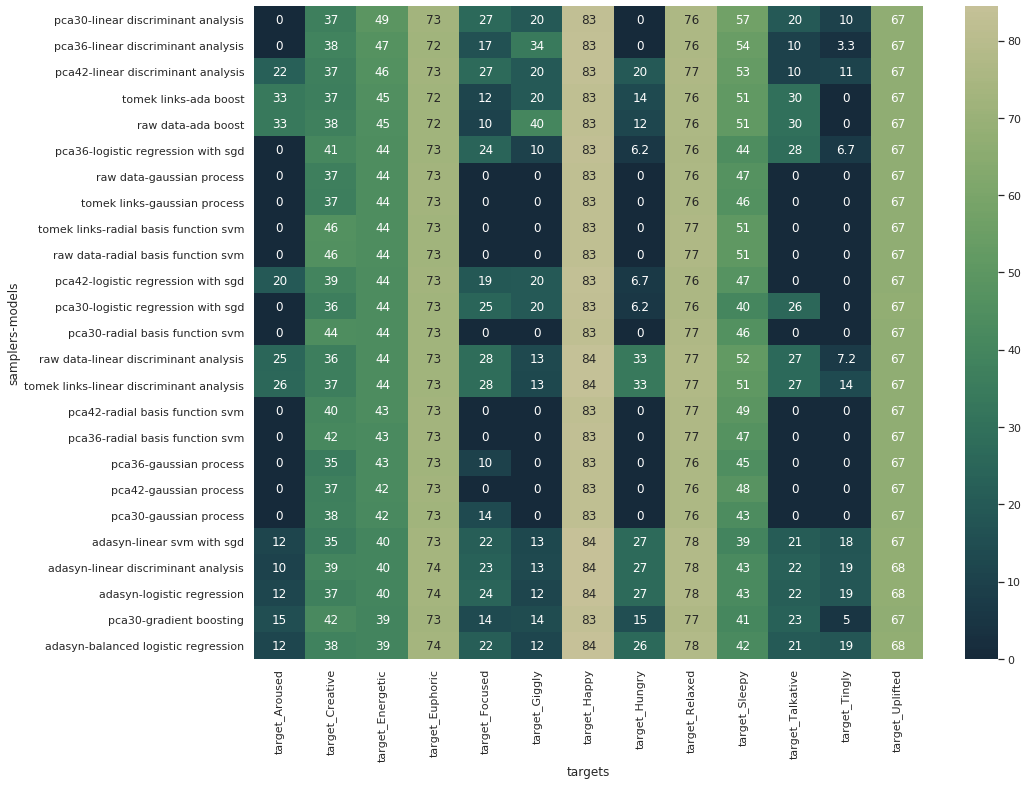

In [110]:
heat_map = pd.pivot_table(cv_results.query('measure == "precision"'), values='mean', index=['samplers', 'models'],
                    columns='targets', aggfunc=np.sum)

plot, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heat_map.sort_values(by='target_Energetic', ascending=False).head(25), annot=True, ax=ax, center=50, cmap=sns.cubehelix_palette(start=0, rot=-.70, reverse=True, as_cmap=True))

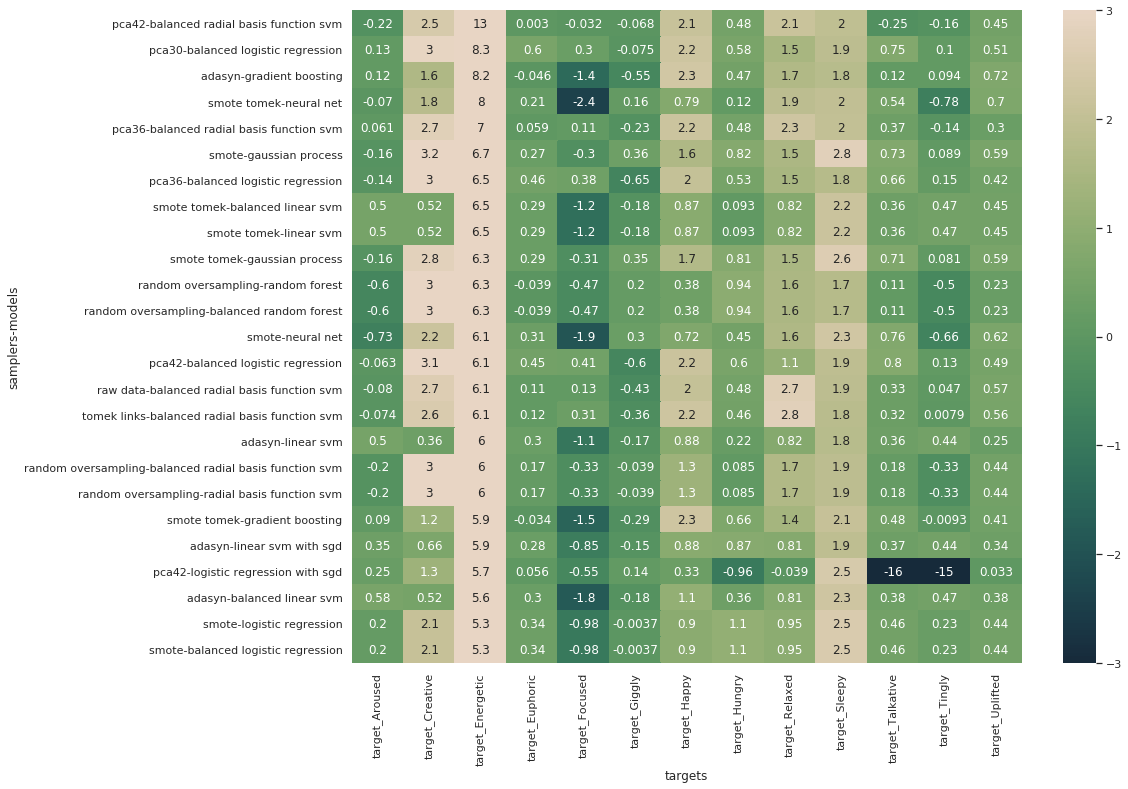

In [105]:
heat_map_standardize = (heat_map - baseline)/pd.pivot_table(cv_results.query('measure == "precision"'), 
                                                                            values='std', index=['samplers', 'models'], 
                                                                            columns='targets', aggfunc=np.sum).replace(0,1)

plot, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heat_map_standardize.sort_values(by='target_Energetic', ascending=False).head(25), annot=True, ax=ax, vmin=-3, center=0, vmax=3, cmap=sns.cubehelix_palette(start=0, rot=-.70, reverse=True, as_cmap=True))

In [113]:
heat_map.max()

targets
target_Aroused      43.33
target_Creative     46.43
target_Energetic    48.90
target_Euphoric     81.56
target_Focused      29.50
target_Giggly       40.00
target_Happy        91.35
target_Hungry       33.33
target_Relaxed      83.02
target_Sleepy       63.04
target_Talkative    44.19
target_Tingly       27.12
target_Uplifted     78.45
dtype: float64

In [106]:
baseline

targets
target_Aroused       8.72
target_Creative     32.88
target_Energetic    28.77
target_Euphoric     72.49
target_Focused      26.49
target_Giggly       13.80
target_Happy        82.52
target_Hungry       20.97
target_Relaxed      76.08
target_Sleepy       32.15
target_Talkative    16.13
target_Tingly       14.87
target_Uplifted     66.78
Name: null_always_one, dtype: float64

In [112]:
cv_results.query('targets == "target_Energetic" and samplers == "pca30" and models == "linear discriminant analysis"')

fold_1     fold_2     fold_3     fold_4     fold_5  \
2544  52.487555  51.744186  51.761985  53.025279  52.181105   
2545  58.333333  42.105263  45.000000  57.142857  41.935484   
2546  22.727273  21.276596  22.167488  28.037383  26.315789   

                            models            measure           targets  \
2544  linear discriminant analysis  balanced_accuracy  target_Energetic   
2545  linear discriminant analysis          precision  target_Energetic   
2546  linear discriminant analysis             f-Beta  target_Energetic   

     samplers   mean   std        se  
2544    pca30  52.24  0.54  0.241495  
2545    pca30  48.90  8.17  3.653735  
2546    pca30  24.10  2.92  1.305864

Feature engineering - probablistic imputation

assume that strains can have more than just 3 flavors associated with them, and so there is missing data

Based on the conditional probabilities of flavors cooccurring, can generate probabilities that a certain flavor should be recorded for a particular sample/strain

Perhaps with less sparsity, better results? Also, perhaps build connections between synonyms (check this? any examples?)

e.g. citrus, lemon, lime, orange, grapefruit

In [86]:
#generate df of conditional probabilities between all pairs (bootstrap)

total = len(features)
event_base_df = pd.DataFrame()
ratios_df = pd.DataFrame()
 
for i in range(100):
    print('iteration: ' + str(i))
    features_bootstrap = features.sample(n=1000, replace=True, random_state=i)
    labels = []
    ratios = []
    event = []
    cond_event = []
    event_base = []
    for A in features_bootstrap.columns:
        for B in features_bootstrap.columns:
            #print('Pr(' + B + ' | ' + A + ')')
            event.append(B)
            cond_event.append(A)
            labels.append('Pr(' + B + ' | ' + A + ')')
            given_A = features_bootstrap[features_bootstrap[A] == 1].sum()
            prob = given_A[B]/given_A[A]
            event_br = len(features_bootstrap[(features_bootstrap[B] == 1)])/total
            event_base.append(event_br)
            ratios.append(prob/event_br)
            
    event_base_df[str(i)] = event_base
    ratios_df[str(i)] = ratios
            
            

iteration: 0


/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
i

In [87]:
Pr_data = pd.DataFrame()
Pr_data['labels'] = labels
Pr_data['events'] = event
Pr_data['cond_events'] = cond_event
Pr_data['event_base'] = event_base_df.T.mean()
Pr_data['ratios'] = ratios_df.T.mean()


Pr_data#[(Pr_data['probs'] < 1) & (Pr_data['events'] == 'feature_Apple')].sort_values(by='ratios', ascending=False).head(50)

labels              events  \
0        Pr(feature_Ammonia | feature_Ammonia)     feature_Ammonia   
1          Pr(feature_Apple | feature_Ammonia)       feature_Apple   
2        Pr(feature_Apricot | feature_Ammonia)     feature_Apricot   
3          Pr(feature_Berry | feature_Ammonia)       feature_Berry   
4     Pr(feature_BlueCheese | feature_Ammonia)  feature_BlueCheese   
...                                        ...                 ...   
2299     Pr(feature_TreeFruit | feature_Woody)   feature_TreeFruit   
2300      Pr(feature_Tropical | feature_Woody)    feature_Tropical   
2301       Pr(feature_Vanilla | feature_Woody)     feature_Vanilla   
2302        Pr(feature_Violet | feature_Woody)      feature_Violet   
2303         Pr(feature_Woody | feature_Woody)       feature_Woody   

          cond_events  event_base      ratios  
0     feature_Ammonia    0.006192  172.885965  
1     feature_Ammonia    0.003268    0.000000  
2     feature_Ammonia    0.001765    0.000000  
3     feature_Ammonia    0.069054    0.516375  
4     feature_Ammonia    0.001691    0.000000  
...               ...         ...         ...  
2299    feature_Woody    0.006654    0.571478  
2300    feature_Woody    0.029490    0.545340  
2301    feature_Woody    0.006749    1.729820  
2302    feature_Woody    0.001294    2.360937  
2303    feature_Woody    0.049861   20.247317  

[2304 rows x 5 columns]

In [88]:
Pr_data['ratios'][Pr_data['ratios'] == 0 ] = 1

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [89]:
Pr_data

labels              events  \
0        Pr(feature_Ammonia | feature_Ammonia)     feature_Ammonia   
1          Pr(feature_Apple | feature_Ammonia)       feature_Apple   
2        Pr(feature_Apricot | feature_Ammonia)     feature_Apricot   
3          Pr(feature_Berry | feature_Ammonia)       feature_Berry   
4     Pr(feature_BlueCheese | feature_Ammonia)  feature_BlueCheese   
...                                        ...                 ...   
2299     Pr(feature_TreeFruit | feature_Woody)   feature_TreeFruit   
2300      Pr(feature_Tropical | feature_Woody)    feature_Tropical   
2301       Pr(feature_Vanilla | feature_Woody)     feature_Vanilla   
2302        Pr(feature_Violet | feature_Woody)      feature_Violet   
2303         Pr(feature_Woody | feature_Woody)       feature_Woody   

          cond_events  event_base      ratios  
0     feature_Ammonia    0.006192  172.885965  
1     feature_Ammonia    0.003268    1.000000  
2     feature_Ammonia    0.001765    1.000000  
3     feature_Ammonia    0.069054    0.516375  
4     feature_Ammonia    0.001691    1.000000  
...               ...         ...         ...  
2299    feature_Woody    0.006654    0.571478  
2300    feature_Woody    0.029490    0.545340  
2301    feature_Woody    0.006749    1.729820  
2302    feature_Woody    0.001294    2.360937  
2303    feature_Woody    0.049861   20.247317  

[2304 rows x 5 columns]

In [114]:
features_mod = features.copy(deep=True)
features_mod

feature_Ammonia  feature_Apple  feature_Apricot  feature_Berry  \
0                   0              0                0              0   
1                   0              0                0              0   
2                   0              0                0              0   
3                   0              0                1              0   
4                   0              0                0              0   
...               ...            ...              ...            ...   
2346                0              0                0              0   
2347                0              0                0              1   
2348                0              0                0              0   
2349                0              0                0              0   
2350                0              0                0              1   

      feature_BlueCheese  feature_Blueberry  feature_Bubblegum  \
0                      0                  0                  0   
1                      0                  0                  0   
2                      0                  0                  0   
3                      0                  0                  0   
4                      0                  0                  0   
...                  ...                ...                ...   
2346                   0                  0                  0   
2347                   0                  0                  0   
2348                   0                  0                  0   
2349                   0                  0                  0   
2350                   0                  0                  0   

      feature_Butter  feature_Cheese  feature_Chemical  ...  \
0                  0               0                 0  ...   
1                  0               0                 0  ...   
2                  0               0                 0  ...   
3                  0               0                 0  ...   
4                  0               0                 0  ...   
...              ...             ...               ...  ...   
2346               0               0                 0  ...   
2347               0               0                 0  ...   
2348               0               0                 0  ...   
2349               0               0                 0  ...   
2350               0               0                 0  ...   

      feature_Strawberry  feature_Sweet  feature_Tar  feature_Tea  \
0                      0              1            0            0   
1                      0              0            0            0   
2                      0              0            0            0   
3                      0              0            0            0   
4                      0              0            0            0   
...                  ...            ...          ...          ...   
2346                   0              0            0            0   
2347                   0              1            0            0   
2348                   0              1            0            0   
2349                   0              1            0            0   
2350                   0              0            0            0   

      feature_Tobacco  feature_TreeFruit  feature_Tropical  feature_Vanilla  \
0                   0                  0                 0                0   
1                   0                  0                 0                0   
2                   0                  0                 0                0   
3                   0                  0                 0                0   
4                   0                  0                 0                0   
...               ...                ...               ...              ...   
2346                0                  0                 0                0   
2347                0                  0                 0                0   
2348                0                  0           

In [115]:
for row in features_mod.index:
    true_feats = list(features_mod.columns[features_mod.loc[row] == 1])
    for col in features_mod.columns:
        if features_mod[col].loc[row] == 0:
            features_mod[col].loc[row] = np.prod(list(Pr_data[Pr_data['cond_events'].isin(true_feats)][Pr_data['events']==col]['ratios']))*Pr_data[Pr_data['events']==col]['event_base'].values[0]
            print(np.prod(list(Pr_data[Pr_data['cond_events'].isin(true_feats)][Pr_data['events']==col]['ratios']))*Pr_data[Pr_data['events']==col]['event_base'].values[0])


features_mod

/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/cleber/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/cleber/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0.012790119337159579
0.007213105562000146
0.003921865438878899
0.21770633347339374
0.0017921185529137218
0.03286774149883231
0.00023965141612200422
0.017441329505162598
0.018516594333190504
0.01729341633989034
0.0031857640294535527
0.006862862433767442
0.2072363331821557
0.25640925428019545
0.03871532798034689
0.07870826674443596
0.009315645514986313
0.01971105081367846
0.37902922202537276
0.07665662069361834
0.03174648363021092
0.0018182988872188098
0.0345782883519929
0.0098036618142967
0.16720119912729042
0.004224362910658014
0.0025132464424862545
0.032129602027926744
0.319602147701555
0.019320399138886078
0.0015305322582451818
0.4528456507106414
0.012336997821500568
0.014438737571057838
0.09746867834784664
0.15941362275665766
0.024940282883019072
0.00865240232951986
0.011063417857407961
0.006178221281112414
0.017058589682510755
0.17283853768595636
0.006547558038312208
0.0006183221549704224
0.18204145266990268
0.027682836067833706
0.002928100972356769
0.0038880682853304266
0.11560316

0.02006398127948377
0.006649672485333033
0.02276395809924527
0.02250546525625888
0.013650113697528036
0.002438027095292862
0.0025132464424862545
0.035551778337853994
0.2678581787228522
0.009995208247473568
0.0015305322582451818
0.16864182556469995
0.015437738080192867
0.025263630641787514
0.04381283182933419
0.1065450996959429
0.08826178368922201
0.00865240232951986
0.009734054219853964
0.02602890494595611
0.039353059374569205
0.11710489089496269
0.02215345728581828
0.0031443237134149956
0.08537304333563035
0.015623716792790864
0.002928100972356769
0.013663017513340222
0.04448885693065214
0.0016906318082788667
0.013123380521528234
0.00023965141612200422
0.0037385620915032667
0.007142208847011889
0.03110571610514624
0.0014771241830065366
0.3371621874331492
0.010124467597543612
0.9891032953462834
0.06333539983669075
0.05788638195485518
0.006489048720035817
0.003369421252287524
0.007093580187392975
0.16086096752952841
0.007994603714530635
0.007651983117751724
0.023075143069976663
0.030008

0.0048102205428409775
0.015281795825709037
0.008287944386332687
0.002237839862880129
0.0007368077043336738
0.005301246210731441
0.16911130716653178
0.000552600405669369
0.0009209346970151102
0.0020886219211662576
0.023217885361736856
0.2170800756955103
0.14203807068561264
0.02841179831382343
1.7718389976906916
0.006021812570728643
0.006679758431125774
0.007343764471890192
0.016156070130944583
0.028124660592204153
0.00659620914272125
0.0012073771597967294
0.2693271128243198
0.006086516491861634
0.009472451533588748
0.0035850773548143865
0.1161661304252977
0.0019045802646252788
0.013435643825944065
0.00023965141612200422
0.015470096061844458
0.04560299706956647
0.02126780726019911
0.0029077148723041252
0.0016303281666145955
0.29107288278028565
1.751820365103227
0.1733346862811569
0.010992490028716523
0.018414523220454077
0.007707083283609865
0.007421417330932789
0.31505571904928353
0.08170373534864686
0.008949708722885698
0.006204923264879801
0.012262471787276397
0.005657595298430151
0.1

0.0060880487097715414
0.01754057656559155
0.01321498976144047
0.1406507774370494
0.012943606051893108
0.004078406954046925
0.022546495106325594
0.037222834477811016
0.035373059485461024
0.008449283666298206
0.0011896969327082625
0.0051082672173424675
0.21050630692543795
0.39703778977166654
0.0030601082663355835
0.0009209346970151102
0.7494203446572943
0.002332281536452668
0.2746607543948829
0.36456616357787497
0.0333857752695568
0.6769813481830995
0.004647105720632864
0.02387247318859767
0.06951285120337089
0.023015979198360605
0.035370815434392834
0.009180077025393195
0.018102071700196794
0.4350170686339955
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.25538103529662154
0.0038433825495687323
0.021558002367519223
0.00023965141612200422
0.035334369185743085
0.039921019693156694
0.009722961399964238
0.005422856713673786
0.33006923771261054
0.038347071125842874
0.112436075101536
0.2937538579630371
0.04343992522705164
0.0058835859065713425
0.008380184354411771
0.0239523

0.004647105720632864
0.00742570266670171
0.005328093365079286
0.046207670489769134
0.026612423402682363
0.6716349784047824
0.0008972783730597029
1.3095176764309906
0.009336845652148366
0.003003075317554064
0.0019304852656783522
0.16523370876083796
0.00372523316440834
0.2016640868156589
0.00023965141612200422
0.033364597039179454
0.09161656162270512
0.08918736120122728
0.0025941149969834036
0.2053064549088313
0.14886338420250647
0.10132979175629668
0.06967505162119257
0.0030302713508853353
0.018501998640153932
0.06688616502769325
0.04167826716931914
0.013175045252292216
0.01196598706554725
0.005613522984140665
0.02264670393588062
0.016180767266068406
0.001732665636193586
0.0011896969327082625
0.0007368077043336738
0.037774125484900035
0.15537553399910015
0.003047778185854622
0.0009209346970151102
0.34066913330833976
0.021634159579748336
0.020710834303541745
0.17101119933092152
0.35470736955919857
0.0027239814505334173
1.0655202894198528
0.010066404836222455
0.005328093365079286
0.017994

0.0600839560685356
0.0047440054905860405
0.045003022728242414
0.013583348618452873
0.0059810104250608825
0.1752014315644802
0.08570741868028907
0.024585323160380958
0.0034652924988361348
0.01797274695689746
0.003366664671265132
0.04628736845988284
0.0019327690765060955
0.0005533769063180831
0.009578635144691776
0.15741176724274294
0.01971944329095275
0.004337258761345809
0.3590168785334592
0.005647143264318598
0.010594448520197896
0.1020219038423639
0.008639588262510677
0.57371368715016
0.001355119825708062
0.008960020221992627
0.009705334467358804
0.006748857723250383
0.08233975111381595
0.0017451678392080053
0.0015261447322429422
0.06285838358745686
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.25538103529662154
0.0038433825495687323
0.021558002367519223
0.00023965141612200422
0.035334369185743085
0.039921019693156694
0.009722961399964238
0.005422856713673786
0.33006923771261054
0.038347071125842874
0.112436075101536
0.2937538579630371
0.04343992522705164
0.005883

0.15486390363072716
0.011311285518707448
0.003267973856209149
0.011205977023828891
0.045753464971131606
0.005022528286565142
0.013818718159235513
0.00023965141612200422
0.00500685219543147
0.03373174733807076
0.030408352735922285
0.002398270338204696
0.0021631798630094823
0.3263399552517657
0.5068205378290384
0.009853397037360033
0.002744308011592745
0.045003022728242414
0.013583348618452873
0.0059810104250608825
0.2706079986034177
0.10122639561149104
0.05674105458074704
0.0034652924988361348
0.02044759608837729
0.003366664671265132
0.0019327690765060955
0.0005533769063180831
0.012518841656182833
0.1626801841238716
0.02254764108779953
0.004337258761345809
0.2728387078512486
0.005647143264318598
0.010594448520197896
0.06630590836906357
0.008639588262510677
1.281316769488255
0.001355119825708062
0.008960020221992627
0.009705334467358804
0.04024538554503033
0.37332148766490225
0.0017451678392080053
0.0015261447322429422
0.06285838358745686
0.057742725867740666
0.008803835757580548
0.07692

0.02201260657071458
0.07131090597636403
0.15945019463327173
0.008679356742291644
0.004834898563646161
0.0045237510518083305
0.0019603818290595282
0.019557264574903286
0.04943679523597841
0.019778900546862807
0.009385177511033698
0.20171549484641788
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.30896976261817577
0.0017921185529137218
0.1902845415779994
0.00023965141612200422
0.16444226064440273
0.024103806251345766
0.008830233612370652
0.039808133276064306
0.2458657091962747
0.0982137272486616
0.09227655968069264
0.3243633987679467
0.1583912492820909
0.061297610959184824
0.15879724276971785
0.02395237456734026
0.08612469845369658
0.017321308581117554
0.014850083523834027
0.041878095991695466
0.07520936255275484
0.023596554779801635
0.002438027095292862
0.0025132464424862545
0.016632433685747926
0.2167835921351926
0.01199771561740298
0.08296713723691959
0.47803313366180883
0.006682440563735376
0.06835007774409237
0.08250251890753205
0.4484583751145023
0.02711904526556

0.010066404836222455
0.14945399369124682
0.007848945749464327
0.010283442780616847
0.0250967985610296
0.019396425635873994
0.00735375038618782
0.031374399993178835
0.004242092712463566
0.015017502878438784
0.04153871060242284
0.00372523316440834
0.005073321749124836
0.00023965141612200422
0.011316996287402157
0.010112057300505194
0.026859373161494834
0.004211825331093188
0.0032645539121981325
0.2763627309271323
0.08817739499076917
0.01591101724914966
0.06349221201549665
0.010413895975972708
0.009141904276514462
0.23608721140378938
0.029521612871393363
0.002325070609768743
0.025664528302894986
0.008362748330571733
0.11563280678710464
0.01843768601526306
0.0007368077043336738
0.0297041059535277
0.6342957387602283
0.0031978630929021426
0.0009209346970151102
0.34970176914612183
0.004305814912966279
0.02554020476547239
0.07621675758849704
0.1665699754836425
0.008530192782838885
1.202513601595521
0.004647105720632864
0.008439818561830665
0.005328093365079286
0.01662854611808444
0.03477805858

0.006845204683916058
0.013065041635740557
0.08150619905634032
0.4522559971159164
0.006866668865050319
0.0011896969327082625
0.0007368077043336738
0.5262478421539011
0.10912314561784107
0.003403797164786632
0.0009209346970151102
0.29494554542511686
0.022472610062623563
0.08378374500936557
0.4447795627896288
0.015956244392649997
1.0849425142082731
0.004647105720632864
0.02387247318859767
0.014074382314822602
0.08596122600426488
0.039012476177714916
0.08620701443517308
0.002646287721051503
0.24088754220996889
0.020565194587691113
0.007849367034154951
0.0035850773548143865
0.14742916290823466
0.0008133216086203938
0.02481378693837726
0.00023965141612200422
0.012858693650209115
0.010916670881385935
0.01599753038584823
0.0018140171483262497
0.003589906134027012
0.1014863665977425
0.5968210741597153
0.20102225335815713
0.039117980563947594
0.4482518602792503
0.007530747579982743
0.012105644376829141
0.13752272211521377
0.17422257701211757
0.2747865097835999
0.0034807743120698273
0.05048273232

0.01021801840671283
0.022894102836059846
0.002234322906160476
0.0010581546936731774
0.48211329782353335
0.04089701085682224
0.003003075317554064
0.0019304852656783522
0.646323136120293
0.00372523316440834
0.0463851928188825
0.00023965141612200422
0.033364597039179454
0.020665360336599346
0.01057881665898361
0.0025941149969834036
0.14865114276632174
0.01295992180541095
0.10132979175629668
0.2732970979182181
0.0030302713508853353
0.08832532102362098
0.03912459892767367
0.013175045252292216
0.01196598706554725
0.005613522984140665
0.02264670393588062
0.016180767266068406
0.001732665636193586
0.0011896969327082625
0.0007368077043336738
0.008720010178925307
0.1516473272176149
0.003047778185854622
0.0009209346970151102
0.20884867681125416
0.5978975986325977
0.020710834303541745
0.07486065270434097
0.12320886637264002
0.013576446866096279
1.6452006436660909
0.010066404836222455
0.03690652073986563
0.07444624952393425
0.01799446722555043
0.046020450627261546
0.01121297231477184
0.1174073772177

0.10100039723759571
0.020355667348372897
0.02349243652269514
0.0711387113650313
0.007267973856209157
0.03411712254051426
0.1834031941978649
0.011500300526029714
0.14314557050054927
0.015858218293048478
0.007431893873533654
0.014251001633688176
0.0005533769063180831
0.09050290865849944
0.16233318627877438
0.022544814423407767
0.004337258761345809
0.5077379623869169
0.003058823529411763
0.01715425411696547
0.18430469969559013
0.011737044048796396
0.5826716403789365
0.001355119825708062
0.03494977960374662
0.009705334467358804
0.033431505911534425
0.058672553875931954
0.01262239228340104
0.01606115769009006
0.12222655526431563
0.009336845652148366
0.003003075317554064
0.0019304852656783522
0.18368574319349734
0.00372523316440834
0.1191289995861567
0.00023965141612200422
0.3124397042329482
0.020665360336599346
0.01057881665898361
0.05262941717137176
0.12670001006610862
0.08027516078061495
0.0809464092011147
0.11218804327614139
0.015353798952733665
0.18896909917993035
0.06688616502769325
0.

0.15795932571545035
0.05206394299771609
0.00865240232951986
0.031293462559689955
0.016320030896203194
0.04048508130986783
0.10949921938380716
0.02690170116155151
0.0015463318701279694
0.5253535452240805
0.010320754239432076
0.00362404831796861
0.005984881893264002
0.08680867120768039
0.025915750201121857
0.018084957079806088
0.00023965141612200422
0.018671441926224223
0.31112679677409494
0.049028664267680495
0.00415814523261564
0.2159597377505884
0.0043390521220640285
0.6756127874991359
0.18420472588291367
0.00867991624561855
0.0012710349781105462
0.027245357927597854
0.007254945674238285
0.07611133144765607
0.016236828535062888
0.0037128602994369463
0.004284890957804222
0.005637697269599386
0.013663961715394156
0.0034630043750902262
0.002237839862880129
0.0007368077043336738
0.010165696532522028
0.3930173646739871
0.001277450823159343
0.007392735589574859
0.002332281536452668
0.021185894844409796
0.20467054312666988
0.0061523812696610775
0.8453483940751095
0.006021812570728643
0.01696

0.04797774678714673
0.0008979510177474179
0.0894379029129499
0.007848513513297146
0.020400825661503502
0.040719435503133665
0.13463196418859302
0.002523084827762045
0.00406932051886917
0.0019603818290595282
0.024182007290558295
0.12581693135720443
0.06393192325410732
0.0007562047563546593
0.048445111779763426
0.0614584365640505
0.03170119541299817
0.026784030932117897
0.10218044682616541
0.00372523316440834
0.03784519983005348
0.00023965141612200422
0.0076397240330615115
0.03236945846163846
0.012413978615895833
0.0025941149969834036
0.25576506625335804
0.009554389200798789
0.12473322967109017
0.2042647670776843
0.04042750260863571
0.02326547057074836
0.02293893209716627
0.011834099659034385
0.07727516844720832
0.045591308104026604
0.006845204683916058
0.021503724337432875
0.039391594205370535
0.01202029419729742
0.015199330421119603
0.0007368077043336738
0.08801490685277824
0.2834691685764125
0.0036076914764608804
0.0009209346970151102
0.09391474183825284
0.002332281536452668
0.0290170

0.003003075317554064
0.0019304852656783522
0.11105007355577387
0.00372523316440834
0.03148694314287239
0.00023965141612200422
0.0076397240330615115
0.020405846316743515
0.012413978615895833
0.0025941149969834036
0.16837806406651046
0.009554389200798789
0.08704063997376285
0.11470853538431994
0.04042750260863571
0.006850374811856366
0.007310244524274065
0.011834099659034385
0.05816606200370116
0.009108705310831695
0.006845204683916058
0.0024375744207550546
0.012717661870582002
0.011922832071931741
0.010565432974211005
0.0011896969327082625
0.0007368077043336738
0.015376834485439772
0.14852204681309947
0.0036076914764608804
0.0009209346970151102
0.22846780081487325
0.002332281536452668
0.013296437947168225
0.06951145197946502
0.0923444187795031
0.008311282032012302
0.39011180715755656
0.004647105720632864
0.00742570266670171
0.005328093365079286
0.007591980684967635
0.026612423402682363
0.007366801986966638
0.0008972783730597029
0.16446500932630428
0.022883598107165788
0.0098257216406630

0.008101506288370119
0.10018560862994866
0.011199606551287966
0.0020651080752390727
0.02296638752509534
0.010677218170445112
0.056755395215485754
0.005218398277083026
0.002237839862880129
0.0007368077043336738
0.17212544071282176
0.35136759701080444
0.0008701631949828763
0.0009209346970151102
0.002332281536452668
0.13349692740959213
0.4079355462528948
0.011811523030666076
0.8327331526668028
0.006021812570728643
0.02387247318859767
0.019398862167997275
0.023704983122842065
0.038856749959567484
0.00636347646538992
0.003560842931890805
0.8854529202320964
0.004093277415231441
0.07237990193834039
0.00551089326850232
0.008872626922731766
0.00023965141612200422
0.005866772466733544
0.04748086642569737
0.009780982619911322
0.0024434147793103217
0.06719701274397812
0.013345320334988219
0.043411442672799234
0.7498731788700077
0.2666531201794891
0.5083056244697854
0.008177744670350906
0.024934866993741304
0.05125260146845842
0.011058042987891606
0.009901051085771457
0.036257328369976034
0.0043096

0.004821310337268779
0.014122459574469993
0.0019304852656783522
0.0055934812660708615
0.3798776365539753
0.00023965141612200422
0.022778498736873667
0.01988784293675672
0.011154526130635046
0.005673174738928
0.12728057649336874
0.020852599124364244
0.1025553925763966
0.33204506806107925
0.0018153035471400757
0.01706998941517709
0.2353480198962363
0.02212527772431453
0.006679323485722478
0.014413883539545053
0.003245573045937544
0.020837899996040535
0.016180767266068406
0.0017884762349738383
0.0011896969327082625
0.0007368077043336738
0.001970606357294645
0.09890557171707165
0.0018261150150954474
0.0009209346970151102
0.29232659153949964
0.01937398175907927
0.022697260613112207
0.06819653829241422
0.13108110145336976
0.012579391326866696
2.2615315307457444
0.010066404836222455
0.03319909968670156
0.005328093365079286
0.029523027441522392
0.05011760175607788
0.014483984565593407
0.003114759854170895
0.16707735788220024
0.007739007666021125
0.00870462453155774
0.0019147160931308235
0.2651

0.011509806083998899
0.02382821851655724
0.019845397637110976
0.009914536275049363
0.5279219509115511
0.013938798292530566
0.1305177052741296
0.2370073846886152
0.05739890684006147
0.017700461363456165
0.017090090409891897
0.01321498976144047
0.04373130459950406
0.023881702673211987
0.06340584458014659
0.012883448888217859
0.043956484160651337
0.04428046638288064
0.031132897553448155
0.005398751708472411
0.0007368077043336738
0.05257821764122175
0.07115561217069424
0.04609524913425174
0.010840773561906155
0.2870468837806538
0.0045385333522561305
0.08378374500936557
0.13990086504140048
0.022858340196104394
1.3950051941164785
0.004647105720632864
0.02387247318859767
0.014074382314822602
0.02896519861232888
0.008190968799207665
0.002646287721051503
0.24372441409803325
0.018040425256291553
0.009794366473633331
0.0017647058823529419
0.4629330900152562
0.0016906318082788667
0.08000784299990205
0.00023965141612200422
0.03279614344524595
0.04456730009053578
0.024136059561902644
0.0338131107929

0.006682440563735376
0.023378826462736577
0.09950632215111103
0.24662179526079203
0.027119045265561085
0.00865240232951986
0.009734054219853964
0.006178221281112414
0.01681780054797912
0.12315896364805759
0.02158800029907288
0.00650722662434573
0.21372565545665578
0.004821310337268779
0.014122459574469993
0.0019304852656783522
0.011995795844200127
0.07356443468832413
0.00023965141612200422
0.010494968089539059
0.032524850476555865
0.01441290074613116
0.015679124667529087
0.11171649061079379
0.03717915803226541
0.08574684457688521
0.23319742719788722
0.085079280327129
0.0019957904984436348
0.0036352080770374515
0.04163988054712547
0.030217105540375364
0.004617820139674903
0.008245536500903948
0.0014407754365653087
0.012936573919981965
0.034349595358124346
0.010905754342827019
0.0011896969327082625
0.0007368077043336738
0.00433672890368438
0.2943255453641738
0.0018842165499737093
0.0009209346970151102
0.3884136071086431
0.0020886219211662576
0.02442253390062856
0.08478019157184424
0.2981

0.00599886499307446
0.006100319567515789
0.053719097403598474
0.0035437989884527167
0.03013435684944287
0.005556279750160774
0.018443313370225426
0.00023965141612200422
0.011146846602115384
0.04070764606839615
0.011717835158493405
0.0032303824660961846
0.034628099294146945
0.01090782078606622
0.03808118133968953
0.8802346959975972
0.36003133793054953
0.0020483579309308014
0.029672551435995207
0.14312109015663943
0.0053513112764853
0.007531001222534634
0.029215641892525804
0.009743345706556538
0.021607275736543596
0.018526815787419087
0.0023624626805387465
0.0011154684095860572
0.0005533769063180831
0.002903927443770066
0.027852092164153255
0.00424593370901316
0.0005403050108932465
0.05135479845902066
0.025409278569859584
0.013418129424139212
0.040776738341978015
0.028425483747362215
0.02148060376115547
2.8600737758874146
0.010417052918787497
0.06641946806455178
0.0016906318082788683
0.029852884875489004
0.04772907024889045
0.025865701821571437
0.00449232458360469
0.014593497265723138
0

0.00023965141612200422
0.008593301144831419
0.016594023304027747
0.03849264853498307
0.004270153058786539
0.38631005323253603
0.012100229146771141
0.35634679152966275
1.417423161256042
0.2016592468749548
0.1285310155265074
0.022731442527241782
0.030953332372127475
0.01642700227811795
0.1105786533635846
0.0254024176700133
0.013876687979644588
0.11290792789909326
0.08753336223610084
0.14911947739930165
0.02198452984834976
0.002285911757646709
0.001887565144851065
0.7065478335779769
0.14852293170981837
0.027739767216338595
0.0008979510177474179
0.29046026782863166
0.008764124789727844
0.07651971334476508
0.17297516495923657
0.002523084827762045
0.014543152418483841
0.005178430904767831
0.11714447381017933
0.12134007494177208
0.02464730704300583
0.0022302280110889595
0.2669407775862777
0.020263591383737335
0.011087881312334423
0.006647420637315708
0.10527770024686371
0.0008133216086203938
0.022217164487912423
0.00023965141612200422
0.012816429459979347
0.009166935153338595
0.00608816681316

0.06660350076807205
0.003058823529411763
0.3160185692827417
0.06361932612227102
0.027246927487074718
0.7562784152297541
0.004808980663765832
0.047760240052746615
0.0044658748998784815
0.11247741036028314
0.03813253825487013
0.06529331650274321
0.0038166612969060855
0.11246452611419687
0.005269555180318712
0.003003075317554064
0.0067838967987587685
0.040870773476517026
0.09559335019344888
0.03449032675580184
0.00023965141612200422
0.0076397240330615115
0.06813278271018079
0.05532200560321701
0.0025941149969834036
0.2222028362672086
0.021279050104720688
0.3036015961203425
0.27635356060859617
0.16352012302607835
0.019686354453822375
0.004060978306793805
0.011550142658430674
0.17954970932164305
0.006490111804714889
0.01374399398898225
0.21413022751988273
0.24580000518638367
0.01091904761441722
0.0011896969327082625
0.0036730402507409226
0.10037516520322672
0.004559864337905565
0.0009209346970151102
0.7183738074597088
0.003450136961410141
0.09254976169906944
0.10283325349924817
0.6546222340

0.002237839862880129
0.0007368077043336738
0.05014188036117431
0.4012370868940059
0.0007683510898356405
0.0009209346970151102
0.005388024202477873
0.04996177558002775
0.11314818801760357
0.1054919052334996
0.020023571607295378
1.5495732967342344
0.006021812570728643
0.00742570266670171
0.030939349480519414
0.02304215721258756
0.041555688617273386
0.005240300723688327
0.0072406467762730995
0.14389131132329558
0.03132095289808626
0.003003075317554064
0.0067838967987587685
0.01597496302493028
0.00372523316440834
0.044168294054832774
0.00023965141612200422
0.0076397240330615115
0.0633578317819827
0.020844057216092976
0.0025941149969834036
0.5861467761231931
0.05808157860967898
0.3282343312386995
0.06805146756236513
0.13051156226043653
0.01332276342462421
0.01894105128946164
0.011550142658430674
0.1378475992601357
0.024007294969334424
0.01374399398898225
0.03967012166969462
0.13893493821021372
0.01457362094627135
0.014270699954258321
0.0011896969327082625
0.0036730402507409226
0.00455986433

0.004647105720632864
0.02704986962767704
0.007848945749464327
0.007118304061758251
0.01580488340199525
0.016460660431619353
0.0021184173070582218
0.029955899874933547
0.003247143297535812
0.004253319837509619
0.09644411650916748
0.008723493253910574
0.009814033782893337
0.00023965141612200422
0.013847270229489375
0.05197327349464462
0.11364569436736902
0.00415814523261564
0.3667816685296073
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632337
0.0072892754331103995
0.007254945674238285
0.1297710385087811
0.009407043987725086
0.001230401649596133
0.007394486424519965
0.007491626785195567
0.012207727626745688
0.009879892128214725
0.002237839862880129
0.0051082672173424675
0.04376664758679693
0.536967816043733
0.0008291623010880754
0.0009209346970151102
0.002332281536452668
0.06945182337989067
0.7300471921748164
0.2029459263976395
0.012872829808006112
0.845154305862301
0.006021812570728643
0.00742570266670171
0.03627057980864142
0.012401161857599504
0.02281339

0.030217105540375364
0.004617820139674903
0.008245536500903948
0.0014407754365653087
0.012936573919981965
0.034349595358124346
0.010905754342827019
0.0011896969327082625
0.0007368077043336738
0.00433672890368438
0.2943255453641738
0.0018842165499737093
0.0009209346970151102
0.3884136071086431
0.0020886219211662576
0.02442253390062856
0.08478019157184424
0.2981250328990292
0.03838163768999422
1.275869670775447
0.004647105720632864
0.02704986962767704
0.007848945749464327
0.007118304061758251
0.01580488340199525
0.016460660431619353
0.0021184173070582218
0.00859412868058342
0.02352515065948241
0.001750290879011964
0.7568003080100649
0.0017442518368422264
0.03270127135143099
0.00023965141612200422
0.017291165570029517
0.039745862509477474
0.012753220391784911
0.0030878479951974734
0.08045872901640878
0.020059033265666413
0.09410820732001175
2.151740528354225
0.22952392562748336
0.007575171843757425
0.009374856789506164
0.05770114478110794
0.05557261711863345
0.012297200564058799
0.0187488

0.3020797534907184
0.008177744670350906
0.11176513246423304
0.05176079777254624
0.022834939538220803
0.030355001775797148
0.016715458854965285
0.0027868759910763888
0.01807018031941149
0.02506418008567531
0.03491618521011843
0.054861362445549795
0.001887565144851065
0.007319607578634274
0.04488220852074959
0.017616243372858612
0.0008979510177474179
0.08375186815331756
0.007848513513297146
0.006940633206752538
0.03471388980242932
0.08738821142251635
0.3542225815844147
0.002523084827762045
0.03163553361614924
0.0019603818290595282
0.024182007290558295
0.07836353568512919
0.0007562047563546593
0.08380133132228326
0.07341866827569833
0.010624284373566098
0.021889868454916556
0.07124893714516452
0.003959004584001579
0.0038244822160827933
0.00023965141612200422
0.0067762761228987835
0.0357804780939354
0.07649020060008263
0.009049209016244902
0.29990986992890345
0.0030118769840184853
2.1307139545947487
0.1078604662403419
0.015291715928943779
0.001424355013398497
0.01451178924917993
0.00497558

0.05780062973240183
0.04118943372144107
0.012878207375259819
0.016715458854965285
0.014937246857792475
0.03690664448990051
0.02337222569479042
0.02269266980859864
0.002285911757646709
0.001887565144851065
0.02052266510325255
0.05936102680772628
0.016620633897871405
0.0008979510177474179
0.15642665893171645
0.007848513513297146
0.04373443813363081
0.06970790893115243
0.2717631604155285
0.002523084827762045
0.013082229297724311
0.005178430904767831
0.0582127566919986
0.1321428510606969
0.03183734024956452
0.0022302280110889595
0.13164610840553329
0.002650094695729359
0.044545773818017144
0.001750290879011964
0.0028597495941174948
0.24803807983163234
0.00023965141612200422
0.010633732759222726
0.05712978645296183
0.011450597439442376
0.003916585628511678
0.18574524225386504
0.006060674241144966
0.1642056724287094
1.7448726428476269
0.26725173948916053
0.13310512646703937
0.0016955753147930943
0.011867589464826148
0.03173217960931876
0.0380033135047003
0.009359514093400283
0.00504283372911

0.05011760175607788
0.014483984565593407
0.003114759854170895
0.16707735788220024
0.0328309083420081
0.002928100972356769
0.007963833743782444
0.05083193239782618
0.0016906318082788667
0.007498904545504904
0.00023965141612200422
0.003713223414838429
0.005634838747517915
0.07048485641734704
0.002398270338204696
0.0019675908281752536
0.442876376242874
0.010651329217174888
0.008726067407690729
0.08730130747971357
0.003634115200357446
0.0059810104250608825
0.4613909695128553
0.05864699218691785
0.018803370319794337
0.005980095781192441
0.027171689294950875
0.0030078630322191643
0.0019327690765060955
0.0038365466223449027
0.053897706783613365
0.22226504738549904
0.014635126166524756
0.0005403050108932465
0.20164487795325173
0.005647143264318598
0.03473083260517933
0.04700010745423953
0.06574719446202092
0.018076894854189333
1.2810225848851085
0.001355119825708062
0.003922275059684816
0.008349967671746887
0.050683271025749856
0.2805054514001402
0.002047084025305643
0.010439674094456376
0.045

0.0019304852656783522
0.15761987797572033
0.008723493253910574
0.021798635269687953
0.00023965141612200422
0.0604745131237935
0.08632690104071652
0.020846873699220364
0.00415814523261564
0.21932806966088872
0.005885648473148956
0.25672800395714446
0.03150500552429659
0.0006282971047401782
0.01844892653088219
0.04100485103347913
0.05254063475867365
0.012454437478584872
0.003609980659209598
0.009867733133136436
0.00930923021117081
0.02073929920102537
0.0013167577392138184
0.002237839862880129
0.0007368077043336738
0.013302863646285272
0.2779241151148714
0.0007791487786754232
0.0009209346970151102
0.021634159579748336
0.03299963188925182
0.25663063153480686
0.14284818820838485
0.0020164124368077037
1.3269163673782631
0.013044248792461894
0.03690652073986563
0.007343764471890192
0.02333983225635971
0.044659547528883896
0.0077726456144918
0.004191218711038188
0.4004781557110342
0.021712609467949336
0.006407930770679823
0.011380789872229558
0.3797264682848549
0.48261888096166317
0.0002396514

0.02841179831382343
1.7718389976906916
0.006021812570728643
0.006679758431125774
0.007343764471890192
0.016156070130944583
0.028124660592204153
0.00659620914272125
0.0012073771597967294
0.2693271128243198
0.004093277415231441
0.07237990193834039
0.00551089326850232
0.008872626922731766
0.00023965141612200422
0.005866772466733544
0.04748086642569737
0.009780982619911322
0.0024434147793103217
0.06719701274397812
0.013345320334988219
0.043411442672799234
0.7498731788700077
0.2666531201794891
0.5083056244697854
0.008177744670350906
0.024934866993741304
0.05125260146845842
0.011058042987891606
0.009901051085771457
0.036257328369976034
0.00430968091762432
0.021719148221221757
0.016003699694918192
0.03217353590450108
0.002285911757646709
0.001887565144851065
0.00553891333217248
0.03179168563181848
0.016714308609306006
0.0008979510177474179
0.05622264554995738
0.007848513513297146
0.006940633206752538
0.05026015687103593
0.031109060176382347
0.21385368304041993
0.008953795760023493
0.017518061

0.002285911757646709
0.001887565144851065
0.013899261773075733
0.05224769558745365
0.02356663695092679
0.0008979510177474179
0.09769751663985855
0.0812957060776562
0.009864737349362876
0.05941722545253001
0.03128649144283235
0.015177399944094066
0.019395412620174683
0.0967895336426474
0.0019603818290595282
0.04030681776075463
0.11985373231608386
0.05868003741736425
0.0026250451223901873
0.020754238694558738
0.012915109389454303
0.009825721640663074
0.03491357673762598
0.043165054060287214
0.0036257337881584048
0.0025041078027575347
0.00023965141612200422
0.007522615003071325
0.022654955566021366
0.007951391971937477
0.015602559335321132
0.23362357205525722
0.039272744370395504
0.16114453661692774
3.6999111508016793
0.07989186577062499
0.014939139937331012
0.0009306798571583427
0.004357626814982231
0.007921311485389677
0.12152968165204599
0.00951801822687778
0.012843100570654345
0.07326753899548934
0.04728169842850226
0.0702087139429965
0.010173100710455733
0.0011154684095860572
0.00275

0.034818921788382
0.00023965141612200422
0.031828751322948864
0.10069056929432396
0.017401073370089736
0.003145161175967482
0.4256136314881712
0.007200875939733309
0.2926624814202419
0.3563854316511143
0.04447993777153025
0.002508376696328213
0.01550326840673395
0.014684106206795246
0.10857088435978991
0.016373921352055443
0.004480074565936883
0.004364700018338673
0.009357429101528992
0.01791487107685565
0.017932453599844553
0.004585969813512259
0.0025132464424862545
0.025373708618153887
0.31723563332901744
0.0030671541366037187
0.0015305322582451818
0.006682440563735376
0.01706931969884798
0.3163150443931935
0.15633411633581124
0.020074725595917782
0.011211956053327931
0.009734054219853964
0.008515504296729622
0.021813629644638746
0.07062458004149182
0.014964442178206767
0.0007055188166449329
0.3830253355103024
0.016511160071037225
0.033073962380254875
0.003856308592180733
0.001221211929651478
0.357030753507322
0.00023965141612200422
0.005866772466733544
0.008338380775584516
0.0269937

0.0005533769063180831
0.002903927443770066
0.027852092164153255
0.00424593370901316
0.0005403050108932465
0.05135479845902066
0.025409278569859584
0.013418129424139212
0.040776738341978015
0.028425483747362215
0.02148060376115547
2.8600737758874146
0.010417052918787497
0.06641946806455178
0.0016906318082788683
0.029852884875489004
0.04772907024889045
0.025865701821571437
0.00449232458360469
0.014593497265723138
0.004093277415231441
0.07237990193834039
0.00551089326850232
0.008872626922731766
0.00023965141612200422
0.005866772466733544
0.04748086642569737
0.009780982619911322
0.0024434147793103217
0.06719701274397812
0.013345320334988219
0.043411442672799234
0.7498731788700077
0.2666531201794891
0.5083056244697854
0.008177744670350906
0.024934866993741304
0.05125260146845842
0.011058042987891606
0.009901051085771457
0.036257328369976034
0.00430968091762432
0.021719148221221757
0.016003699694918192
0.03217353590450108
0.002285911757646709
0.001887565144851065
0.00553891333217248
0.031791

0.04102138716058957
0.001962151228030802
0.6288735149434268
0.014422333972289602
0.27824491282196573
0.148519671481913
0.021001383777655133
0.015547866728136227
0.02395237456734026
0.1524228828976498
0.018923663660426856
0.008847753530889896
0.004284900596426891
0.03262179614800783
0.011165525283895363
0.02903503704636962
0.002438027095292862
0.017424267330192155
0.031031587614763635
0.3584694085775214
0.010786279839991532
0.0015305322582451818
0.9449288916735624
0.006682440563735376
0.035118952296996124
0.28268623138053756
0.20497206788578795
0.056742070908491156
0.00865240232951986
0.009734054219853964
0.03051400530474221
0.021179599392246
0.06428867541362733
0.02158800029907288
0.003586609252085993
0.18817777304587682
0.002000059229137237
0.03013435684944287
0.01952526086588847
0.018443313370225426
0.00023965141612200422
0.0025523710590309376
0.03913939933260113
0.011884318302323251
0.0032303824660961846
0.05816723767554561
0.017909680978407484
0.06611638063099742
1.0037943621994339

0.016714308609306006
0.0008979510177474179
0.05622264554995738
0.007848513513297146
0.006940633206752538
0.05026015687103593
0.031109060176382347
0.21385368304041993
0.008953795760023493
0.017518061590017002
0.0019603818290595282
0.027900790688866823
0.07547872131751064
0.04979846226180361
0.0007562047563546593
0.013957513304434838
0.0037918278604389347
0.015368188871242871
0.0036146032482912965
0.00253850347886433
0.0985264823389631
0.00023965141612200422
0.0025350719736043615
0.008894138748157131
0.015998221497651278
0.005244874153861668
0.003480570577084863
0.0876149310308997
0.5660035110238888
0.09228218523711734
0.047613330172481726
0.030126577158829403
0.0033528436149057933
0.021044994281463454
0.08960303715841661
0.023042321168367373
0.01647185752400089
0.0020035296839946617
0.015334785194930154
0.003765282953181743
0.11077870370152319
0.0019327690765060955
0.0005533769063180831
0.004995103198519197
0.0677326553850765
0.008530248025677126
0.0005403050108932465
0.0898660225845580

0.011953499377466158
0.014143650811368173
0.006028595678156187
2.5055051111790227
0.013020507690133121
0.00023965141612200422
0.017560347447139954
0.083684462481364
0.014863817988604259
0.001962151228030802
0.15397414368241424
0.015855990981309655
0.07737187361885986
0.3555871610711745
0.16986124535882258
0.012097878508058827
0.03257375365367391
0.023717206085534022
0.03159149547145346
0.017321308581117554
0.03221116209354215
0.0038397237720018125
0.02736075519556805
0.035544450329703686
0.021743056919358673
0.002438027095292862
0.0025132464424862545
0.03293795181950058
0.1256254707433865
0.011383444085753619
0.0015305322582451818
0.17355132164464623
0.006682440563735376
0.010712842286951848
0.1138903836226485
0.0535661889145936
0.04096973977872488
0.030705207545791945
0.04190423451612339
0.006178221281112414
0.01940409360142253
0.06254489741983134
0.042078368970855394
0.0005243156795087545
0.05569955075625245
0.005343894446670277
0.02769169743906802
0.00607824584081434
0.0406390334618

0.009018320200752364
0.07430813889093506
0.03481332402172925
0.007526758696983338
0.008473125751863333
0.00870578659279138
0.007212146194120376
0.011087257088605655
0.004299838314824512
0.001887565144851065
0.008182218899342196
0.18657648596401705
0.010410781474101623
0.007208235793604141
0.008764124789727844
0.010091012514912732
0.13082793393739087
0.022690688010905527
0.003269463800957615
0.010334028156281363
0.015511330544554407
0.019117415884994823
0.09200953740286807
0.01168831199335095
0.001017548598478831
0.1554678198002227
0.019219995859399777
0.015391249367847531
0.00551089326850232
1.6967100373704556
0.00590912930529943
0.00023965141612200422
0.012946440129301334
0.0493371361037605
0.013749994520973988
0.0011172754611922138
0.22648687474234153
0.008294136715433598
0.03789002734156625
0.42079203110146896
0.27877672584174945
0.17162786010459155
0.06889869096314571
0.02633255163088065
0.014566045473547345
0.011462304752412727
0.03936728479443179
0.27880860478466274
0.00735039325

0.17422257701211757
0.2747865097835999
0.0034807743120698273
0.05048273232627768
0.004414046584803362
1.0867323722545508
0.01797376946646774
0.001887565144851065
0.011141390099170943
0.04602549488837708
0.6411779157538804
0.010570221411609182
0.16590576127206036
0.031486000151155984
0.008535869273039558
0.05551072168116913
0.11724934933963649
0.04038438136232784
0.002523084827762045
0.005141552228768578
0.0019603818290595282
0.02369408672667488
0.005352516743924317
0.0008917874723605115
0.030096877765462608
0.01295957154448865
0.0216182265818931
0.0019147160931308235
1.4724335823263752
0.0017921185529137218
0.1292060414270712
0.00023965141612200422
0.017560347447139954
0.04070491222367359
0.018559036371693354
0.001962151228030802
0.13795879573306272
0.015855990981309655
0.1744026286115854
0.4119196820447275
0.013803938561949206
0.02096318357717719
0.09395205751829173
0.08612469845369658
0.010906515363506158
0.02006398127948377
0.006649672485333033
0.02276395809924527
0.0225054652562588

0.12315896364805759
0.02158800029907288
0.00650722662434573
0.21372565545665578
0.012790119337159579
0.007213105562000146
0.003921865438878899
0.21770633347339374
0.0017921185529137218
0.03286774149883231
0.00023965141612200422
0.017441329505162598
0.018516594333190504
0.01729341633989034
0.0031857640294535527
0.006862862433767442
0.2072363331821557
0.25640925428019545
0.03871532798034689
0.07870826674443596
0.009315645514986313
0.01971105081367846
0.37902922202537276
0.07665662069361834
0.03174648363021092
0.0018182988872188098
0.0345782883519929
0.0098036618142967
0.16720119912729042
0.004224362910658014
0.0025132464424862545
0.032129602027926744
0.319602147701555
0.019320399138886078
0.0015305322582451818
0.4528456507106414
0.012336997821500568
0.014438737571057838
0.09746867834784664
0.15941362275665766
0.024940282883019072
0.00865240232951986
0.011063417857407961
0.006178221281112414
0.017058589682510755
0.17283853768595636
0.006547558038312208
0.0006183221549704224
0.182041452669

0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632337
0.0072892754331103995
0.007254945674238285
0.1297710385087811
0.009407043987725086
0.001230401649596133
0.007394486424519965
0.007491626785195567
0.012207727626745688
0.009879892128214725
0.002237839862880129
0.0051082672173424675
0.04376664758679693
0.536967816043733
0.0008291623010880754
0.0009209346970151102
0.002332281536452668
0.06945182337989067
0.7300471921748164
0.2029459263976395
0.012872829808006112
0.845154305862301
0.006021812570728643
0.00742570266670171
0.03627057980864142
0.012401161857599504
0.022813395381597802
0.005106544415649065
0.00825912758539191
0.31716271867009926
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.5110608093594304
0.0017921185529137218
0.11132285625377064
0.00023965141612200422
0.07669045555916755
0.024410349560406185
0.007524857689189975
0.001962151228030802
0.37605372876552556
0.02150764417759896
0.13447638660858233
0.16953614173890946
0.005351510

0.020710834303541745
0.07486065270434097
0.11033425147137906
0.0027239814505334173
2.3289472337235124
0.010066404836222455
0.03690652073986563
0.005328093365079286
0.01799446722555043
0.08955408975854653
0.01121297231477184
0.003114759854170895
0.20213658991466357
0.0036929922385837573
0.03691294986078385
0.001750290879011964
0.001221211929651478
0.7930259206294971
0.00023965141612200422
0.025621671466930788
0.013849937162951057
0.004951655243067494
0.0024434147793103217
0.1641164327979544
0.01810207898953376
0.0754513710868785
1.453006475193401
0.5073327598343697
0.0036174349681611516
0.03012290126159004
0.2925513018758942
0.02160109643160772
0.014321112787036159
0.02922001221134772
0.006417934277884001
0.03217808650097104
0.008540572747978934
0.005726038337303517
0.002285911757646709
0.001887565144851065
0.001586111933229223
0.046953279096308316
0.014882204484174582
0.0008979510177474179
0.18015825654155904
0.07280252883566381
0.010810888215164828
0.04385296857872313
0.08378865575574

0.006178221281112414
0.10235950515817084
0.07277671133520733
0.08598023059422492
0.0005243156795087545
0.5569751286222651
0.007739007666021125
0.00870462453155774
0.0019147160931308235
0.2651255096633333
0.004196659220130674
0.034818921788382
0.00023965141612200422
0.031828751322948864
0.10069056929432396
0.017401073370089736
0.003145161175967482
0.4256136314881712
0.007200875939733309
0.2926624814202419
0.3563854316511143
0.04447993777153025
0.002508376696328213
0.01550326840673395
0.014684106206795246
0.10857088435978991
0.016373921352055443
0.004480074565936883
0.004364700018338673
0.009357429101528992
0.01791487107685565
0.017932453599844553
0.004585969813512259
0.0025132464424862545
0.025373708618153887
0.31723563332901744
0.0030671541366037187
0.0015305322582451818
0.006682440563735376
0.01706931969884798
0.3163150443931935
0.15633411633581124
0.020074725595917782
0.011211956053327931
0.009734054219853964
0.008515504296729622
0.021813629644638746
0.07062458004149182
0.01496444217

0.05498790911564211
0.027026581322725177
0.00415814523261564
0.8997413057412103
0.003425341531639154
0.3902838916480767
0.12255852100141336
0.018280125574118414
0.0020234518126936215
0.017330997000216865
0.006810428048591803
0.05042843523199494
0.004166100047839711
0.005581170292975671
0.006945225326767304
0.015281795825709037
0.012401704970733647
0.020015958213174142
0.0007368077043336738
0.023458221753648555
0.629599055734127
0.0005076675146915557
0.0009209346970151102
0.002332281536452668
0.03019335438229377
0.2473461984789839
0.16335222470330218
0.0068660520090716715
0.9429424335026022
0.006021812570728643
0.00742570266670171
0.007343764471890192
0.021263712493218328
0.014210868797988805
0.0038680419579456503
0.0012073771597967294
0.3188684380833645
0.011436422634175715
0.011087881312334423
0.02335962692035515
0.0649241244116617
0.0008133216086203938
0.01707874531359789
0.00023965141612200422
0.012816429459979347
0.008925872859463831
0.00526186294445493
0.0011172754611922138
1.7218

0.005465421886060403
0.020224949593021284
0.0019603818290595282
0.05731604909105848
0.15187682818784845
0.03888760560579803
0.0026250451223901873
0.059541720961249316
0.006700129201216821
0.00362404831796861
0.0019304852656783522
0.09529154924460949
0.008723493253910574
0.037260482338532214
0.00023965141612200422
0.12967149010835982
0.08524281439785765
0.02446328853715734
0.08436046989472737
0.1433977308796942
0.026876559285159467
0.17616458603851742
0.232125687585015
0.029433943302292646
0.0071966801674903
0.07444859547659165
0.007254945674238285
0.07332554894068434
0.008610505590853298
0.0020651080752390727
0.07226935732267918
0.017271902271761064
0.008029313530739896
0.002237839862880129
0.0007368077043336738
0.023458221753648555
0.3247301143070237
0.0009222877244703493
0.0499220548811547
0.002332281536452668
0.1351702490250694
0.2130656734912355
0.44402538027330557
0.0061523812696610775
0.7465629302333437
0.006021812570728643
0.00742570266670171
0.007343764471890192
0.0599339377304

0.12353621111836571
0.32813113660924514
0.027119045265561085
0.00865240232951986
0.03941832632282978
0.009101290150330489
0.009611003619234955
0.03968806127317536
0.03734335827054193
0.0012378760518274889
0.04364602685921055
0.003267973856209149
0.0512745965199387
0.006587148907526511
0.0016906318082788667
0.024061043214725793
0.00023965141612200422
0.003713223414838429
0.029469879410577562
0.029476502114167073
0.002398270338204696
0.005904441252872788
0.28037782292289354
0.4191701650791662
0.013995180651306172
0.024367341561928265
0.07575320842390378
0.0059810104250608825
0.24045767732148918
0.45827840620503324
0.040637333390966236
0.11860310828653169
0.3239780229659384
0.01907796060785691
0.14026469851798118
0.0019327690765060955
0.0005533769063180831
0.058319542126871717
0.014236947638935725
0.0005403050108932465
0.033126203813163925
0.005647143264318598
0.2681051448621365
0.013793872869842964
0.22386602452027626
0.012263902498443936
0.8256012695547267
0.001355119825708062
0.0169908

0.017609361062577066
0.011834099659034385
0.08109027600003019
0.024828422771553026
0.0203423697228063
0.014808803221357913
0.04774939072164518
0.17404275728716792
0.010565432974211005
0.0011896969327082625
0.0007368077043336738
0.07717701052062852
0.22359456911049944
0.0031447494002101338
0.0009209346970151102
0.09385176344532456
0.002332281536452668
0.07248547103579564
0.08328087938922485
0.1284676580961199
0.008311282032012302
0.8098490363990798
0.004647105720632864
0.030070591788500096
0.007848945749464327
0.0043386502076904285
0.07324821448447683
0.012743242639256856
0.0021184173070582218
0.005568871366482554
0.033920824799259404
0.0019147160931308235
0.002690887015630071
0.6067778809401406
0.00023965141612200422
0.011988706222767482
0.023196920116403067
0.009310783497240769
0.00429110767786526
0.24699231823363288
0.025512393409251807
0.11691017423812301
0.3953381789744534
0.46879356847946735
0.007247311948526515
0.01434450005319325
0.08427967015155559
0.045720059916829016
0.008781

0.007849367034154951
0.001750290879011964
0.3993135228396277
0.0008133216086203938
0.1281210937305751
0.00023965141612200422
0.05003660961980944
0.13375929634651684
0.00551074439028893
0.025575750089387693
0.028500618943185944
0.058246906950626995
0.8547063679967983
0.22371616356215573
0.06338724601779444
0.013651042233934119
0.12114116058158145
0.01471047541978895
0.03395703816682608
0.059875603103280335
0.013876687979644588
0.004820163406717592
0.01963873633328923
0.1552502489152227
0.03382660226482008
0.054861362445549795
0.001887565144851065
0.08840790209304557
0.15703100291826083
0.029401435191472997
0.0008979510177474179
0.04432522048167783
0.008764124789727844
0.006333200590016098
0.03810610499573539
0.10731131747101404
0.07670448565625032
0.002523084827762045
0.40395916873196674
0.0019603818290595282
0.014739082517871146
0.07195725850025911
0.0007562047563546593
0.24519807878231642
0.043391286746340595
0.003267973856209149
0.0017647058823529419
0.11862864048644332
0.00362573378

0.11955700734717178
0.0061523812696610775
1.463802757913427
0.006021812570728643
0.00742570266670171
0.007343764471890192
0.009847224341772492
0.03890793771207167
0.029734110922638075
0.0012073771597967294
0.6556493715779027
0.007739007666021125
0.00870462453155774
0.0019147160931308235
0.2651255096633333
0.004196659220130674
0.034818921788382
0.00023965141612200422
0.031828751322948864
0.10069056929432396
0.017401073370089736
0.003145161175967482
0.4256136314881712
0.007200875939733309
0.2926624814202419
0.3563854316511143
0.04447993777153025
0.002508376696328213
0.01550326840673395
0.014684106206795246
0.10857088435978991
0.016373921352055443
0.004480074565936883
0.004364700018338673
0.009357429101528992
0.01791487107685565
0.017932453599844553
0.004585969813512259
0.0025132464424862545
0.025373708618153887
0.31723563332901744
0.0030671541366037187
0.0015305322582451818
0.006682440563735376
0.01706931969884798
0.3163150443931935
0.15633411633581124
0.020074725595917782
0.011211956053

0.017058589682510755
0.17283853768595636
0.006547558038312208
0.0006183221549704224
0.18204145266990268
0.011436422634175715
0.011087881312334423
0.02335962692035515
0.0649241244116617
0.0008133216086203938
0.01707874531359789
0.00023965141612200422
0.012816429459979347
0.008925872859463831
0.00526186294445493
0.0011172754611922138
1.7218358649825318
0.014582416952292765
0.229069306387198
1.5626356513337234
0.08122465175023336
0.09329091061296664
0.009404424425295349
0.0170385801779209
0.01347780221865772
0.08149731591102723
0.05620814478950849
0.017740926080553582
0.049796491188606656
0.007692284787638689
0.0539956553206031
0.020445928673901215
0.009409650187091187
0.01402760741812971
0.020455213081849773
0.0008979510177474179
0.31749735174998833
0.012964743063327233
0.014375336769754828
0.06863793996579505
0.10666771614486105
0.009686154382487443
0.004834898563646161
0.0045237510518083305
0.0019603818290595282
0.04223119496835723
0.016074943832548413
0.014981876386475195
0.0007562047

0.0025132464424862545
0.009432044753902682
0.18553680536888056
0.010135671572082288
0.0015305322582451818
0.5561229504968839
0.06198607812928097
0.01668656691413263
0.09937158427973258
0.14427433479715032
0.008888132537800414
0.018742544261067445
0.04837926995905235
0.006178221281112414
0.03986145030185156
0.12585163703951874
0.03285898685929845
0.0018200788946659903
0.23761016998221052
0.01754342238835217
0.004616283847065622
0.006702167303624044
0.036658175764765995
0.0016906318082788667
0.010146043005508466
0.00023965141612200422
0.005575856881999734
0.007760561464193527
0.008559045654557071
0.0014771241830065366
0.45896289529143974
0.003945388199747274
0.08539732883666107
0.33060553464930315
0.037263163824235765
0.02538562091503268
0.011011992813457749
0.0144210117820203
0.006822657981095866
0.060148351914873006
0.012904175947295727
0.006163574289144468
0.014576166967204571
0.005368191721132899
0.023393761434535972
0.009977107586981216
0.0005533769063180831
0.01144226579520697
0.13

0.006106756637208948
0.00023965141612200422
0.0067762761228987835
0.029835664430983063
0.0612976815717015
0.0023677041637291756
0.4093794421636164
0.004597948826516018
2.619955011162612
0.09443963522713603
0.026174516427836414
0.0013454407382115458
0.0033597562265591232
0.004348749831264162
0.20278523834881118
0.00755733966920236
0.0023085025003258064
0.04056264746163308
0.012335501198120684
0.006718486736526018
0.014637248366574712
0.0020982147672455216
0.01912546528060637
0.03691229810110701
0.0025682189526491325
0.0005403050108932465
0.004524908315016674
0.06539317386683474
0.5231861207816293
0.13121211541710734
0.004119904705066285
0.537078924191319
0.003364944421207695
0.003450980392156861
0.011508844107557032
0.014421196326675198
0.009157442728572792
0.004678610002594735
0.011911891647537603
0.29933998614569207
0.005269555180318712
0.003003075317554064
0.0067838967987587685
0.1169266677914251
0.00372523316440834
0.03318209097559969
0.00023965141612200422
0.033364597039179454
0.02

0.029510999741799996
0.05148695785983853
0.00023965141612200422
0.015575662497873762
0.05936328171726601
0.0017908973341109625
0.5162632580180039
0.0037667181815015985
0.7537111726448261
1.7385956227235526
0.1376860810871062
0.058702727063244815
0.0028304099927423465
0.012863166976828528
0.009018320200752364
0.07908946977600524
0.05637537555473386
0.004186413953650072
0.04368955154375772
0.008072764941895943
0.00806607541058474
0.025706887349229463
0.004299838314824512
0.001887565144851065
0.036681519337475814
0.10900155195564962
0.007516325311028884
0.0008979510177474179
0.008764124789727844
0.06535631123690389
0.30710234672182185
0.08242043761752903
0.022690688010905527
0.06509981537969209
0.03813861531473268
0.0027020139177632903
0.019117415884994823
0.11600673044995002
0.013710404367316126
0.001017548598478831
0.12786084314059518
0.004379764031242862
0.03691294986078385
0.0035850773548143865
0.001221211929651478
0.23413853936433623
0.00023965141612200422
0.005827009518583348
0.0105

0.00023965141612200422
0.011988706222767482
0.023196920116403067
0.009310783497240769
0.00429110767786526
0.24699231823363288
0.025512393409251807
0.11691017423812301
0.3953381789744534
0.46879356847946735
0.007247311948526515
0.01434450005319325
0.08427967015155559
0.045720059916829016
0.00878134541429192
0.01788798310515901
0.0014355832836168813
0.020945789008818275
0.013977153069949913
0.02435661940156263
0.002438027095292862
0.0025132464424862545
0.0037587088645412484
0.11289546310317593
0.0071885837156621035
0.0015305322582451818
0.32003580647030117
0.005984308339351105
0.01174033695265158
0.08405696119912082
0.14345612934301483
0.12523619892481322
0.00865240232951986
0.008756225998069153
0.006178221281112414
0.027592502787692295
0.0792559435229502
0.02788558237336198
0.0005243156795087545
0.15979613406225393
0.016175949491118377
0.03691294986078385
0.001750290879011964
0.001221211929651478
0.5277988285539278
0.00023965141612200422
0.005866772466733544
0.013676010707793026
0.00581

0.008514271369419533
0.036110092405791966
0.013977153069949913
0.023596554779801635
0.002438027095292862
0.0025132464424862545
0.05303651246141076
0.1726890909001087
0.0220885958465265
0.0015305322582451818
1.557995512452219
0.006682440563735376
0.010712842286951848
0.3367786893055039
0.14100234725146613
0.033881845973800055
0.00865240232951986
0.04315436865103107
0.006178221281112414
0.08450235064944198
0.07277671133520733
0.0473569614343907
0.0005243156795087545
0.3201913551851071
0.020263591383737335
0.011087881312334423
0.006647420637315708
0.10527770024686371
0.0008133216086203938
0.022217164487912423
0.00023965141612200422
0.012816429459979347
0.009166935153338595
0.006088166813168853
0.0011172754611922138
6.770351488390258
0.006547570796857239
0.13945270846255434
0.4333568637166553
0.012732791054188612
0.0357322576726997
0.01944736672776702
0.030671473235568604
0.013809150186030798
0.1350899798201879
0.06460917797331554
0.006278375127344326
0.02968326271324478
0.0062931388232624

0.02075717504598428
0.5521248244895051
0.010458158420113144
0.0015305322582451818
0.7389191659261316
0.006682440563735376
0.01795495293868556
0.12353621111836571
0.32813113660924514
0.027119045265561085
0.00865240232951986
0.03941832632282978
0.009101290150330489
0.009611003619234955
0.03968806127317536
0.03734335827054193
0.0012378760518274889
0.011073183508294627
0.003003075317554064
0.0039541650435230245
0.07824812415593962
0.00372523316440834
0.013830883890785765
0.00023965141612200422
0.007587944634366411
0.01567581378362072
0.024311938965966624
0.004211825331093188
0.00413537437054845
0.15615540404731676
0.12306010236753598
0.01591101724914966
0.04456823794616456
0.004379999379128347
0.009738597693417075
0.2559850731018284
0.040311190390288756
0.014633667083057482
0.0017850510751469492
0.019318036758234493
0.008362748330571733
0.07486487239650945
0.002061384636438049
0.0007368077043336738
0.0297041059535277
0.26764691926035183
0.005809609222115326
0.0009209346970151102
0.27740364

0.3126653280318592
0.025882111382045242
0.02739699272973591
0.05649393191183585
0.1435498835530287
0.017176283639545775
0.012307001758002178
0.0024375744207550546
0.0430362355194057
0.10888143068490483
0.004556820514523323
0.0011896969327082625
0.0007368077043336738
0.03108009973468501
0.12205818487679407
0.004996974722781385
0.007392735589574859
0.7809663854643528
0.022472610062623563
0.013296437947168225
0.3793175345826528
0.008311282032012302
1.1013785257769746
0.004647105720632864
0.016963227984703965
0.030586747468127656
0.03570892553566672
0.03048376837661049
0.05897620292027081
0.0008972783730597029
0.11868220047776627
0.02643178002378518
0.02360046283309912
0.009854157460137323
0.18866498020318792
0.0017442518368422264
0.008401050831164039
0.00023965141612200422
0.017291165570029517
0.027483225022679015
0.006544121816934104
0.011801551201787247
0.26989086599329487
0.029263913449319095
0.10580610654450796
2.763976607827384
0.1591209191171669
0.024068224068677375
0.00339878570026

0.01662854611808444
0.034778058585953564
0.0016924272159746382
0.0010581546936731774
0.15154943628452816
0.012790119337159579
0.007213105562000146
0.003921865438878899
0.21770633347339374
0.0017921185529137218
0.03286774149883231
0.00023965141612200422
0.017441329505162598
0.018516594333190504
0.01729341633989034
0.0031857640294535527
0.006862862433767442
0.2072363331821557
0.25640925428019545
0.03871532798034689
0.07870826674443596
0.009315645514986313
0.01971105081367846
0.37902922202537276
0.07665662069361834
0.03174648363021092
0.0018182988872188098
0.0345782883519929
0.0098036618142967
0.16720119912729042
0.004224362910658014
0.0025132464424862545
0.032129602027926744
0.319602147701555
0.019320399138886078
0.0015305322582451818
0.4528456507106414
0.012336997821500568
0.014438737571057838
0.09746867834784664
0.15941362275665766
0.024940282883019072
0.00865240232951986
0.011063417857407961
0.006178221281112414
0.017058589682510755
0.17283853768595636
0.006547558038312208
0.000618322

0.008637132354495678
0.02337764183435316
0.20410669916230126
0.012341735236701361
0.02981641428006158
0.007016193134984704
0.043447288899954827
0.017084676654047667
0.02438630823798293
0.002438027095292862
0.012528717179513826
0.0188511787224574
0.015164255573704604
0.0015305322582451818
0.667124101997332
0.009885313938743574
0.01706219666137893
0.13650299520120385
0.15970428369871634
0.007678731683536569
0.016580293747868246
0.009734054219853964
0.006178221281112414
0.022315512141680285
0.026362310733482736
0.02158800029907288
0.0005243156795087545
0.601855886401195
0.03134719813933137
0.02360046283309912
0.02018402608659889
0.1608324637229232
0.0008133216086203938
0.012808402296739555
0.00023965141612200422
0.008535058731341128
0.012747563379498873
0.011639480864298954
0.006933053793512018
0.005237276443285066
0.19501631952879128
1.3529164342984634
0.13889205232615504
0.021450524692502276
0.04546760015937755
0.018545970127495134
0.013518220321332826
0.3414693473172127
0.1124201146184

0.003369421252287524
0.007093580187392975
0.10093181323673779
0.015830507700654525
0.013371377836696816
0.02094054305426304
0.006561695311877975
0.04130688862054716
0.0011154684095860572
0.002758624317826524
0.01296864918091559
0.0005403050108932465
0.011898981726086038
0.004524908315016674
0.012519416138763435
0.12405241567947083
0.05632984197537269
0.028048290613104408
1.7885571737696115
0.0025967683792446233
0.003450980392156861
0.0016906318082788683
0.03833690972647914
1.339997708445788
0.006749455337690633
0.0012941176470588236
0.13530466456078716
0.016612329557583596
0.007213105562000146
0.005935994374188172
0.28146519548535437
0.00532402506613827
0.09235757433633524
0.00023965141612200422
0.023678096991661297
0.08797621338547791
0.017697316471925805
0.001962151228030802
0.37027848177344297
0.015855990981309655
0.35389192066714314
0.25740051253318064
0.046708752669926884
0.010826020580390238
0.05811375875501857
0.02395237456734026
0.08939674594378229
0.03266278785455711
0.0266989

0.008245536500903948
0.007553820853109516
0.02390002174451111
0.04428046638288064
0.007087849970613237
0.0011896969327082625
0.0007368077043336738
0.025497629438271045
0.12504209305782438
0.002039428308728196
0.0009209346970151102
0.2538194635607612
0.0020886219211662576
0.09181964703830922
0.10840401995074873
0.07368620013288314
1.4192697654142556
0.004647105720632864
0.02147437908716968
0.014074382314822602
0.029984914182311487
0.043605616889638175
0.011858059595098466
0.002646287721051503
0.36940625183113135
0.007739007666021125
0.00870462453155774
0.0019147160931308235
0.2651255096633333
0.004196659220130674
0.034818921788382
0.00023965141612200422
0.031828751322948864
0.10069056929432396
0.017401073370089736
0.003145161175967482
0.4256136314881712
0.007200875939733309
0.2926624814202419
0.3563854316511143
0.04447993777153025
0.002508376696328213
0.01550326840673395
0.014684106206795246
0.10857088435978991
0.016373921352055443
0.004480074565936883
0.004364700018338673
0.00935742910

0.007254945674238285
0.07175620236018271
0.008610505590853298
0.0020651080752390727
0.004380486068739122
0.005779351316007065
0.0440267463125924
0.008029313530739896
0.002237839862880129
0.0007368077043336738
0.029275716615376562
0.8270531713323162
0.0008039389696356564
0.0009209346970151102
0.002332281536452668
0.035508013158994496
0.3190366351358401
0.3248875721748572
0.0061523812696610775
0.7485955096258137
0.006021812570728643
0.030070591788500096
0.010818280571900587
0.0056274724223416015
0.014083653581733416
0.008833403511033294
0.0028505408669757463
0.034507468748420894
0.009029258933687025
0.010868653896664388
0.21822533998275473
0.00372523316440834
0.02078096842035335
0.00023965141612200422
0.033364597039179454
0.024131257002550394
0.01140911164624975
0.009914536275049363
0.2384751337138438
0.0189070941256495
0.17200554711064364
0.061478236247738544
0.0015513386470896939
0.04439464681194347
0.07469093648777896
0.05694553430997984
0.017136661902621753
0.01196598706554725
0.0300

0.07670448565625032
0.002523084827762045
0.03516834759193221
0.0019603818290595282
0.014739082517871146
0.10840890169461638
0.0007562047563546593
0.2040057892525897
0.0071517691486691305
0.007849367034154951
0.001750290879011964
0.12101597997425143
0.0008133216086203938
0.1377117996067272
0.00023965141612200422
0.12683476457350057
0.00551074439028893
0.0011172754611922138
0.12920046420376233
0.008294136715433598
0.06403696052752725
1.008864644190839
1.1977084419187694
0.0832835473020775
0.061009117238148586
0.07022524912757937
0.20137378499040265
0.019529941374921443
0.013876687979644588
0.004820163406717592
0.06162470184514234
0.6018936953167506
0.03382660226482008
0.147551258533659
0.001887565144851065
0.057726377259389026
0.03916831249613825
0.029401435191472997
0.0008979510177474179
0.25447774167517717
0.08444639116737421
0.006333200590016098
0.2252759737036987
0.14163407600937689
0.030652961722156896
0.002523084827762045
0.0045237510518083305
0.0019603818290595282
0.06932536078981

0.13650299520120385
0.15970428369871634
0.007678731683536569
0.016580293747868246
0.009734054219853964
0.006178221281112414
0.022315512141680285
0.026362310733482736
0.02158800029907288
0.0005243156795087545
0.601855886401195
0.007739007666021125
0.00870462453155774
0.0019147160931308235
0.2651255096633333
0.004196659220130674
0.034818921788382
0.00023965141612200422
0.031828751322948864
0.10069056929432396
0.017401073370089736
0.003145161175967482
0.4256136314881712
0.007200875939733309
0.2926624814202419
0.3563854316511143
0.04447993777153025
0.002508376696328213
0.01550326840673395
0.014684106206795246
0.10857088435978991
0.016373921352055443
0.004480074565936883
0.004364700018338673
0.009357429101528992
0.01791487107685565
0.017932453599844553
0.004585969813512259
0.0025132464424862545
0.025373708618153887
0.31723563332901744
0.0030671541366037187
0.0015305322582451818
0.006682440563735376
0.01706931969884798
0.3163150443931935
0.15633411633581124
0.020074725595917782
0.01121195605

0.015391249367847531
0.019365768735539832
0.9917594300112945
0.00590912930529943
0.00023965141612200422
0.008593301144831419
0.048039720664091706
0.008017176427818993
0.0011172754611922138
0.17185659605351578
0.0184722798112892
0.08669550902719182
1.172905472558891
0.16864822675699254
0.16109116639010307
0.006601417909821523
0.015013820326121897
0.014216535945784653
0.04936609132969672
0.01391542472145188
0.06043518249162756
0.02106290454429666
0.04505144719213422
0.019561782945912775
0.03221275295793462
0.002285911757646709
0.009409650187091187
0.027779497938244642
0.035258690378337273
0.0008979510177474179
0.11719776714394065
0.012964743063327233
0.010086801529266406
0.08161920029355678
0.0346325402390436
0.013112223667769776
0.01715784336023183
0.0194743444700455
0.0019603818290595282
0.02256484082544368
0.025105921609045973
0.03855215228454899
0.0007562047563546593
0.05256955427047091
0.019475422158348205
0.009029258933687025
0.038193415762999866
0.08398209475947395
0.0037252331644

0.034363881537813896
0.03006778532520277
0.09680203372442887
0.12491707470743335
2.6410171401308085
0.004647105720632864
0.006679758431125774
0.02244730796010878
0.029146492238123618
0.0466344055875869
0.009765070809282265
0.00538098282429668
0.06003069025180033
0.004093277415231441
0.07237990193834039
0.00551089326850232
0.008872626922731766
0.00023965141612200422
0.005866772466733544
0.04748086642569737
0.009780982619911322
0.0024434147793103217
0.06719701274397812
0.013345320334988219
0.043411442672799234
0.7498731788700077
0.2666531201794891
0.5083056244697854
0.008177744670350906
0.024934866993741304
0.05125260146845842
0.011058042987891606
0.009901051085771457
0.036257328369976034
0.00430968091762432
0.021719148221221757
0.016003699694918192
0.03217353590450108
0.002285911757646709
0.001887565144851065
0.00553891333217248
0.03179168563181848
0.016714308609306006
0.0008979510177474179
0.05622264554995738
0.007848513513297146
0.006940633206752538
0.05026015687103593
0.0311090601763

0.007314433556157696
0.5706544662815792
0.1731720705785526
0.2939085378946862
0.040571635472202314
0.005452198363133291
0.02557334921217607
0.01982772841920662
0.011466115139273583
0.04252289442315423
0.004655781608887141
0.024482494970034036
0.004288332544627555
0.08721932342367343
0.00506190847133711
0.0038365466223449027
0.0022481850546363412
0.02751893106950257
0.06449257873103478
0.006360195024078694
0.18197339568774473
0.00533049864132583
0.028240119707437117
0.11048837053683945
0.1369716520353025
0.1300368219555427
2.0963209196905757
0.001355119825708062
0.0031043143531086807
0.008349967671746887
0.021788251834652616
0.007779021608057475
0.008852480495295646
0.021876208324556747
0.007905416294804308
0.009472451533588748
0.005426244051680413
0.15018728250700855
0.005658126273427078
0.03775384059945942
0.00023965141612200422
0.021001978943993103
0.2166693793155115
0.021764532140446432
0.0017908973341109625
0.27845994073930713
0.0037667181815015985
0.4970573449140101
2.239796658763

0.0025941149969834036
0.5443669847488599
0.019355054350441946
0.13970196596315096
0.09218611848483825
0.005750749408182281
0.004060978306793805
0.011550142658430674
0.2439617073497922
0.007090497368361443
0.00818873989155526
0.011886531644894576
0.03478422008175802
0.011642008378898217
0.013435645794658798
0.0011896969327082625
0.025465085381819217
0.03251605463582982
0.00409944479011526
0.0009209346970151102
1.0353917321028399
0.003450136961410141
0.06942284109184656
0.3150454906792781
0.2073209262608216
0.004923953038920299
0.6182233670280116
0.008905084968438762
0.00742570266670171
0.026315255120955724
0.012686484666352608
0.008515644518978403
0.007366801986966638
0.0061378803653703495
0.4983645505441275
0.02111817936735636
0.014122459574469993
0.0019304852656783522
0.0055934812660708615
0.25282776558913544
0.00023965141612200422
0.005215751415573962
0.019638092921140566
0.013089559382670958
0.005673174738928
0.09763416116218131
0.015373074843648289
0.08809341110735434
1.07239161012

0.008535058731341128
0.010916670881385935
0.010792420820041764
0.0018140171483262497
0.003589906134027012
0.06844942005178312
0.7077509464957099
0.2032075242134235
0.032845965848299026
0.26393199758520364
0.007729254284481351
0.012105644376829141
0.5041834860974176
0.08643107425370772
0.0035298359706613584
0.029831099004867228
0.004414046584803362
0.5531853223457787
0.003960793079241748
0.001887565144851065
0.023908395882512125
0.255113791028367
0.2837113506300991
0.0008979510177474179
0.051576796254442815
0.016180164628025146
0.008535869273039558
0.0848904751045815
0.07792769755939902
0.10914355893292535
0.002523084827762045
0.005141552228768578
0.0019603818290595282
0.014950109572993107
1.774094183245503
0.00599886499307446
0.0008917874723605115
0.0551891857390505
0.006086618140080272
0.007213105562000146
0.0067284825249146925
0.19667723887092528
0.0017921185529137218
0.05300169557224399
0.00023965141612200422
0.017560347447139954
0.023469950035623972
0.007631768389675509
0.001962151

0.0007368077043336738
0.17212544071282176
0.35136759701080444
0.0008701631949828763
0.0009209346970151102
0.002332281536452668
0.13349692740959213
0.4079355462528948
0.011811523030666076
0.8327331526668028
0.006021812570728643
0.02387247318859767
0.019398862167997275
0.023704983122842065
0.038856749959567484
0.00636347646538992
0.003560842931890805
0.8854529202320964
0.0071517691486691305
0.007849367034154951
0.001750290879011964
0.2931973951807844
0.0008133216086203938
0.20488259549197643
0.00023965141612200422
0.2474698281506368
0.014391401974653635
0.004696089494204602
0.0011172754611922138
0.13955298456410922
0.01125046939331514
0.07454968020589575
1.0889697868662576
0.14353559045293962
0.02698745472869501
0.39691212154633904
0.09674664322280248
0.028248565806956585
0.02425760463631132
0.01110041926947262
0.10973686767471731
0.08722864864791785
0.005547353475858733
0.002285911757646709
0.001887565144851065
0.03273590528473184
0.04097571775043938
0.024838335925913398
0.0008979510177

0.11132285625377064
0.00023965141612200422
0.07669045555916755
0.024410349560406185
0.007524857689189975
0.001962151228030802
0.37605372876552556
0.02150764417759896
0.13447638660858233
0.16953614173890946
0.005351510779528825
0.03935116097772905
0.13537848457218135
0.06171172791105934
0.02505394747086225
0.02595918099951346
0.00571807873598234
0.04053643073141455
0.018968736580589146
0.003869688984759754
0.002438027095292862
0.0025132464424862545
0.009432044753902682
0.18553680536888056
0.010135671572082288
0.0015305322582451818
0.5561229504968839
0.06198607812928097
0.01668656691413263
0.09937158427973258
0.14427433479715032
0.008888132537800414
0.018742544261067445
0.04837926995905235
0.006178221281112414
0.03986145030185156
0.12585163703951874
0.03285898685929845
0.0018200788946659903
0.23761016998221052
0.004036335564478506
0.007849367034154951
0.0061506777089301475
0.12230015987504105
0.0008133216086203938
0.04656005574127476
0.00023965141612200422
0.008593301144831419
0.01383697

0.006028595678156187
2.5055051111790227
0.013020507690133121
0.00023965141612200422
0.017560347447139954
0.083684462481364
0.014863817988604259
0.001962151228030802
0.15397414368241424
0.015855990981309655
0.07737187361885986
0.3555871610711745
0.16986124535882258
0.012097878508058827
0.03257375365367391
0.023717206085534022
0.03159149547145346
0.017321308581117554
0.03221116209354215
0.0038397237720018125
0.02736075519556805
0.035544450329703686
0.021743056919358673
0.002438027095292862
0.0025132464424862545
0.03293795181950058
0.1256254707433865
0.011383444085753619
0.0015305322582451818
0.17355132164464623
0.006682440563735376
0.010712842286951848
0.1138903836226485
0.0535661889145936
0.04096973977872488
0.030705207545791945
0.04190423451612339
0.006178221281112414
0.01940409360142253
0.06254489741983134
0.042078368970855394
0.0005243156795087545
0.05569955075625245
0.008481756595596223
0.04729705677975149
0.0035850773548143865
0.06863163536470243
0.0008133216086203938
0.02887311169

0.045410526838330335
0.11558044587916781
0.0025941149969834036
0.31909541734038116
0.008690506453843585
0.14381628243676597
0.028982466565295205
0.010641740297299553
0.027323734770318794
0.011834099659034385
0.10685285128548566
0.018765222789529308
0.0073325727821171634
0.004206550677841992
0.019654096128070106
0.008516126594319282
0.005607066526766666
0.0011896969327082625
0.0051082672173424675
0.012432463356513785
0.4441011269666015
0.00449241917645578
0.007392735589574859
1.9843395055072977
0.002332281536452668
0.0435885227728331
0.26834670155979923
0.017389968923419374
0.6872370742928392
0.004647105720632864
0.016963227984703965
0.1510668090426843
0.009561007043849473
0.027638228859971487
0.006280302003503876
0.0061378803653703495
0.21432732667373888
0.008051402573936176
0.010861548747367743
0.0019304852656783522
0.45412365284775763
0.008723493253910574
0.02530042316995903
0.00023965141612200422
0.013847270229489375
0.1439524215213922
0.051415973989213944
0.00415814523261564
0.0804

0.0016906318082788667
0.018527054774185075
0.00023965141612200422
0.0037385620915032667
0.007335099478001311
0.03599044492232029
0.0014771241830065366
0.18709730836409172
0.004545931486685489
0.39322342218235345
0.060541727370834554
0.03832744422375973
0.013418674494682916
0.006065359477124186
0.007267973856209157
0.06787676435075767
0.011220221084579452
0.003811074911766564
0.008166112842849557
0.015722917218557685
0.004288332544627555
0.018636779377661034
0.0011154684095860572
0.0038365466223449027
0.02134814905888569
0.11934449435747227
0.00794826753820994
0.0005403050108932465
0.21852891541411146
0.003058823529411763
0.02576859163502008
0.10316303607438992
0.07662709623115321
0.0196560773633136
0.27551968767333973
0.001355119825708062
0.003450980392156861
0.008349967671746887
0.008379245036900981
0.026050718819075353
0.006749455337690633
0.008852480495295646
0.04853241789661992
0.005568871366482554
0.033920824799259404
0.0019147160931308235
0.002690887015630071
0.6067778809401406
0

0.007213105562000146
0.003921865438878899
0.21770633347339374
0.0017921185529137218
0.03286774149883231
0.00023965141612200422
0.017441329505162598
0.018516594333190504
0.01729341633989034
0.0031857640294535527
0.006862862433767442
0.2072363331821557
0.25640925428019545
0.03871532798034689
0.07870826674443596
0.009315645514986313
0.01971105081367846
0.37902922202537276
0.07665662069361834
0.03174648363021092
0.0018182988872188098
0.0345782883519929
0.0098036618142967
0.16720119912729042
0.004224362910658014
0.0025132464424862545
0.032129602027926744
0.319602147701555
0.019320399138886078
0.0015305322582451818
0.4528456507106414
0.012336997821500568
0.014438737571057838
0.09746867834784664
0.15941362275665766
0.024940282883019072
0.00865240232951986
0.011063417857407961
0.006178221281112414
0.017058589682510755
0.17283853768595636
0.006547558038312208
0.0006183221549704224
0.18204145266990268
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.25538103529662154
0.003843382

0.0851737731379036
0.026335838441574395
0.0007368077043336738
0.17002225790492567
0.5108308921317567
0.005809609222115326
0.0009209346970151102
0.11403047571076462
0.004305814912966279
0.03910909972006324
0.07918486535180334
0.24899394091138669
0.007643548029405589
1.4536921607350548
0.004647105720632864
0.008439818561830665
0.005328093365079286
0.007700678992650556
0.10695625309354992
0.002234322906160476
0.013132646351140701
0.17120374313830083
0.16130864361995714
0.009825721640663074
0.020350257201073384
0.013063497718047108
0.0016906318082788667
0.010673720395300864
0.00023965141612200422
0.003713223414838429
0.03441242844584438
0.031790011529868024
0.009166030917347759
0.008613927476076602
0.27416390016776615
0.9675658725413618
0.0378016732533327
0.018843364646785293
0.10354180048091786
0.04067092606435114
0.006678918870681333
0.23061824987514787
0.21868098775170938
0.013674457236800526
0.1069718325363604
0.1948319238962289
0.01398396657979469
0.09116060274387537
0.001932769076506

0.012634292217085806
0.06882908481458672
0.0028861124043574916
0.0010581546936731774
0.12800380109741125
0.0036929922385837573
0.03691294986078385
0.001750290879011964
0.001221211929651478
0.4911628080637774
0.00023965141612200422
0.005866772466733544
0.013676010707793026
0.005810644449398581
0.0024434147793103217
1.0839801283415706
0.013345320334988219
0.07974911048557816
0.45951719781087186
0.029392749891764946
0.17028648927902318
0.008177744670350906
0.011901729012393595
0.05176079777254624
0.04656276718460829
0.011693826854318514
0.03857800676625801
0.0027868759910763888
0.020558446035076994
0.0062931388232624575
0.002285911757646709
0.001887565144851065
0.00365547901958834
0.04638437185437391
0.02014279647888335
0.0008979510177474179
0.09182004545971924
0.007848513513297146
0.006940633206752538
0.017562097028432026
0.04557685225834178
0.14155588348627293
0.002523084827762045
0.00406932051886917
0.0019603818290595282
0.14420428560946658
0.39819748626762935
0.02554873785497232
0.000

0.022546495106325594
0.037222834477811016
0.035373059485461024
0.008449283666298206
0.0011896969327082625
0.0051082672173424675
0.21050630692543795
0.39703778977166654
0.0030601082663355835
0.0009209346970151102
0.7494203446572943
0.002332281536452668
0.2746607543948829
0.36456616357787497
0.0333857752695568
0.6769813481830995
0.004647105720632864
0.02387247318859767
0.06951285120337089
0.023015979198360605
0.035370815434392834
0.009180077025393195
0.018102071700196794
0.4350170686339955
0.0562854977053437
0.004991461608006144
0.0147664743438462
0.03183667746689944
0.003959004584001579
0.003162377762964549
0.00023965141612200422
0.010106437964496395
0.01976599143156232
0.07835511213855574
0.0023677041637291756
0.9997690462914377
0.0016297606884203644
1.5796561080605156
0.06468485139820321
0.017330541045978084
0.003963584763744328
0.014379645790810929
0.0041826598079196505
0.062118399151582085
0.0023194805861010692
0.018697466637134078
0.008586421308274278
0.005496464429287549
0.0218758

0.02760868491487256
0.0006868616827647105
0.004049329582315976
0.0070808646142037045
0.17377402797634395
0.006135135792932791
0.004146381924761824
0.012107899289826566
0.009977711582472414
0.018679379060155765
0.008298046749927963
0.002237839862880129
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151102
0.003450136961410141
0.03374248351652585
0.35252381371182795
0.1581256126223368
0.0017420408617606262
0.7604568351243299
0.011539387272439408
0.00742570266670171
0.007343764471890192
0.013066265932561499
0.009354895151689484
0.005106544415649065
0.0012073771597967294
1.014393177732358
0.034507468748420894
0.009029258933687025
0.010868653896664388
0.10904888857082687
0.007989145647693662
0.004024296370765688
0.00023965141612200422
0.01537240822107739
0.03946458790504145
0.014741853829837677
0.027401103867040838
0.20931398780896035
0.03371041836252973
0.1438143089693849
0.16844838684838417
0.015752452298965217
0.0017055808306042513
0.009454240113617994
0.

0.06430576144126265
0.00023965141612200422
0.026455954823702024
0.024103806251345766
0.013088993923004874
0.001962151228030802
0.8324851947695323
0.015855990981309655
0.10204060094886773
0.41331255775500597
0.158286733641502
0.06105965964740932
0.015148558376697641
0.02395237456734026
0.047391501429240125
0.03491525523987052
0.1375535329318667
0.002448464719896622
0.038523113185447815
0.013977153069949913
0.10698478942431258
0.011063576432067703
0.0025132464424862545
0.00775076809427661
0.06424353265332551
0.16247668813742622
0.01801664514824622
0.3619315857687839
0.013003781447033614
0.010712842286951848
0.10847975554643824
0.18168035769068272
0.038849766099051185
0.00865240232951986
0.009734054219853964
0.006178221281112414
0.026654147435520022
0.019261999261865455
0.0005243156795087545
0.10542923666396774
0.042508374422203954
0.007849367034154951
0.001750290879011964
0.04758254194661036
0.0008133216086203938
0.13017121087473973
0.00023965141612200422
0.008593301144831419
0.045314155

0.0038037697467589128
0.019494118245110485
0.0023302147612612395
0.020747840875648006
0.11753188758313511
0.0021598596921619936
0.007128675503141078
0.11432447470514849
0.011073183508294627
0.003003075317554064
0.0039541650435230245
0.06467651328605091
0.007989145647693662
0.003984813716507407
0.00023965141612200422
0.015268219372011853
0.025962475147560584
0.026769851682431078
0.011640349096059313
0.010001235199132975
0.15199585295168747
0.15124766993914418
0.0070262743852914904
0.021674961976688487
0.0023607870398632247
0.009738597693417075
0.25050636472615995
0.040311190390288756
0.014633667083057482
0.0018248752287213451
0.02135630140758516
0.02409301913370214
0.07486487239650945
0.002061384636438049
0.0007368077043336738
0.03707054172055232
0.8332228225668632
0.005064115165032056
0.0009209346970151102
0.5495991670304035
0.004305814912966279
0.030035812364976204
0.0983073038175848
0.33128728445785366
0.007643548029405589
0.9546672738807098
0.004647105720632864
0.034177282626715044


0.002237839862880129
0.0007368077043336738
0.029275716615376562
0.8270531713323162
0.0008039389696356564
0.0009209346970151102
0.002332281536452668
0.035508013158994496
0.3190366351358401
0.3248875721748572
0.0061523812696610775
0.7485955096258137
0.006021812570728643
0.030070591788500096
0.010818280571900587
0.0056274724223416015
0.014083653581733416
0.008833403511033294
0.0028505408669757463
0.021712609467949336
0.006407930770679823
0.011380789872229558
0.3797264682848549
0.48261888096166317
0.00023965141612200422
0.033141690285865937
0.025539703780346125
0.002398270338204696
0.009281762686567595
0.035353402744233896
0.6795778478828954
0.08405887149907906
0.02913415401581351
0.0502900486304139
0.00761369873793004
0.0059222878488346935
0.03993884955826321
0.08599593320997528
0.02966112331212469
0.018375634728364888
0.03177531576418913
0.009575262733180332
0.09889170661674242
0.0019327690765060955
0.0005533769063180831
0.13957946347468772
0.07338813513564518
0.024869184725945556
0.0005

0.0011896969327082625
0.0051082672173424675
0.012432463356513785
0.4441011269666015
0.00449241917645578
0.007392735589574859
1.9843395055072977
0.002332281536452668
0.0435885227728331
0.26834670155979923
0.017389968923419374
0.6872370742928392
0.004647105720632864
0.016963227984703965
0.1510668090426843
0.009561007043849473
0.027638228859971487
0.006280302003503876
0.0061378803653703495
0.21432732667373888
0.005269467177279131
0.003943722319427623
0.0036146032482912965
0.0457570739350688
0.003959004584001579
0.005653775443049133
0.00023965141612200422
0.006730348874543052
0.03860667232721897
0.19364857383765585
0.0038442229372737235
0.0009823914410156899
0.7190013503305516
1.5769782379004897
0.12957801961450963
0.010653741036221033
0.03391577056467021
0.003623690912540189
0.0036666841552025716
0.3032451524716666
0.042965301645644535
0.004125403602697359
0.026621440442341153
0.014950492988072597
0.030791219200284988
0.08156033196671965
0.0036355710149653607
0.0005533769063180831
0.26234

0.01642700227811795
0.1373185477920335
0.027752337873193235
0.008267799630345704
0.044584399038608315
0.05747986063211358
0.018670696073089972
0.027051476139230694
0.002285911757646709
0.013086436384050595
0.16943341535385492
0.1884850957462561
0.024938821808515053
0.0008979510177474179
0.46186103699700226
0.008764124789727844
0.13082313163115994
0.23442991266940194
0.12313056968354147
0.002523084827762045
0.014543152418483841
0.025576077791418208
0.044683256018543054
0.10718803514858735
0.02464730704300583
0.01525599315726633
0.15502797771226579
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.5110608093594304
0.0017921185529137218
0.11132285625377064
0.00023965141612200422
0.07669045555916755
0.024410349560406185
0.007524857689189975
0.001962151228030802
0.37605372876552556
0.02150764417759896
0.13447638660858233
0.16953614173890946
0.005351510779528825
0.03935116097772905
0.13537848457218135
0.06171172791105934
0.02505394747086225
0.02595918099951346
0.0057180787359

0.00023965141612200422
0.033364597039179454
0.012599847063079282
0.04914453602463148
0.0025941149969834036
0.32407236020877594
0.011788119755663276
0.10519603454794599
0.005260417481295054
0.018501998640153932
0.06688616502769325
0.07376190280122168
0.014393838889116755
0.007129394534371227
0.009687322246638957
0.03245376555341129
0.012925863022172699
0.0021320066172929365
0.0011896969327082625
0.0051082672173424675
0.01626916210709565
0.3140482427184703
0.0027400373080326114
0.0009209346970151102
0.8631154282286946
0.021634159579748336
0.06789447491661209
0.2293471251882793
0.18729045979904113
0.005699476036343565
1.07873407998371
0.010066404836222455
0.03690652073986563
0.026315255120955724
0.022661441728172624
0.04065302977401227
0.01121297231477184
0.02130668020735554
0.19675222631113726
0.042508374422203954
0.007849367034154951
0.001750290879011964
0.04005773563455977
0.0008133216086203938
0.2727168318314041
0.00023965141612200422
0.056664889174591955
0.0453141555116774
0.01070603

0.006191721132897609
0.019691466121956904
0.0017647058823529419
0.07479904224862934
0.0016906318082788667
0.08021112800564098
0.00023965141612200422
0.09506937845034352
0.050567973646279345
0.020160053088128065
0.033813110792976414
0.1501723741461013
0.19690406707626376
0.06137074927629182
0.46546299674735064
0.028269790445960136
0.009320315018575534
0.14415827119813288
0.04107848613495889
0.12191287379607339
0.011181638716749214
0.010897446778874666
0.09779038720048024
0.029015756116534532
0.0029335932563900944
0.026770988210787976
0.0005533769063180831
0.0628141014951668
0.044012485052550024
0.016157558879731096
0.0005403050108932465
0.08427537989993393
0.028373536953962025
0.012243797165825465
0.05829828187960487
0.08742149071765627
0.007704607372947263
2.4105583358909426
0.002935415199745197
0.13334026300584154
0.0016906318082788683
0.015770310543633217
0.09172074455945232
0.00449232458360469
0.10600578945918643
0.016612329557583596
0.007213105562000146
0.005935994374188172
0.28146

0.02789610991092056
0.0008979510177474179
0.026932986162753452
0.008764124789727844
0.01382105640890714
0.05949778923279692
0.05348096525893753
0.0463085574328385
0.008953795760023493
0.0194743444700455
0.0019603818290595282
0.01700570392424048
0.1172893877952932
0.03855215228454899
0.009385177511033698
0.018668027840856093
0.006700129201216821
0.00362404831796861
0.0019304852656783522
0.07876387092021468
0.01870842846241913
0.00422137058432422
0.00023965141612200422
0.02786303403029856
0.14118019522692524
0.026936502543913027
0.011491991783808825
0.19250825939047173
0.010493821580730077
0.21465098714773703
0.21022043954226535
0.008072468030804532
0.0006907656814837555
0.003928865162511743
0.007254945674238285
0.07175620236018271
0.008610505590853298
0.0020651080752390727
0.004380486068739122
0.005779351316007065
0.0440267463125924
0.008029313530739896
0.002237839862880129
0.0007368077043336738
0.029275716615376562
0.8270531713323162
0.0008039389696356564
0.0009209346970151102
0.002332

0.601855886401195
0.009336845652148366
0.01809529649845406
0.0019304852656783522
0.09312275404073145
0.00372523316440834
0.046845126224789015
0.00023965141612200422
0.033364597039179454
0.039099844676987926
0.03230379886965355
0.0025941149969834036
0.7994218613878107
0.01295992180541095
0.110703581602813
0.04387151336753062
0.008259884983087296
0.018501998640153932
0.06688616502769325
0.24409365679553627
0.01196598706554725
0.005613522984140665
0.11335231753008933
0.016180767266068406
0.0020463980814312424
0.0011896969327082625
0.0007368077043336738
0.03225581666389413
0.11070778480145652
0.0065933446870198855
0.0009209346970151102
0.3220362693581061
0.021634159579748336
0.020710834303541745
0.14116471665432373
0.14351076049738135
0.0027239814505334173
1.5457155125993305
0.010066404836222455
0.03690652073986563
0.005328093365079286
0.01799446722555043
0.09276526495557795
0.03437713749563418
0.003114759854170895
0.20213658991466357
0.0037814377420872184
0.00362404831796861
0.00678389679

0.007849367034154951
0.0035850773548143865
0.22392396986126895
0.0008133216086203938
0.04295636307760395
0.00023965141612200422
0.03727474893655417
0.011055505071347808
0.009196974209028022
0.0018140171483262497
0.004869479545784624
0.13374597702474403
1.4587920466886117
0.04189808801317302
0.039286571135187055
0.01956249914568747
0.06842093195801505
0.17907777877503664
0.12501593537587538
0.051857866473195534
0.008128906827556978
0.05312109050547155
0.005990410672513594
0.03930760917438982
0.003960793079241748
0.001887565144851065
0.013558151754490912
0.13292269173913787
0.0399981612614899
0.0008979510177474179
0.2549211096541094
0.15008662467126607
0.01329566421120071
0.050849933521537986
0.09310897499538705
0.009239225098300219
0.005465421886060403
0.025554053600483653
0.0019603818290595282
0.035434660320234866
0.3312075754264118
0.00913084228494311
0.0030956990614731286
0.06783056074453653
0.024762591953972443
0.010896320335309876
0.010868653896664388
0.11320982439819796
0.00872349

0.05830705236827206
0.0255808670628698
0.004110818177645018
0.03440018012258842
0.011349290472708924
0.012277375861081213
0.002061384636438049
0.0007368077043336738
0.016844826320781554
0.27999737342445097
0.00490795855771813
0.0009209346970151102
0.4136375458288389
0.0399405841413362
0.02791400203386993
0.07907764402181901
0.14566204562546378
0.002505134944063617
1.692187055391094
0.010066404836222455
0.041946783055247086
0.005328093365079286
0.018252103304491726
0.10929468018179966
0.0034008516766654666
0.0036732165382709087
0.1903363001590249
0.004036335564478506
0.007849367034154951
0.0061506777089301475
0.2022942897741326
0.0008133216086203938
0.06927035369347884
0.00023965141612200422
0.03752910821030324
0.014012952218649816
0.004058722444981397
0.0011172754611922138
0.4197283531719135
0.025056473720158335
0.1506813554315513
2.2727032976242487
0.16078284814353183
0.002920144972612477
0.018137647469968113
0.08114839012931462
0.09643313020504465
0.020127597079244438
0.0487050990735

0.025601528177135985
0.009515821789414519
0.0061378803653703495
0.13231860039919716
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.5110608093594304
0.0017921185529137218
0.11132285625377064
0.00023965141612200422
0.07669045555916755
0.024410349560406185
0.007524857689189975
0.001962151228030802
0.37605372876552556
0.02150764417759896
0.13447638660858233
0.16953614173890946
0.005351510779528825
0.03935116097772905
0.13537848457218135
0.06171172791105934
0.02505394747086225
0.02595918099951346
0.00571807873598234
0.04053643073141455
0.018968736580589146
0.003869688984759754
0.002438027095292862
0.0025132464424862545
0.009432044753902682
0.18553680536888056
0.010135671572082288
0.0015305322582451818
0.5561229504968839
0.06198607812928097
0.01668656691413263
0.09937158427973258
0.14427433479715032
0.008888132537800414
0.018742544261067445
0.04837926995905235
0.006178221281112414
0.03986145030185156
0.12585163703951874
0.03285898685929845
0.0018200788946659903
0.237610169

0.007213105562000146
0.0019147160931308235
0.25538103529662154
0.0038433825495687323
0.021558002367519223
0.00023965141612200422
0.035334369185743085
0.039921019693156694
0.009722961399964238
0.005422856713673786
0.33006923771261054
0.038347071125842874
0.112436075101536
0.2937538579630371
0.04343992522705164
0.0058835859065713425
0.008380184354411771
0.02395237456734026
0.08428141868330742
0.017321308581117554
0.014850083523834027
0.0025383706576753173
0.025165805225517743
0.04026807970747151
0.023596554779801635
0.002438027095292862
0.0025132464424862545
0.02075717504598428
0.5521248244895051
0.010458158420113144
0.0015305322582451818
0.7389191659261316
0.006682440563735376
0.01795495293868556
0.12353621111836571
0.32813113660924514
0.027119045265561085
0.00865240232951986
0.03941832632282978
0.009101290150330489
0.009611003619234955
0.03968806127317536
0.03734335827054193
0.0012378760518274889
0.005343894446670277
0.02769169743906802
0.00607824584081434
0.04063903346186578
0.0002396

0.002332281536452668
0.13349692740959213
0.4079355462528948
0.011811523030666076
0.8327331526668028
0.006021812570728643
0.02387247318859767
0.019398862167997275
0.023704983122842065
0.038856749959567484
0.00636347646538992
0.003560842931890805
0.8854529202320964
0.027682836067833706
0.002928100972356769
0.0038880682853304266
0.06988969157757279
0.0016906318082788667
0.018527054774185075
0.00023965141612200422
0.0037385620915032667
0.007335099478001311
0.03599044492232029
0.0014771241830065366
0.18709730836409172
0.004545931486685489
0.39322342218235345
0.060541727370834554
0.03832744422375973
0.013418674494682916
0.006065359477124186
0.007267973856209157
0.06787676435075767
0.011220221084579452
0.003811074911766564
0.008166112842849557
0.015722917218557685
0.004288332544627555
0.018636779377661034
0.0011154684095860572
0.0038365466223449027
0.02134814905888569
0.11934449435747227
0.00794826753820994
0.0005403050108932465
0.21852891541411146
0.003058823529411763
0.02576859163502008
0.1

0.13143475271990934
0.030652961722156896
0.002523084827762045
0.010334028156281363
0.0112538763565112
0.014739082517871146
0.19111902354355365
0.05169548805082982
0.0007562047563546593
0.07847053450415842
0.006086516491861634
0.009472451533588748
0.0035850773548143865
0.1161661304252977
0.0019045802646252788
0.013435643825944065
0.00023965141612200422
0.015470096061844458
0.04560299706956647
0.02126780726019911
0.0029077148723041252
0.0016303281666145955
0.29107288278028565
1.751820365103227
0.1733346862811569
0.010992490028716523
0.018414523220454077
0.007707083283609865
0.007421417330932789
0.31505571904928353
0.08170373534864686
0.008949708722885698
0.006204923264879801
0.012262471787276397
0.005657595298430151
0.18215465904796257
0.00745031814209145
0.001887565144851065
0.03647359623445588
0.22727465967642355
0.012103837905288174
0.0008979510177474179
0.016180164628025146
0.01360063721898982
0.16186316335641615
0.10089188315650778
0.020867702836167845
0.003269463800957615
0.0051415

0.014633667083057482
0.009567612139404658
0.039455273952806375
0.031058593636669053
0.04865605504534146
0.002061384636438049
0.0007368077043336738
0.21795481268464384
0.35398872900548056
0.005481270094124925
0.0009209346970151102
0.35915056320382444
0.004305814912966279
0.11292348701745561
0.12570043457987384
0.014674308959122728
1.061966146609507
0.004647105720632864
0.027132697251319254
0.014074382314822602
0.018537656827908526
0.09509357561198781
0.0027842822997607513
0.0031207503233269466
0.4208315245128811
0.06532987648607763
0.003267973856209149
0.0062013333118283095
0.0680663415064088
0.06642676853632061
0.06802252791778343
0.00023965141612200422
0.03336784596799482
0.0066957935579615305
0.0014771241830065366
0.062487234945802
0.05408788655089874
1.7780112218185753
0.07473417861372636
0.06474638581182968
0.0037380262119391223
0.003369421252287524
0.007093580187392975
0.046285681093052415
0.013845366903826027
0.012843100570654345
0.04585124568579104
0.033217639103894414
0.0406438

0.006234284510094362
0.02258429408869856
0.007463549025963041
0.01807018031941149
0.010132966021831988
0.020198283285407227
0.002285911757646709
0.001887565144851065
0.00597845974446404
0.0677861182248877
0.01467596221354776
0.0008979510177474179
0.054632194637132314
0.0181315935071194
0.016367793817807886
0.01933472985746226
0.061877053139330875
0.46070850377865036
0.002523084827762045
0.00406932051886917
0.008259107268035968
0.05658504309090272
0.14132131939472625
0.02621793889825937
0.004534963649820553
0.021393267486334123
0.01754342238835217
0.004616283847065622
0.006702167303624044
0.04139678959502824
0.0016906318082788667
0.015094912933228717
0.00023965141612200422
0.07014635161530845
0.0072937595235977965
0.0014771241830065366
0.48904136649659036
0.005351668378386857
0.09941670408410676
1.490181590954916
0.0437510193200286
0.004871167966024555
0.2406780501456679
0.03856156706460609
0.08699998861384743
0.022557572725283335
0.014194178295427613
0.025956197073443522
0.068222563795

0.0008979510177474179
0.07730369924247345
0.037379328890316026
0.020129769742182335
0.02241968468209635
0.06876001221851769
0.09174823660809325
0.002523084827762045
0.005141552228768578
0.008259107268035968
0.0349827284491734
0.30818849795109027
0.00615599395712316
0.005348053865748939
0.024371437478273673
0.00859412868058342
0.02352515065948241
0.001750290879011964
1.5144859033320968
0.0008133216086203938
0.16886531821964065
0.00023965141612200422
0.03752910821030324
0.024303246883308007
0.009870055488177713
0.0011172754611922138
0.09166805506637352
0.01125046939331514
0.11255579367367684
1.4388966291938625
0.006890120144820825
0.04402188341749293
0.3261260597184221
0.0406908459837046
0.017786959658835942
0.03277450423271497
0.029728098304960725
0.03497125902078018
0.013751696235010187
0.0032090280285606
0.002285911757646709
0.001887565144851065
0.015002252608908228
0.1114023493779274
0.02069263416613202
0.0008979510177474179
0.09493380634126478
0.18780890088001964
0.02326358160579816

0.001887565144851065
0.00597845974446404
0.0677861182248877
0.01467596221354776
0.0008979510177474179
0.054632194637132314
0.0181315935071194
0.016367793817807886
0.01933472985746226
0.061877053139330875
0.46070850377865036
0.002523084827762045
0.00406932051886917
0.008259107268035968
0.05658504309090272
0.14132131939472625
0.02621793889825937
0.004534963649820553
0.021393267486334123
0.00216839519999316
0.046059632195335626
0.0062013333118283095
0.00253850347886433
0.2743501942675332
0.00023965141612200422
0.0025523710590309376
0.01903777316697978
0.014838818383991086
0.0032303824660961846
0.05211707543176047
0.017909680978407484
0.14903181268599064
1.4042925886797242
0.15509165363027377
0.0025550763238071615
0.004191373334763643
0.09790332825299158
0.048251108586285146
0.0023359207131164734
0.020902131742376963
0.0207042636541698
0.019268011065229067
0.010565385177122893
0.009346534652238033
0.0011154684095860572
0.002758624317826524
0.006264453050304645
0.005577761538616266
0.000540

0.014850083523834027
0.002482975931883114
0.02276395809924527
0.013977153069949913
0.023596554779801635
0.002438027095292862
0.0025132464424862545
0.016632433685747926
0.17735292927591417
0.01199771561740298
0.0015305322582451818
0.5140554255479042
0.006682440563735376
0.010712842286951848
0.5296956858004246
0.3189678398829844
0.027119045265561085
0.00865240232951986
0.009734054219853964
0.01681780054797912
0.07277671133520733
0.02158800029907288
0.0005243156795087545
0.2847954883779824
0.01787387467017186
0.00362404831796861
0.0019304852656783522
0.09170628209277445
0.34275556887552
0.05086916331411777
0.00023965141612200422
0.12359125481556767
0.02446328853715734
0.00415814523261564
0.15705369671561614
0.018617985850522545
0.13445608479482934
0.17321754930118632
0.030870265848186383
0.001420358166742033
0.0072892754331103995
0.007254945674238285
0.047300392994840526
0.01629148612504193
0.0020651080752390727
0.014693144599049034
0.008292717367729572
0.015281795825709037
0.008029313530

0.0011896969327082625
0.0007368077043336738
0.010882519125377048
0.48370607572968205
0.002656684665103951
0.0009209346970151102
0.6749423559217929
0.021634159579748336
0.03471180152571941
0.10022658244896812
0.29982539613237047
0.0027239814505334173
0.9554888175505648
0.010066404836222455
0.14945399369124682
0.007848945749464327
0.010283442780616847
0.0250967985610296
0.019396425635873994
0.00735375038618782
0.004036335564478506
0.007849367034154951
0.0061506777089301475
0.10108801968569388
0.0017442518368422264
0.013414410114655403
0.00023965141612200422
0.017291165570029517
0.02291697380636259
0.005244325314273237
0.0030878479951974734
0.36840325458972917
0.04467445955380269
0.12598509391106658
3.398623427981861
0.13932186724417614
0.0411970853501172
0.0032104810237382404
0.0038625754813101008
0.014357500322569033
0.13170140096331248
0.01391542472145188
0.027862003400329037
0.013924298213979308
0.04143730452837047
0.022161418381197947
0.034958745341064086
0.002285911757646709
0.00940

0.002438027095292862
0.0025132464424862545
0.02075717504598428
0.5521248244895051
0.010458158420113144
0.0015305322582451818
0.7389191659261316
0.006682440563735376
0.01795495293868556
0.12353621111836571
0.32813113660924514
0.027119045265561085
0.00865240232951986
0.03941832632282978
0.009101290150330489
0.009611003619234955
0.03968806127317536
0.03734335827054193
0.0012378760518274889
0.004786957616274007
0.007849367034154951
0.012598280454672001
0.08617516213879096
0.0008133216086203938
0.020451865460044103
0.00023965141612200422
0.008535058731341128
0.010629595901567371
0.009327641790482365
0.0018140171483262497
0.007995256514233103
0.23220918085375514
1.6635645456213635
0.12161003206125942
0.03671642303313386
0.04294853526522145
0.004293746108320339
0.011815171711678367
0.5922857057538209
0.06158365170087589
0.05956334410064378
0.009974325802744894
0.05693563355797043
0.005395416238189559
0.24771176112602947
0.003960793079241748
0.009409650187091187
0.027097744819791447
0.05984234

0.019740858001654715
0.11972693136056987
0.006360195024078694
0.007133925575411214
0.0059523571189506064
0.05579662544552888
0.038204409900331374
0.07101708286959293
0.013457986213106546
1.7946805117315239
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.01054513017340994
0.006022234664234934
0.01606115769009006
0.014619098746012246
0.017340455662803404
0.007849367034154951
0.001750290879011964
0.209232100600879
0.0008133216086203938
0.05649026516725724
0.00023965141612200422
0.8356680997063721
0.014210675845664293
0.008168538115987651
0.0011172754611922138
0.8934007167232949
0.008294136715433598
0.05656825231999521
0.39424872849131626
0.18737972599357267
0.09939290722458805
0.06889869096314571
0.0125688616584267
0.01471047541978895
0.2794968131550485
0.03936728479443179
0.1285371529345086
0.0047531673158563315
0.4245953689184719
0.0062931388232624575
0.15336696199987268
0.001887565144851065
0.005767529639191948
0.025540367605569672
0.39816311444059255
0.01057022141160

0.014633667083057482
0.015747312542075367
0.02762950838291464
0.0851737731379036
0.026335838441574395
0.0007368077043336738
0.17002225790492567
0.5108308921317567
0.005809609222115326
0.0009209346970151102
0.11403047571076462
0.004305814912966279
0.03910909972006324
0.07918486535180334
0.24899394091138669
0.007643548029405589
1.4536921607350548
0.004647105720632864
0.008439818561830665
0.005328093365079286
0.007700678992650556
0.10695625309354992
0.002234322906160476
0.013132646351140701
0.17120374313830083
0.0037814377420872184
0.00362404831796861
0.0067838967987587685
0.06065861796425539
0.008723493253910574
0.010378503295142035
0.00023965141612200422
0.013847270229489375
0.0830011896856326
0.02114305921689718
0.00415814523261564
0.36842068195870986
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487256
0.0006868616827647105
0.004049329582315976
0.0070808646142037045
0.17377402797634395
0.006135135792932791
0.004146381924761824
0.012107899289826566
0.0099777

0.01795495293868556
0.12353621111836571
0.32813113660924514
0.027119045265561085
0.00865240232951986
0.03941832632282978
0.009101290150330489
0.009611003619234955
0.03968806127317536
0.03734335827054193
0.0012378760518274889
0.0614584365640505
0.03170119541299817
0.026784030932117897
0.10218044682616541
0.00372523316440834
0.03784519983005348
0.00023965141612200422
0.0076397240330615115
0.03236945846163846
0.012413978615895833
0.0025941149969834036
0.25576506625335804
0.009554389200798789
0.12473322967109017
0.2042647670776843
0.04042750260863571
0.02326547057074836
0.02293893209716627
0.011834099659034385
0.07727516844720832
0.045591308104026604
0.006845204683916058
0.021503724337432875
0.039391594205370535
0.01202029419729742
0.015199330421119603
0.0007368077043336738
0.08801490685277824
0.2834691685764125
0.0036076914764608804
0.0009209346970151102
0.09391474183825284
0.002332281536452668
0.029017053272408413
0.07496215621833337
0.18860479388025325
0.008311282032012302
0.69827999222

0.02554873785497232
0.009385177511033698
0.05355660214549342
0.007926952791653532
0.015391249367847531
0.00551089326850232
1.6081872945671223
0.00590912930529943
0.00023965141612200422
0.008593301144831419
0.0493371361037605
0.009276164730707056
0.0011172754611922138
0.6757494047740771
0.008294136715433598
0.0527784526703286
0.32527520832536705
0.02643732643581372
0.0617010920831
0.013651042233934119
0.027026664398539967
0.014566045473547345
0.03217378654636104
0.023066212964148947
0.06946800105347352
0.00745399735053817
0.02685478254985885
0.016003699694918192
0.002285911757646709
0.001887565144851065
0.032033338085920446
0.05161463879214192
0.03189701984669234
0.0008979510177474179
0.049792835429133646
0.008764124789727844
0.006333200590016098
0.02379522099363282
0.017018291859564477
0.0463085574328385
0.008953795760023493
0.0194743444700455
0.0019603818290595282
0.10140991838335452
0.3142378959154244
0.03855215228454899
0.0007562047563546593
0.01688633444297229
0.020565194587691113


0.19228007977212852
0.11585467258309284
0.053204048003383915
0.00713102899796836
0.04259534737079248
0.13267246036551275
0.04381777011798677
0.03573427988192307
0.002040846811409834
0.02744847372029884
0.004414046584803362
0.24741018723121583
0.003960793079241748
0.001887565144851065
0.005402979578241965
0.08088081936613765
0.02836813808102727
0.0008979510177474179
0.14670116175130615
0.014489780072423103
0.00935456518120586
0.04301321066760488
0.09258093741145151
0.13018318835828277
0.002523084827762045
0.004625060871774066
0.0019603818290595282
0.02452823357562569
0.2085802736449597
0.007748834611524417
0.0008917874723605115
0.04561699265255912
0.017340455662803404
0.007849367034154951
0.001750290879011964
0.3460867036662201
0.0008133216086203938
0.08404415729479923
0.00023965141612200422
0.056540361423618374
0.014391401974653635
0.006960980824495876
0.0011172754611922138
0.5531528328482315
0.01125046939331514
0.06585486077917861
0.8153559336814304
0.17129937529641728
0.0304774169404

0.054176707229162145
0.061883714199269954
0.006396514161220044
0.004732026143790849
0.11581970398880706
0.005368191721132899
0.015145969498910686
0.0011154684095860572
0.06616651384880556
0.01144226579520697
0.05904575163398694
0.008840958605664489
0.0005403050108932465
0.10408797775075976
0.003058823529411763
0.007860566448801745
0.03367320261437912
0.1357259682630261
0.05893637444334907
0.49865458894579595
0.001355119825708062
0.003450980392156861
0.0016906318082788683
0.0066535947712418305
0.029490196078431376
0.006749455337690633
0.0012941176470588236
0.04986056644880174
0.007739007666021125
0.00870462453155774
0.0019147160931308235
0.2651255096633333
0.004196659220130674
0.034818921788382
0.00023965141612200422
0.031828751322948864
0.10069056929432396
0.017401073370089736
0.003145161175967482
0.4256136314881712
0.007200875939733309
0.2926624814202419
0.3563854316511143
0.04447993777153025
0.002508376696328213
0.01550326840673395
0.014684106206795246
0.10857088435978991
0.016373921

0.02335963477357568
0.017647821125449183
0.009385177511033698
0.03533522081526347
0.012790119337159579
0.007213105562000146
0.003921865438878899
0.21770633347339374
0.0017921185529137218
0.03286774149883231
0.00023965141612200422
0.017441329505162598
0.018516594333190504
0.01729341633989034
0.0031857640294535527
0.006862862433767442
0.2072363331821557
0.25640925428019545
0.03871532798034689
0.07870826674443596
0.009315645514986313
0.01971105081367846
0.37902922202537276
0.07665662069361834
0.03174648363021092
0.0018182988872188098
0.0345782883519929
0.0098036618142967
0.16720119912729042
0.004224362910658014
0.0025132464424862545
0.032129602027926744
0.319602147701555
0.019320399138886078
0.0015305322582451818
0.4528456507106414
0.012336997821500568
0.014438737571057838
0.09746867834784664
0.15941362275665766
0.024940282883019072
0.00865240232951986
0.011063417857407961
0.006178221281112414
0.017058589682510755
0.17283853768595636
0.006547558038312208
0.0006183221549704224
0.1820414526

0.07454968020589575
1.471168229909532
0.41757154157178633
0.006038554579469286
0.1558650599822399
0.03819767800500403
0.028248565806956585
0.02425760463631132
0.01110041926947262
0.03497125902078018
0.008540572747978934
0.005547353475858733
0.002285911757646709
0.001887565144851065
0.00701860731925251
0.07199128578343635
0.024838335925913398
0.0008979510177474179
0.12871156639283368
2.2467481236697773
0.009864737349362876
0.04813824767394881
0.07875662605890714
0.05007149372460739
0.005465421886060403
0.022483516982738316
0.027391238255109012
0.03493448525595745
0.1394607847969569
0.030105365210164787
0.09894812997717199
0.07203585563786079
0.007440459425387365
0.009794366473633331
0.022567973408170783
0.8930792606059401
0.0016906318082788667
0.08198694402865221
0.00023965141612200422
0.01632724129159053
0.10337913045793891
0.01387581157493847
0.0014771241830065366
0.044663123533598824
0.006779227069573484
0.10680891844728145
0.8737415811221305
0.003901502685723218
0.09735346248656467


0.13272076507846542
0.0016906318082788667
0.34530174610036213
0.00023965141612200422
0.09506937845034352
0.11848803779075716
0.055659767566714
0.033813110792976414
0.03856706859086253
2.261727055789169
0.05617420099745469
1.1292769559468612
0.04489699482535623
0.0034193071259279633
0.14415827119813288
0.04107848613495889
0.02081626123413934
0.04554296672792778
0.011181638716749214
0.010897446778874666
0.019537579777462715
0.029015756116534532
0.0024838452850587957
0.026770988210787976
0.0005533769063180831
0.07356030624875287
0.06177039293064604
0.007468842875339511
0.0005403050108932465
0.0891515129242038
0.028373536953962025
0.012243797165825465
0.0706242986168881
0.21607471737960424
0.007704607372947263
1.6616892272774542
0.002935415199745197
0.0016906318082788683
0.015770310543633217
0.045502268532464696
0.00449232458360469
0.42927342571080207
0.01787387467017186
0.00362404831796861
0.0019304852656783522
0.09170628209277445
0.34275556887552
0.05086916331411777
0.0002396514161220042

0.026874473917390257
0.04950757910922036
0.0026907521737615453
0.00871196943038764
0.07919454833657394
0.00372523316440834
0.009264075648217678
0.00023965141612200422
0.007587944634366411
0.00955767782636369
0.11294259073172958
0.004211825331093188
0.0037614646944993664
0.1432624409720536
0.02402260036109412
0.07736849636717338
0.004379999379128347
0.009738597693417075
0.4530405739756946
0.04404028743699214
0.008718811540432395
0.0030804835110700094
0.02768363280056034
0.0066805076441927395
0.09211956422405573
0.002061384636438049
0.0051082672173424675
0.05541976501039434
0.540973488549443
0.005223000180120595
0.0009209346970151102
0.7028267173390235
0.004305814912966279
0.05874848378880501
0.22495526600494162
0.20694360328400574
0.015992847094354244
1.0778065681818036
0.004647105720632864
0.008439818561830665
0.026315255120955724
0.009697896918644427
0.0558309004469887
0.002234322906160476
0.007238363380668402
0.15073875455919433
0.11414104228004633
0.08285983264008238
0.0242839693610

1.837826921303637
0.001355119825708062
0.00997988533743467
0.018814773375766564
0.06149125630748987
0.07775320105904959
0.01114891120987291
0.022888536602946773
0.04945555662484734
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.25538103529662154
0.0038433825495687323
0.021558002367519223
0.00023965141612200422
0.035334369185743085
0.039921019693156694
0.009722961399964238
0.005422856713673786
0.33006923771261054
0.038347071125842874
0.112436075101536
0.2937538579630371
0.04343992522705164
0.0058835859065713425
0.008380184354411771
0.02395237456734026
0.08428141868330742
0.017321308581117554
0.014850083523834027
0.0025383706576753173
0.025165805225517743
0.04026807970747151
0.023596554779801635
0.002438027095292862
0.0025132464424862545
0.02075717504598428
0.5521248244895051
0.010458158420113144
0.0015305322582451818
0.7389191659261316
0.006682440563735376
0.01795495293868556
0.12353621111836571
0.32813113660924514
0.027119045265561085
0.00865240232951986
0.0394183263

0.0017908973341109625
0.24243180393338634
0.0037667181815015985
0.3394670219562583
0.9599278874073489
0.05295415807261103
0.09090198177812388
0.0028304099927423465
0.012863166976828528
0.04494771614651829
0.07989254119978066
0.018461753197551153
0.01620842658853365
0.008473125751863333
0.008072764941895943
0.00806607541058474
0.025706887349229463
0.004299838314824512
0.001887565144851065
0.02680184453998509
0.03571040612954555
0.02047067271436362
0.0008979510177474179
0.008764124789727844
0.029660836545071814
0.1532314500202778
0.14671781016516824
0.003269463800957615
0.0045237510518083305
0.0027020139177632903
0.019117415884994823
0.11211484646118315
0.034308251341795375
0.001017548598478831
0.11612111458246537
0.0037814377420872184
0.00362404831796861
0.0067838967987587685
0.06065861796425539
0.008723493253910574
0.010378503295142035
0.00023965141612200422
0.013847270229489375
0.0830011896856326
0.02114305921689718
0.00415814523261564
0.36842068195870986
0.009663716389601945
0.445730

0.03366659508166747
0.007342931090958609
0.0009209346970151102
0.4961988640585524
0.00636957886431282
0.028542371523086713
0.10862597532959364
0.16124040836100192
0.0021642633010596833
0.9697937595898486
0.008905084968438762
0.008439818561830665
0.005328093365079286
0.01021801840671283
0.022894102836059846
0.002234322906160476
0.0010581546936731774
0.48211329782353335
0.009336845652148366
0.003003075317554064
0.0019304852656783522
0.07581551059194609
0.00372523316440834
0.08007253558539171
0.00023965141612200422
0.1821286152478704
0.012413978615895833
0.05262941717137176
0.11730096755933243
0.05918092259896729
0.06953164650124026
0.6798664839551681
0.06509478366607217
0.034709524472580244
0.49233199996361027
0.011834099659034385
0.08675143790155689
0.009108705310831695
0.006845204683916058
0.041112350010522415
0.04201761566586525
0.010565432974211005
0.07679267544231605
0.0007368077043336738
0.015376834485439772
0.1815427743475537
0.0036076914764608804
0.0499220548811547
0.530770117060

0.0018735988795185866
0.0009209346970151102
0.37288511363510873
0.002332281536452668
0.119405497059333
0.12351811721434823
0.017807154509367453
0.7553111135609001
0.004647105720632864
0.02387247318859767
0.014074382314822602
0.03946446067260409
0.02203310857538951
0.006953610939440038
0.002646287721051503
0.4373566155460099
0.0627327466487743
0.007849367034154951
0.001750290879011964
0.2845930946374879
0.0008133216086203938
0.097793067495143
0.00023965141612200422
0.03752910821030324
0.014391401974653635
0.004696089494204602
0.0011172754611922138
0.430002883234799
0.01125046939331514
0.07454968020589575
0.6889171935780999
0.2459357907138984
0.006038554579469286
0.3145971131389627
2.2978123679890823
0.0406908459837046
0.028248565806956585
0.02425760463631132
0.01110041926947262
0.03497125902078018
0.008540572747978934
0.005547353475858733
0.002285911757646709
0.001887565144851065
0.00701860731925251
0.10911467558907476
0.024838335925913398
0.0008979510177474179
0.209951331458197
0.00986

0.26560495406867823
0.0027239814505334173
1.8006098501723984
0.010066404836222455
0.03690652073986563
0.005328093365079286
0.07293675962969458
0.01121297231477184
0.003114759854170895
0.11551662131485373
0.05905198515481963
0.007213105562000146
0.0019147160931308235
0.37217608135661084
0.0017921185529137218
0.16230351449061012
0.00023965141612200422
0.017560347447139954
0.024103806251345766
0.008830233612370652
0.001962151228030802
0.7493679137808077
0.015855990981309655
0.06882323400511606
0.41780559209070417
0.132907695450394
0.035952104989756775
0.015547866728136227
0.02395237456734026
0.173745923833351
0.017321308581117554
0.002482975931883114
0.02276395809924527
0.013977153069949913
0.05445905241692847
0.002438027095292862
0.0025132464424862545
0.016632433685747926
0.35609418658056435
0.07189343161199736
0.0015305322582451818
0.11251732015883678
0.006682440563735376
0.010712842286951848
0.1658940418836229
0.12075062289336581
0.10499607998743761
0.00865240232951986
0.00973405421985

0.009315645514986313
0.01971105081367846
0.37902922202537276
0.07665662069361834
0.03174648363021092
0.0018182988872188098
0.0345782883519929
0.0098036618142967
0.16720119912729042
0.004224362910658014
0.0025132464424862545
0.032129602027926744
0.319602147701555
0.019320399138886078
0.0015305322582451818
0.4528456507106414
0.012336997821500568
0.014438737571057838
0.09746867834784664
0.15941362275665766
0.024940282883019072
0.00865240232951986
0.011063417857407961
0.006178221281112414
0.017058589682510755
0.17283853768595636
0.006547558038312208
0.0006183221549704224
0.18204145266990268
0.026148651495508966
0.007213105562000146
0.0019147160931308235
0.3364770076457002
0.0017921185529137218
0.06430576144126265
0.00023965141612200422
0.026455954823702024
0.024103806251345766
0.013088993923004874
0.001962151228030802
0.8324851947695323
0.015855990981309655
0.10204060094886773
0.41331255775500597
0.158286733641502
0.06105965964740932
0.015148558376697641
0.02395237456734026
0.0473915014292

0.029204352102431295
0.001887565144851065
0.2620482337672727
0.09588408461921115
0.06360495570516717
0.0008979510177474179
0.054713137235434285
0.008764124789727844
0.01382105640890714
0.0908973640496249
0.1568093595526431
0.030652961722156896
0.002523084827762045
0.0045237510518083305
0.0019603818290595282
0.014739082517871146
0.27510202291585
0.06063887116855083
0.009385177511033698
0.06479482954679716
0.042508374422203954
0.007849367034154951
0.001750290879011964
0.07181718664621324
0.0008133216086203938
0.19366398245112507
0.00023965141612200422
0.03752910821030324
0.045890444212017094
0.00912335638447897
0.0011172754611922138
0.44993163507929085
0.030708373693741898
0.1390893826286033
1.2142144014745286
0.2275509751035271
0.024285193105734744
0.15228446491614253
0.08314340042021527
0.0406908459837046
0.10449306147477892
0.02425760463631132
0.06393166362336335
0.20017072487532328
0.008540572747978934
0.007250139370183266
0.002285911757646709
0.001887565144851065
0.08360081562362977

0.6342957387602283
0.0031978630929021426
0.0009209346970151102
0.34970176914612183
0.004305814912966279
0.02554020476547239
0.07621675758849704
0.1665699754836425
0.008530192782838885
1.202513601595521
0.004647105720632864
0.008439818561830665
0.005328093365079286
0.01662854611808444
0.034778058585953564
0.0016924272159746382
0.0010581546936731774
0.15154943628452816
0.029955899874933547
0.003247143297535812
0.004253319837509619
0.09644411650916748
0.008723493253910574
0.009814033782893337
0.00023965141612200422
0.013847270229489375
0.05197327349464462
0.11364569436736902
0.00415814523261564
0.3667816685296073
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632337
0.0072892754331103995
0.007254945674238285
0.1297710385087811
0.009407043987725086
0.001230401649596133
0.007394486424519965
0.007491626785195567
0.012207727626745688
0.009879892128214725
0.002237839862880129
0.0051082672173424675
0.04376664758679693
0.536967816043733
0.0008291623010880754
0.000920

0.0005533769063180831
0.005120775176214505
0.02662355925528847
0.0050259624938320145
0.0005403050108932465
0.08065108488486684
0.0027392601521965543
0.008614492426537777
0.11248344034999985
0.02379075164938504
0.0655405917106766
0.6603498561539376
0.004808980663765832
0.013363796186701908
0.0016906318082788683
0.012595122852176706
0.027600473458367462
0.016993487384465756
0.0012941176470588236
0.025464481541749958
0.007739007666021125
0.00870462453155774
0.0019147160931308235
0.2651255096633333
0.004196659220130674
0.034818921788382
0.00023965141612200422
0.031828751322948864
0.10069056929432396
0.017401073370089736
0.003145161175967482
0.4256136314881712
0.007200875939733309
0.2926624814202419
0.3563854316511143
0.04447993777153025
0.002508376696328213
0.01550326840673395
0.014684106206795246
0.10857088435978991
0.016373921352055443
0.004480074565936883
0.004364700018338673
0.009357429101528992
0.01791487107685565
0.017932453599844553
0.004585969813512259
0.0025132464424862545
0.02537

0.20368286571882685
0.051705463759266365
0.0290943538067913
0.0016906318082788683
0.008828644059600833
0.03839280109948171
0.006749455337690633
0.0012941176470588236
0.17091590719643796
0.012790119337159579
0.007213105562000146
0.003921865438878899
0.21770633347339374
0.0017921185529137218
0.03286774149883231
0.00023965141612200422
0.017441329505162598
0.018516594333190504
0.01729341633989034
0.0031857640294535527
0.006862862433767442
0.2072363331821557
0.25640925428019545
0.03871532798034689
0.07870826674443596
0.009315645514986313
0.01971105081367846
0.37902922202537276
0.07665662069361834
0.03174648363021092
0.0018182988872188098
0.0345782883519929
0.0098036618142967
0.16720119912729042
0.004224362910658014
0.0025132464424862545
0.032129602027926744
0.319602147701555
0.019320399138886078
0.0015305322582451818
0.4528456507106414
0.012336997821500568
0.014438737571057838
0.09746867834784664
0.15941362275665766
0.024940282883019072
0.00865240232951986
0.011063417857407961
0.00617822128

0.059875603103280335
0.013876687979644588
0.004820163406717592
0.01963873633328923
0.02506418008567531
0.03382660226482008
0.054861362445549795
0.001887565144851065
0.03238954972166786
0.07050762656646924
0.029401435191472997
0.0008979510177474179
0.09760205592822298
0.008764124789727844
0.006333200590016098
0.03810610499573539
0.07355684982671534
0.07670448565625032
0.002523084827762045
0.03516834759193221
0.0019603818290595282
0.014739082517871146
0.07195725850025911
0.0007562047563546593
0.10138606187283901
0.8952960125445425
0.10372271384058536
0.13784500959132276
0.01705899084919241
0.0016906318082788667
0.029206309913381055
0.00023965141612200422
0.0037385620915032667
0.07105925654116693
0.01623237553710982
0.005645471119129672
0.40399306334798424
0.019901660231785776
0.21899561488621713
0.6946433218120739
0.0627461690156673
0.04787815646759474
0.05405079543061455
0.21300176793739276
0.00811605469478174
0.06961759094059905
0.24732468062969631
0.006396514161220044
1.28864256645573

0.0025132464424862545
0.02075717504598428
0.5521248244895051
0.010458158420113144
0.0015305322582451818
0.7389191659261316
0.006682440563735376
0.01795495293868556
0.12353621111836571
0.32813113660924514
0.027119045265561085
0.00865240232951986
0.03941832632282978
0.009101290150330489
0.009611003619234955
0.03968806127317536
0.03734335827054193
0.0012378760518274889
0.0071517691486691305
0.007849367034154951
0.022383626874659984
0.3253712758697238
0.0008133216086203938
0.06988280410523542
0.00023965141612200422
0.008593301144831419
0.07140264922574406
0.00551074439028893
0.0011172754611922138
1.560415162626168
0.008294136715433598
0.09923229600178374
0.32604191800905596
0.04211797846279774
0.08361222109689771
0.013651042233934119
0.06067602739454847
0.01471047541978895
0.18940217630997744
0.023066212964148947
0.03202633965462219
0.03497136510156326
0.02234299237574966
0.03830242688412804
0.002285911757646709
0.001887565144851065
0.016175637585691682
0.09668769723309494
0.14598158941476

0.0007368077043336738
0.11282800718527514
0.4655299816155967
0.0018735988795185866
0.0009209346970151102
0.37288511363510873
0.002332281536452668
0.119405497059333
0.12351811721434823
0.017807154509367453
0.7553111135609001
0.004647105720632864
0.02387247318859767
0.014074382314822602
0.03946446067260409
0.02203310857538951
0.006953610939440038
0.002646287721051503
0.4373566155460099
0.015623716792790864
0.002928100972356769
0.013663017513340222
0.04875589101506132
0.0016906318082788667
0.013123380521528234
0.00023965141612200422
0.0037385620915032667
0.007142208847011889
0.20146193060511658
0.0014771241830065366
0.45442621228172825
0.010124467597543612
1.6731046897919515
0.09865265996639565
0.13651094020847399
0.021106544094595437
0.003369421252287524
0.007093580187392975
0.2292531061145749
0.007994603714530635
0.007651983117751724
0.1008449521151828
0.06548864851496106
0.03344342900249605
0.019260534035924468
0.0011154684095860572
0.01912546528060637
0.18824941501660072
0.01004604244

0.34970176914612183
0.004305814912966279
0.02554020476547239
0.07621675758849704
0.1665699754836425
0.008530192782838885
1.202513601595521
0.004647105720632864
0.008439818561830665
0.005328093365079286
0.01662854611808444
0.034778058585953564
0.0016924272159746382
0.0010581546936731774
0.15154943628452816
0.048217142795152615
0.006462934631400225
0.004218576586364447
0.3127068036984698
0.0017921185529137218
0.050119021606911965
0.00023965141612200422
0.017560347447139954
0.01469629696546719
0.04102138716058957
0.001962151228030802
0.6288735149434268
0.014422333972289602
0.27824491282196573
0.148519671481913
0.021001383777655133
0.015547866728136227
0.02395237456734026
0.1524228828976498
0.018923663660426856
0.008847753530889896
0.004284900596426891
0.03262179614800783
0.011165525283895363
0.02903503704636962
0.002438027095292862
0.017424267330192155
0.031031587614763635
0.3584694085775214
0.010786279839991532
0.0015305322582451818
0.9449288916735624
0.006682440563735376
0.0351189522969

0.0062931388232624575
0.038678074012202975
0.002285911757646709
0.001887565144851065
0.01237658682179922
0.08911660379734034
0.0008979510177474179
0.03599547316105571
0.008764124789727844
0.006333200590016098
0.061911423578828104
0.05569164869949604
0.08348318109907556
0.002523084827762045
0.0045237510518083305
0.0019603818290595282
0.06400199986817685
1.092139605514493
0.019778900546862807
0.0007562047563546593
0.051089770393919376
0.019589314407609807
0.003267973856209149
0.0036146032482912965
0.03196912647985576
0.06642676853632061
0.04218255358739183
0.00023965141612200422
0.015172518322284643
0.002398270338204696
0.009281762686567595
0.05278117613318052
1.2199331001811033
0.24675039394684292
0.016872134077741973
0.0502900486304139
0.02396363534865907
0.0059810104250608825
0.16239030603156446
0.08599593320997528
0.013674457236800526
0.011882692993777151
0.026436841800457894
0.03525964635101129
0.10732178005625452
0.12475656977546708
0.0005533769063180831
0.0704824083433315
0.103606

0.21641124764053016
0.027994501183266813
0.02152891975585204
0.04138706795826474
0.0062931388232624575
0.05224699967744215
0.020445928673901215
0.001887565144851065
0.03946572183038703
0.16270173266284774
0.029795523593195473
0.0008979510177474179
0.7414804048616488
0.008764124789727844
0.00902584342992547
0.16934277100834236
0.09417654933259256
0.04273945286687461
0.002523084827762045
0.02005532496182819
0.0019603818290595282
0.1599172460351325
0.044377048691152186
0.032865301668519274
0.0007562047563546593
0.0949942721127286
0.0037814377420872184
0.00362404831796861
0.0067838967987587685
0.06065861796425539
0.008723493253910574
0.010378503295142035
0.00023965141612200422
0.013847270229489375
0.0830011896856326
0.02114305921689718
0.00415814523261564
0.36842068195870986
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487256
0.0006868616827647105
0.004049329582315976
0.0070808646142037045
0.17377402797634395
0.006135135792932791
0.004146381924761824
0.01210789

0.0188511787224574
0.015164255573704604
0.0015305322582451818
0.667124101997332
0.009885313938743574
0.01706219666137893
0.13650299520120385
0.15970428369871634
0.007678731683536569
0.016580293747868246
0.009734054219853964
0.006178221281112414
0.022315512141680285
0.026362310733482736
0.02158800029907288
0.0005243156795087545
0.601855886401195
0.0035437989884527167
0.005556279750160774
0.018443313370225426
0.00023965141612200422
0.0025523710590309376
0.04019644255207671
0.013750588536629903
0.1442697316498528
0.03227803712783416
0.008041527309148372
0.02930912230264252
0.3667162313476847
0.12797650520855372
0.6260913380844619
0.004630614869396081
0.011723793243907614
0.025322265725984745
0.010549555298037484
0.03137304940664303
0.01671295879151827
0.004230877887910089
0.12808896026609137
0.013651522812779683
0.014405803741881466
0.0011154684095860572
0.06616651384880556
0.005120775176214505
0.02662355925528847
0.0050259624938320145
0.0005403050108932465
0.04156243654941026
0.002739260

0.01174033695265158
0.08405696119912082
0.14345612934301483
0.12523619892481322
0.00865240232951986
0.008756225998069153
0.006178221281112414
0.027592502787692295
0.0792559435229502
0.02788558237336198
0.0005243156795087545
0.15979613406225393
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.30896976261817577
0.0017921185529137218
0.07482563775246652
0.00023965141612200422
0.017560347447139954
0.024103806251345766
0.008830233612370652
0.001962151228030802
0.3505325578526858
0.015855990981309655
0.11551302483598375
0.23900784617928325
0.09836982754847486
0.012097878508058827
0.015547866728136227
0.02395237456734026
0.08612469845369658
0.017321308581117554
0.014850083523834027
0.002482975931883114
0.02276395809924527
0.013977153069949913
0.023596554779801635
0.002438027095292862
0.0025132464424862545
0.016632433685747926
0.17735292927591417
0.01199771561740298
0.0015305322582451818
0.37296066787390175
0.006682440563735376
0.010712842286951848
0.092270944204357
0.12075062

0.04118943372144107
0.012878207375259819
0.016715458854965285
0.014937246857792475
0.03690664448990051
0.02337222569479042
0.02269266980859864
0.002285911757646709
0.001887565144851065
0.02052266510325255
0.05936102680772628
0.016620633897871405
0.0008979510177474179
0.15642665893171645
0.007848513513297146
0.04373443813363081
0.06970790893115243
0.2717631604155285
0.002523084827762045
0.013082229297724311
0.005178430904767831
0.0582127566919986
0.1321428510606969
0.03183734024956452
0.0022302280110889595
0.13164610840553329
0.007739007666021125
0.00870462453155774
0.0019147160931308235
0.2651255096633333
0.004196659220130674
0.034818921788382
0.00023965141612200422
0.031828751322948864
0.10069056929432396
0.017401073370089736
0.003145161175967482
0.4256136314881712
0.007200875939733309
0.2926624814202419
0.3563854316511143
0.04447993777153025
0.002508376696328213
0.01550326840673395
0.014684106206795246
0.10857088435978991
0.016373921352055443
0.004480074565936883
0.004364700018338673

0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487256
0.0006868616827647105
0.004049329582315976
0.0070808646142037045
0.17377402797634395
0.006135135792932791
0.004146381924761824
0.012107899289826566
0.009977711582472414
0.018679379060155765
0.008298046749927963
0.002237839862880129
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151102
0.003450136961410141
0.03374248351652585
0.35252381371182795
0.1581256126223368
0.0017420408617606262
0.7604568351243299
0.011539387272439408
0.00742570266670171
0.007343764471890192
0.013066265932561499
0.009354895151689484
0.005106544415649065
0.0012073771597967294
1.014393177732358
0.011073183508294627
0.003003075317554064
0.0039541650435230245
0.06467651328605091
0.007989145647693662
0.003984813716507407
0.00023965141612200422
0.015268219372011853
0.025962475147560584
0.026769851682431078
0.011640349096059313
0.010001235199132975
0.15199585295168747
0.15124766993914418
0.007026274385291490

0.004242092712463566
0.015017502878438784
0.04153871060242284
0.00372523316440834
0.005073321749124836
0.00023965141612200422
0.011316996287402157
0.010112057300505194
0.026859373161494834
0.004211825331093188
0.0032645539121981325
0.2763627309271323
0.08817739499076917
0.01591101724914966
0.06349221201549665
0.010413895975972708
0.009141904276514462
0.23608721140378938
0.029521612871393363
0.002325070609768743
0.025664528302894986
0.008362748330571733
0.11563280678710464
0.01843768601526306
0.0007368077043336738
0.0297041059535277
0.6342957387602283
0.0031978630929021426
0.0009209346970151102
0.34970176914612183
0.004305814912966279
0.02554020476547239
0.07621675758849704
0.1665699754836425
0.008530192782838885
1.202513601595521
0.004647105720632864
0.008439818561830665
0.005328093365079286
0.01662854611808444
0.034778058585953564
0.0016924272159746382
0.0010581546936731774
0.15154943628452816
0.09302203378910598
0.004136185237707916
0.0302458028064767
0.026142510126977228
0.001690631

0.34970176914612183
0.004305814912966279
0.02554020476547239
0.07621675758849704
0.1665699754836425
0.008530192782838885
1.202513601595521
0.004647105720632864
0.008439818561830665
0.005328093365079286
0.01662854611808444
0.034778058585953564
0.0016924272159746382
0.0010581546936731774
0.15154943628452816
0.09113349477927746
0.004616283847065622
0.013727882900220334
0.09088666889769427
0.0016906318082788667
0.0044129711384937745
0.00023965141612200422
0.005538065658742134
0.005961679534419566
0.016762313034280763
0.002398270338204696
0.0017076609399306348
0.15320721898494893
0.8691303199940945
0.2259447928305836
0.03918921318225253
0.0716435420616996
0.04124814822775949
0.26619059273102624
0.027586525679447343
0.004513624206877504
0.02214109261058182
0.003765282953181743
0.16576423975674376
0.017287307153994257
0.0005533769063180831
0.022103526954854468
0.24611702087634688
0.007836638863217001
0.0005403050108932465
0.08093653109789192
0.1560686184468653
0.015098816500531645
0.036921431

1.4138886882401396
0.059608617250267275
0.004517634424969867
0.01485458720967208
0.008615695333678574
0.0034420228265238627
0.25163132505971636
0.008322491375937264
0.007934275723563285
0.00910139192097599
0.004826058521113052
0.12597430284593025
0.0325177143921811
0.0005533769063180831
0.03372016765451287
0.45105875914060745
0.0020033963191726616
0.0005403050108932465
0.005647143264318598
0.024057716805532033
0.1265707680986096
0.10542109396466974
0.0071372698121520885
1.0446785836891341
0.0017559913829937816
0.003922275059684816
0.0023302147612612395
0.018902283375006237
0.0373991750127712
0.001074849970900726
0.0020535792988867893
0.09102735358738422
0.09302203378910598
0.004136185237707916
0.0302458028064767
0.026142510126977228
0.0016906318082788667
0.0029851646603673994
0.00023965141612200422
0.005538065658742134
0.003634887035564618
0.07787034441794621
0.002398270338204696
0.001553258728271511
0.9628603012867086
0.046538923977328304
0.015084499086268001
0.12437003074762691
0.008

0.07666487868187964
0.003959004584001579
0.004907043935387883
0.00023965141612200422
0.01020895830905322
0.058684559354188544
0.0244062875520155
0.009049209016244902
0.3970123093886829
0.003311273639007941
0.18331807045927684
1.06593732116087
0.160218868802707
0.0162973412344304
0.00414118580261019
0.014139089975199928
0.004975582223936807
0.036350225299087074
0.025454087295158103
0.017874856533114013
0.04396461566374643
0.01558825414956617
0.025553814805682577
0.03391723485610984
0.009521534642963217
0.0005533769063180831
0.05968691051032647
0.050599996453288644
0.028877737965667387
0.006360195024078694
0.0059523571189506064
0.07892049530735011
0.23232895896141412
0.01912572735352211
1.2119048370804026
0.0017559913829937816
0.011094362457517219
0.006155360121987225
0.03292581253319151
0.005202033205550299
0.005135696808172101
0.1463917581212717
0.017804538609087248
0.019691466121956904
0.0036146032482912965
0.026863749723134833
0.0016906318082788667
0.010441745930354995
0.000239651416

0.014541172191323988
0.013380622652025024
0.006647420637315708
0.08751923543823996
0.0019045802646252788
0.011219707047056715
0.00023965141612200422
0.023230232053081497
0.03829369974388504
0.011997489767074775
0.0017908973341109625
1.160132501025514
0.002973528748241975
0.28713706805845257
1.645536967259834
0.11577210605726003
0.02793026444208584
0.004032221142937126
0.03058349356316983
0.008465758891135246
0.10812342150741491
0.008445572210819666
0.011036443680980008
0.010724884051459983
0.00806607541058474
0.03970566492396653
0.03845913439139711
0.001887565144851065
0.018881175998477755
0.29888852234958696
0.004137314299021599
0.0008979510177474179
0.008764124789727844
0.014381338110875986
0.15905301561578
0.10441675551123636
0.025322787580276028
0.003269463800957615
0.0045237510518083305
0.0027020139177632903
0.041281402848454246
0.04306474378675671
0.010385187131764015
0.001017548598478831
0.11363583793978456
0.18221826597256593
0.030909747941079
0.053944022817435856
0.05315385103

0.024250381404367558
0.01450420966645826
0.009180077025393195
0.002646287721051503
1.391331075953019
0.020837656284503556
0.02352515065948241
0.001750290879011964
0.9971214296660798
0.0008133216086203938
0.09754522327724868
0.00023965141612200422
0.012946440129301334
0.02399804856150251
0.01716831090241997
0.0011172754611922138
0.20292924345301705
0.008294136715433598
0.08540726826761535
0.5886814599720555
0.3229408506321702
0.07861488247054593
0.01694659202506087
0.05770114478110794
0.031248521972565578
0.02478795954816312
0.17366683669199187
0.012729485418113995
0.0332343461224149
0.010132966021831988
0.08871958166260416
0.010373288917303297
0.001887565144851065
0.012328077728351674
0.03857391236034753
0.331706749201797
0.010570221411609182
0.06178407677917459
0.03939958736795313
0.014935311862230597
0.02495244580071573
0.07836434175857962
0.14291728561955072
0.002523084827762045
0.0045237510518083305
0.008259107268035968
0.054660720442616856
0.01811007254373579
0.004534963649820553


0.08088081936613765
0.02836813808102727
0.0008979510177474179
0.14670116175130615
0.014489780072423103
0.00935456518120586
0.04301321066760488
0.09258093741145151
0.13018318835828277
0.002523084827762045
0.004625060871774066
0.0019603818290595282
0.02452823357562569
0.2085802736449597
0.007748834611524417
0.0008917874723605115
0.04561699265255912
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.25538103529662154
0.0038433825495687323
0.021558002367519223
0.00023965141612200422
0.035334369185743085
0.039921019693156694
0.009722961399964238
0.005422856713673786
0.33006923771261054
0.038347071125842874
0.112436075101536
0.2937538579630371
0.04343992522705164
0.0058835859065713425
0.008380184354411771
0.02395237456734026
0.08428141868330742
0.017321308581117554
0.014850083523834027
0.0025383706576753173
0.025165805225517743
0.04026807970747151
0.023596554779801635
0.002438027095292862
0.0025132464424862545
0.02075717504598428
0.5521248244895051
0.010458158420113144
0.00153

0.28571531702703734
0.05146251967587208
0.17124209379769084
0.14748873950825664
0.026963149419847583
0.001611085656470135
0.002188837058180685
0.011550142658430674
0.13489732256047882
0.006490111804714889
0.01374399398898225
0.007041568986242017
0.026833988647572457
0.04198649946480368
0.01091904761441722
0.0011896969327082625
0.0036730402507409226
0.021750142024947416
0.00397473862031439
0.0009209346970151102
0.8096596493490924
0.003450136961410141
0.035493195643554784
0.13767747392002608
0.33189132489384304
0.002353331544125827
0.5475914082112284
0.008905084968438762
0.030070591788500096
0.007848945749464327
0.00575694789054051
0.005257059960799179
0.012743242639256856
0.0021184173070582218
0.005269555180318712
0.003003075317554064
0.0067838967987587685
0.05842915936321986
0.007989145647693662
0.0064258106545571755
0.00023965141612200422
0.01537240822107739
0.03290767100849392
0.011813820002414554
0.007169434101953161
0.28571531702703734
0.05146251967587208
0.17124209379769084
0.1474

0.008439818561830665
0.005328093365079286
0.01021801840671283
0.022894102836059846
0.002234322906160476
0.0010581546936731774
0.48211329782353335
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.25538103529662154
0.0038433825495687323
0.021558002367519223
0.00023965141612200422
0.035334369185743085
0.039921019693156694
0.009722961399964238
0.005422856713673786
0.33006923771261054
0.038347071125842874
0.112436075101536
0.2937538579630371
0.04343992522705164
0.0058835859065713425
0.008380184354411771
0.02395237456734026
0.08428141868330742
0.017321308581117554
0.014850083523834027
0.0025383706576753173
0.025165805225517743
0.04026807970747151
0.023596554779801635
0.002438027095292862
0.0025132464424862545
0.02075717504598428
0.5521248244895051
0.010458158420113144
0.0015305322582451818
0.7389191659261316
0.006682440563735376
0.01795495293868556
0.12353621111836571
0.32813113660924514
0.027119045265561085
0.00865240232951986
0.03941832632282978
0.009101290150330489
0.0096

0.7542968957790487
0.0035407819749724745
0.0059810104250608825
0.1873714070131134
0.09161791126029759
0.0034171279385248974
0.028203457291110772
0.003765282953181743
1.123007837560091
0.008770755027598854
0.0005533769063180831
0.010300315319427359
0.07738869876676095
1.1553139900107943
0.006360195024078694
0.03066053870628174
0.010989131307475258
0.010594448520197896
0.07518550010969553
0.08966680881311223
0.047918779421140235
2.564112443111217
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.010696110247215366
0.0018265207725658248
0.0015261447322429422
0.025603618898317974
0.06884156738481002
0.007849367034154951
0.001750290879011964
0.12536407088959045
0.0008133216086203938
0.05359801777499233
0.00023965141612200422
0.012946440129301334
0.0261628034428124
0.008168538115987651
0.0011172754611922138
0.8303116550433035
0.008294136715433598
0.05085643126076978
0.15084164782482298
0.15829841467343655
0.08280349674154219
0.06889869096314571
0.0125688616584267
0.0147104754

0.01165147074532705
0.17031199097725716
2.9201867329746327
0.07173389292100431
0.006663501928956756
0.011827320144792127
0.0010881285841844001
0.005837497202271411
0.3914509235853206
0.032384812768688966
0.027455958841783257
0.0100104004949737
0.03516468307274548
0.013259521709675957
0.11091373437876226
0.0019327690765060955
0.002758624317826524
0.03126487775982513
0.015685417110939917
0.0005403050108932465
0.37113975618128037
0.008353801802263382
0.028280569243963386
0.0704516331000519
0.21418959313986782
0.002446291138733376
0.6066722595625621
0.0025967683792446233
0.01588336316385058
0.0024905114149219023
0.005117613419427443
0.013835164360562233
0.0035410872293796824
0.00360313087992378
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.25538103529662154
0.0038433825495687323
0.021558002367519223
0.00023965141612200422
0.035334369185743085
0.039921019693156694
0.009722961399964238
0.005422856713673786
0.33006923771261054
0.038347071125842874
0.112436075101536
0.29375

0.026936502543913027
0.011491991783808825
0.19250825939047173
0.010493821580730077
0.21465098714773703
0.21022043954226535
0.008072468030804532
0.0006907656814837555
0.003928865162511743
0.007254945674238285
0.07175620236018271
0.008610505590853298
0.0020651080752390727
0.004380486068739122
0.005779351316007065
0.0440267463125924
0.008029313530739896
0.002237839862880129
0.0007368077043336738
0.029275716615376562
0.8270531713323162
0.0008039389696356564
0.0009209346970151102
0.002332281536452668
0.035508013158994496
0.3190366351358401
0.3248875721748572
0.0061523812696610775
0.7485955096258137
0.006021812570728643
0.030070591788500096
0.010818280571900587
0.0056274724223416015
0.014083653581733416
0.008833403511033294
0.0028505408669757463
0.005568871366482554
0.033920824799259404
0.0019147160931308235
0.002690887015630071
0.6067778809401406
0.00023965141612200422
0.011988706222767482
0.023196920116403067
0.009310783497240769
0.00429110767786526
0.24699231823363288
0.025512393409251807

0.042634915416734386
0.43495895550867336
0.004410788211113186
1.204988239477744
0.002935415199745197
0.017151734338506475
0.0016906318082788683
0.18133710052184193
0.009166413144074563
0.15196591754898842
0.03416477900315697
0.07068397556830842
0.003267973856209149
0.0036146032482912965
0.031749072467603424
0.0016906318082788667
0.009907138554228421
0.00023965141612200422
0.005594244146306902
0.017014874354298302
0.022490118476463223
0.002398270338204696
0.0021631798630094823
0.06874987979239738
0.12960711537837105
0.08150451721873336
0.013393211086960094
0.2538208042822746
0.0035407819749724745
0.0059810104250608825
0.05112453295194463
0.19819961677249048
0.7590031890018323
0.0034171279385248974
0.028203457291110772
0.003765282953181743
0.556375206302818
0.008770755027598854
0.0005533769063180831
0.010300315319427359
0.04871621722910621
0.006360195024078694
0.025981275793026417
0.010989131307475258
0.010594448520197896
0.057922331027422135
0.08459914923571651
0.033708048075917256
3.93

0.01136156076395615
0.022194600600491384
0.00995344900458291
0.0012073771597967294
0.0938783611933242
0.003842064577065689
0.2889600575075002
0.0017647058823529419
0.00253850347886433
0.5851332068001083
0.00023965141612200422
0.0025523710590309376
0.024427683170470005
0.01716905259329455
0.0032303824660961846
0.026597186166886527
0.008041527309148372
0.1542751710573669
0.49392076709812616
0.04858842752054851
0.005283630772007843
0.0075449711017626445
0.4999508469225575
0.02272174064767403
0.003278404755645113
0.04030535512899407
0.007327077141638294
0.010095364006593392
0.00864365237071314
0.009043846029114698
0.0011154684095860572
0.0005533769063180831
0.007845779379246534
0.01607342473183717
0.01201887886618639
0.0005403050108932465
0.02477341260397316
0.006328224001364161
0.05971306949134592
0.01456563772715197
0.09084762008744987
4.5859810692054985
0.001355119825708062
0.0031043143531086807
0.007122647868057135
0.025543920144529005
0.0740310132702972
0.022387904587796124
0.00776082

0.011491991783808825
0.19250825939047173
0.010493821580730077
0.21465098714773703
0.21022043954226535
0.008072468030804532
0.0006907656814837555
0.003928865162511743
0.007254945674238285
0.07175620236018271
0.008610505590853298
0.0020651080752390727
0.004380486068739122
0.005779351316007065
0.0440267463125924
0.008029313530739896
0.002237839862880129
0.0007368077043336738
0.029275716615376562
0.8270531713323162
0.0008039389696356564
0.0009209346970151102
0.002332281536452668
0.035508013158994496
0.3190366351358401
0.3248875721748572
0.0061523812696610775
0.7485955096258137
0.006021812570728643
0.030070591788500096
0.010818280571900587
0.0056274724223416015
0.014083653581733416
0.008833403511033294
0.0028505408669757463
0.009336845652148366
0.003003075317554064
0.0019304852656783522
0.1254049453797234
0.00372523316440834
0.046845126224789015
0.00023965141612200422
0.18444485973683183
0.01057881665898361
0.0025941149969834036
0.179412844445407
0.01295992180541095
0.10132979175629668
0.06

0.025103118241375056
0.02087067679295098
0.20129937081062624
0.00023965141612200422
0.008593301144831419
0.15538492014696725
0.05520297424198125
0.0011172754611922138
0.307126828852826
0.022639006500107323
0.20618029011379102
0.28356336859465014
0.14150892460409636
0.3535949560984632
0.3262525574861764
0.06016845517268805
0.01471047541978895
0.07396771900658088
0.07224237076793238
0.013876687979644588
0.9916504963457878
0.10614064693320474
0.04420983481708601
0.002285911757646709
0.001887565144851065
0.22581242333844417
0.029401435191472997
0.0008979510177474179
0.3775903504508043
0.008764124789727844
0.21533950169569085
0.01937024355946245
2.321446530837509
0.0435119038577681
0.002523084827762045
0.019596392250371956
0.0019603818290595282
0.10693534482175276
0.03705919193071916
0.05176141790353525
0.02558082068997207
0.07477772951862287
0.04626921770327644
0.005276099017059192
0.01339182643433002
0.9114220173068588
0.027065412043113253
0.00023965141612200422
0.0076397240330615115
0.04

0.0005533769063180831
0.021784752328282295
0.3287995095034072
0.0019701216687747075
0.0005403050108932465
0.003058823529411763
0.020991569171399504
0.154549861215855
0.6069916178014216
0.006954105711034301
0.3013319148963112
0.0017559913829937816
0.013974842153053783
0.00343269683778679
0.0049319041549641795
0.0156066097153767
0.18526181736340236
0.00411124947438159
0.004437790126473917
0.1106309213191671
0.001750290879011964
0.001221211929651478
0.920419610147449
0.00023965141612200422
0.005866772466733544
0.023095141473751867
0.012212583088208308
0.0024434147793103217
0.06020763443334732
0.013345320334988219
0.0978529969592444
1.049060830775655
0.30889660962360815
0.009330981868402356
0.016047097298635696
0.20302928362475653
0.030146424017209156
0.006234284510094362
0.02258429408869856
0.007463549025963041
0.01807018031941149
0.010132966021831988
0.020198283285407227
0.002285911757646709
0.001887565144851065
0.00597845974446404
0.0677861182248877
0.01467596221354776
0.000897951017747

0.02362218317665608
0.008828644059600833
0.010682396859486055
0.006749455337690633
0.04878031240481474
0.155223015553714
0.006249514417679962
0.003003075317554064
0.013895287396090937
0.04980948580666783
0.00372523316440834
0.009796913457651301
0.00023965141612200422
0.007587944634366411
0.015263587934323966
0.021012251253720977
0.004211825331093188
0.009210095651674034
0.31562453218881015
0.12873865886995992
0.024030593232292955
0.021552461646894193
0.002433172023637181
0.009504921869249259
0.6066583598400052
0.028722428016527204
0.029381887279263687
0.005044053362830852
0.036870403659844564
0.010222028080537217
0.07737052597277028
0.002061384636438049
0.0036730402507409226
0.03366659508166747
0.007342931090958609
0.0009209346970151102
0.4961988640585524
0.00636957886431282
0.028542371523086713
0.10862597532959364
0.16124040836100192
0.0021642633010596833
0.9697937595898486
0.008905084968438762
0.008439818561830665
0.005328093365079286
0.01021801840671283
0.022894102836059846
0.002234

0.036257328369976034
0.00430968091762432
0.021719148221221757
0.016003699694918192
0.03217353590450108
0.002285911757646709
0.001887565144851065
0.00553891333217248
0.03179168563181848
0.016714308609306006
0.0008979510177474179
0.05622264554995738
0.007848513513297146
0.006940633206752538
0.05026015687103593
0.031109060176382347
0.21385368304041993
0.008953795760023493
0.017518061590017002
0.0019603818290595282
0.027900790688866823
0.07547872131751064
0.04979846226180361
0.0007562047563546593
0.013957513304434838
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.3991014288959988
0.0017921185529137218
0.14584680147345885
0.00023965141612200422
0.10224944234954964
0.05287581097152518
0.008830233612370652
0.04491595062165916
0.10631518598584873
0.46054057191225756
0.11551302483598375
0.36379264258262817
0.1009464398099919
0.012097878508058827
0.14600478490115704
0.02395237456734026
0.06523666889363036
0.0531042965220683
0.014850083523834027
0.002482975931883114
0.022763958

0.032129602027926744
0.319602147701555
0.019320399138886078
0.0015305322582451818
0.4528456507106414
0.012336997821500568
0.014438737571057838
0.09746867834784664
0.15941362275665766
0.024940282883019072
0.00865240232951986
0.011063417857407961
0.006178221281112414
0.017058589682510755
0.17283853768595636
0.006547558038312208
0.0006183221549704224
0.18204145266990268
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.25538103529662154
0.0038433825495687323
0.021558002367519223
0.00023965141612200422
0.035334369185743085
0.039921019693156694
0.009722961399964238
0.005422856713673786
0.33006923771261054
0.038347071125842874
0.112436075101536
0.2937538579630371
0.04343992522705164
0.0058835859065713425
0.008380184354411771
0.02395237456734026
0.08428141868330742
0.017321308581117554
0.014850083523834027
0.0025383706576753173
0.025165805225517743
0.04026807970747151
0.023596554779801635
0.002438027095292862
0.0025132464424862545
0.02075717504598428
0.5521248244895051
0.01045

0.0043390521220640285
0.22052517207732247
0.4329026651747922
0.024647087277293145
0.006347852158827676
0.0346338478425429
0.17433898339988937
0.008610505590853298
0.0020651080752390727
0.004284890957804222
0.016404286040439912
0.156079742907809
0.008029313530739896
0.002237839862880129
0.0007368077043336738
0.10941289212308578
0.14758196497097234
0.0009222877244703493
0.0009209346970151102
0.022472610062623563
0.021185894844409796
0.8906752830942569
0.286871230416784
0.0061523812696610775
1.3544595282530474
0.006021812570728643
0.00742570266670171
0.007343764471890192
0.046316477259959965
0.025162186195797364
0.04795384035842077
0.0012073771597967294
0.17562655189824777
0.034507468748420894
0.009029258933687025
0.010868653896664388
0.10904888857082687
0.007989145647693662
0.004024296370765688
0.00023965141612200422
0.01537240822107739
0.03946458790504145
0.014741853829837677
0.027401103867040838
0.20931398780896035
0.03371041836252973
0.1438143089693849
0.16844838684838417
0.0157524522

0.32003580647030117
0.005984308339351105
0.01174033695265158
0.08405696119912082
0.14345612934301483
0.12523619892481322
0.00865240232951986
0.008756225998069153
0.006178221281112414
0.027592502787692295
0.0792559435229502
0.02788558237336198
0.0005243156795087545
0.15979613406225393
0.002650094695729359
0.044545773818017144
0.001750290879011964
0.0028597495941174948
0.24803807983163234
0.00023965141612200422
0.010633732759222726
0.05712978645296183
0.011450597439442376
0.003916585628511678
0.18574524225386504
0.006060674241144966
0.1642056724287094
1.7448726428476269
0.26725173948916053
0.13310512646703937
0.0016955753147930943
0.011867589464826148
0.03173217960931876
0.0380033135047003
0.009359514093400283
0.005042833729110237
0.004898910832427407
0.007427989036596571
0.00806607541058474
0.026534927535268385
0.004299838314824512
0.001887565144851065
0.004266894727453739
0.08028193220949904
0.0045035017877992365
0.0008979510177474179
0.007848513513297146
0.011058865980207444
0.1395907

0.00745031814209145
0.001887565144851065
0.03647359623445588
0.22727465967642355
0.012103837905288174
0.0008979510177474179
0.016180164628025146
0.01360063721898982
0.16186316335641615
0.10089188315650778
0.020867702836167845
0.003269463800957615
0.005141552228768578
0.0027020139177632903
0.01939112979974228
0.18586485222838947
0.004158313279604075
0.0011999886076038255
0.10934221918604407
0.034507468748420894
0.009029258933687025
0.010868653896664388
0.10904888857082687
0.007989145647693662
0.004024296370765688
0.00023965141612200422
0.01537240822107739
0.03946458790504145
0.014741853829837677
0.027401103867040838
0.20931398780896035
0.03371041836252973
0.1438143089693849
0.16844838684838417
0.015752452298965217
0.0017055808306042513
0.009454240113617994
0.01321498976144047
0.0777720958687328
0.011847610409928622
0.006845204683916058
0.013356520256045458
0.028715236836138587
0.12757171226974623
0.006866668865050319
0.0011896969327082625
0.0007368077043336738
0.14080865972375067
0.6115

0.00435340072684481
0.0012073771597967294
0.43625128982805633
0.011073183508294627
0.003003075317554064
0.0039541650435230245
0.06467651328605091
0.007989145647693662
0.003984813716507407
0.00023965141612200422
0.015268219372011853
0.025962475147560584
0.026769851682431078
0.011640349096059313
0.010001235199132975
0.15199585295168747
0.15124766993914418
0.0070262743852914904
0.021674961976688487
0.0023607870398632247
0.009738597693417075
0.25050636472615995
0.040311190390288756
0.014633667083057482
0.0018248752287213451
0.02135630140758516
0.02409301913370214
0.07486487239650945
0.002061384636438049
0.0007368077043336738
0.03707054172055232
0.8332228225668632
0.005064115165032056
0.0009209346970151102
0.5495991670304035
0.004305814912966279
0.030035812364976204
0.0983073038175848
0.33128728445785366
0.007643548029405589
0.9546672738807098
0.004647105720632864
0.034177282626715044
0.007848945749464327
0.004400768903031408
0.03446672658318532
0.0038649768214248353
0.0024982360925275516
0

0.04825272331154684
0.7475564376126732
0.11265009777800296
0.02538562091503268
0.007729847494553383
0.006065359477124186
0.007267973856209157
0.038352941176470576
0.010270152505446627
0.006396514161220044
0.004732026143790849
0.010971677559912857
0.005368191721132899
0.015145969498910686
0.0011154684095860572
0.0005533769063180831
0.01144226579520697
0.11314729359210245
0.008840958605664489
0.0005403050108932465
0.11176800458637261
0.003058823529411763
0.007860566448801745
0.03367320261437912
0.04514161220043577
0.009394335511982578
0.3865430858635059
0.003450980392156861
0.0016906318082788683
0.0066535947712418305
0.029490196078431376
0.006749455337690633
0.0012941176470588236
0.04986056644880174
0.023559884089757035
0.0026907521737615453
0.01494654393005152
0.07154484140155222
0.00372523316440834
0.014939016034384849
0.00023965141612200422
0.0076397240330615115
0.012114442699609316
0.04984276541161082
0.0025941149969834036
0.5443669847488599
0.019355054350441946
0.13970196596315096
0

0.0007368077043336738
0.5240497815039546
0.0031447494002101338
0.0009209346970151102
0.6905371475166073
0.002332281536452668
0.1733826232337382
0.040329953975863156
1.8412751550986832
0.0117978715397772
0.4960186956688371
0.004647105720632864
0.13026249790043246
0.007848945749464327
0.0043386502076904285
0.006763022380558488
0.03334908864797068
0.0021184173070582218
0.011073183508294627
0.003003075317554064
0.0039541650435230245
0.07824812415593962
0.00372523316440834
0.013830883890785765
0.00023965141612200422
0.007587944634366411
0.01567581378362072
0.024311938965966624
0.004211825331093188
0.00413537437054845
0.15615540404731676
0.12306010236753598
0.01591101724914966
0.04456823794616456
0.004379999379128347
0.009738597693417075
0.2559850731018284
0.040311190390288756
0.014633667083057482
0.0017850510751469492
0.019318036758234493
0.008362748330571733
0.07486487239650945
0.002061384636438049
0.0007368077043336738
0.0297041059535277
0.26764691926035183
0.005809609222115326
0.00092093

0.009357429101528992
0.01791487107685565
0.017932453599844553
0.004585969813512259
0.0025132464424862545
0.025373708618153887
0.31723563332901744
0.0030671541366037187
0.0015305322582451818
0.006682440563735376
0.01706931969884798
0.3163150443931935
0.15633411633581124
0.020074725595917782
0.011211956053327931
0.009734054219853964
0.008515504296729622
0.021813629644638746
0.07062458004149182
0.014964442178206767
0.0007055188166449329
0.3830253355103024
0.007739007666021125
0.00870462453155774
0.0019147160931308235
0.2651255096633333
0.004196659220130674
0.034818921788382
0.00023965141612200422
0.031828751322948864
0.10069056929432396
0.017401073370089736
0.003145161175967482
0.4256136314881712
0.007200875939733309
0.2926624814202419
0.3563854316511143
0.04447993777153025
0.002508376696328213
0.01550326840673395
0.014684106206795246
0.10857088435978991
0.016373921352055443
0.004480074565936883
0.004364700018338673
0.009357429101528992
0.01791487107685565
0.017932453599844553
0.004585969

0.0012710349781105462
0.027245357927597854
0.007254945674238285
0.07611133144765607
0.016236828535062888
0.0037128602994369463
0.004284890957804222
0.005637697269599386
0.013663961715394156
0.0034630043750902262
0.002237839862880129
0.0007368077043336738
0.010165696532522028
0.3930173646739871
0.001277450823159343
0.007392735589574859
0.002332281536452668
0.021185894844409796
0.20467054312666988
0.0061523812696610775
0.8453483940751095
0.006021812570728643
0.016963227984703965
0.04215802051054535
0.009847224341772492
0.03036208622696823
0.00435340072684481
0.0012073771597967294
0.43625128982805633
0.012915109389454303
0.05920575663213412
0.03491357673762598
0.026475244944587292
0.0016906318082788667
0.008691503978335534
0.00023965141612200422
0.0037385620915032667
0.025880893549709214
0.02205125451575828
0.005645471119129672
1.098016693607152
0.016238744244762276
0.18086952050354127
0.994843457785088
0.09402137683162184
0.021301184453918435
0.005216268216305903
0.008084762590530403
0.0

0.04592137036020895
0.2865536990079121
0.002234322906160476
0.0010581546936731774
0.15486390363072716
0.004144360090325977
0.003267973856209149
0.012702037068513918
0.03197079178398096
0.0016906318082788667
0.007930215776425975
0.00023965141612200422
0.003713223414838429
0.008998823593031502
0.01311325960409075
0.002398270338204696
0.004817724265058542
0.2153001298092023
0.6175676509228089
0.009571509666438004
0.008728970770849324
0.024319434518292757
0.0020188193355278688
0.005837497202271411
0.6178402220209871
0.038248706116747085
0.06336626323947935
0.009791944065526536
0.036188572491267765
0.00460241377082796
0.0019327690765060955
0.002758624317826524
0.03274196976068055
0.0205752860888845
0.0005403050108932465
0.14236220239670375
0.008353801802263382
0.01687363253640364
0.022695323401321587
0.05122702183308217
0.002446291138733376
1.152644403356132
0.0025967683792446233
0.003922275059684816
0.0016906318082788683
0.053401536497865436
0.11502448642267188
0.002047084025305643
0.00152

0.002523084827762045
0.005141552228768578
0.0019603818290595282
0.08915181625962308
0.868374889976439
0.00599886499307446
0.0008917874723605115
0.0551891857390505
0.008481756595596223
0.007849367034154951
0.0035850773548143865
0.13973731599132572
0.0008133216086203938
0.026605142864252487
0.00023965141612200422
0.008535058731341128
0.010916670881385935
0.010792420820041764
0.0018140171483262497
0.003589906134027012
0.14136419981641424
0.46134690032534936
0.019063610553734952
0.014063113759095776
0.08881308179548324
0.007729254284481351
0.012105644376829141
0.3860154482176077
0.1020810829476549
0.06846585515490342
0.0035298359706613584
0.0339388444508104
0.004414046584803362
0.003960793079241748
0.001887565144851065
0.031247188955972498
0.13131214007153869
0.05413679288417818
0.0008979510177474179
0.12992392536660058
0.016180164628025146
0.008535869273039558
0.020364219238463484
0.050646641350364806
0.028190282108632756
0.002523084827762045
0.005141552228768578
0.0019603818290595282
0.0

0.0015261447322429422
0.14616143713759885
0.023559884089757035
0.0026907521737615453
0.01494654393005152
0.07154484140155222
0.00372523316440834
0.014939016034384849
0.00023965141612200422
0.0076397240330615115
0.012114442699609316
0.04984276541161082
0.0025941149969834036
0.5443669847488599
0.019355054350441946
0.13970196596315096
0.09218611848483825
0.005750749408182281
0.004060978306793805
0.011550142658430674
0.2439617073497922
0.007090497368361443
0.00818873989155526
0.011886531644894576
0.03478422008175802
0.011642008378898217
0.013435645794658798
0.0011896969327082625
0.025465085381819217
0.03251605463582982
0.00409944479011526
0.0009209346970151102
1.0353917321028399
0.003450136961410141
0.06942284109184656
0.3150454906792781
0.2073209262608216
0.004923953038920299
0.6182233670280116
0.008905084968438762
0.00742570266670171
0.026315255120955724
0.012686484666352608
0.008515644518978403
0.007366801986966638
0.0061378803653703495
0.4983645505441275
0.07574243497247438
0.007849367

0.01136391969177507
0.5061937169711437
0.05984659763860012
0.004597693582528792
0.03963141256528217
0.004414046584803362
0.3702134094740469
0.035426604950677294
0.001887565144851065
0.023908395882512125
0.30111817094392757
0.026061475902424015
0.0008979510177474179
0.2155180639129478
0.016180164628025146
0.012165005434727746
0.049010274705868766
0.10647358147205288
0.03146032968774995
0.002523084827762045
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849345
0.0045439458868026
0.0008917874723605115
0.05400800181105411
0.03985797245977193
0.021687434029581208
0.010779873276732722
0.3670673091962063
0.0017921185529137218
0.03319340431927311
0.00023965141612200422
0.017560347447139954
0.02814638283179444
0.00952328832170945
0.007499212467475859
0.46276916509823174
0.023132139100862818
0.19608133689946214
0.28556952496441523
0.08679725894648607
0.006193473885387909
0.0373063508164344
0.02674731443789584
0.11767324564640161
0.02252966902060162
0.014850083523834

0.052442597763614866
0.06214920259941291
3.5278506114340047
0.001355119825708062
0.0031043143531086807
0.0016906318082788683
0.10317148041417223
0.007779021608057475
0.0012941176470588236
0.02247487733122727
0.0531546621985521
0.009029258933687025
0.03369495280112531
0.12018694615830958
0.011066921165607969
0.017240662881382107
0.00023965141612200422
0.010301284025779253
0.08697034878843643
0.026832488773478876
0.009914536275049363
0.23481275067302543
0.013938798292530566
0.4526547371440423
0.14760215035411506
0.016937814568773517
0.003138333231952582
0.06556197404960085
0.01321498976144047
0.08249235008747657
0.022341036394028242
0.012307001758002178
0.013065041635740557
0.028011415720414445
0.03959263716752389
0.002961561312922581
0.0011896969327082625
0.0007368077043336738
0.04889438310626968
0.2905998109192751
0.0047145629012043866
0.007392735589574859
1.0140147399188437
0.002332281536452668
0.08378374500936557
0.015956244392649997
0.6771368157693877
0.004647105720632864
0.05453412

0.2033237496529787
1.0030171832903283
0.08329476107668198
0.024310495981522875
0.12652371462205728
0.018377091666722703
0.01136391969177507
0.5061937169711437
0.05984659763860012
0.004597693582528792
0.03963141256528217
0.004414046584803362
0.3702134094740469
0.035426604950677294
0.001887565144851065
0.023908395882512125
0.30111817094392757
0.026061475902424015
0.0008979510177474179
0.2155180639129478
0.016180164628025146
0.012165005434727746
0.049010274705868766
0.10647358147205288
0.03146032968774995
0.002523084827762045
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849345
0.0045439458868026
0.0008917874723605115
0.05400800181105411
0.029955899874933547
0.003247143297535812
0.004253319837509619
0.09644411650916748
0.008723493253910574
0.009814033782893337
0.00023965141612200422
0.013847270229489375
0.05197327349464462
0.11364569436736902
0.00415814523261564
0.3667816685296073
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.00246567916363

0.03580228134580845
0.021037633413633124
0.046059632195335626
0.0017647058823529419
0.00253850347886433
0.8401240799949193
0.00023965141612200422
0.0025523710590309376
0.01955192896352283
0.01716905259329455
0.0032303824660961846
0.061826611607234745
0.008041527309148372
0.04393082612029319
0.5974456545199781
0.259154532123617
0.015701732176910028
0.0075449711017626445
0.1003102539734759
0.04107377891913838
0.003278404755645113
0.007327077141638294
0.010095364006593392
0.00864365237071314
0.02087250827700399
0.0011154684095860572
0.0005533769063180831
0.005527139786359786
0.113977687727126
0.026444055613247155
0.0005403050108932465
0.010096409584800856
0.006328224001364161
0.02031518330999812
0.026187577638939207
0.04732067107418517
0.5466615663105494
3.049076627268873
0.001355119825708062
0.0031043143531086807
0.007122647868057135
0.025543920144529005
0.4786769710026994
0.008946746419035473
0.007760829905770413
0.018199398355481095
0.007739007666021125
0.00870462453155774
0.0019147160

0.6383262328134868
0.004666255084443474
0.020023147422046104
0.004799878691943753
0.033865040742005394
0.00506190847133711
0.0005533769063180831
0.002310697144697385
0.03999258268830761
0.0510559980675503
0.07335474120104313
0.0059523571189506064
0.007860566448801745
0.10970091508947993
0.036652755138030416
2.5062796996459102
0.001355119825708062
0.007883397678364311
0.009705334467358804
0.045790463493922566
0.005134039505103971
0.0012941176470588236
0.03173296342411579
0.028392506364455915
0.007849367034154951
0.001750290879011964
0.19041022737841695
0.0008133216086203938
0.09278615624048753
0.00023965141612200422
0.03752910821030324
0.02649553231799613
0.004696089494204602
0.0011172754611922138
0.3750718882189263
0.01125046939331514
0.06702223475911386
0.36869776501452706
0.08868832552856903
0.006038554579469286
0.032649925235682865
0.08314340042021527
0.022398021900494572
0.061110920782774115
0.14535787441584777
0.01110041926947262
0.03497125902078018
0.008540572747978934
0.00634296

0.0008133216086203938
0.05359801777499233
0.00023965141612200422
0.012946440129301334
0.0261628034428124
0.008168538115987651
0.0011172754611922138
0.8303116550433035
0.008294136715433598
0.05085643126076978
0.15084164782482298
0.15829841467343655
0.08280349674154219
0.06889869096314571
0.0125688616584267
0.01471047541978895
0.017200553652285816
0.08516435981018815
0.7702280424694912
0.0047531673158563315
0.0332343461224149
0.0062931388232624575
0.17536312576764637
0.010373288917303297
0.001887565144851065
0.005767529639191948
0.032281200369129875
0.010570221411609182
0.03493102571899977
0.01705466172922378
0.006333200590016098
0.07278711790884798
0.08379317980863339
0.11959499411369537
0.002523084827762045
0.0045237510518083305
0.0019603818290595282
0.10143530575164941
0.017647821125449183
0.0007562047563546593
0.027861302065258487
0.0336725533383646
0.007849367034154951
0.0035850773548143865
0.08111268111195748
0.0008133216086203938
0.027394836070596375
0.00023965141612200422
0.00853

0.006038554579469286
0.2152961200657396
0.08314340042021527
0.060688127697084746
0.028248565806956585
0.02425760463631132
0.01110041926947262
0.03497125902078018
0.07997740899508075
0.005547353475858733
0.147551258533659
0.001887565144851065
0.00701860731925251
0.07376117124591137
0.024838335925913398
0.0008979510177474179
0.38054421981230996
0.0812957060776562
0.009864737349362876
0.06490885791772963
0.07052701352141037
0.010046356123334437
0.005465421886060403
0.022483516982738316
0.0019603818290595282
0.03493448525595745
0.21010792829541874
0.1752958939870086
0.0026250451223901873
0.14494824350036561
0.007739007666021125
0.00870462453155774
0.0019147160931308235
0.2651255096633333
0.004196659220130674
0.034818921788382
0.00023965141612200422
0.031828751322948864
0.10069056929432396
0.017401073370089736
0.003145161175967482
0.4256136314881712
0.007200875939733309
0.2926624814202419
0.3563854316511143
0.04447993777153025
0.002508376696328213
0.01550326840673395
0.014684106206795246
0.

0.004215770468870514
0.004299838314824512
0.001887565144851065
0.010707278344753378
0.1319384572379017
0.006349792511418817
0.0008979510177474179
0.0812957060776562
0.015717990711627654
0.16502325928595687
0.09131032265076017
0.007436760418366246
0.007082203030520235
0.022483516982738316
0.0027020139177632903
0.0453119848237895
0.13533669188727276
0.020868537645918797
0.003532258905786462
0.14271927028696754
0.008481756595596223
0.007849367034154951
0.050855759881191454
0.08109829469665394
0.0008133216086203938
0.028873111694880275
0.00023965141612200422
0.008535058731341128
0.010916670881385935
0.010792420820041764
0.0018140171483262497
0.003589906134027012
0.19943636295828587
0.586112244341236
0.05142151645797415
0.027738796741586767
0.03454351489977675
0.012105644376829141
0.3560382848141202
0.23559300459733568
0.08815920383793424
0.020976550590806817
0.10131336971367039
0.02236512047387136
0.23968958663072173
0.003960793079241748
0.001887565144851065
0.09615215085233025
0.061443908

0.08501184026180336
0.10372271384058536
0.48439961491384537
0.048051679538783025
0.0016906318082788667
0.010446606499439511
0.00023965141612200422
0.0037385620915032667
0.02169841638498238
0.007221323398033312
0.005645471119129672
0.37687357356422235
0.016238744244762276
0.23724712455395688
1.300197202600945
0.11575209800699536
0.033829722580706365
0.006499275416720604
0.025369304606716072
0.007921311485389677
0.16498654794311346
0.047640019817668675
0.012843100570654345
0.632244231053039
0.08051428671835378
0.011573937739881888
0.014251001633688176
0.002758624317826524
0.5446707006605502
0.010542804922639445
0.0005403050108932465
0.08210877346339279
0.004524908315016674
0.1721577305547171
0.0919660759072098
0.005106740889837689
0.5802436920736584
0.0025967683792446233
0.011094362457517219
0.0044658748998784815
0.02125297963839695
0.027199498958552303
0.00841077580055388
0.04736818099852857
0.4663126885062646
0.007739007666021125
0.00870462453155774
0.0019147160931308235
0.265125509663

0.02396363534865907
0.0059810104250608825
0.16239030603156446
0.08599593320997528
0.013674457236800526
0.011882692993777151
0.026436841800457894
0.03525964635101129
0.10732178005625452
0.12475656977546708
0.0005533769063180831
0.0704824083433315
0.10360638382792696
0.0262111715690659
0.0005403050108932465
0.7929570202756951
0.005647143264318598
0.010594448520197896
0.17505634808833803
0.0695905197122235
0.01079408201582871
1.1734728780393942
0.001355119825708062
0.01738877758982966
0.0016906318082788683
0.03391016204445514
0.10551547359477127
0.02614778626541547
0.0015261447322429422
0.15646389315339068
0.010320754239432076
0.00362404831796861
0.005984881893264002
0.08680867120768039
0.025915750201121857
0.018084957079806088
0.00023965141612200422
0.018671441926224223
0.31112679677409494
0.049028664267680495
0.00415814523261564
0.2159597377505884
0.0043390521220640285
0.6756127874991359
0.18420472588291367
0.00867991624561855
0.0012710349781105462
0.027245357927597854
0.007254945674238

0.004400768903031408
0.03446672658318532
0.0038649768214248353
0.0024982360925275516
0.010320754239432076
0.00362404831796861
0.005984881893264002
0.08680867120768039
0.025915750201121857
0.018084957079806088
0.00023965141612200422
0.018671441926224223
0.31112679677409494
0.049028664267680495
0.00415814523261564
0.2159597377505884
0.0043390521220640285
0.6756127874991359
0.18420472588291367
0.00867991624561855
0.0012710349781105462
0.027245357927597854
0.007254945674238285
0.07611133144765607
0.016236828535062888
0.0037128602994369463
0.004284890957804222
0.005637697269599386
0.013663961715394156
0.0034630043750902262
0.002237839862880129
0.0007368077043336738
0.010165696532522028
0.3930173646739871
0.001277450823159343
0.007392735589574859
0.002332281536452668
0.021185894844409796
0.20467054312666988
0.0061523812696610775
0.8453483940751095
0.006021812570728643
0.016963227984703965
0.04215802051054535
0.009847224341772492
0.03036208622696823
0.00435340072684481
0.0012073771597967294
0

0.013345320334988219
0.038615012637376135
0.7049440051560936
0.31331042556152755
0.3977230297001567
0.02430237126055044
0.011901729012393595
0.05176079777254624
0.0608166807568905
0.009901051085771457
0.0027868759910763888
0.01807018031941149
0.0062931388232624575
0.08058389787413733
0.002285911757646709
0.001887565144851065
0.0027969440599497695
0.09011575732291055
0.10556111084595422
0.0008979510177474179
0.036450436387192454
0.007848513513297146
0.006940633206752538
0.07320952220748342
0.07012704226381809
0.5480581163412725
0.002523084827762045
0.00406932051886917
0.0019603818290595282
0.024182007290558295
0.813519428445875
0.02554873785497232
0.0007562047563546593
0.048445111779763426
0.005269555180318712
0.003003075317554064
0.0067838967987587685
0.1169266677914251
0.00372523316440834
0.03318209097559969
0.00023965141612200422
0.033364597039179454
0.020121924708097608
0.00914302861309338
0.0025941149969834036
0.3255205213246586
0.028863679263510206
0.20480987075016466
0.1052310356

0.04979846226180361
0.0007562047563546593
0.013957513304434838
0.005793665956796935
0.04232608664191788
0.0019304852656783522
0.0055934812660708615
0.4409021408319133
0.00023965141612200422
0.005215751415573962
0.03316351120067362
0.02751111910924982
0.005673174738928
0.046694059146488845
0.015373074843648289
0.13300424330761393
0.3270037395631045
0.004682479334969468
0.009093539120061812
0.16333046400972115
0.03087796982377784
0.0029076513511326757
0.011140562928680669
0.0037743442822673412
0.011701895648610228
0.01919767792541106
0.00630875092258491
0.0011896969327082625
0.0007368077043336738
0.007427717131719197
0.14278927705478744
0.001800808138850096
0.0009209346970151102
0.08864674621732559
0.004825123075915586
0.034363881537813896
0.03006778532520277
0.09680203372442887
0.12491707470743335
2.6410171401308085
0.004647105720632864
0.006679758431125774
0.02244730796010878
0.029146492238123618
0.0466344055875869
0.009765070809282265
0.00538098282429668
0.06003069025180033
0.01767985

0.01788798310515901
0.0014355832836168813
0.020945789008818275
0.013977153069949913
0.02435661940156263
0.002438027095292862
0.0025132464424862545
0.0037587088645412484
0.11289546310317593
0.0071885837156621035
0.0015305322582451818
0.32003580647030117
0.005984308339351105
0.01174033695265158
0.08405696119912082
0.14345612934301483
0.12523619892481322
0.00865240232951986
0.008756225998069153
0.006178221281112414
0.027592502787692295
0.0792559435229502
0.02788558237336198
0.0005243156795087545
0.15979613406225393
0.0036929922385837573
0.03691294986078385
0.001750290879011964
0.001221211929651478
0.7930259206294971
0.00023965141612200422
0.025621671466930788
0.013849937162951057
0.004951655243067494
0.0024434147793103217
0.1641164327979544
0.01810207898953376
0.0754513710868785
1.453006475193401
0.5073327598343697
0.0036174349681611516
0.03012290126159004
0.2925513018758942
0.02160109643160772
0.014321112787036159
0.02922001221134772
0.006417934277884001
0.03217808650097104
0.00854057274

0.3584694085775214
0.010786279839991532
0.0015305322582451818
0.9449288916735624
0.006682440563735376
0.035118952296996124
0.28268623138053756
0.20497206788578795
0.056742070908491156
0.00865240232951986
0.009734054219853964
0.03051400530474221
0.021179599392246
0.06428867541362733
0.02158800029907288
0.003586609252085993
0.18817777304587682
0.005568871366482554
0.033920824799259404
0.0019147160931308235
0.002690887015630071
0.6067778809401406
0.00023965141612200422
0.011988706222767482
0.023196920116403067
0.009310783497240769
0.00429110767786526
0.24699231823363288
0.025512393409251807
0.11691017423812301
0.3953381789744534
0.46879356847946735
0.007247311948526515
0.01434450005319325
0.08427967015155559
0.045720059916829016
0.00878134541429192
0.01788798310515901
0.0014355832836168813
0.020945789008818275
0.013977153069949913
0.02435661940156263
0.002438027095292862
0.0025132464424862545
0.0037587088645412484
0.11289546310317593
0.0071885837156621035
0.0015305322582451818
0.320035806

0.05984234350273789
0.0008979510177474179
0.30580290960157747
0.023935268170821627
0.013594961664824623
0.06985063468377978
0.10306685647497218
0.007982051369274627
0.004834898563646161
0.005141552228768578
0.0019603818290595282
0.01983727603046565
0.06937849380483417
0.00599886499307446
0.0008917874723605115
0.1718117632130375
0.018040425256291553
0.009794366473633331
0.0017647058823529419
0.5927990794643601
0.0016906318082788667
0.061068885402147
0.00023965141612200422
0.02459818971727426
0.02057468914773451
0.02056801907558714
0.0014771241830065366
0.10457390447921248
0.006779227069573484
0.07492056173163
0.6910206426355612
0.019691421594705494
0.020166485093129263
0.1611284209532369
0.015122076138462554
0.01885437738318771
0.139938278342717
0.028778877013387903
0.0330631603632176
0.011730512221887684
0.00651456841215856
0.00506190847133711
0.0005533769063180831
0.006463333346696273
0.03379387222919379
0.08426342368471813
0.006360195024078694
0.056434712026346034
0.12755473877616802

0.013714730220815456
0.0025941149969834036
0.6098060020283107
0.0075424413485434
0.15404390972921794
0.4645546384849735
0.15857496882945576
0.009759090105051662
0.08297316763342158
0.05334620028614188
0.01380935356510766
0.00317499746854867
0.016895753802987884
0.011922832071931741
0.016318877340209124
0.010641031329552996
0.0007368077043336738
0.015376834485439772
0.34353627061599895
0.001985831229273491
0.0009209346970151102
0.17656702710189565
0.06445665360098157
0.018949591976614624
0.07215232940562985
0.14089392856549546
0.04622893044073443
1.1691237945942936
0.004647105720632864
0.00742570266670171
0.07444624952393425
0.016393827228491944
0.014643914282054965
0.0055801138425704815
0.03382190131740525
0.160945054771212
0.034507468748420894
0.009029258933687025
0.010868653896664388
0.21822533998275473
0.00372523316440834
0.02078096842035335
0.00023965141612200422
0.033364597039179454
0.024131257002550394
0.01140911164624975
0.009914536275049363
0.2384751337138438
0.0189070941256495

0.2824675727246499
0.01199771561740298
0.0015305322582451818
0.5942573132799173
0.006682440563735376
0.092270944204357
0.7608759156714188
0.07971187903012597
0.00865240232951986
0.009734054219853964
0.006178221281112414
0.0555257885702294
0.07277671133520733
0.02158800029907288
0.0005243156795087545
0.32402100448315446
0.010320754239432076
0.00362404831796861
0.005984881893264002
0.08680867120768039
0.025915750201121857
0.018084957079806088
0.00023965141612200422
0.018671441926224223
0.31112679677409494
0.049028664267680495
0.00415814523261564
0.2159597377505884
0.0043390521220640285
0.6756127874991359
0.18420472588291367
0.00867991624561855
0.0012710349781105462
0.027245357927597854
0.007254945674238285
0.07611133144765607
0.016236828535062888
0.0037128602994369463
0.004284890957804222
0.005637697269599386
0.013663961715394156
0.0034630043750902262
0.002237839862880129
0.0007368077043336738
0.010165696532522028
0.3930173646739871
0.001277450823159343
0.007392735589574859
0.00233228153

0.016047097298635696
0.20302928362475653
0.030146424017209156
0.006234284510094362
0.02258429408869856
0.007463549025963041
0.01807018031941149
0.010132966021831988
0.020198283285407227
0.002285911757646709
0.001887565144851065
0.00597845974446404
0.0677861182248877
0.01467596221354776
0.0008979510177474179
0.054632194637132314
0.0181315935071194
0.016367793817807886
0.01933472985746226
0.061877053139330875
0.46070850377865036
0.002523084827762045
0.00406932051886917
0.008259107268035968
0.05658504309090272
0.14132131939472625
0.02621793889825937
0.004534963649820553
0.021393267486334123
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.25538103529662154
0.0038433825495687323
0.021558002367519223
0.00023965141612200422
0.035334369185743085
0.039921019693156694
0.009722961399964238
0.005422856713673786
0.33006923771261054
0.038347071125842874
0.112436075101536
0.2937538579630371
0.04343992522705164
0.0058835859065713425
0.008380184354411771
0.02395237456734026
0.08428141

0.01295957154448865
0.0216182265818931
0.0019147160931308235
1.4724335823263752
0.0017921185529137218
0.1292060414270712
0.00023965141612200422
0.017560347447139954
0.04070491222367359
0.018559036371693354
0.001962151228030802
0.13795879573306272
0.015855990981309655
0.1744026286115854
0.4119196820447275
0.013803938561949206
0.02096318357717719
0.09395205751829173
0.08612469845369658
0.010906515363506158
0.02006398127948377
0.006649672485333033
0.02276395809924527
0.02250546525625888
0.013650113697528036
0.002438027095292862
0.0025132464424862545
0.035551778337853994
0.2678581787228522
0.009995208247473568
0.0015305322582451818
0.16864182556469995
0.015437738080192867
0.025263630641787514
0.04381283182933419
0.1065450996959429
0.08826178368922201
0.00865240232951986
0.009734054219853964
0.02602890494595611
0.039353059374569205
0.11710489089496269
0.02215345728581828
0.0031443237134149956
0.08537304333563035
0.0383675413316266
0.003003075317554064
0.005984881893264002
0.0973581404869529

0.00506190847133711
0.0005533769063180831
0.01216072847010186
0.010820387871496846
0.10114532576882765
0.006360195024078694
0.02587781423120132
0.05521385037540979
0.03982467321717866
0.03815267870621264
0.04154516181106368
0.004410788211113186
2.089118461627483
0.002935415199745197
0.017151734338506475
0.0016906318082788683
0.024994004485589263
0.009166413144074563
0.00449232458360469
0.016252829032643468
0.002757069145706118
0.05558379825109192
0.0017647058823529419
0.005944491793017369
0.18023155398506072
0.00023965141612200422
0.004626262889520371
0.08167568381567863
0.03383375310165093
0.00517802775379774
0.0351152594137636
0.0036519975690836315
0.18681052654762564
1.47879345101924
0.22105711733788144
0.0010955091251477356
0.007523328708497311
0.061495632461658165
0.025666308612377082
0.0030990927375808127
0.0031406562812452176
0.012879904844757477
0.004149834248243382
0.011078788153748001
0.006872967295211266
0.0020982147672455216
0.0005533769063180831
0.008431961135733941
0.1015

0.009171447564240624
0.020724047335707384
0.15246470138664844
0.062146021211884554
0.007211548584665225
0.014028117999442447
0.01219930940295241
0.006549562156997195
0.013375389803732061
0.0036355710149653607
0.0005533769063180831
0.01912228459380537
0.1991110141561322
0.0030747364172683026
0.0005403050108932465
0.052382697646266276
0.02629372638185531
0.13132175206546237
0.09218859614034106
0.002096063297373929
1.4700803167777152
0.0038037697467589128
0.019494118245110485
0.0023302147612612395
0.020747840875648006
0.11753188758313511
0.0021598596921619936
0.007128675503141078
0.11432447470514849
0.013648700964845396
0.11098508930195139
0.009854157460137323
0.001221211929651478
0.23645844981835965
0.00023965141612200422
0.005866772466733544
0.015969686653607706
0.006266701975929625
0.009338569991166397
0.20196056780004437
0.019469348002178446
0.11001638344637349
1.3475507656444239
0.21414722801168296
0.25973867563409886
0.004186572713839837
0.028557620516195134
0.05780062973240183
0.04

0.007475434089145928
0.002630093746545871
0.14997264453936274
0.011073183508294627
0.003003075317554064
0.0039541650435230245
0.06467651328605091
0.007989145647693662
0.003984813716507407
0.00023965141612200422
0.015268219372011853
0.025962475147560584
0.026769851682431078
0.011640349096059313
0.010001235199132975
0.15199585295168747
0.15124766993914418
0.0070262743852914904
0.021674961976688487
0.0023607870398632247
0.009738597693417075
0.25050636472615995
0.040311190390288756
0.014633667083057482
0.0018248752287213451
0.02135630140758516
0.02409301913370214
0.07486487239650945
0.002061384636438049
0.0007368077043336738
0.03707054172055232
0.8332228225668632
0.005064115165032056
0.0009209346970151102
0.5495991670304035
0.004305814912966279
0.030035812364976204
0.0983073038175848
0.33128728445785366
0.007643548029405589
0.9546672738807098
0.004647105720632864
0.034177282626715044
0.007848945749464327
0.004400768903031408
0.03446672658318532
0.0038649768214248353
0.0024982360925275516
0

2.2691780986848658
0.006547570796857239
0.1001140933309736
0.560611784137847
0.1342649306665629
0.09939290722458805
0.09815353928747127
0.029883752603018798
0.013809150186030798
0.23055911764628062
0.25930780350449373
0.006191111158262608
0.04415271734708498
0.0062931388232624575
0.23688349043767756
0.09278202651851103
0.001887565144851065
0.005767529639191948
0.06052805084905174
0.21916639827987167
0.010570221411609182
0.17225028994188887
0.01705466172922378
0.00902584342992547
0.05454698585716371
0.12134570453855854
0.04900611815434905
0.002523084827762045
0.0045237510518083305
0.0019603818290595282
0.050441884995431174
0.013367652765413298
0.0007562047563546593
0.03127871328850931
0.006700129201216821
0.00362404831796861
0.0019304852656783522
0.15761987797572033
0.008723493253910574
0.021798635269687953
0.00023965141612200422
0.0604745131237935
0.08632690104071652
0.020846873699220364
0.00415814523261564
0.21932806966088872
0.005885648473148956
0.25672800395714446
0.0315050055242965

0.034818921788382
0.00023965141612200422
0.031828751322948864
0.10069056929432396
0.017401073370089736
0.003145161175967482
0.4256136314881712
0.007200875939733309
0.2926624814202419
0.3563854316511143
0.04447993777153025
0.002508376696328213
0.01550326840673395
0.014684106206795246
0.10857088435978991
0.016373921352055443
0.004480074565936883
0.004364700018338673
0.009357429101528992
0.01791487107685565
0.017932453599844553
0.004585969813512259
0.0025132464424862545
0.025373708618153887
0.31723563332901744
0.0030671541366037187
0.0015305322582451818
0.006682440563735376
0.01706931969884798
0.3163150443931935
0.15633411633581124
0.020074725595917782
0.011211956053327931
0.009734054219853964
0.008515504296729622
0.021813629644638746
0.07062458004149182
0.014964442178206767
0.0007055188166449329
0.3830253355103024
0.010320754239432076
0.00362404831796861
0.005984881893264002
0.08680867120768039
0.025915750201121857
0.018084957079806088
0.00023965141612200422
0.018671441926224223
0.311126

0.007016193134984704
0.043447288899954827
0.017084676654047667
0.02438630823798293
0.002438027095292862
0.012528717179513826
0.0188511787224574
0.015164255573704604
0.0015305322582451818
0.667124101997332
0.009885313938743574
0.01706219666137893
0.13650299520120385
0.15970428369871634
0.007678731683536569
0.016580293747868246
0.009734054219853964
0.006178221281112414
0.022315512141680285
0.026362310733482736
0.02158800029907288
0.0005243156795087545
0.601855886401195
0.008481756595596223
0.007849367034154951
0.050855759881191454
0.08109829469665394
0.0008133216086203938
0.028873111694880275
0.00023965141612200422
0.008535058731341128
0.010916670881385935
0.010792420820041764
0.0018140171483262497
0.003589906134027012
0.19943636295828587
0.586112244341236
0.05142151645797415
0.027738796741586767
0.03454351489977675
0.012105644376829141
0.3560382848141202
0.23559300459733568
0.08815920383793424
0.020976550590806817
0.10131336971367039
0.02236512047387136
0.23968958663072173
0.00396079307

0.001221211929651478
0.45809223177392955
0.00023965141612200422
0.008838724165797795
0.013676010707793026
0.008613077889623512
0.0024434147793103217
0.36331111772560865
0.013345320334988219
0.057252454815957594
0.5944540808639694
0.3099411204913491
0.4736691810952116
0.04127420406168074
0.01159606265479565
0.05176079777254624
0.016588554996986762
0.01995794510465349
0.1548321540675146
0.0027481408318373863
0.030579901732872186
0.0062931388232624575
0.15830703918702407
0.010373288917303297
0.001887565144851065
0.0013033850121351213
0.016257930672068842
0.23856448776742276
0.010570221411609182
0.11724918639154636
0.01527291615055622
0.006940633206752538
0.04787243099610895
0.10551254988996073
0.20278785294739116
0.002523084827762045
0.00406932051886917
0.0019603818290595282
0.03832551026934448
0.022795986792959487
0.0007562047563546593
0.026419063590895398
0.006700129201216821
0.00362404831796861
0.0273847076113088
0.05708501560616788
0.008723493253910574
0.014651948764857209
0.000239651

0.5151743830207501
0.003450136961410141
0.030180754677186835
0.10674009201422376
0.1668736846971686
0.002626315904093342
0.689754571573518
0.008905084968438762
0.00742570266670171
0.005328093365079286
0.021752942634938124
0.005304546077657948
0.0055801138425704815
0.0008972783730597029
0.5010447838713948
0.034507468748420894
0.009029258933687025
0.010868653896664388
0.1445853963159979
0.00372523316440834
0.013967924175626223
0.00023965141612200422
0.0076397240330615115
0.02382821851655724
0.08671186357772986
0.009914536275049363
0.29960294311998975
0.013938798292530566
0.4843554805198152
0.2134802577663178
0.08412247971605856
0.011407107139313335
0.01754057656559155
0.01321498976144047
0.1132620014820203
0.011847610409928622
0.006845204683916058
0.057097955758870125
0.056684894813059106
0.28251823734032777
0.006866668865050319
0.0011896969327082625
0.0007368077043336738
0.8778243347219699
0.3128587769924284
0.003403797164786632
0.0009209346970151102
0.47130373984501317
0.00233228153645

0.017321308581117554
0.014850083523834027
0.018014546505055056
0.02276395809924527
0.08507024849524679
0.14071306339381143
0.002438027095292862
0.0025132464424862545
0.016632433685747926
0.2353293128508887
0.05209807275536974
0.0015305322582451818
0.48375088394040977
0.006682440563735376
0.03536960817881615
0.092270944204357
0.29068003108423907
0.027119045265561085
0.00865240232951986
0.009734054219853964
0.006178221281112414
0.11534214526250816
0.02158800029907288
0.0005243156795087545
0.11048241209956042
0.011073183508294627
0.003003075317554064
0.05609141674836167
0.046875042162753545
0.00372523316440834
0.013830883890785765
0.00023965141612200422
0.007587944634366411
0.01567581378362072
0.024311938965966624
0.004211825331093188
0.00413537437054845
0.2710788976073716
0.05443578094383249
0.01815481155799915
0.019575054493641303
0.009738597693417075
0.3646780596041581
0.10987986143809808
0.043487883847136415
0.010607919035393149
0.06560855836755977
0.04237242863494507
0.07486487239650

0.040352030640835944
0.002446291138733376
0.9114417778282423
0.0025967683792446233
0.003922275059684816
0.0016906318082788683
0.008955048315385315
0.12804482334996786
0.002047084025305643
0.0015261447322429422
0.07108298955508142
0.006332312238786602
0.009000445383662474
0.0067838967987587685
0.3368811483342068
0.00372523316440834
0.038512545990167776
0.00023965141612200422
0.0076397240330615115
0.03355384882906417
0.02255003451049972
0.0025941149969834036
0.11942022023227873
0.021279050104720688
0.26561823027261616
0.20681775927880172
0.0037798933801769376
0.005475415710516426
0.04530488884676175
0.1378475992601357
0.004086556380974576
0.018569541218922465
0.018446528839200456
0.024272928592389026
0.02346587450411115
0.006316440802328443
0.0011896969327082625
0.0036730402507409226
0.037252479028323696
0.003798789293812236
0.0009209346970151102
0.18478676376078146
0.007970487764618363
0.0499409265007583
0.04882811247761251
0.10776604337046863
0.00765916490284523
1.1335000180663057
0.00

0.017151734338506475
0.0023302147612612395
0.03241862428024798
0.006354004890483035
0.00604486886064372
0.06621097515646043
0.020263591383737335
0.011087881312334423
0.006647420637315708
0.16870368813013267
0.0008133216086203938
0.03587158276755336
0.00023965141612200422
0.055972572119456325
0.00928351685029319
0.0051881513975988195
0.0011172754611922138
1.0250427162007953
0.008881363712456654
0.13193749737410862
1.3702867532478387
0.10645674226391309
0.008602565533103082
0.07762853269978151
0.07804912286081103
0.16544103666875226
0.048936716217195544
0.014458554692860393
0.04646025256909751
0.008540572747978934
0.008568184678875563
0.020445928673901215
0.001887565144851065
0.00701860731925251
0.17480640814600187
0.013672106799235431
0.0008979510177474179
0.2646697421087279
0.0812957060776562
0.014058859107202379
0.049967114831763595
0.09636193491317589
0.011211724472379751
0.005465421886060403
0.022483516982738316
0.0019603818290595282
0.07543616605037598
0.07674054133938456
0.0228038

0.005866772466733544
0.04748086642569737
0.009780982619911322
0.0024434147793103217
0.06719701274397812
0.013345320334988219
0.043411442672799234
0.7498731788700077
0.2666531201794891
0.5083056244697854
0.008177744670350906
0.024934866993741304
0.05125260146845842
0.011058042987891606
0.009901051085771457
0.036257328369976034
0.00430968091762432
0.021719148221221757
0.016003699694918192
0.03217353590450108
0.002285911757646709
0.001887565144851065
0.00553891333217248
0.03179168563181848
0.016714308609306006
0.0008979510177474179
0.05622264554995738
0.007848513513297146
0.006940633206752538
0.05026015687103593
0.031109060176382347
0.21385368304041993
0.008953795760023493
0.017518061590017002
0.0019603818290595282
0.027900790688866823
0.07547872131751064
0.04979846226180361
0.0007562047563546593
0.013957513304434838
0.005568871366482554
0.033920824799259404
0.0019147160931308235
0.002690887015630071
0.6067778809401406
0.00023965141612200422
0.011988706222767482
0.023196920116403067
0.009

0.020074725595917782
0.011211956053327931
0.009734054219853964
0.008515504296729622
0.021813629644638746
0.07062458004149182
0.014964442178206767
0.0007055188166449329
0.3830253355103024
0.09610697213043087
0.003003075317554064
0.048133629799535275
0.08250646302952966
0.05772156574069552
0.023281347900711583
0.00023965141612200422
0.007587944634366411
0.01567581378362072
0.004211825331093188
0.00413537437054845
0.7254294243890944
0.10486809275754287
0.033441147856373823
0.04456823794616456
0.004379999379128347
0.009738597693417075
0.282807496836819
0.12309548681499809
0.014633667083057482
0.009204168950132997
0.019318036758234493
0.008362748330571733
0.07486487239650945
0.002061384636438049
0.0007368077043336738
0.05770783223590534
0.231321093831945
0.005809609222115326
0.0009209346970151102
0.5466583839610482
0.004305814912966279
0.11606802919431504
0.14716064970121495
0.13148052921281903
0.007643548029405589
0.5776877328173177
0.09253068480969313
0.07115400245712686
0.005328093365079

0.01591101724914966
0.06349221201549665
0.010413895975972708
0.009141904276514462
0.23608721140378938
0.029521612871393363
0.002325070609768743
0.025664528302894986
0.008362748330571733
0.11563280678710464
0.01843768601526306
0.0007368077043336738
0.0297041059535277
0.6342957387602283
0.0031978630929021426
0.0009209346970151102
0.34970176914612183
0.004305814912966279
0.02554020476547239
0.07621675758849704
0.1665699754836425
0.008530192782838885
1.202513601595521
0.004647105720632864
0.008439818561830665
0.005328093365079286
0.01662854611808444
0.034778058585953564
0.0016924272159746382
0.0010581546936731774
0.15154943628452816
0.04075610914494656
0.03449752898792901
0.024483966689288796
0.030364718997560373
0.0930400929077669
0.01481221788771421
0.00023965141612200422
0.007522615003071325
0.10838158931416236
0.043985483468275105
0.004082372794876725
0.10923398114125996
0.01208702824300654
0.11615151618018454
0.4293390834362227
0.2621117584575625
0.030022212541207204
0.075871882908004

0.013663961715394156
0.0034630043750902262
0.002237839862880129
0.0007368077043336738
0.010165696532522028
0.3930173646739871
0.001277450823159343
0.007392735589574859
0.002332281536452668
0.021185894844409796
0.20467054312666988
0.0061523812696610775
0.8453483940751095
0.006021812570728643
0.016963227984703965
0.04215802051054535
0.009847224341772492
0.03036208622696823
0.00435340072684481
0.0012073771597967294
0.43625128982805633
0.0054588019626735105
0.03013435684944287
0.017225553938098388
0.054791387838754535
0.00023965141612200422
0.003441577091590341
0.1467125469904225
0.02755855934174348
0.0032303824660961846
0.03409629808864751
0.008041527309148372
0.10021553036521297
0.8237860220811057
0.13782483947484012
0.0991919159203173
0.004143795281342006
0.043820396983286665
0.025322265725984745
0.007752008100300195
0.009818153229152327
0.030048248770694556
0.004230877887910089
0.013085429907750917
0.012206280413512646
0.006213153988050778
0.0011154684095860572
0.0005533769063180831
0.

0.04671883984115733
0.0181989453202591
0.01710662130103072
0.05390187698142619
0.006822657981095866
0.12391412232465178
0.013822933527337595
0.01063655221484436
0.022526262269554145
0.0038343407005930873
0.012415049813379467
0.009977107586981216
0.0038365466223449027
0.009251289681832928
0.4184168348930946
0.006059868290978799
0.004337258761345809
0.9443858138016549
0.003058823529411763
0.0367244444892574
0.17923082041048896
0.0219361648044095
0.541525976714537
0.001355119825708062
0.007883397678364311
0.04793428625268681
0.018093815190039424
0.016852960313182144
0.004358472622879684
0.008852480495295646
0.06358656491356084
0.007739007666021125
0.00870462453155774
0.0019147160931308235
0.2651255096633333
0.004196659220130674
0.034818921788382
0.00023965141612200422
0.031828751322948864
0.10069056929432396
0.017401073370089736
0.003145161175967482
0.4256136314881712
0.007200875939733309
0.2926624814202419
0.3563854316511143
0.04447993777153025
0.002508376696328213
0.01550326840673395
0.

0.00532402506613827
0.09235757433633524
0.00023965141612200422
0.023678096991661297
0.08797621338547791
0.017697316471925805
0.001962151228030802
0.37027848177344297
0.015855990981309655
0.35389192066714314
0.25740051253318064
0.046708752669926884
0.010826020580390238
0.05811375875501857
0.02395237456734026
0.08939674594378229
0.03266278785455711
0.02669898307989671
0.002482975931883114
0.02454898199633826
0.012497437252544784
0.010177080783639455
0.002438027095292862
0.0025132464424862545
0.007207719119643521
0.2623708499205583
0.016617907063964047
0.012286235205595568
1.278550590683971
0.006682440563735376
0.010712842286951848
0.2067139025879399
0.027119045265561085
0.00865240232951986
0.02223641160415525
0.035467038803436116
0.01681780054797912
0.08556106066967291
0.01840407299799515
0.0005243156795087545
0.25883494930444473
0.006191721132897609
0.003267973856209149
0.0017647058823529419
0.11422163483835354
0.0016906318082788667
0.041151734198017556
0.00023965141612200422
0.01632724

0.014185202199236295
0.12994282607841007
0.008495934319001273
0.006678918870681333
0.12690140360192836
0.11916658648432094
0.12666392756840275
0.018315304924167622
0.05760291005568768
0.01398396657979469
0.3162424097432298
0.008770755027598854
0.0005533769063180831
0.07557888796757196
0.05097746230603811
0.1819045926210468
0.006360195024078694
0.13157937479605683
0.010989131307475258
0.0667579224494598
0.07158937576093172
0.02376127375994299
1.5455153980241005
0.001355119825708062
0.01260950113455336
0.0044658748998784815
0.025748485470643734
0.00227610317343947
0.0045009644573403874
0.06957599363967015
0.017340455662803404
0.007849367034154951
0.001750290879011964
0.209232100600879
0.0008133216086203938
0.05649026516725724
0.00023965141612200422
0.012946440129301334
0.014210675845664293
0.008168538115987651
0.0011172754611922138
0.5156126972022333
0.008294136715433598
0.05656825231999521
0.36965044631192207
0.18737972599357267
0.09939290722458805
0.06889869096314571
0.0125688616584267

0.0256004981408866
0.0011172754611922138
0.3950793359410766
0.007544202684197803
0.8431084930737709
0.2989889443796954
0.21822482792229542
0.023697607537458254
0.06067602739454847
0.01471047541978895
0.21702234071111937
0.021336612078475137
0.008267799630345704
0.06035049363845589
0.028143210002230523
0.030597555429849606
0.24820926169579252
0.002285911757646709
0.013086436384050595
0.023091337418738124
0.1890982413205177
0.11477960994908129
0.0008979510177474179
0.4627065854403476
0.008764124789727844
0.06854655307474196
0.13694075543673256
0.24120533767776073
0.06413620061332591
0.002523084827762045
0.0045237510518083305
0.009682252999599909
0.11290763523323792
0.019778900546862807
0.0051728587978795496
0.032602549418910685
0.015623716792790864
0.002928100972356769
0.04448885693065214
0.0016906318082788667
0.04131973161907226
0.00023965141612200422
0.0037385620915032667
0.007142208847011889
0.3786465681565407
0.0014771241830065366
0.6906009381415535
0.010124467597543612
1.08202129147

0.02903503704636962
0.002438027095292862
0.017424267330192155
0.031031587614763635
0.3584694085775214
0.010786279839991532
0.0015305322582451818
0.9449288916735624
0.006682440563735376
0.035118952296996124
0.28268623138053756
0.20497206788578795
0.056742070908491156
0.00865240232951986
0.009734054219853964
0.03051400530474221
0.021179599392246
0.06428867541362733
0.02158800029907288
0.003586609252085993
0.18817777304587682
0.048217142795152615
0.006462934631400225
0.004218576586364447
0.3127068036984698
0.0017921185529137218
0.050119021606911965
0.00023965141612200422
0.017560347447139954
0.01469629696546719
0.04102138716058957
0.001962151228030802
0.6288735149434268
0.014422333972289602
0.27824491282196573
0.148519671481913
0.021001383777655133
0.015547866728136227
0.02395237456734026
0.1524228828976498
0.018923663660426856
0.008847753530889896
0.004284900596426891
0.03262179614800783
0.011165525283895363
0.02903503704636962
0.002438027095292862
0.017424267330192155
0.0310315876147636

0.011141390099170943
0.04602549488837708
0.6411779157538804
0.010570221411609182
0.16590576127206036
0.031486000151155984
0.008535869273039558
0.05551072168116913
0.11724934933963649
0.04038438136232784
0.002523084827762045
0.005141552228768578
0.0019603818290595282
0.02369408672667488
0.005352516743924317
0.0008917874723605115
0.030096877765462608
0.004379764031242862
0.03691294986078385
0.0035850773548143865
0.001221211929651478
0.23413853936433623
0.00023965141612200422
0.005827009518583348
0.010505940005157253
0.01137975483748783
0.003967147282920753
0.005776182497930417
0.11627517567915457
1.0635660445500201
0.19228007977212852
0.11585467258309284
0.053204048003383915
0.00713102899796836
0.04259534737079248
0.13267246036551275
0.04381777011798677
0.03573427988192307
0.002040846811409834
0.02744847372029884
0.004414046584803362
0.24741018723121583
0.003960793079241748
0.001887565144851065
0.005402979578241965
0.08088081936613765
0.02836813808102727
0.0008979510177474179
0.146701161

0.03573427988192307
0.002040846811409834
0.02744847372029884
0.004414046584803362
0.24741018723121583
0.003960793079241748
0.001887565144851065
0.005402979578241965
0.08088081936613765
0.02836813808102727
0.0008979510177474179
0.14670116175130615
0.014489780072423103
0.00935456518120586
0.04301321066760488
0.09258093741145151
0.13018318835828277
0.002523084827762045
0.004625060871774066
0.0019603818290595282
0.02452823357562569
0.2085802736449597
0.007748834611524417
0.0008917874723605115
0.04561699265255912
0.006249514417679962
0.003003075317554064
0.013895287396090937
0.04980948580666783
0.00372523316440834
0.009796913457651301
0.00023965141612200422
0.007587944634366411
0.015263587934323966
0.021012251253720977
0.004211825331093188
0.009210095651674034
0.31562453218881015
0.12873865886995992
0.024030593232292955
0.021552461646894193
0.002433172023637181
0.009504921869249259
0.6066583598400052
0.028722428016527204
0.029381887279263687
0.005044053362830852
0.036870403659844564
0.01022

0.007129394534371227
0.009687322246638957
0.03245376555341129
0.012925863022172699
0.0021320066172929365
0.0011896969327082625
0.0051082672173424675
0.01626916210709565
0.3140482427184703
0.0027400373080326114
0.0009209346970151102
0.8631154282286946
0.021634159579748336
0.06789447491661209
0.2293471251882793
0.18729045979904113
0.005699476036343565
1.07873407998371
0.010066404836222455
0.03690652073986563
0.026315255120955724
0.022661441728172624
0.04065302977401227
0.01121297231477184
0.02130668020735554
0.19675222631113726
0.02294540239046107
0.008487306131107698
0.003856308592180733
0.166857522074588
0.0019045802646252788
0.020487605552063474
0.00023965141612200422
0.015575662497873762
0.036194300927594
0.050448965000917646
0.0017908973341109625
0.4729307543472434
0.0034261414286339575
1.957207638038697
0.18809576436199804
0.04216937045353049
0.004913466974072795
0.012863166976828528
0.009018320200752364
0.12669656633405743
0.020169608228856314
0.0024942862294831717
0.0146221721771

0.014413883539545053
0.003245573045937544
0.020837899996040535
0.016180767266068406
0.0017884762349738383
0.0011896969327082625
0.0007368077043336738
0.001970606357294645
0.09890557171707165
0.0018261150150954474
0.0009209346970151102
0.29232659153949964
0.01937398175907927
0.022697260613112207
0.06819653829241422
0.13108110145336976
0.012579391326866696
2.2615315307457444
0.010066404836222455
0.03319909968670156
0.005328093365079286
0.029523027441522392
0.05011760175607788
0.014483984565593407
0.003114759854170895
0.16707735788220024
0.007739007666021125
0.00870462453155774
0.0019147160931308235
0.2651255096633333
0.004196659220130674
0.034818921788382
0.00023965141612200422
0.031828751322948864
0.10069056929432396
0.017401073370089736
0.003145161175967482
0.4256136314881712
0.007200875939733309
0.2926624814202419
0.3563854316511143
0.04447993777153025
0.002508376696328213
0.01550326840673395
0.014684106206795246
0.10857088435978991
0.016373921352055443
0.004480074565936883
0.00436470

0.009734054219853964
0.008515504296729622
0.021813629644638746
0.07062458004149182
0.014964442178206767
0.0007055188166449329
0.3830253355103024
0.0034945009681553395
0.003267973856209149
0.0062013333118283095
0.06009788099190923
0.0036257337881584048
0.008398187491979039
0.00023965141612200422
0.03285315244008626
0.019647831408636976
0.006282818601994924
0.004082372794876725
0.1898463035674643
0.036514747214396764
0.11051605088285313
3.9894562763906016
0.029179771073580534
0.0008041598915309346
0.004596474072765491
0.04009281556868822
0.06373417004035925
0.010584439942941403
0.022450807887610707
0.03148011507422104
0.041223866405993966
0.025655349935537294
0.0025669771414576635
0.0011154684095860572
0.002758624317826524
0.009178194177433326
0.008228724218622589
0.0005403050108932465
0.4557829713729821
0.041972886652308986
0.03268330134381566
0.07182707834881887
0.19384830817061477
0.0008718008520229311
0.6071943343923552
0.005625032728503914
0.06945643057737934
0.0024905114149219023
0

0.011333373609611421
0.006280302003503876
0.0008972783730597029
0.685490964672929
0.024031934797764592
0.011087881312334423
0.01361574666275997
0.07186593202535958
0.0008133216086203938
0.010590977892897686
0.00023965141612200422
0.01272956414809321
0.007042058741388914
0.011923263649484178
0.0018140171483262497
0.002833949496259917
0.2033237496529787
1.0030171832903283
0.08329476107668198
0.024310495981522875
0.12652371462205728
0.018377091666722703
0.01136391969177507
0.5061937169711437
0.05984659763860012
0.004597693582528792
0.03963141256528217
0.004414046584803362
0.3702134094740469
0.035426604950677294
0.001887565144851065
0.023908395882512125
0.30111817094392757
0.026061475902424015
0.0008979510177474179
0.2155180639129478
0.016180164628025146
0.012165005434727746
0.049010274705868766
0.10647358147205288
0.03146032968774995
0.002523084827762045
0.005141552228768578
0.0019603818290595282
0.032282683999968226
0.10539173949849345
0.0045439458868026
0.0008917874723605115
0.054008001

0.035320848659638755
0.0033127277900850943
0.004060978306793805
0.011550142658430674
0.21291300313572276
0.007665271399171973
0.031720092023969026
0.006887901206495073
0.027615313392520654
0.01457362094627135
0.0011896969327082625
0.0036730402507409226
0.022777715554878234
0.005213848230052331
0.0009209346970151102
0.310570153030923
0.003450136961410141
0.021177053957634306
0.04435148850637088
0.07937735861632235
0.002353331544125827
1.040393988766988
0.008905084968438762
0.00742570266670171
0.005328093365079286
0.060072896816696954
0.043706789910484566
0.007366801986966638
0.0008972783730597029
0.5120029016700463
0.03134719813933137
0.02360046283309912
0.02018402608659889
0.1608324637229232
0.0008133216086203938
0.012808402296739555
0.00023965141612200422
0.008535058731341128
0.012747563379498873
0.011639480864298954
0.006933053793512018
0.005237276443285066
0.19501631952879128
1.3529164342984634
0.13889205232615504
0.021450524692502276
0.04546760015937755
0.018545970127495134
0.01351

0.012708354339930866
0.04797774678714673
0.0008979510177474179
0.0894379029129499
0.007848513513297146
0.020400825661503502
0.040719435503133665
0.13463196418859302
0.002523084827762045
0.00406932051886917
0.0019603818290595282
0.024182007290558295
0.12581693135720443
0.06393192325410732
0.0007562047563546593
0.048445111779763426
0.031975156614481866
0.04412243396267834
0.003856308592180733
0.8979780776582492
0.0008133216086203938
0.06651431489809094
0.00023965141612200422
0.008593301144831419
0.010825044546075694
0.0256004981408866
0.0011172754611922138
0.35820972213833224
0.007544202684197803
0.6537123201919073
0.041343511232239165
0.3035240862990384
0.023697607537458254
0.012900170506667087
0.07331767544623738
0.11216129926081587
0.021336612078475137
0.032010218014949146
0.008318212347976783
0.028143210002230523
0.005027218368042976
0.041622883470792765
0.002285911757646709
0.013086436384050595
0.03277817206763266
0.04035198704189948
0.07198934079475418
0.0008979510177474179
0.26407

0.0062931388232624575
0.03491618521011843
0.002285911757646709
0.001887565144851065
0.0039702643462384
0.012708354339930866
0.04797774678714673
0.0008979510177474179
0.0894379029129499
0.007848513513297146
0.020400825661503502
0.040719435503133665
0.13463196418859302
0.002523084827762045
0.00406932051886917
0.0019603818290595282
0.024182007290558295
0.12581693135720443
0.06393192325410732
0.0007562047563546593
0.048445111779763426
0.10231127685597205
0.0552318107102619
0.021889868454916556
0.38344081116228124
0.0016906318082788667
0.012416424837750675
0.00023965141612200422
0.0037385620915032667
0.010701277806734626
0.038815211337295825
0.005645471119129672
0.2271593255170212
0.006632011812882299
0.7116638704308327
0.02370776616181513
0.11006576705696408
0.006869651567750337
0.014553535378065627
0.04045078401853962
0.10349872433508833
0.014594039831905192
0.014755236489911141
0.04376916798336645
0.03211258027713707
0.015926531878950427
0.012112385077806381
0.0011154684095860572
0.00383

0.03196279550199405
0.011016452003218298
0.007849367034154951
0.005426244051680413
0.1446672700176255
0.00518182264555397
0.02337514613383755
0.00023965141612200422
0.023315136371787202
0.08590340306126529
0.012161071986144403
0.0030878479951974734
0.21594952222735897
0.020059033265666413
0.1909611942443412
2.7891554084387016
0.14342498955591737
0.012951984185599045
0.005940983141331105
0.02598880860926805
0.01471047541978895
0.05768393066312475
0.036827606237348126
0.02494891405687408
0.004927700345259813
0.023413282361211034
0.01621107272058303
0.014589251146942615
0.002285911757646709
0.001887565144851065
0.006693532763148906
0.32472237902705015
0.03549792318357198
0.007208235793604141
0.9563120532172089
0.008764124789727844
0.010614579725820786
0.27459597219907456
0.030652961722156896
0.002523084827762045
0.041847937651997284
0.016578362829068265
0.008423061922950694
0.05170551323655578
0.029167864538327974
0.0017853514490478704
0.006086618140080272
0.007213105562000146
0.006728482

0.012790119337159579
0.007213105562000146
0.003921865438878899
0.21770633347339374
0.0017921185529137218
0.03286774149883231
0.00023965141612200422
0.017441329505162598
0.018516594333190504
0.01729341633989034
0.0031857640294535527
0.006862862433767442
0.2072363331821557
0.25640925428019545
0.03871532798034689
0.07870826674443596
0.009315645514986313
0.01971105081367846
0.37902922202537276
0.07665662069361834
0.03174648363021092
0.0018182988872188098
0.0345782883519929
0.0098036618142967
0.16720119912729042
0.004224362910658014
0.0025132464424862545
0.032129602027926744
0.319602147701555
0.019320399138886078
0.0015305322582451818
0.4528456507106414
0.012336997821500568
0.014438737571057838
0.09746867834784664
0.15941362275665766
0.024940282883019072
0.00865240232951986
0.011063417857407961
0.006178221281112414
0.017058589682510755
0.17283853768595636
0.006547558038312208
0.0006183221549704224
0.18204145266990268
0.008481756595596223
0.007849367034154951
0.0035850773548143865
0.12177753

0.04099593135706341
0.053069423135083255
0.11616735618828403
0.06827128993434281
0.006850374811856366
0.007310244524274065
0.011834099659034385
0.03752140463295997
0.017234103691442404
0.006845204683916058
0.21449001701430093
0.020173817898020075
0.011922832071931741
0.010565432974211005
0.0011896969327082625
0.0007368077043336738
0.049032732624263844
0.14461637226682525
0.006642000986163753
0.0009209346970151102
2.2349362449224124
0.002332281536452668
0.013296437947168225
0.7537188096497474
0.1078319887010511
0.010383904554747109
0.22168350857962504
0.004647105720632864
0.032920662155156724
0.005328093365079286
0.03814649912957942
0.026612423402682363
0.01616033688894077
0.0008972783730597029
0.5841661531032453
0.0037814377420872184
0.00362404831796861
0.0067838967987587685
0.06065861796425539
0.008723493253910574
0.010378503295142035
0.00023965141612200422
0.013847270229489375
0.0830011896856326
0.02114305921689718
0.00415814523261564
0.36842068195870986
0.009663716389601945
0.445730

0.046708752669926884
0.010826020580390238
0.05811375875501857
0.02395237456734026
0.08939674594378229
0.03266278785455711
0.02669898307989671
0.002482975931883114
0.02454898199633826
0.012497437252544784
0.010177080783639455
0.002438027095292862
0.0025132464424862545
0.007207719119643521
0.2623708499205583
0.016617907063964047
0.012286235205595568
1.278550590683971
0.006682440563735376
0.010712842286951848
0.2067139025879399
0.027119045265561085
0.00865240232951986
0.02223641160415525
0.035467038803436116
0.01681780054797912
0.08556106066967291
0.01840407299799515
0.0005243156795087545
0.25883494930444473
0.011073183508294627
0.003003075317554064
0.0039541650435230245
0.12942868364568963
0.00372523316440834
0.020577084880052117
0.00023965141612200422
0.03313846337716277
0.01587517299599315
0.02071789817778744
0.004211825331093188
0.005609372546172575
0.1817908804267139
0.027421949827377664
0.01971481244704408
0.011085640471726242
0.05504241735558927
0.18342335548548594
0.05830705236827

0.0023677041637291756
0.4093794421636164
0.004597948826516018
2.619955011162612
0.09443963522713603
0.026174516427836414
0.0013454407382115458
0.0033597562265591232
0.004348749831264162
0.20278523834881118
0.00755733966920236
0.0023085025003258064
0.04056264746163308
0.012335501198120684
0.006718486736526018
0.014637248366574712
0.0020982147672455216
0.01912546528060637
0.03691229810110701
0.0025682189526491325
0.0005403050108932465
0.004524908315016674
0.06539317386683474
0.5231861207816293
0.13121211541710734
0.004119904705066285
0.537078924191319
0.003364944421207695
0.003450980392156861
0.011508844107557032
0.014421196326675198
0.009157442728572792
0.004678610002594735
0.011911891647537603
0.29933998614569207
0.011073183508294627
0.003003075317554064
0.0039541650435230245
0.12942868364568963
0.00372523316440834
0.020577084880052117
0.00023965141612200422
0.03313846337716277
0.01587517299599315
0.02071789817778744
0.004211825331093188
0.005609372546172575
0.1817908804267139
0.027421

0.19232121490269136
0.008481756595596223
0.007849367034154951
0.050855759881191454
0.08109829469665394
0.0008133216086203938
0.028873111694880275
0.00023965141612200422
0.008535058731341128
0.010916670881385935
0.010792420820041764
0.0018140171483262497
0.003589906134027012
0.19943636295828587
0.586112244341236
0.05142151645797415
0.027738796741586767
0.03454351489977675
0.012105644376829141
0.3560382848141202
0.23559300459733568
0.08815920383793424
0.020976550590806817
0.10131336971367039
0.02236512047387136
0.23968958663072173
0.003960793079241748
0.001887565144851065
0.09615215085233025
0.06144390876129839
0.04734630168524606
0.0008979510177474179
0.035447168888670756
0.016180164628025146
0.02776411596985472
0.042252534977070905
0.03989485920701213
0.028190282108632756
0.002523084827762045
0.005141552228768578
0.0019603818290595282
0.014950109572993107
0.9666716439836643
0.00599886499307446
0.0008917874723605115
0.02684026915902028
0.031975156614481866
0.007033024208998853
0.0038563

0.003058823529411763
0.02576859163502008
0.34651352644786587
0.0196560773633136
0.4240849637914179
0.001355119825708062
0.007883397678364311
0.008379245036900981
0.030626928484046564
0.005754005327529157
0.008852480495295646
0.09571957065560524
0.004379764031242862
0.03691294986078385
0.0035850773548143865
0.001221211929651478
0.23413853936433623
0.00023965141612200422
0.005827009518583348
0.010505940005157253
0.01137975483748783
0.003967147282920753
0.005776182497930417
0.11627517567915457
1.0635660445500201
0.19228007977212852
0.11585467258309284
0.053204048003383915
0.00713102899796836
0.04259534737079248
0.13267246036551275
0.04381777011798677
0.03573427988192307
0.002040846811409834
0.02744847372029884
0.004414046584803362
0.24741018723121583
0.003960793079241748
0.001887565144851065
0.005402979578241965
0.08088081936613765
0.02836813808102727
0.0008979510177474179
0.14670116175130615
0.014489780072423103
0.00935456518120586
0.04301321066760488
0.09258093741145151
0.13018318835828

0.0030671541366037187
0.0015305322582451818
0.006682440563735376
0.01706931969884798
0.3163150443931935
0.15633411633581124
0.020074725595917782
0.011211956053327931
0.009734054219853964
0.008515504296729622
0.021813629644638746
0.07062458004149182
0.014964442178206767
0.0007055188166449329
0.3830253355103024
0.006700129201216821
0.00362404831796861
0.0019304852656783522
0.07876387092021468
0.01870842846241913
0.00422137058432422
0.00023965141612200422
0.02786303403029856
0.14118019522692524
0.026936502543913027
0.011491991783808825
0.19250825939047173
0.010493821580730077
0.21465098714773703
0.21022043954226535
0.008072468030804532
0.0006907656814837555
0.003928865162511743
0.007254945674238285
0.07175620236018271
0.008610505590853298
0.0020651080752390727
0.004380486068739122
0.005779351316007065
0.0440267463125924
0.008029313530739896
0.002237839862880129
0.0007368077043336738
0.029275716615376562
0.8270531713323162
0.0008039389696356564
0.0009209346970151102
0.002332281536452668
0.

0.039976177355809446
0.009990996875804542
0.0716435420616996
0.008640480142888778
0.005614548059594023
0.26619059273102624
0.027586525679447343
0.004513624206877504
0.28287017745498927
0.003765282953181743
0.16576423975674376
0.0005533769063180831
0.022103526954854468
0.25216773843995693
0.007836638863217001
0.0005403050108932465
0.24833521467811373
0.005647143264318598
0.015098816500531645
0.036921431617435635
0.08142600643221184
0.009641772794525019
1.3114352262437918
0.001355119825708062
0.003922275059684816
0.0016906318082788683
0.014573220361810225
0.17488621681018518
0.037214043359843636
0.0015261447322429422
0.045944974977328586
0.008481756595596223
0.007849367034154951
0.0035850773548143865
0.13973731599132572
0.0008133216086203938
0.026605142864252487
0.00023965141612200422
0.008535058731341128
0.010916670881385935
0.010792420820041764
0.0018140171483262497
0.003589906134027012
0.14136419981641424
0.46134690032534936
0.019063610553734952
0.014063113759095776
0.0888130817954832

0.004414046584803362
0.003960793079241748
0.001887565144851065
0.031247188955972498
0.13131214007153869
0.05413679288417818
0.0008979510177474179
0.12992392536660058
0.016180164628025146
0.008535869273039558
0.020364219238463484
0.050646641350364806
0.028190282108632756
0.002523084827762045
0.005141552228768578
0.0019603818290595282
0.08915181625962308
0.868374889976439
0.00599886499307446
0.0008917874723605115
0.0551891857390505
0.008481756595596223
0.007849367034154951
0.0035850773548143865
0.13973731599132572
0.0008133216086203938
0.026605142864252487
0.00023965141612200422
0.008535058731341128
0.010916670881385935
0.010792420820041764
0.0018140171483262497
0.003589906134027012
0.14136419981641424
0.46134690032534936
0.019063610553734952
0.014063113759095776
0.08881308179548324
0.007729254284481351
0.012105644376829141
0.3860154482176077
0.1020810829476549
0.06846585515490342
0.0035298359706613584
0.0339388444508104
0.004414046584803362
0.003960793079241748
0.001887565144851065
0.03

0.0019603818290595282
0.019557264574903286
0.056847486548988774
0.019778900546862807
0.0007562047563546593
0.1824635862633286
0.10306744620011167
0.007849367034154951
0.001750290879011964
0.04728367274050823
0.0008133216086203938
0.11187019696007039
0.00023965141612200422
0.012946440129301334
0.0453141555116774
0.015869477032821818
0.0011172754611922138
0.9960316736960253
0.022639006500107323
0.10554093954309074
0.49675945587528214
0.10626069491320651
0.21245204837529721
0.2770891597901878
0.0586231778003181
0.01471047541978895
0.031248521972565578
0.14562183929021486
0.1285371529345086
0.027375352822806398
0.1902288719467661
0.0062931388232624575
0.20044366275191258
0.010373288917303297
0.001887565144851065
0.02894741944965132
0.39816311444059255
0.010570221411609182
0.20845026342451167
0.01705466172922378
0.04927356011404599
0.022772924936713013
0.6516649567273812
0.062333584049339474
0.002523084827762045
0.019596392250371956
0.0019603818290595282
0.02335963477357568
0.04618437926804

0.0038433825495687323
0.021558002367519223
0.00023965141612200422
0.035334369185743085
0.039921019693156694
0.009722961399964238
0.005422856713673786
0.33006923771261054
0.038347071125842874
0.112436075101536
0.2937538579630371
0.04343992522705164
0.0058835859065713425
0.008380184354411771
0.02395237456734026
0.08428141868330742
0.017321308581117554
0.014850083523834027
0.0025383706576753173
0.025165805225517743
0.04026807970747151
0.023596554779801635
0.002438027095292862
0.0025132464424862545
0.02075717504598428
0.5521248244895051
0.010458158420113144
0.0015305322582451818
0.7389191659261316
0.006682440563735376
0.01795495293868556
0.12353621111836571
0.32813113660924514
0.027119045265561085
0.00865240232951986
0.03941832632282978
0.009101290150330489
0.009611003619234955
0.03968806127317536
0.03734335827054193
0.0012378760518274889
0.02934773336659222
0.00362404831796861
0.0019304852656783522
0.33529620689537354
0.008723493253910574
0.014508093443254457
0.00023965141612200422
0.0138

0.010458158420113144
0.0015305322582451818
0.7389191659261316
0.006682440563735376
0.01795495293868556
0.12353621111836571
0.32813113660924514
0.027119045265561085
0.00865240232951986
0.03941832632282978
0.009101290150330489
0.009611003619234955
0.03968806127317536
0.03734335827054193
0.0012378760518274889
0.004437790126473917
0.1106309213191671
0.001750290879011964
0.001221211929651478
0.920419610147449
0.00023965141612200422
0.005866772466733544
0.023095141473751867
0.012212583088208308
0.0024434147793103217
0.06020763443334732
0.013345320334988219
0.0978529969592444
1.049060830775655
0.30889660962360815
0.009330981868402356
0.016047097298635696
0.20302928362475653
0.030146424017209156
0.006234284510094362
0.02258429408869856
0.007463549025963041
0.01807018031941149
0.010132966021831988
0.020198283285407227
0.002285911757646709
0.001887565144851065
0.00597845974446404
0.0677861182248877
0.01467596221354776
0.0008979510177474179
0.054632194637132314
0.0181315935071194
0.01636779381780

0.09166805506637352
0.01125046939331514
0.11255579367367684
1.4388966291938625
0.006890120144820825
0.04402188341749293
0.3261260597184221
0.0406908459837046
0.017786959658835942
0.03277450423271497
0.029728098304960725
0.03497125902078018
0.013751696235010187
0.0032090280285606
0.002285911757646709
0.001887565144851065
0.015002252608908228
0.1114023493779274
0.02069263416613202
0.0008979510177474179
0.09493380634126478
0.18780890088001964
0.02326358160579816
0.022857389919263095
0.06222997038724698
0.032696922120214966
0.005465421886060403
0.022483516982738316
0.008259107268035968
0.08174546181444065
0.22440612784151415
0.030893918520372987
0.01574240853306013
0.03181089426057325
0.0037814377420872184
0.00362404831796861
0.0067838967987587685
0.06065861796425539
0.008723493253910574
0.010378503295142035
0.00023965141612200422
0.013847270229489375
0.0830011896856326
0.02114305921689718
0.00415814523261564
0.36842068195870986
0.009663716389601945
0.44573003859457366
0.17893497112791198


0.03379641307151499
0.013669019439445177
0.007169434101953161
0.15854852283739834
0.023106902790175157
0.08472211637494179
0.14098313234937745
0.017852706812667356
0.0033315567412022687
0.003940167346455601
0.011834099659034385
0.05692116562276038
0.009108705310831695
0.006845204683916058
0.002491956247377678
0.014059514613571153
0.034349595358124346
0.010565432974211005
0.0011896969327082625
0.0007368077043336738
0.019190194958714976
0.46237019802435914
0.0031447494002101338
0.0009209346970151102
0.4526462207971528
0.002332281536452668
0.022285114556791143
0.09306484810495577
0.2509393191321024
0.008311282032012302
0.458573743872435
0.004647105720632864
0.030070591788500096
0.007848945749464327
0.0043386502076904285
0.014512822457290483
0.012743242639256856
0.0021184173070582218
0.09459824824520557
0.007213105562000146
0.0019147160931308235
0.27669087504906087
0.0017921185529137218
0.07482563775246652
0.00023965141612200422
0.017560347447139954
0.024103806251345766
0.00883023361237065

0.00742570266670171
0.005328093365079286
0.021752942634938124
0.005304546077657948
0.0055801138425704815
0.0008972783730597029
0.5010447838713948
0.025295051559907508
0.011857474828062391
0.030801416861814986
0.06413066739994822
0.011761409203599422
0.007047621626379589
0.00023965141612200422
0.009137024410437178
0.21419211813854433
0.03299915923665455
0.009049209016244902
0.1765858613335547
0.003311273639007941
0.6357742255980708
2.438354471712293
0.09978022243337878
0.004809174233265118
0.0007342419362499666
0.05424117882386864
0.004975582223936807
0.06856908428853377
0.023811982688980327
0.003469489165135292
0.044584298748720705
0.00993366679971757
0.02284851539501043
0.0032264253726694628
0.0020982147672455216
0.0005533769063180831
0.055505013289638847
0.20665059231825034
0.002953577963904999
0.004337258761345809
0.003058823529411763
0.07892049530735011
0.013350697260687322
0.5882597325495141
0.0017559913829937816
0.02534389109810623
0.03533580076891259
0.020774993812986784
0.05062

0.005565599472463556
0.3290031664022422
0.0025967683792446233
0.003450980392156861
0.008349967671746887
0.011118406585071973
0.009436495985314153
0.006749455337690633
0.008852480495295646
0.15108830072682464
0.030600028998107924
0.003533570850415663
0.012053772123700403
0.05463329345672695
0.011761409203599422
0.010641267679939908
0.00023965141612200422
0.009137024410437178
0.11183785123076834
0.14214326410079378
0.0023677041637291756
0.23996882178304282
0.00206449970265093
2.150123967570461
0.09722094574269231
0.008229026882798035
0.002489733060022155
0.022605658314857318
0.004455662619701482
0.08881795898037986
0.020000735522662263
0.002067138879181506
0.014354804014515518
0.006969916984366509
0.004914571584935192
0.006108528508009495
0.0020982147672455216
0.0038365466223449027
0.014113360267301527
0.31580805454255534
0.0028144094293056083
0.004337258761345809
0.003058823529411763
0.04105841540698811
0.16983494629272408
0.014550304241784955
0.5970342892407428
0.0017559913829937816
0.

0.43625128982805633
0.01787387467017186
0.00362404831796861
0.0019304852656783522
0.09170628209277445
0.34275556887552
0.05086916331411777
0.00023965141612200422
0.12359125481556767
0.02446328853715734
0.00415814523261564
0.15705369671561614
0.018617985850522545
0.13445608479482934
0.17321754930118632
0.030870265848186383
0.001420358166742033
0.0072892754331103995
0.007254945674238285
0.047300392994840526
0.01629148612504193
0.0020651080752390727
0.014693144599049034
0.008292717367729572
0.015281795825709037
0.008029313530739896
0.002237839862880129
0.0007368077043336738
0.07480217831416967
0.2586789326407915
0.001697993305532929
0.0009209346970151102
0.002332281536452668
0.021185894844409796
0.86974287821195
0.13960854414141655
0.007686628806784294
0.7522429803796153
0.006021812570728643
0.032920662155156724
0.007343764471890192
0.04947814679323028
0.02582544872141764
0.011202076320393679
0.0012073771597967294
0.539663952131126
0.048217142795152615
0.006462934631400225
0.0042185765863

0.21868098775170938
0.013674457236800526
0.1069718325363604
0.1948319238962289
0.01398396657979469
0.09116060274387537
0.0019327690765060955
0.0005533769063180831
0.15950337404803608
0.013432324333943257
0.0005403050108932465
0.20684856600696258
0.005647143264318598
0.5193899132277313
0.02638802555168239
0.023544601749656124
0.6112997173996021
0.001355119825708062
0.05462297272424871
0.0044658748998784815
0.016246360687596165
0.049105863874735305
0.006675856850229975
0.0045009644573403874
0.1592224882749838
0.010320754239432076
0.00362404831796861
0.005984881893264002
0.08680867120768039
0.025915750201121857
0.018084957079806088
0.00023965141612200422
0.018671441926224223
0.31112679677409494
0.049028664267680495
0.00415814523261564
0.2159597377505884
0.0043390521220640285
0.6756127874991359
0.18420472588291367
0.00867991624561855
0.0012710349781105462
0.027245357927597854
0.007254945674238285
0.07611133144765607
0.016236828535062888
0.0037128602994369463
0.004284890957804222
0.00563769

0.002493163221202233
0.0005403050108932465
0.0027392601521965543
0.013725911511922078
0.38382005667163244
0.08107895463231704
0.04012263415324458
1.1138069770611672
0.0017559913829937816
0.013762479946896047
0.0023302147612612395
0.07114372078939782
0.031165961211177557
0.013257314590338508
0.0017413638131281968
0.13523209235127528
0.00859412868058342
0.02352515065948241
0.022383626874659984
1.5022096018522224
0.0008133216086203938
0.13095760154176656
0.00023965141612200422
0.008593301144831419
0.12058006685601343
0.011582264984608924
0.0011172754611922138
0.08667032099507685
0.008294136715433598
0.12175907041216935
0.7443416851506923
0.44262958720318474
0.015576131648063339
0.08180946770684251
0.05770114478110794
0.12262583738172261
0.012297200564058799
0.01874882436842638
0.09365701910530974
0.01963873633328923
0.061673069841699076
0.11668952367845128
0.002285911757646709
0.001887565144851065
0.026454918118498084
0.14129939489342658
0.10636161132694634
0.0008979510177474179
0.0825794

0.0017559913829937816
0.013974842153053783
0.00343269683778679
0.016283215309631158
0.0156066097153767
0.008093153933416407
0.00411124947438159
0.010784556223976898
0.007213105562000146
0.0019147160931308235
0.5110608093594304
0.0017921185529137218
0.11132285625377064
0.00023965141612200422
0.07669045555916755
0.024410349560406185
0.007524857689189975
0.001962151228030802
0.37605372876552556
0.02150764417759896
0.13447638660858233
0.16953614173890946
0.005351510779528825
0.03935116097772905
0.13537848457218135
0.06171172791105934
0.02505394747086225
0.02595918099951346
0.00571807873598234
0.04053643073141455
0.018968736580589146
0.003869688984759754
0.002438027095292862
0.0025132464424862545
0.009432044753902682
0.18553680536888056
0.010135671572082288
0.0015305322582451818
0.5561229504968839
0.06198607812928097
0.01668656691413263
0.09937158427973258
0.14427433479715032
0.008888132537800414
0.018742544261067445
0.04837926995905235
0.006178221281112414
0.03986145030185156
0.12585163703

0.00415814523261564
0.36842068195870986
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487256
0.0006868616827647105
0.004049329582315976
0.0070808646142037045
0.17377402797634395
0.006135135792932791
0.004146381924761824
0.012107899289826566
0.009977711582472414
0.018679379060155765
0.008298046749927963
0.002237839862880129
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151102
0.003450136961410141
0.03374248351652585
0.35252381371182795
0.1581256126223368
0.0017420408617606262
0.7604568351243299
0.011539387272439408
0.00742570266670171
0.007343764471890192
0.013066265932561499
0.009354895151689484
0.005106544415649065
0.0012073771597967294
1.014393177732358
0.010743642414087703
0.021708840145761476
0.013727882900220334
0.00253850347886433
0.036140607473975954
0.00023965141612200422
0.0037809184826733213
0.00573737618355626
0.017674534381119846
0.005244874153861668
0.002747637644375389
0.15506028598507446
0.8584007981303332
0.0

0.004585969813512259
0.0025132464424862545
0.025373708618153887
0.31723563332901744
0.0030671541366037187
0.0015305322582451818
0.006682440563735376
0.01706931969884798
0.3163150443931935
0.15633411633581124
0.020074725595917782
0.011211956053327931
0.009734054219853964
0.008515504296729622
0.021813629644638746
0.07062458004149182
0.014964442178206767
0.0007055188166449329
0.3830253355103024
0.026454716472967647
0.004242092712463566
0.007331779962395871
0.04872710292477522
0.007989145647693662
0.003327599563928224
0.00023965141612200422
0.022927089633527558
0.021801181759877122
0.015101275730814078
0.007169434101953161
0.6977617842881608
0.018241088506926136
0.14994060304317436
0.10101994967530967
0.017852706812667356
0.00474615817680706
0.009368150385920562
0.011109012784741542
0.05334620028614188
0.01380935356510766
0.0032458310645987957
0.018678441046611788
0.034349595358124346
0.016318877340209124
0.010641031329552996
0.0007368077043336738
0.019190194958714976
1.0957699313224234
0.

0.007310244524274065
0.011834099659034385
0.05816606200370116
0.009108705310831695
0.006845204683916058
0.0024375744207550546
0.012717661870582002
0.011922832071931741
0.010565432974211005
0.0011896969327082625
0.0007368077043336738
0.015376834485439772
0.14852204681309947
0.0036076914764608804
0.0009209346970151102
0.22846780081487325
0.002332281536452668
0.013296437947168225
0.06951145197946502
0.0923444187795031
0.008311282032012302
0.39011180715755656
0.004647105720632864
0.00742570266670171
0.005328093365079286
0.007591980684967635
0.026612423402682363
0.007366801986966638
0.0008972783730597029
0.16446500932630428
0.01898392936480189
0.005119268527634495
0.007331779962395871
0.05058636394963206
0.008723493253910574
0.005374497459655108
0.00023965141612200422
0.020652431366991755
0.05498790911564211
0.027026581322725177
0.00415814523261564
0.8997413057412103
0.003425341531639154
0.3902838916480767
0.12255852100141336
0.018280125574118414
0.0020234518126936215
0.017330997000216865
0

0.06264627454450182
0.14339094775027333
0.12424782685284227
0.04979272203831446
3.0009045757786064
0.18073708021314697
0.043920696626946094
0.0336382210442152
0.07101504425860733
0.01471047541978895
0.05557261711863345
0.019529941374921443
0.013876687979644588
0.08311103842258905
0.0717299822011763
0.03382660226482008
0.002285911757646709
0.001887565144851065
0.015445904308762994
0.26830146639187924
0.025628617714950664
0.048676154925933704
0.35755241199601284
0.008764124789727844
0.06772314293886128
0.0535087226997724
0.5957260830726949
0.030652961722156896
0.002523084827762045
0.01831905710980316
0.002887886823712767
0.05126594573946629
0.043979786854013846
0.13626656008263766
0.0017853514490478704
0.0648376467128505
0.013879645949240165
0.03773327778030653
0.035997574753284876
0.0036257337881584048
0.0012967496990555923
0.00023965141612200422
0.011219560785372354
0.015008804601495136
0.010164041993823139
0.015602559335321132
0.5705455422735489
0.013920375653626206
0.1410991214928771

0.001887565144851065
0.00597845974446404
0.0677861182248877
0.01467596221354776
0.0008979510177474179
0.054632194637132314
0.0181315935071194
0.016367793817807886
0.01933472985746226
0.061877053139330875
0.46070850377865036
0.002523084827762045
0.00406932051886917
0.008259107268035968
0.05658504309090272
0.14132131939472625
0.02621793889825937
0.004534963649820553
0.021393267486334123
0.011853044555427742
0.003943722319427623
0.0017647058823529419
0.09432538971100304
0.1555536101047535
0.06648324920204224
0.00023965141612200422
0.2641331323188616
0.01301005130057914
0.0023677041637291756
0.10435584655842522
0.013210216896779377
0.08677513325812272
2.1603206314311243
0.03340808881055935
0.0007089598648683169
0.015307199506840868
0.025183342533503284
0.022347747404381717
0.02656907333191074
0.0033733530952874905
0.06568733242320828
0.012739733827862226
0.009337759149953741
0.0018876247290827578
0.0020982147672455216
0.0005533769063180831
0.03156526135208542
0.10758469637985428
0.00351527

0.032129602027926744
0.319602147701555
0.019320399138886078
0.0015305322582451818
0.4528456507106414
0.012336997821500568
0.014438737571057838
0.09746867834784664
0.15941362275665766
0.024940282883019072
0.00865240232951986
0.011063417857407961
0.006178221281112414
0.017058589682510755
0.17283853768595636
0.006547558038312208
0.0006183221549704224
0.18204145266990268
0.007739007666021125
0.00870462453155774
0.0019147160931308235
0.2651255096633333
0.004196659220130674
0.034818921788382
0.00023965141612200422
0.031828751322948864
0.10069056929432396
0.017401073370089736
0.003145161175967482
0.4256136314881712
0.007200875939733309
0.2926624814202419
0.3563854316511143
0.04447993777153025
0.002508376696328213
0.01550326840673395
0.014684106206795246
0.10857088435978991
0.016373921352055443
0.004480074565936883
0.004364700018338673
0.009357429101528992
0.01791487107685565
0.017932453599844553
0.004585969813512259
0.0025132464424862545
0.025373708618153887
0.31723563332901744
0.003067154136

0.0017647058823529419
0.08229504428226475
0.0016906318082788667
0.2872438835418989
0.00023965141612200422
1.344208965500067
0.026390956467978587
0.007747276688453161
0.6860005496497865
0.013292641225126457
0.899153909107457
0.03854626185000449
0.6369072152596504
0.2718866674186237
0.05655520612614413
0.17503874306701198
0.03469604211556776
0.06907198282653546
0.03148660630471328
0.006396514161220044
0.07981077969394286
0.11374660884385376
0.015145969498910686
0.026770988210787976
0.0005533769063180831
0.13966560280733636
0.04009363784456298
0.008840958605664489
0.029288869768724742
0.07641319446078351
0.02947317780999958
0.050151987072804584
0.0959392581018078
0.5012900840295852
0.02350792983922359
1.5168944933482102
0.001355119825708062
0.02682846084463474
0.0016906318082788683
0.19047457596024228
0.025636994024727893
0.0012941176470588236
0.1339316211054953
0.031975156614481866
0.007033024208998853
0.04931647286515332
0.31903045999411045
0.0008133216086203938
0.050798451750151616
0.0

0.011114440979294357
0.12332544933323528
0.002416215503202451
0.03563819353605594
0.00023965141612200422
0.011508539285943102
0.03984463519599609
0.021629879246105602
0.0018140171483262497
0.003589906134027012
0.3519697538316332
1.3652410006665385
0.12519152896301716
0.01154330522257593
0.07947610406942829
0.02888988095271557
0.012105644376829141
0.25941536941570287
0.1629830580737905
0.053335746592056976
0.0035298359706613584
0.03217028906874283
0.003946745803477651
0.10337696790490991
0.003960793079241748
0.001887565144851065
0.010360780952342032
0.18796830923108826
0.06557885403505946
0.007208235793604141
0.5860745992138319
0.016180164628025146
0.008535869273039558
0.1334050135411855
0.028190282108632756
0.002523084827762045
0.011745329239071687
0.0112538763565112
0.014950109572993107
0.22517364193217373
0.005114116532711064
0.0008917874723605115
0.07388959720418797
0.024031934797764592
0.011087881312334423
0.01361574666275997
0.07186593202535958
0.0008133216086203938
0.010590977892

0.0018200788946659903
0.23761016998221052
0.011073183508294627
0.003003075317554064
0.0039541650435230245
0.08575309137357189
0.00372523316440834
0.013830883890785765
0.00023965141612200422
0.007587944634366411
0.01567581378362072
0.15746077487111979
0.004211825331093188
0.00413537437054845
0.5119102884894848
0.19168121564871596
0.037522260866961823
0.14496446551936992
0.004379999379128347
0.009738597693417075
0.36482046595168033
0.040311190390288756
0.014633667083057482
0.007801181975359761
0.04215809557110868
0.05335600797979208
0.07486487239650945
0.002061384636438049
0.0007368077043336738
0.23110385176216536
0.4262775694732727
0.005809609222115326
0.0009209346970151102
0.4420014251098989
0.004305814912966279
0.07342711633548389
0.7681944435902249
0.02246692573114558
0.6543367990814558
0.004647105720632864
0.008439818561830665
0.005328093365079286
0.025424625079437154
0.0632022560625649
0.002234322906160476
0.0010581546936731774
0.25955521673062976
0.007343172083066973
0.00326797385

0.0037814377420872184
0.00362404831796861
0.0067838967987587685
0.06065861796425539
0.008723493253910574
0.010378503295142035
0.00023965141612200422
0.013847270229489375
0.0830011896856326
0.02114305921689718
0.00415814523261564
0.36842068195870986
0.009663716389601945
0.44573003859457366
0.17893497112791198
0.02760868491487256
0.0006868616827647105
0.004049329582315976
0.0070808646142037045
0.17377402797634395
0.006135135792932791
0.004146381924761824
0.012107899289826566
0.009977711582472414
0.018679379060155765
0.008298046749927963
0.002237839862880129
0.0036730402507409226
0.026587518047223254
0.0011657058070348055
0.0009209346970151102
0.003450136961410141
0.03374248351652585
0.35252381371182795
0.1581256126223368
0.0017420408617606262
0.7604568351243299
0.011539387272439408
0.00742570266670171
0.007343764471890192
0.013066265932561499
0.009354895151689484
0.005106544415649065
0.0012073771597967294
1.014393177732358
0.006700129201216821
0.00362404831796861
0.0019304852656783522
0.

0.029340343005673748
0.0008972783730597029
0.7941367095398038
0.006249514417679962
0.003003075317554064
0.013895287396090937
0.04980948580666783
0.00372523316440834
0.009796913457651301
0.00023965141612200422
0.007587944634366411
0.015263587934323966
0.021012251253720977
0.004211825331093188
0.009210095651674034
0.31562453218881015
0.12873865886995992
0.024030593232292955
0.021552461646894193
0.002433172023637181
0.009504921869249259
0.6066583598400052
0.028722428016527204
0.029381887279263687
0.005044053362830852
0.036870403659844564
0.010222028080537217
0.07737052597277028
0.002061384636438049
0.0036730402507409226
0.03366659508166747
0.007342931090958609
0.0009209346970151102
0.4961988640585524
0.00636957886431282
0.028542371523086713
0.10862597532959364
0.16124040836100192
0.0021642633010596833
0.9697937595898486
0.008905084968438762
0.008439818561830665
0.005328093365079286
0.01021801840671283
0.022894102836059846
0.002234322906160476
0.0010581546936731774
0.48211329782353335
0.04

0.00415814523261564
0.3667816685296073
0.0039467264393215785
0.1991217010031339
0.027599501926322892
0.002465679163632337
0.0072892754331103995
0.007254945674238285
0.1297710385087811
0.009407043987725086
0.001230401649596133
0.007394486424519965
0.007491626785195567
0.012207727626745688
0.009879892128214725
0.002237839862880129
0.0051082672173424675
0.04376664758679693
0.536967816043733
0.0008291623010880754
0.0009209346970151102
0.002332281536452668
0.06945182337989067
0.7300471921748164
0.2029459263976395
0.012872829808006112
0.845154305862301
0.006021812570728643
0.00742570266670171
0.03627057980864142
0.012401161857599504
0.022813395381597802
0.005106544415649065
0.00825912758539191
0.31716271867009926
0.014382303154666407
0.003003075317554064
0.005984881893264002
0.08361808848153793
0.023734150632052666
0.011197232065727909
0.00023965141612200422
0.020727914066037724
0.12335315082767699
0.027395080753228558
0.007169434101953161
0.16747975333100457
0.023106902790175157
0.259559236

0.06273458496342554
0.01410457133113171
0.03506854306228535
0.014163219358044597
0.0020982147672455216
0.0038365466223449027
0.25338393288260563
0.33999788711489654
0.002031933614370053
0.0005403050108932465
0.003058823529411763
0.3536543450052439
0.6251312497886236
0.04276817565718587
0.3623765369021232
0.0017559913829937816
0.003450980392156861
0.011508844107557032
0.035883034773336916
0.02528035469893692
0.004678610002594735
0.011911891647537603
0.16115559419526196
0.005269555180318712
0.003003075317554064
0.0067838967987587685
0.05842915936321986
0.007989145647693662
0.0064258106545571755
0.00023965141612200422
0.01537240822107739
0.03290767100849392
0.011813820002414554
0.007169434101953161
0.28571531702703734
0.05146251967587208
0.17124209379769084
0.14748873950825664
0.026963149419847583
0.001611085656470135
0.002188837058180685
0.011550142658430674
0.13489732256047882
0.006490111804714889
0.01374399398898225
0.007041568986242017
0.026833988647572457
0.04198649946480368
0.010919

feature_Ammonia  feature_Apple  feature_Apricot  feature_Berry  \
0            0.012790       0.007213         0.003922       0.217706   
1            0.027683       0.002928         0.003888       0.115603   
2            0.022884       0.009826         0.009935       0.074314   
3            0.007343       0.003268         1.000000       0.029148   
4            0.011073       0.003003         0.003954       0.080769   
...               ...            ...              ...            ...   
2346         0.005270       0.003003         0.006784       0.058429   
2347         0.004438       0.110631         0.001750       1.000000   
2348         0.039858       0.021687         0.010780       0.367067   
2349         0.007739       0.008705         0.001915       0.265126   
2350         0.003460       0.017043         0.001930       1.000000   

      feature_BlueCheese  feature_Blueberry  feature_Bubblegum  \
0               0.001792           0.032868            0.00024   
1               0.001691           0.027564            0.00024   
2               0.003626           0.003535            0.00024   
3               0.001691           0.038255            0.00024   
4               0.003725           0.012744            0.00024   
...                  ...                ...                ...   
2346            0.007989           0.006426            0.00024   
2347            0.001221           0.920420            0.00024   
2348            0.001792           0.033193            0.00024   
2349            0.004197           0.034819            0.00024   
2350            0.013098           0.118816            0.00024   

      feature_Butter  feature_Cheese  feature_Chemical  ...  \
0           0.017441        0.018517          0.017293  ...   
1           0.016327        0.007428          0.030670  ...   
2           0.007523        0.023267          0.059586  ...   
3           0.003713        0.009242          0.184693  ...   
4           0.007588        0.015676          0.024312  ...   
...              ...             ...               ...  ...   
2346        0.015372        0.032908          0.011814  ...   
2347        0.005867        0.023095          0.012213  ...   
2348        0.017560        0.028146          0.009523  ...   
2349        0.031829        0.100691          0.017401  ...   
2350        0.009454        0.082036          0.025795  ...   

      feature_Strawberry  feature_Sweet  feature_Tar  feature_Tea  \
0               0.024940       1.000000     0.008652     0.011063   
1               0.006442       0.335455     0.002935     0.017152   
2               0.053012       0.257106     0.001355     0.044927   
3               0.008640       0.757041     0.001355     0.003922   
4               0.007644       1.813816     0.004647     0.008440   
...                  ...            ...          ...          ...   
2346            0.002353       0.547591     0.008905     0.030071   
2347            0.460709       1.000000     0.002523     0.004069   
2348            0.052064       1.000000     0.008652     0.031293   
2349            0.020075       1.000000     0.011212     0.009734   
2350            0.028412       1.771839     0.006022     0.006680   

      feature_Tobacco  feature_TreeFruit  feature_Tropical  feature_Vanilla  \
0            0.006178           0.017059          0.172839         0.006548   
1            0.008350           0.019860          0.045049         0.010273   
2            0.006579           0.030221          0.024197         0.014549   
3            0.001691           0.086308          0.353485         0.002047   
4            0.005328           0.045921          0.286554         0.002234   
...               ...                ...               ...              ...   
2346         0.007849           0.005757          0.005257         0.012743   
2347         0.008259           0.056585          0.141321         0.026218   
2348         0.016320           0.040485          0

In [119]:
features_mod.loc[520].sort_values(ascending=False)

feature_Pungent         1.000000
feature_Earthy          1.000000
feature_Diesel          1.000000
feature_Skunk           1.000000
feature_Cheese          1.000000
feature_Sweet           0.531278
feature_Pine            0.207861
feature_Citrus          0.174514
feature_Woody           0.159251
feature_BlueCheese      0.155554
feature_Spicy/Herbal    0.115847
feature_Pepper          0.103850
feature_Flowery         0.091422
feature_Chemical        0.070924
feature_Butter          0.060480
feature_Berry           0.057716
feature_Lemon           0.055197
feature_TreeFruit       0.054609
feature_Ammonia         0.052994
feature_Menthol         0.049223
feature_Sage            0.041058
feature_Blueberry       0.029932
feature_Grape           0.029267
feature_Tropical        0.025280
feature_Lime            0.020068
feature_Strawberry      0.018179
feature_Tea             0.015299
feature_Orange          0.014163
feature_Violet          0.011912
feature_Tobacco         0.011509
feature_Va

In [118]:
features_mod[features_mod > 1] = 1

In [119]:
features_mod.loc[520].sort_values(ascending=False)

feature_Pungent         1.000000
feature_Earthy          1.000000
feature_Diesel          1.000000
feature_Skunk           1.000000
feature_Cheese          1.000000
feature_Sweet           0.531278
feature_Pine            0.207861
feature_Citrus          0.174514
feature_Woody           0.159251
feature_BlueCheese      0.155554
feature_Spicy/Herbal    0.115847
feature_Pepper          0.103850
feature_Flowery         0.091422
feature_Chemical        0.070924
feature_Butter          0.060480
feature_Berry           0.057716
feature_Lemon           0.055197
feature_TreeFruit       0.054609
feature_Ammonia         0.052994
feature_Menthol         0.049223
feature_Sage            0.041058
feature_Blueberry       0.029932
feature_Grape           0.029267
feature_Tropical        0.025280
feature_Lime            0.020068
feature_Strawberry      0.018179
feature_Tea             0.015299
feature_Orange          0.014163
feature_Violet          0.011912
feature_Tobacco         0.011509
feature_Va

In [120]:
features = features_mod.copy(deep=True)

In [146]:
features.loc[520].sort_values(ascending=False)

feature_Pungent         1.000000
feature_Earthy          1.000000
feature_Diesel          1.000000
feature_Skunk           1.000000
feature_Cheese          1.000000
feature_Sweet           0.531278
feature_Pine            0.207861
feature_Citrus          0.174514
feature_Woody           0.159251
feature_BlueCheese      0.155554
feature_Spicy/Herbal    0.115847
feature_Pepper          0.103850
feature_Flowery         0.091422
feature_Chemical        0.070924
feature_Butter          0.060480
feature_Berry           0.057716
feature_Lemon           0.055197
feature_TreeFruit       0.054609
feature_Ammonia         0.052994
feature_Menthol         0.049223
feature_Sage            0.041058
feature_Blueberry       0.029932
feature_Grape           0.029267
feature_Tropical        0.025280
feature_Lime            0.020068
feature_Strawberry      0.018179
feature_Tea             0.015299
feature_Orange          0.014163
feature_Violet          0.011912
feature_Tobacco         0.011509
feature_Va

In [148]:
feats_train, feats_final_test, targets_train, targets_final_test = train_test_split(features, targets, test_size=0.1, random_state=10)
feats_train

feature_Ammonia  feature_Apple  feature_Apricot  feature_Berry  \
170          0.006700       0.003624         0.001930       0.078764   
231          0.006087       0.007213         0.006728       0.196677   
139          0.022884       0.009826         0.009935       0.089908   
2038         0.031347       0.023600         0.020184       0.160832   
2323         0.006087       0.007213         0.006728       0.196677   
...               ...            ...              ...            ...   
2058         0.049508       0.002691         0.008712       0.079195   
1211         0.034507       0.009029         0.010869       0.144585   
1378         0.039858       0.021687         0.010780       0.367067   
546          0.011436       0.011088         0.023360       0.064924   
1322         0.002508       0.003944         0.006201       0.031177   

      feature_BlueCheese  feature_Blueberry  feature_Bubblegum  \
170             0.018708           0.004221            0.00024   
231             0.001792           0.053002            0.00024   
139             0.001691           0.031204            0.00024   
2038            0.000813           0.012808            0.00024   
2323            0.001792           0.053002            0.00024   
...                  ...                ...                ...   
2058            0.003725           0.009264            0.00024   
1211            0.003725           0.013968            0.00024   
1378            0.001792           0.033193            0.00024   
546             0.000813           0.017079            0.00024   
1322            0.008490           0.002627            0.00024   

      feature_Butter  feature_Cheese  feature_Chemical  ...  \
170         0.027863        0.141180          0.026937  ...   
231         0.017560        0.023470          0.007632  ...   
139         0.035009        0.014048          0.054115  ...   
2038        0.008535        0.012748          0.011639  ...   
2323        0.017560        0.023470          0.007632  ...   
...              ...             ...               ...  ...   
2058        0.007588        0.009558          0.112943  ...   
1211        0.007640        0.023828          0.086712  ...   
1378        0.017560        0.028146          0.009523  ...   
546         0.012816        0.008926          0.005262  ...   
1322        0.013635        0.081046          0.014529  ...   

      feature_Strawberry  feature_Sweet  feature_Tar  feature_Tea  \
170             0.006152       0.748596     0.006022     0.030071   
231             0.007679       1.000000     0.016580     0.009734   
139             0.053012       0.256408     0.001355     0.011094   
2038            0.054121       1.000000     0.002523     0.016529   
2323            0.007679       1.000000     0.016580     0.009734   
...                  ...            ...          ...          ...   
2058            0.015993       1.000000     0.004647     0.008440   
1211            0.046901       0.410996     0.004647     0.023872   
1378            0.052064       1.000000     0.008652     0.031293   
546             0.009686       1.000000     0.004835     0.004524   
1322            0.001969       0.475718     0.003365     0.013975   

      feature_Tobacco  feature_TreeFruit  feature_Tropical  feature_Vanilla  \
170          0.010818           0.005627          0.014084         0.008833   
231          0.006178           0.022316          0.026362         0.021588   
139          0.004466           0.321860          0.044371         0.033498   
2038         0.005178           0.035989          0.288172         0.007475   
2323         0.006178           0.022316          0.026362         0.021588   
...               ...                ...               ...              ...   
2058         0.026315           0.009698          0.055831         0.002234   
1211         0.014074           0.060340          0.040041         0.009180   
1378         0.016320           0.040485          0

In [149]:
estimators_to_try = ['ada boost', 'bagging', 'decision tree', 'balanced decision tree', 'gaussian process', 
                     'gradient boosting', 'k nearest neighbor', 'linear discriminant analysis', 
                     'linear svm', 'balanced linear svm', 'linear svm with sgd', 'balanced linear svm with sgd', 
                     'logistic regression', 'balanced logistic regression', 'logistic regression with sgd', 
                     'balanced logistic regression with sgd', 'naive bayes', 'neural net', 
                     'radial basis function svm', 'balanced radial basis function svm', 'random forest', 
                     'balanced random forest', 'quadratic discriminant analysis']

null_to_try = ['null_rand_draw', 'null_coin_flip', 'null_always_one', 'null_common_class']

samplers_to_try = ['raw data', 'pca42', 'pca36', 'pca30', 'random undersampling', 'tomek links', 'near miss', 
                   'all KNN undersampling', 'random oversampling', 'adasyn', 'smote', 'borderline smote', 
                   'smote enn', 'smote tomek']

number_of_folds = 5

######################################################################################################################

seed(10)
kf = KFold(n_splits=number_of_folds)
kf.get_n_splits(feats_train)

fold_num = 0
models = []
target_of_model = []
samplers = []
cv_results = pd.DataFrame()

for cvtrain_index, cvtest_index in kf.split(feats_train):
    fold_scores = []
    fold_num +=1
    print('*************************************')
    print("fold " + str(fold_num))
    print('*************************************')

    for target_column in targets.columns:
        print(target_column)
        feats_cvtrain_0, feats_cvtest_0 = feats_train.iloc[cvtrain_index], feats_train.iloc[cvtest_index]
        targets_cvtrain_0, targets_cvtest_0 = targets_train.iloc[cvtrain_index][target_column], targets_train.iloc[cvtest_index][target_column]
        
        for s in samplers_to_try:
            feats_cvtrain = feats_cvtrain_0.copy(deep=True)
            feats_cvtest = feats_cvtest_0.copy(deep=True)
            targets_cvtrain = targets_cvtrain_0.copy(deep=True)
            targets_cvtest = targets_cvtest_0.copy(deep=True)
            
            feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest = sampler_regime(s, feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest)
            
            
            for null in null_to_try:
                if fold_num == 1:
                    models.append(null)
                    samplers.append(s)
                    target_of_model.append(target_column)
                fold_scores.extend(list(null_model(null, target_column, targets_cvtest)))
        
    
            for estimator in estimators_to_try:
                if fold_num == 1:
                    models.append(estimator)
                    samplers.append(s)
                    target_of_model.append(target_column)
                fold_scores.extend(list(estimator_single(estimator, feats_cvtrain, targets_cvtrain, feats_cvtest, targets_cvtest)))
        
    cv_results['fold_' + str(fold_num)] = fold_scores

    
cv_results['models'] = [m for mods in models for m in 3*[mods]]
cv_results['measure'] = ['balanced_accuracy', 'precision', 'f-Beta'] * len(models)
cv_results['targets'] = [t for targs in target_of_model for t in 3*[targs]]
cv_results['samplers'] = [s for samps in samplers for s in 3*[samps]]
cv_results['mean'] = list(round(cv_results.T[cv_results.columns.str.contains('fold')].mean(),2))
cv_results['std'] = list(round(cv_results.T[cv_results.columns.str.contains('fold')].std(),2))
cv_results['se'] = cv_results['std']/np.sqrt(fold_num)

*************************************
fold 1
*************************************
target_Aroused


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

target_Creative


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Energetic


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Euphoric


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Focused


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Giggly


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Happy


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Hungry


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Relaxed


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Sleepy


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variab

target_Talkative


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Tingly


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Uplifted


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variab

*************************************
fold 2
*************************************
target_Aroused


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

target_Creative


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

target_Energetic


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Euphoric


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Focused


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Giggly


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Happy


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Hungry


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Relaxed


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Sleepy


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Talkative


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Tingly


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Uplifted


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

*************************************
fold 3
*************************************
target_Aroused


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/skle

target_Creative


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Energetic


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Euphoric


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Focused


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Giggly


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Happy


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Hungry


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Relaxed


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Sleepy


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Talkative


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

target_Tingly


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Uplifted


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

*************************************
fold 4
*************************************
target_Aroused


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

target_Creative


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Energetic


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Euphoric


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Focused


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Giggly


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Happy


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Hungry


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Relaxed


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

target_Sleepy


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variab

target_Talkative


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

target_Tingly


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Uplifted


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variab

*************************************
fold 5
*************************************
target_Aroused


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/skle

target_Creative


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

target_Energetic


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Euphoric


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Focused


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Giggly


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Happy


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

target_Hungry


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Relaxed


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Sleepy


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

target_Talkative


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Tingly


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteration

/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


target_Uplifted


/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/cleber/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  ex

In [150]:
cv_results.to_csv('./model_survey_featmod.csv')

In [151]:
cv_results_featraw = pd.read_csv('./model_survey.csv')
cv_results_featraw = cv_results_featraw.drop(['Unnamed: 0'], axis=1)
cv_results_featraw['feat_set'] = 'feat_raw'

cv_results_featmod = pd.read_csv('./model_survey_featmod.csv')
cv_results_featmod = cv_results_featmod.drop(['Unnamed: 0'], axis=1)
cv_results_featmod['feat_set'] = 'feat_mod'

cv_results = pd.concat([cv_results_featraw, cv_results_featmod])

In [152]:
cv_results

fold_1     fold_2     fold_3     fold_4     fold_5  \
0      49.266820  51.616778  50.532842  49.547433  49.542026   
1       7.692308  14.285714  11.111111   6.451613   6.250000   
2       7.772021  13.586957  10.135135   6.493506   6.369427   
3      51.186026  50.880759  48.817024  55.718016  51.315553   
4       9.375000  11.000000   9.268293   8.823529   7.327586   
...          ...        ...        ...        ...        ...   
14737  64.400000  66.898955  66.901408  67.896679  71.375465   
14738  63.186813  67.510549  67.567568  67.498166  70.692194   
14739  49.875282  48.603161  49.343434  50.783716  50.512966   
14740  65.625000  57.142857  61.764706  68.932039  68.992248   
14741  26.119403  20.725389  25.862069  51.374819  55.764411   

                                models            measure          targets  \
0                       null_rand_draw  balanced_accuracy   target_Aroused   
1                       null_rand_draw          precision   target_Aroused   
2                       null_rand_draw             f-Beta   target_Aroused   
3                       null_coin_flip  balanced_accuracy   target_Aroused   
4                       null_coin_flip          precision   target_Aroused   
...                                ...                ...              ...   
14737           balanced random forest          precision  target_Uplifted   
14738           balanced random forest             f-Beta  target_Uplifted   
14739  quadratic discriminant analysis  balanced_accuracy  target_Uplifted   
14740  quadratic discriminant analysis          precision  target_Uplifted   
14741  quadratic discriminant analysis             f-Beta  target_Uplifted   

          samplers   mean    std        se  feat_set  
0         raw data  50.10   0.97  0.433797  feat_raw  
1         raw data   9.16   3.47  1.551831  feat_raw  
2         raw data   8.87   3.04  1.359529  feat_raw  
3         raw data  51.58   2.52  1.126978  feat_raw  
4         raw data   9.16   1.31  0.585850  feat_raw  
...            ...    ...    ...       ...       ...  
14737  smote tomek  67.49   2.53  1.131450  feat_mod  
14738  smote tomek  67.29   2.67  1.194060  feat_mod  
14739  smote tomek  49.82   0.88  0.393548  feat_mod  
14740  smote tomek  64.49   5.07  2.267373  feat_mod  
14741  smote tomek  35.97  16.28  7.280637  feat_mod  

[29484 rows x 13 columns]

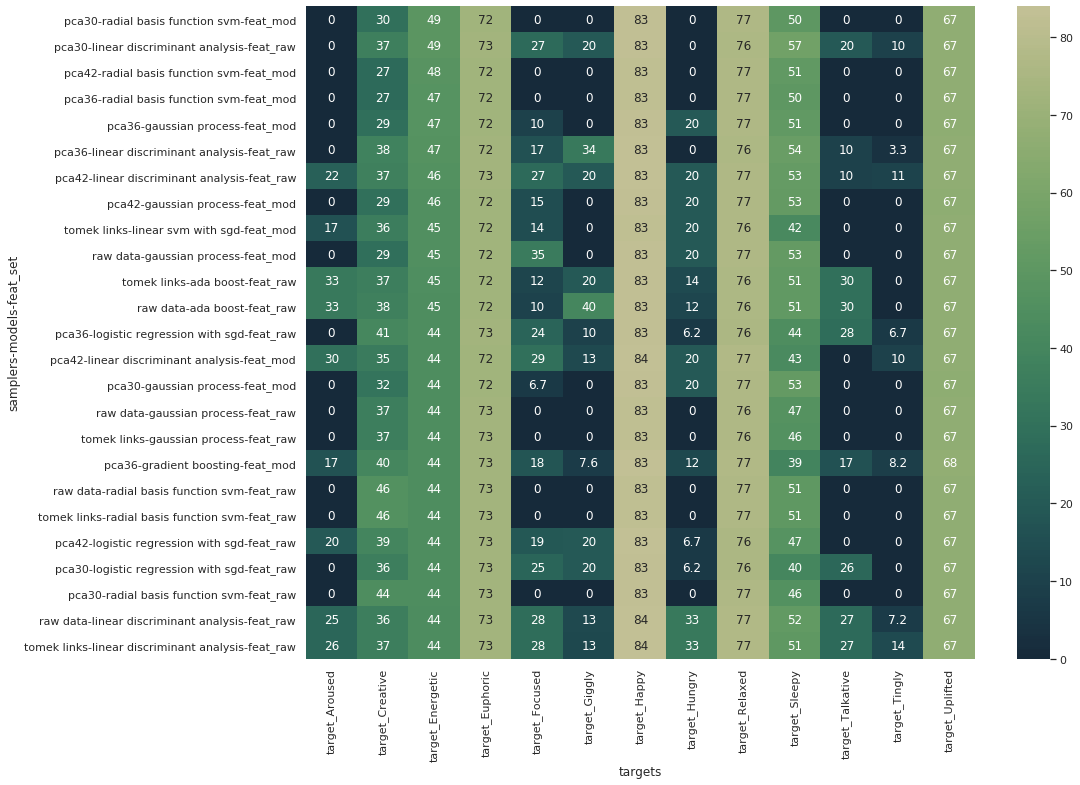

In [153]:
heat_map = pd.pivot_table(cv_results.query('measure == "precision"'), values='mean', index=['samplers', 'models', 'feat_set'],
                    columns='targets', aggfunc=np.sum)

plot, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heat_map.sort_values(by='target_Energetic', ascending=False).head(25), annot=True, ax=ax, center=50, cmap=sns.cubehelix_palette(start=0, rot=-.70, reverse=True, as_cmap=True))

In [154]:
heat_map.max()

targets
target_Aroused      43.33
target_Creative     46.43
target_Energetic    49.24
target_Euphoric     81.56
target_Focused      50.88
target_Giggly       40.00
target_Happy        91.35
target_Hungry       40.00
target_Relaxed      83.02
target_Sleepy       66.33
target_Talkative    44.19
target_Tingly       27.12
target_Uplifted     78.45
dtype: float64

In [155]:
heat_map.max() - baseline

targets
target_Aroused      34.61
target_Creative     13.55
target_Energetic    20.47
target_Euphoric      9.07
target_Focused      24.39
target_Giggly       26.20
target_Happy         8.83
target_Hungry       19.03
target_Relaxed       6.94
target_Sleepy       34.18
target_Talkative    28.06
target_Tingly       12.25
target_Uplifted     11.67
dtype: float64

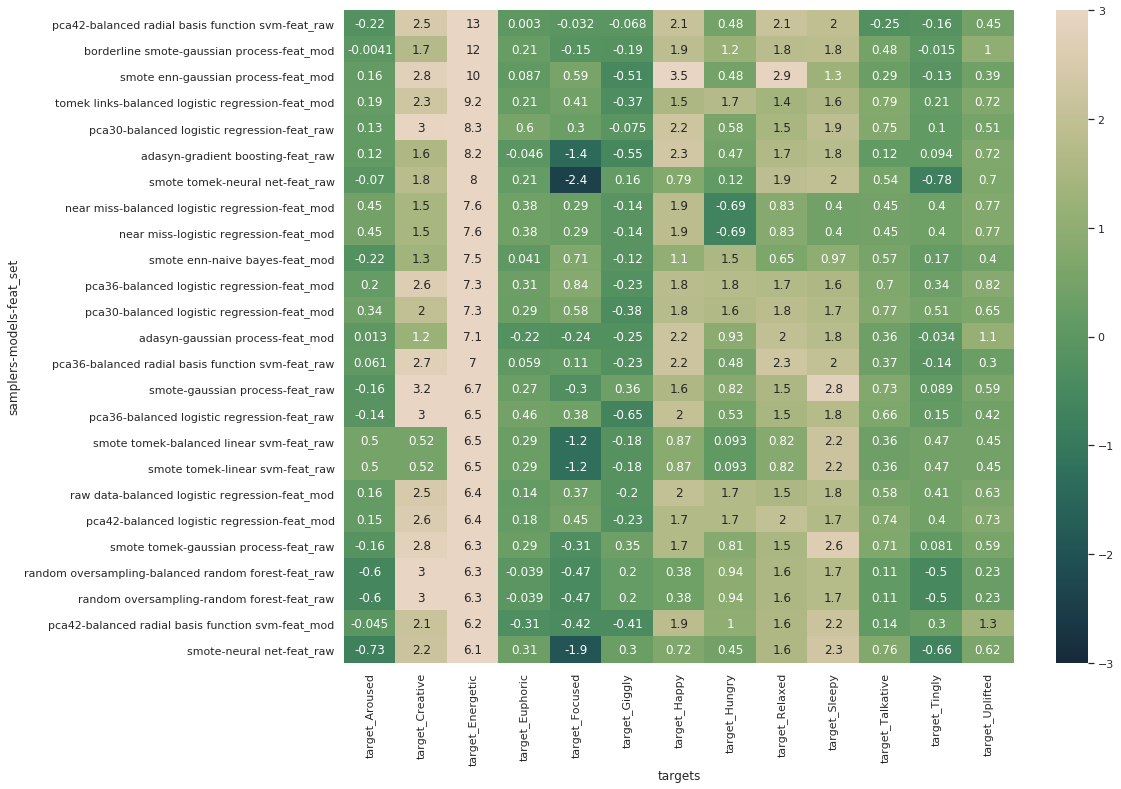

In [156]:
heat_map_standardize = (heat_map - baseline)/pd.pivot_table(cv_results.query('measure == "precision"'), 
                                                                            values='std', index=['samplers', 'models', 'feat_set'], 
                                                                            columns='targets', aggfunc=np.sum).replace(0,1)

plot, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heat_map_standardize.sort_values(by='target_Energetic', ascending=False).head(25), annot=True, ax=ax, vmin=-3, center=0, vmax=3, cmap=sns.cubehelix_palette(start=0, rot=-.70, reverse=True, as_cmap=True))

In [157]:
heat_map_standardize.max()

targets
target_Aroused       1.991914
target_Creative      7.432836
target_Energetic    12.660000
target_Euphoric      2.944828
target_Focused       3.250000
target_Giggly        1.256410
target_Happy         5.631579
target_Hungry        2.130952
target_Relaxed       7.672131
target_Sleepy        4.768421
target_Talkative     4.689655
target_Tingly        1.397887
target_Uplifted      4.464730
dtype: float64

In [182]:
target_of_interest = 'target_Energetic'

top_hm_id = heat_map[target_of_interest].idxmax()
top_shm_id = heat_map_standardize[target_of_interest].idxmax()
baseline_id = ('raw data', 'null_always_one', 'feat_raw')

new_base = pd.DataFrame()
for comps in [baseline_id, top_hm_id, top_shm_id]:
    new_base = pd.concat([new_base, cv_results.query('samplers == @comps[0] and models == @comps[1] and feat_set == @comps[2] and targets == @target_of_interest')], axis=0)
    
new_base

fold_1     fold_2     fold_3     fold_4     fold_5  \
2274  50.000000  50.000000  50.000000  50.000000  50.000000   
2275  25.665860  27.118644  29.782082  31.476998  29.782082   
2276  30.147895  31.746032  34.647887  36.475870  34.647887   
2577  50.763629  51.007060  52.045136  50.831748  50.887300   
2578  42.857143  60.000000  53.333333  50.000000  40.000000   
2579  11.194030  11.363636  21.857923  12.345679  16.393443   
2418  60.498740  59.032392  54.648164  54.474042  55.573311   
2419  34.806630  34.920635  35.099338  35.955056  34.693878   
2420  37.951807  38.018433  36.451169  38.004751  37.486218   

                                  models            measure           targets  \
2274                     null_always_one  balanced_accuracy  target_Energetic   
2275                     null_always_one          precision  target_Energetic   
2276                     null_always_one             f-Beta  target_Energetic   
2577           radial basis function svm  balanced_accuracy  target_Energetic   
2578           radial basis function svm          precision  target_Energetic   
2579           radial basis function svm             f-Beta  target_Energetic   
2418  balanced radial basis function svm  balanced_accuracy  target_Energetic   
2419  balanced radial basis function svm          precision  target_Energetic   
2420  balanced radial basis function svm             f-Beta  target_Energetic   

      samplers   mean   std        se  feat_set  
2274  raw data  50.00  0.00  0.000000  feat_raw  
2275  raw data  28.77  2.33  1.042008  feat_raw  
2276  raw data  33.53  2.54  1.135923  feat_raw  
2577     pca30  51.11  0.53  0.237023  feat_mod  
2578     pca30  49.24  8.05  3.600069  feat_mod  
2579     pca30  14.63  4.56  2.039294  feat_mod  
2418     pca42  56.85  2.75  1.229837  feat_raw  
2419     pca42  35.10  0.50  0.223607  feat_raw  
2420     pca42  37.58  0.67  0.299633  feat_raw

In [186]:
heat_map_nb = pd.pivot_table(new_base, values=['mean', 'std'], index=['samplers', 'models', 'feat_set'],
                    columns='measure', aggfunc=np.sum)

heat_map_nb

# plot, ax = plt.subplots(figsize=(15, 12))
# sns.heatmap(heat_map_nb.sort_values(by='precision', ascending=False), annot=True, ax=ax, center=50, cmap=sns.cubehelix_palette(start=0, rot=-.70, reverse=True, as_cmap=True))

mean         \
measure                                              balanced_accuracy f-Beta   
samplers models                             feat_set                            
pca30    radial basis function svm          feat_mod             51.11  14.63   
pca42    balanced radial basis function svm feat_raw             56.85  37.58   
raw data null_always_one                    feat_raw             50.00  33.53   

                                                                \
measure                                              precision   
samplers models                             feat_set             
pca30    radial basis function svm          feat_mod     49.24   
pca42    balanced radial basis function svm feat_raw     35.10   
raw data null_always_one                    feat_raw     28.77   

                                                                   std         \
measure                                              balanced_accuracy f-Beta   
samplers models                             feat_set                            
pca30    radial basis function svm          feat_mod              0.53   4.56   
pca42    balanced radial basis function svm feat_raw              2.75   0.67   
raw data null_always_one                    feat_raw              0.00   2.54   

                                                                
measure                                              precision  
samplers models                             feat_set            
pca30    radial basis function svm          feat_mod      8.05  
pca42    balanced radial basis function svm feat_raw      0.50  
raw data null_always_one                    feat_raw      2.33

Describe the breadth of hyperparams and other to search, response to this new data!

In [191]:
def estimator_hp(estimator, feats_train, targets_train, feats_test, targets_test, hyperparameters):
    
    if estimator == 'ada boost':
        est = AdaBoostClassifier(**hyperparameters)
    
    elif estimator == 'bagging':
        est = BaggingClassifier(**hyperparameters)
    
    elif estimator == 'decision tree':
        est = DecisionTreeClassifier(**hyperparameters)
    
    elif estimator == 'gaussian process':
        est = GaussianProcessClassifier(**hyperparameters)
    
    elif estimator == 'gradient boosting':
        est = GradientBoostingClassifier(**hyperparameters)
    
    elif estimator == 'k nearest neighbor':
        est = KNeighborsClassifier(**hyperparameters)
        
    elif estimator == 'linear discriminant analysis':
        est = LinearDiscriminantAnalysis(**hyperparameters)
        
    elif estimator == 'svm':
        est = SVC(**hyperparameters)
        
    elif estimator == 'estimator with sgd':
        est = SGDClassifier(**hyperparameters)
        
    elif estimator == 'logistic regression':
        est = LogisticRegressionCV(**hyperparameters)

    elif estimator == 'naive bayes':
        est = GaussianNB(**hyperparameters)
        
    elif estimator == 'neural net':
        est = MLPClassifier(**hyperparameters)
        
    elif estimator == 'random forest':
        est = RandomForestClassifier(**hyperparameters)
        
    elif estimator == 'quadratic discriminant analysis':
        est = QuadraticDiscriminantAnalysis(**hyperparameters)
     
    else:
        est = 0
        print('unsupported estimator, please try again')
    
    est.fit(feats_train, targets_train)
    targets_test_pred = est.predict(feats_test)
    accuracy = 100 * metrics.balanced_accuracy_score(targets_test, targets_test_pred)
    precision = 100 * metrics.precision_score(targets_test, targets_test_pred, zero_division=0)
    fB = 100 * metrics.fbeta_score(targets_test, targets_test_pred, beta=0.5, zero_division=0)
    
    return accuracy, precision, fB

In [192]:
est = SVC()
est.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

No need to include:

break ties (only 2 classes)

kernel cache (default 200 MB should be fine)

decision function shape (only 2 classes)

max_iter_vals (leave as default of -1 for no limit)

probability (not needed at this point)

shrinking (default of True should help speed up, given -1 for max iters)

verbose (not needed)


In [274]:
C_vals = [0.01, 1, 100]
class_weight_vals = [None, 'balanced']
coef0_vals = [0, 0.01, 1, 100]
degree_vals = [2, 3, 4, 5]
gamma_vals = ['auto', 'scale', 0.01, 1, 100]
kernel_vals = ['linear', 'poly', 'rbf', 'sigmoid']
random_state_vals = [10]
tol_vals = [0.01, 1, 100]

hps = ['C', 'class_weight', 'coef0', 'degree', 'gamma', 'kernel', 'random_state', 'tol']
hyperparameters_vals = [C_vals, class_weight_vals, coef0_vals, degree_vals, gamma_vals, kernel_vals, random_state_vals, tol_vals]

In [275]:
len(list(itertools.product(*hyperparameters_vals)))

5760

In [273]:
def change_feat_set(feat_set_to_change_to):
    if feat_set_to_change_to == 'features_0':
        features = features_0.copy(deep=True)
    elif feat_set_to_change_to == 'Pr_impute_1_1':
        features = features_mod.copy(deep=True)
    else:
        print('unsupported feat set!')
        features = change_feat_set('features_0')
    
    return features

In [ ]:
feat_sets_to_try = ['features_0', 'Pr_impute_1_1']

estimators_to_try = ['svm']

null_to_try = ['null_always_one']

samplers_to_try = ['raw data', 'pca42', 'pca30', 'pca18', 'pca6']

target_columns = ['target_Energetic']

number_of_folds = 5

######################################################################################################################

seed(10)
kf = KFold(n_splits=number_of_folds)
cv_results = pd.DataFrame()

for fs in feat_sets_to_try:
    print('********************')
    print(fs)
    print('********************')
    features = change_feat_set(fs)
    feats_train, feats_final_test, targets_train, targets_final_test = train_test_split(features, targets, test_size=0.1, random_state=10)

    kf.get_n_splits(feats_train)

    fold_num = 0
    models = []
    target_of_model = []
    samplers = []
    
    cv_results_tmp = pd.DataFrame()

    for cvtrain_index, cvtest_index in kf.split(feats_train):
        fold_scores = []
        fold_num +=1
        print("fold " + str(fold_num))
        print('**********')

        #Change to only build models for targets in target_columns list
        for target_column in target_columns:
            feats_cvtrain_0, feats_cvtest_0 = feats_train.iloc[cvtrain_index], feats_train.iloc[cvtest_index]
            targets_cvtrain_0, targets_cvtest_0 = targets_train.iloc[cvtrain_index][target_column], targets_train.iloc[cvtest_index][target_column]

            for s in samplers_to_try:
                feats_cvtrain = feats_cvtrain_0.copy(deep=True)
                feats_cvtest = feats_cvtest_0.copy(deep=True)
                targets_cvtrain = targets_cvtrain_0.copy(deep=True)
                targets_cvtest = targets_cvtest_0.copy(deep=True)

                feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest = sampler_regime(s, feats_cvtrain, feats_cvtest, targets_cvtrain, targets_cvtest)


                for null in null_to_try:
                    if fold_num == 1:
                        models.append(null)
                        samplers.append(s)
                        target_of_model.append(target_column)
                    fold_scores.extend(list(null_model(null, target_column, targets_cvtest)))

                #Change to generate model for each set of hyperparameters
                for estimator in estimators_to_try:
                    hp_search_mod_num = 0
                    for model_val_set in list(itertools.product(*hyperparameters_vals)):
                        hp_search_mod_num +=1
                        hyperparams = dict(zip(hps, model_val_set))
                        if fold_num == 1:
                            models.append(hyperparams)
                            samplers.append(s)
                            target_of_model.append(target_column)
                        fold_scores.extend(list(estimator_hp(estimator, feats_cvtrain, targets_cvtrain, feats_cvtest, targets_cvtest, hyperparams)))


        cv_results_tmp['fold_' + str(fold_num)] = fold_scores

    
    cv_results_tmp['models'] = [m for mods in models for m in 3*[mods]]
    cv_results_tmp['measure'] = ['balanced_accuracy', 'precision', 'f-Beta'] * len(models)
    cv_results_tmp['targets'] = [t for targs in target_of_model for t in 3*[targs]]
    cv_results_tmp['samplers'] = [s for samps in samplers for s in 3*[samps]]
    cv_results_tmp['feat set'] = fs
    cv_results_tmp['mean'] = list(round(cv_results_tmp.T[cv_results_tmp.columns.str.contains('fold')].mean(),2))
    cv_results_tmp['std'] = list(round(cv_results_tmp.T[cv_results_tmp.columns.str.contains('fold')].std(),2))
    cv_results_tmp['se'] = cv_results_tmp['std']/np.sqrt(fold_num)
    
    cv_results = pd.concat([cv_results, cv_results_tmp], axis=0)

# Set features back to original set, and propagate through the test and final train splits
features = features_0.copy(deep=True)
feats_train, feats_final_test, targets_train, targets_final_test = train_test_split(features, targets, test_size=0.1, random_state=10)

********************
features_0
********************
fold 1
**********


In [ ]:
cv_results.to_csv('./hp_search_Energetic')

In [ ]:
pt = pd.pivot_table(cv_results, values='mean', index='models',
                    columns='measure', aggfunc=np.sum)

In [ ]:
hp_lookup = pd.DataFrame()
for x in range(len(model_hp_record)):
    hp_lookup[model_hp_record[x][0]] = list(model_hp_record[x][1])
hp_lookup.index = hps

for hp in hps:
    if len(hp_lookup.loc[hp].unique()) == 1:
        hp_lookup = hp_lookup.drop([hp], axis=0)
    

In [ ]:
results = pd.concat([pt,hp_lookup.T], axis=1).sort_values(by='precision', ascending=False)

In [ ]:
results[results['precision'] > 41.07 ]

In [ ]:
cv_results[cv_results['models'] == 'model_1']

In [ ]:
# bootstrap_vals = [True]
# ccp_alpha_vals = [0.0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# class_weight_vals = [None, 'balanced', 'balanced_subsample']
# criterion_vals = ['gini', 'entropy']
# max_depth_vals = [None, 1, 2, 3, 5, 8]
# max_features_vals = [3, 5, 8, 12]
# max_leaf_nodes_vals = [None, 25, 50, 100, 200, 500, 1000]
# max_samples_vals = [None]
# min_impurity_decrease_vals = [0.0]
# min_impurity_split_vals = [None]
# min_samples_leaf_vals = [1, 3, 5]
# min_samples_split_vals = [2, 6, 10, 20]
# min_weight_fraction_leaf_vals = [0.0]
# n_estimators_vals = [50, 100, 500, 1000, 5000]
# n_jobs_vals = [6]
# oob_score_vals = [False]
# random_state_vals = [10]
# verbose_vals = [0]
# warm_start_vals = [False]

bootstrap_vals = [True]
ccp_alpha_vals = [0.0005, 0.0007, 0.001, 0.0015, 0.002, 20, 25, 30]
class_weight_vals = [None]
criterion_vals = ['entropy']
max_depth_vals = [None]
max_features_vals = ['auto']
max_leaf_nodes_vals = [None]
max_samples_vals = [None]
min_impurity_decrease_vals = [0.0]
min_impurity_split_vals = [None]
min_samples_leaf_vals = [1]
min_samples_split_vals = [2]
min_weight_fraction_leaf_vals = [0.0]
n_estimators_vals = [100]
n_jobs_vals = [6]
oob_score_vals = [False]
random_state_vals = [10]
verbose_vals = [0]
warm_start_vals = [False]

hyperparameters_vals = [bootstrap_vals, ccp_alpha_vals, class_weight_vals, \
                        criterion_vals, max_depth_vals, max_features_vals, \
                        max_leaf_nodes_vals, max_samples_vals, min_impurity_decrease_vals, \
                        min_impurity_split_vals, min_samples_leaf_vals, min_samples_split_vals, \
                        min_weight_fraction_leaf_vals, n_estimators_vals, n_jobs_vals, \
                        oob_score_vals, random_state_vals, verbose_vals, warm_start_vals]\


In [ ]:
len(list(itertools.product(*hyperparameters_vals)))


In [ ]:
kf = KFold(n_splits=10)
kf.get_n_splits(feats_train)

fold_num = 0
models = []
cv_results = pd.DataFrame()
rf = RandomForestClassifier()

for cvtrain_index, cvtest_index in kf.split(feats_train):
    fold_scores = []
    fold_num +=1
    print("fold " + str(fold_num))
    feats_cvtrain, feats_cvtest = feats_train.iloc[cvtrain_index], feats_train.iloc[cvtest_index]
    targets_cvtrain, targets_cvtest = targets_train.iloc[cvtrain_index], targets_train.iloc[cvtest_index]
    
    print('size of test set: ' + str(len(feats_cvtest)))
    
    print('-')
    print('NULL MODEL - SAMPLE-WEIGHTED RANDOM')
    if fold_num == 1:
        models.append('model_0')
    fold_scores.extend(list(null_model('null_rand_draw', targets_cvtest)))
    
    print('-')
    print('NULL MODEL - SELECT TOP 5 TARGETS')
    if fold_num == 1:
        models.append('model_00')
    fold_scores.extend(list(null_model('null_top_5', targets_cvtest)))
        
    print('-')
    print('RANDOM FOREST - DEFAULT')
    if fold_num == 1:
        models.append('model_1')
    fold_scores.extend(list(RF_3x_metrics(feats_cvtrain, targets_cvtrain, feats_cvtest, targets_cvtest)))
    
    model_hp_record = []
    hps = list(rf.get_params().keys())
    hp_search_mod_num = 1
    for model_val_set in list(itertools.product(*hyperparameters_vals)):
        hp_search_mod_num +=1
        model_hp_record.append(('model_' + str(hp_search_mod_num), model_val_set))
        hyperparams = dict(zip(hps, model_val_set))
        print('-')
        print('RANDOM FOREST - model_' + str(hp_search_mod_num))
        if fold_num == 1:
            models.append('model_' + str(hp_search_mod_num))
        fold_scores.extend(list(RF_3x_metrics_hps(feats_cvtrain, targets_cvtrain, feats_cvtest, targets_cvtest, hyperparams)))
        
        
    
    cv_results['fold_' + str(fold_num)] = fold_scores
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

cv_results['models'] = [m for mods in models for m in 3*[mods]]
cv_results['measure'] = ['subset_accuracy', 'coverage_error', 'avg_num_correct_labels'] * len(models)
cv_results['mean'] = list(round(cv_results.T[cv_results.columns.str.contains('fold')].mean(),2))
cv_results['std'] = list(round(cv_results.T[cv_results.columns.str.contains('fold')].std(),2))

In [ ]:
cv_results

In [ ]:
pd.pivot_table(cv_results, values='mean', index='models',
                    columns='measure', aggfunc=np.sum).sort_values(by='avg_num_correct_labels', ascending = False)

In [ ]:
cv_results_top = pd.DataFrame()

In [ ]:
cv_results_top['model_1'] = list(rf.get_params().values())

In [ ]:
model_number = 7
print('model_' + str(model_number))
list(itertools.product(*hyperparameters_vals))[model_number - 2]
cv_results_top['model_' + str(model_number)] = list(itertools.product(*hyperparameters_vals))[model_number - 2]
#hyperparams = dict(zip(hps, list(itertools.product(*hyperparameters_vals))[model_number - 2]))
#hyperparams


In [ ]:
cv_results_top.index = hps

In [ ]:
cv_results_top

In [ ]:
model_hp_record

In [ ]:
cv_results

In [ ]:
#generate df of conditional probabilities between all pairs
probs = []
ratios = []
labels = []
event = []
cond_event = []
event_base = []
for A in features.columns:
    for B in features.columns:
        print('Pr(' + B + ' | ' + A + ')')
        event.append(B)
        cond_event.append(A)
        labels.append('Pr(' + B + ' | ' + A + ')')
        print(features[features[A] == 1].sum()[B]/features[features[A] == 1].sum()[A])
        probs.append(features[features[A] == 1].sum()[B]/features[features[A] == 1].sum()[A])
        ratios.append((features[features[A] == 1].sum()[B]/features[features[A] == 1].sum()[A])/(len(features[(features[B] == 1)])/len(features)))
        event_base.append(features.sum()[B]/len(features))

In [ ]:
Pr_data = pd.DataFrame()
Pr_data['labels'] = labels
Pr_data['events'] = event
Pr_data['cond_events'] = cond_event
Pr_data['probs'] = probs
Pr_data['event_base'] = event_base
Pr_data['ratios'] = ratios


Pr_data#[(Pr_data['probs'] < 1) & (Pr_data['events'] == 'feature_Apple')].sort_values(by='ratios', ascending=False).head(50)

In [ ]:
probs = []
labels = []
event = []
cond_eventA = []
cond_eventC = []
for A in features.columns:
    for B in features.columns:
        for C in features.columns:
            print('Pr(' + B + ' | ' + A + ',' + C +')')
            event.append(B)
            cond_eventA.append(A)
            cond_eventC.append(C)
            labels.append('Pr(' + B + ' | ' + A + ',' + C +')')
            num = len(features[(features[A] == 1) & (features[B] == 1) & (features[C] == 1)])/len(features)
            denom = ((len(features[(features[A] == 1) & (features[C] == 1)])+1)/len(features))

            print(num/denom)
            probs.append(num/denom)




In [ ]:
Pr_data_2 = pd.DataFrame()
Pr_data_2['labels'] = labels
Pr_data_2['events'] = event
Pr_data_2['cond_events_A'] = cond_eventA
Pr_data_2['cond_events_C'] = cond_eventC
Pr_data_2['probs'] = probs

Pr_data_2

In [ ]:
len(features[(features[A] == 1)])/2000
len(features[(features[A] == 1)])/len(features)

In [ ]:
A = 'feature_Vanilla'
C = 'feature_Coffee'
B = 'feature_Sweet'
num = len(features[(features[A] == 1) & (features[B] == 1) & (features[C] == 1)])/len(features)
denom = ((len(features[(features[A] == 1) & (features[C] == 1)])+1)/len(features))

print(num)
print(denom)

print(num/denom)

In [ ]:
len(features[(features[A] == 1) & (features[C] == 1)])+1

In [ ]:
# bayes 1 - Pr(B|A) = Pr(A and B) / Pr(A) 
num = (features[features[A] == 1].sum()[A]/len(features))*(features[features[B] == 1].sum()[B]/len(features))
denom = (features[features[A] == 1].sum()[A]/len(features))
num/denom

In [ ]:
# bayes 1 alt - Pr(B|A) = Pr(A and B) / Pr(A) 
num = len(features[(features[A] == 1) & (features[B] == 1)])/len(features)
denom = (len(features[features[A] == 1])/len(features))
num/denom


In [ ]:
# bayes 2 - Pr(B|A) = Pr(A|B) * Pr(B) / Pr(A|B) * Pr(B) + Pr(A|Bc) * Pr(Bc)
num = (features[features[B] == 1].sum()[A]/features[features[B] == 1].sum()[B]) * (len(features[features[B] == 1])/len(features))
denom = num + ((features[features[B] == 0].sum()[A]/len(features[features[B] == 0])) * (len(features[features[B] == 0])/len(features)))
num/denom

In [ ]:
#ISSUE: does not account base frequency (most instances of B might not also have A, but that might be because A is just not very frequent!)
Pr(A) * Pr(A|B)/Pr(Ac|B) * Pr(A|C)/Pr(Ac|C) * Pr(A|D)/Pr(Ac|D) * Pr(A|B,C)/Pr(Ac|B,C) * Pr(A|B,D)/Pr(Ac|B,D) * Pr(A|C,D)/Pr(Ac|C,D) 